# MOSMAFS - NSGA2 vs. MBO 

### Research questions: 

* **_Evolutionary vs. Bayesian Optimization_**: How do the proposed methods - the evolutionary and the Bayesian optimization approach - perform in comparison to each other?
* _Effect of Filter Ensembles_: Do the methods benefit from using filter ensembles?
* _Multi-Objective vs. Single-Objective_: Does multi-objective optimization find much sparser solutions without a major loss in predictive performance compared to single-objective optimization? 
* _Simultaneous Hyperparameter Tuning and Feature Selection_: Is it beneficial to perform hyperparameter optimization and feature selection simultaneously compared to performing the tasks independently? 

## Setup

In [2]:
# Load packages 
library(data.table)
library(reshape2)
library(mlr)
library(ggplot2)
library(batchtools)
library(gridExtra)
library(ggpubr)
library(ggthemes)
library(plyr)
library(scmamp)

In [3]:
# stetup for nice plots 
theme_set(theme_pubr())
options(repr.plot.width=15, repr.plot.height=15)

In [4]:
source("../helpers.R")

In [5]:
# path where all results are stored 
respath = "result_data"

In [84]:
# datasets included in the benchmark 
datasets = c("sonar", "ionosphere",
	"hill-valley", "wdbc", "tecator", "lsvt", "isolet", "cnae-9", 
	"semeion", "AP_Breast_Colon", "arcene", 
	"AP_Colon_Kidney", "madelon", "madeline")

In [85]:
tab = lapply(datasets, function(d) {
    task = readRDS(file.path("../data", d, "task.rds"))
    class.dist = task$task.desc$class.distribution
    cr = min(class.dist) / sum(class.dist)
    data.table(id = getTaskId(task), n = getTaskSize(task), p = getTaskNFeats(task), class.ratio = cr)
    })
tab = do.call(rbind, tab)

tab$np.ratio = tab$n / tab$p 
tab = tab[order(p), ]
tab = cbind(1:nrow(tab), tab)

In [86]:
tab

V1 id              n    p     class.ratio np.ratio   
1   1 wdbc             569    30 0.3725835   18.96666667
2   2 ionosphere       351    33 0.3589744   10.63636364
3   3 sonar            208    60 0.4663462    3.46666667
4   4 hill-valley     1212   100 0.4950495   12.12000000
5   5 tecator          240   124 0.4250000    1.93548387
6   6 semeion          319   256 0.4952978    1.24609375
7   7 madeline        3140   259 0.4971338   12.12355212
8   8 cnae-9           240   282 0.5000000    0.85106383
9   9 lsvt             126   307 0.3333333    0.41042345
10 10 madelon         2600   500 0.5000000    5.20000000
11 11 isolet           600   617 0.5000000    0.97244733
12 12 arcene           200  9961 0.4400000    0.02007831
13 13 AP_Breast_Colon  630 10935 0.4539683    0.05761317
14 14 AP_Colon_Kidney  546 10935 0.4761905    0.04993141

The versions we compare are: 

|Variant | Description | Filter-Ensemble | Internal Name |
|---|---|---|---|
|GA-MO-FE| GA-based Algorithm |Yes | OGHFiFmS |
|GA-MO| GA-based Algorithm |No | OGHFi |
|BO-MO-FE | BO-based Algorithm | Yes | BSMOF | 
|BO-MO | BO-based Algorithm | No | BSMO | 


In [87]:
# Experiments to compare
variants_internal = c("OGHFi", "OGHFiFmS", "BSMO", "BSMOF")
variants = c("GA-MO", "GA-MO-FE", "BO-MO", "BO-MO-FE")
names(variants) = variants_internal # for revaluing later 

In [88]:
# read the files 
df = getObjSummaries(datasets = datasets, experiments = variants_internal)
df$variant = revalue(df$variant, variants)

In [89]:
# sanity check if all is read properly
dft = df[gen == 0, ]
grid = setDT(expand.grid(variants, datasets))
names(grid) = c("variant", "problem")

test = dft[, .N, by = c("variant", "problem")]
test = merge(grid, test, by = c("variant", "problem"), all.x = TRUE)

# both should be 0 
test[is.na(N), ]
test[N != 30, ]

variant problem N

variant problem N

## Analysis 


In [90]:
measure.vars = c("eval.domHV", "true.hout.domHV", "naive.hout.domHV")

### a) Dominated Hypervolume over Time 

In this section, we evaluate performance via the dominated hypervolume. First, we compute the mean domincated hypervolume over all replications. 

In [91]:
# aggregate over replications 
dfp = df[, lapply(.SD, mean, na.rm = TRUE), by = c("variant", "evals", "problem", "learner"), .SDcols = measure.vars]

##### Training Performance

Dominated Hypervolume measured by training error. 

Warning message:
“Removed 268 rows containing missing values (geom_path).”


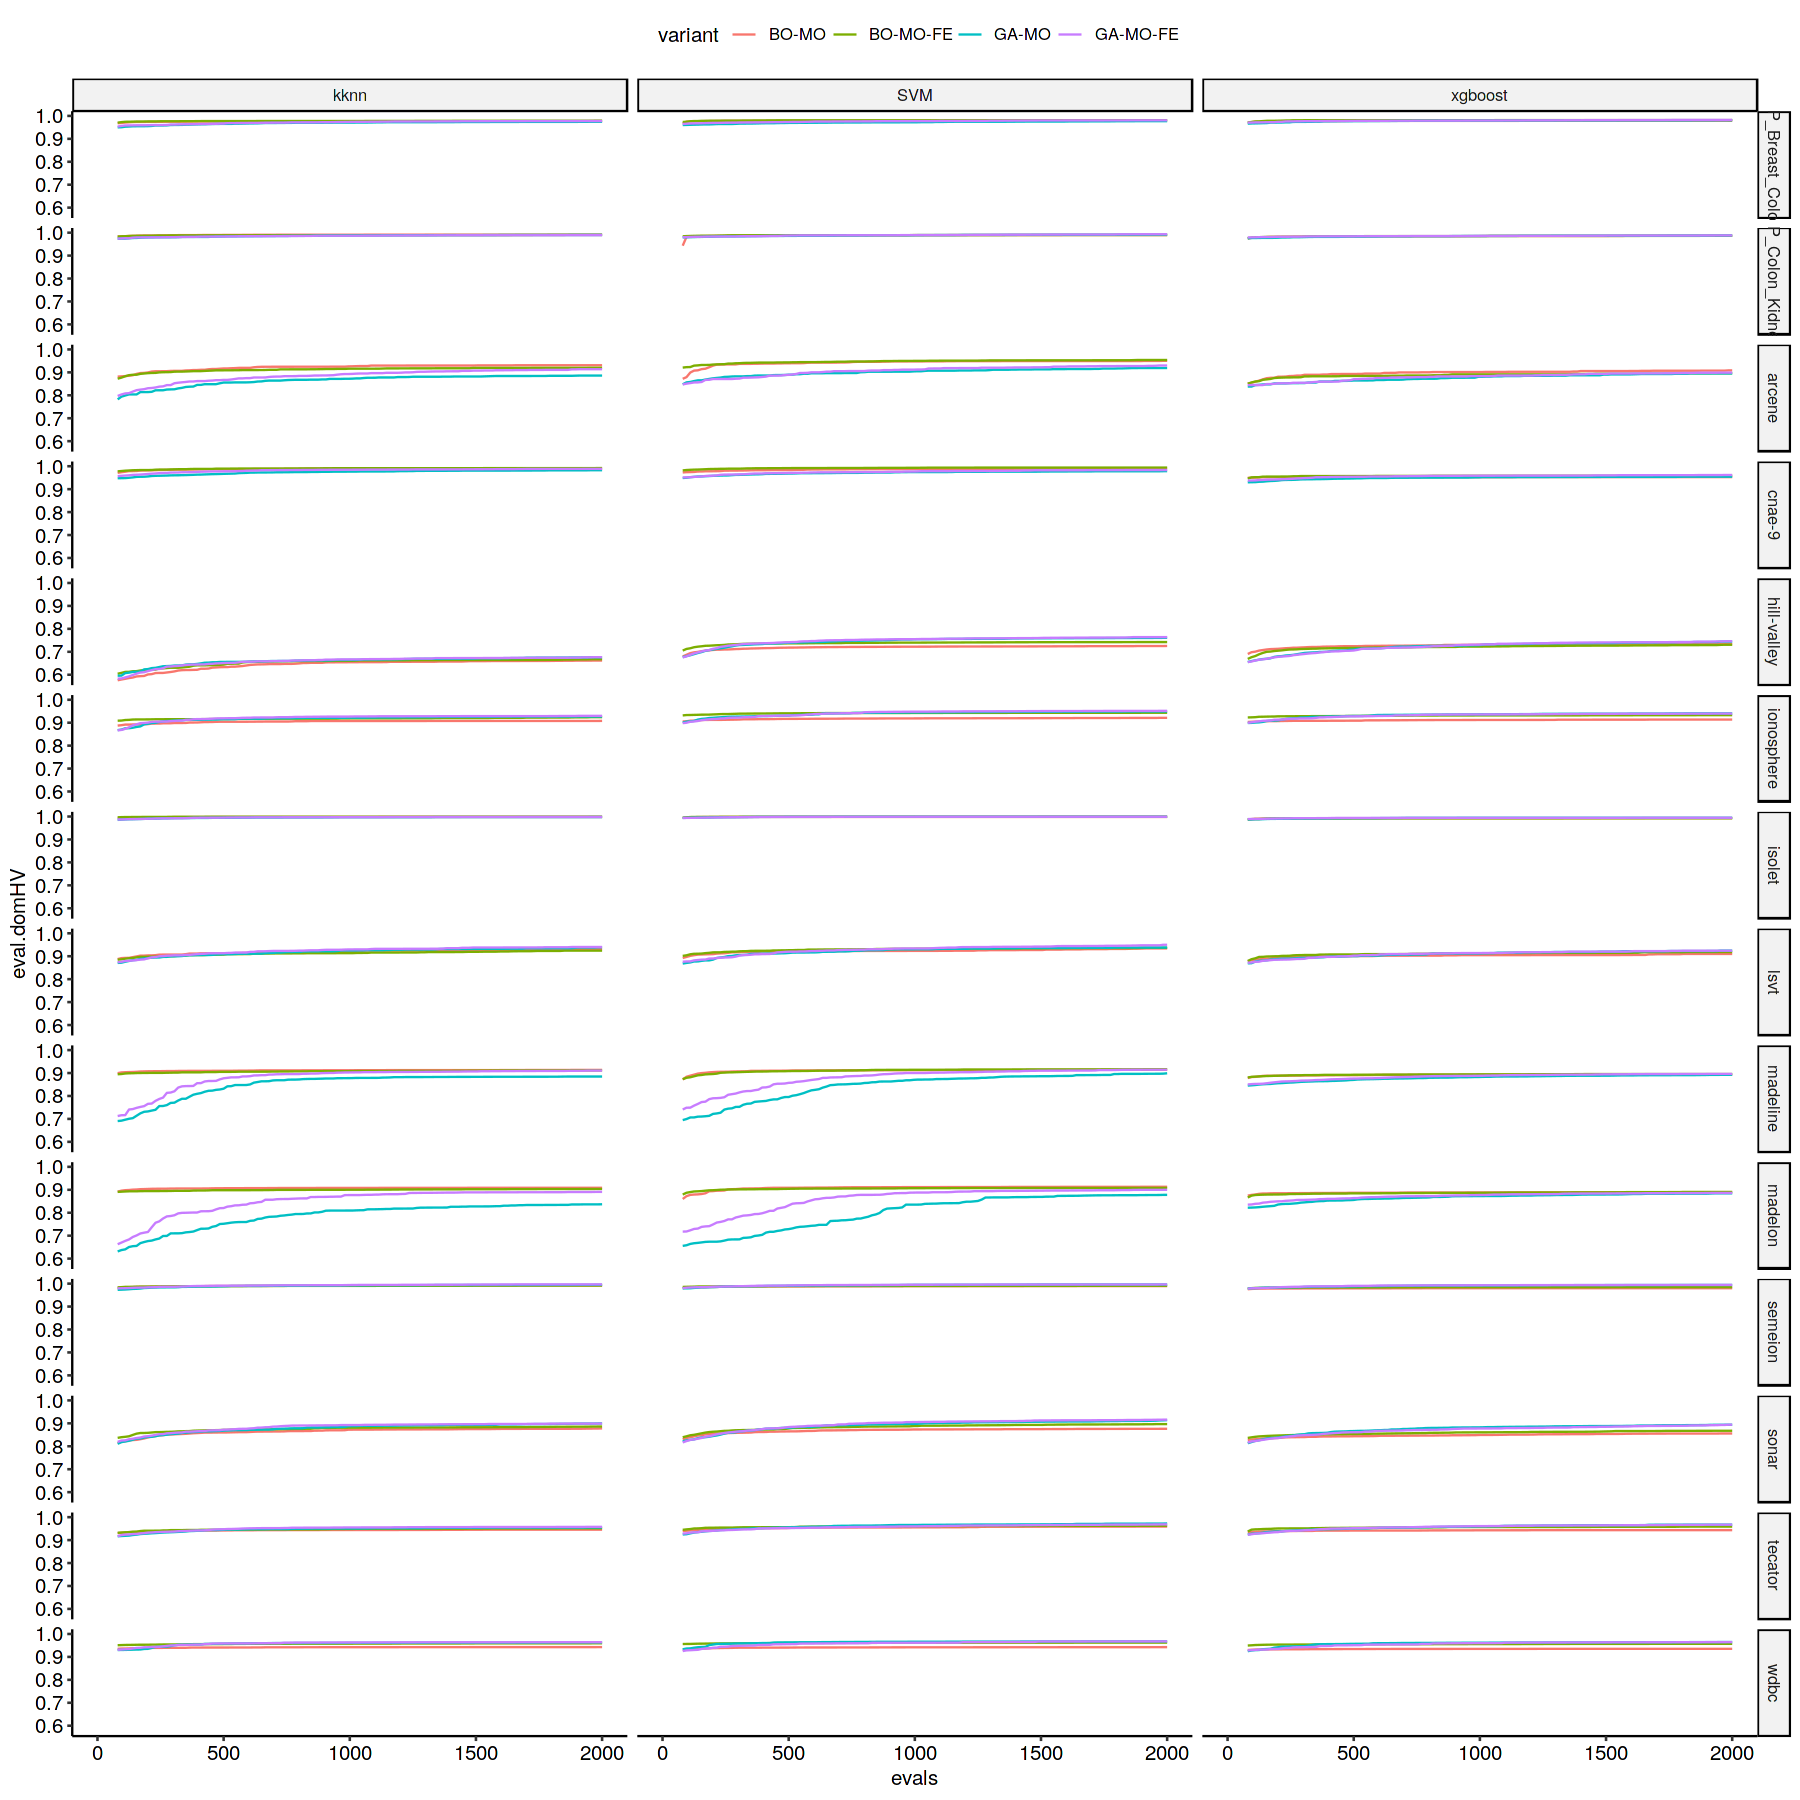

In [92]:
p = ggplot(data = dfp, aes(x = evals, y = eval.domHV, colour = variant)) + geom_line() + xlim(c(0, 2000))
p = p + facet_grid(problem ~ learner)
p

In [93]:
plist = list()
for (prob in unique(dfp$prob)) {
    for (lrn in unique(dfp$learner)) {
        p = ggplot(data = dfp[problem == prob & learner == lrn, ], aes(x = evals, y = eval.domHV, colour = variant)) + geom_line()
        p = p + ggtitle(paste(lrn, "on", prob)) + xlim(c(0, 2000)) + ylim(c(0.8, 1))
        plist[[paste(prob, lrn, sep = ".")]] = p
    }
}

Warning message:
“Removed 269 rows containing missing values (geom_path).”


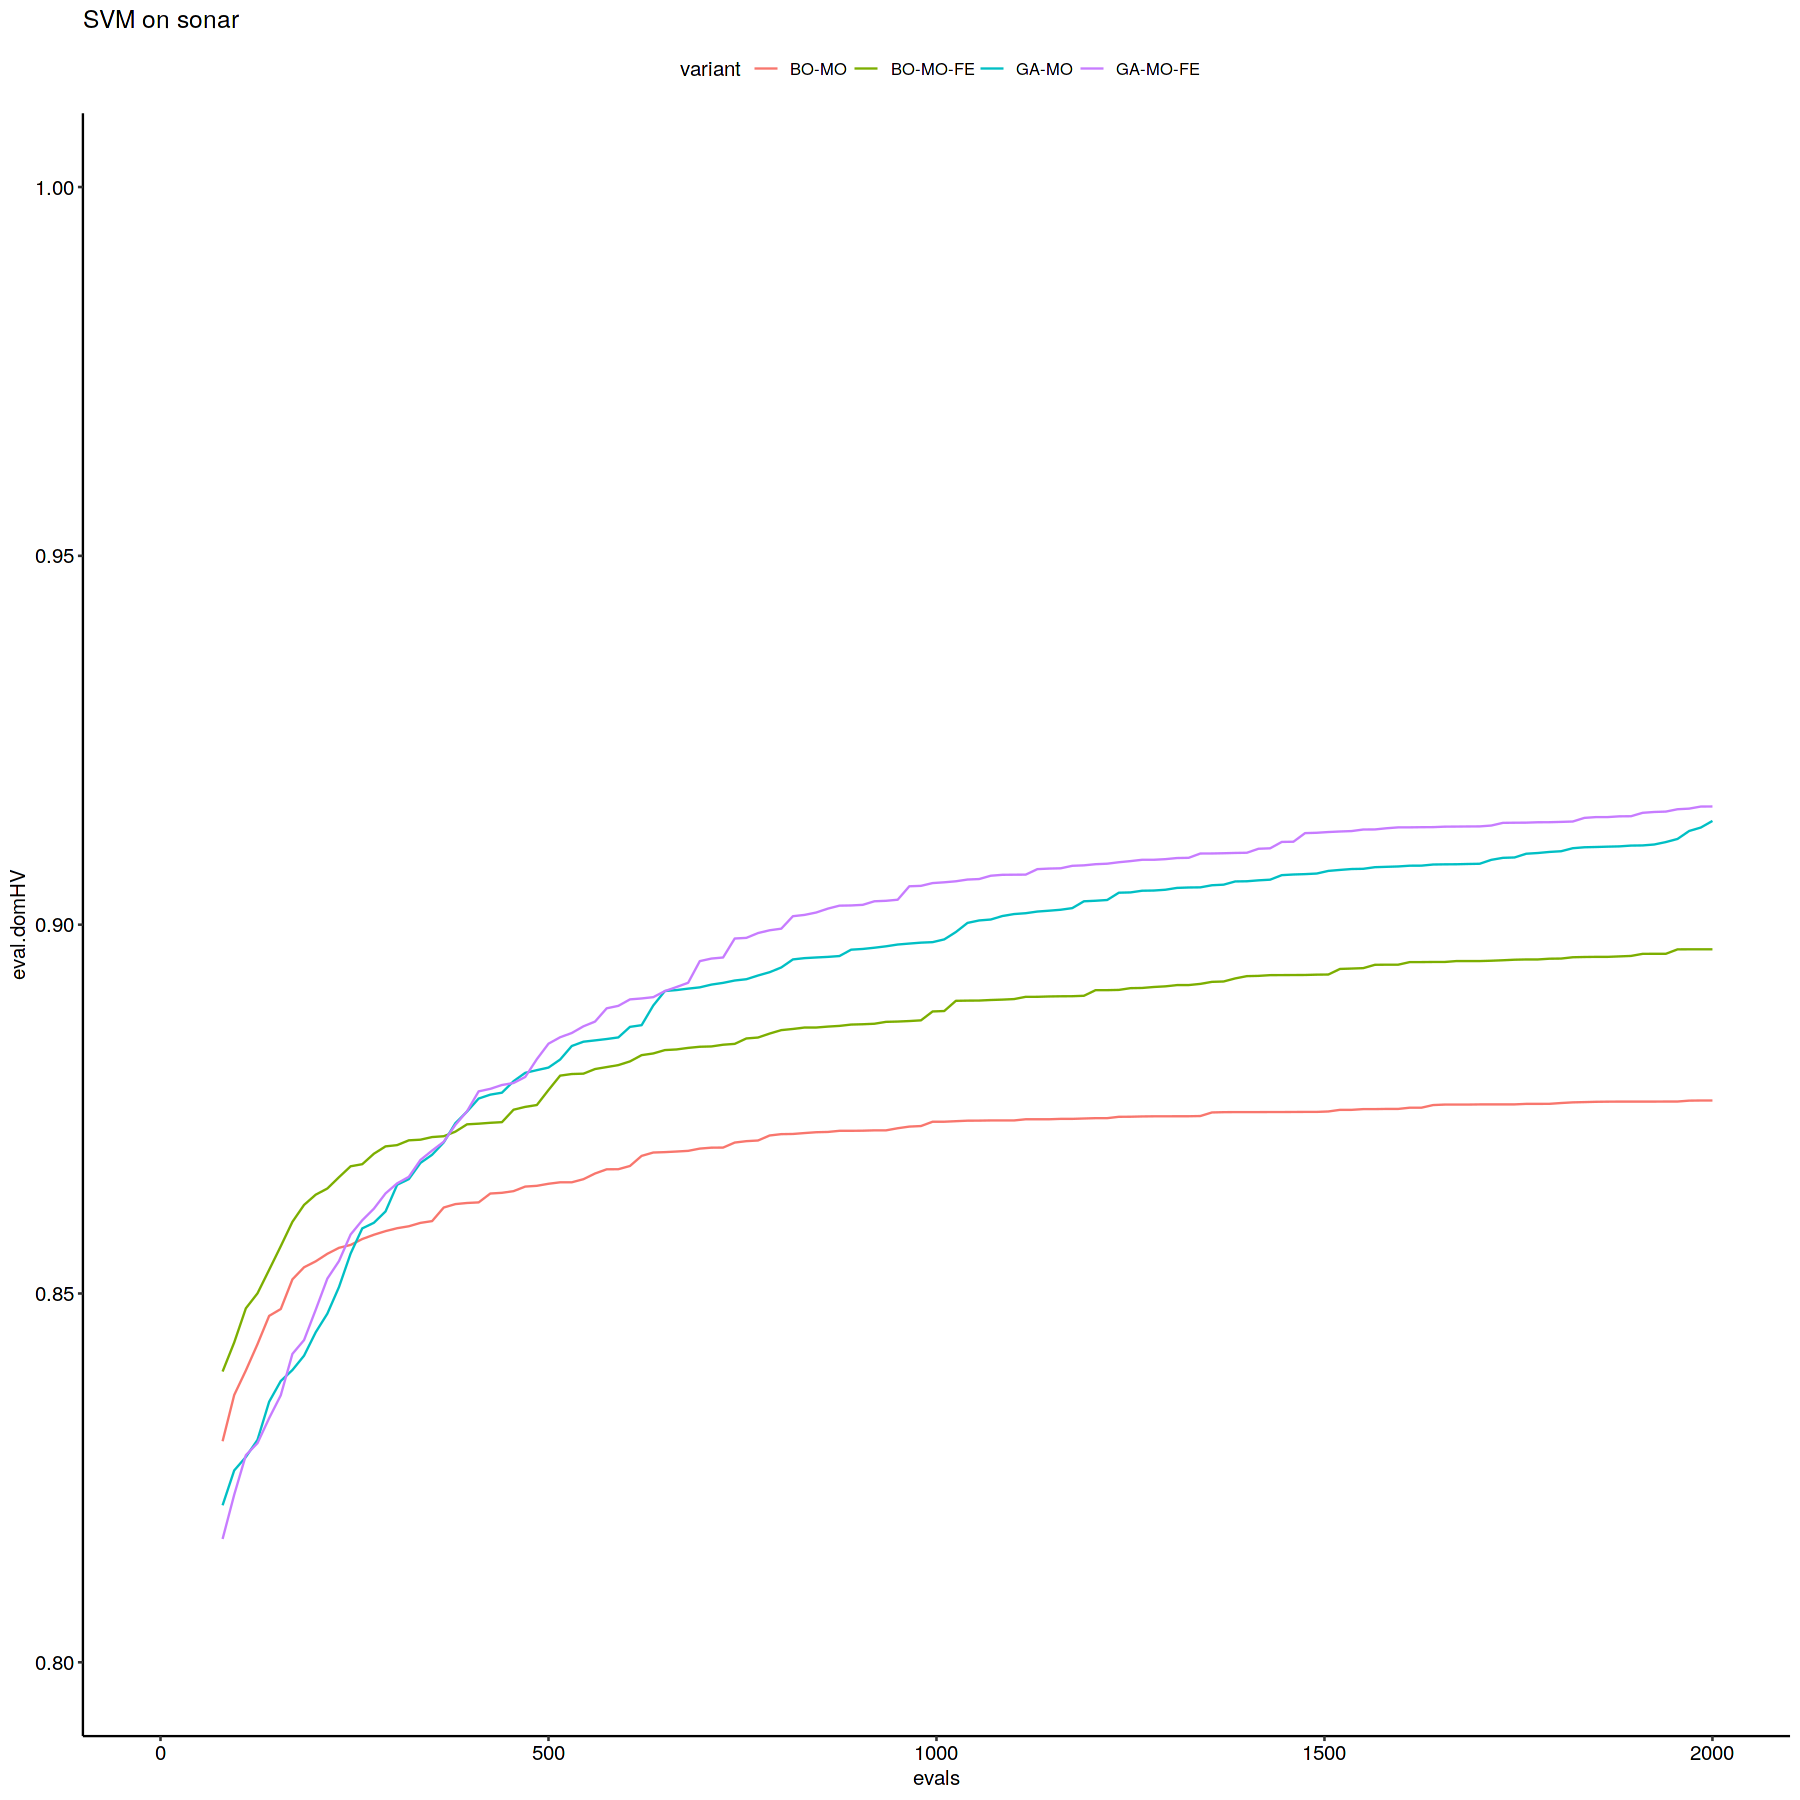

In [94]:
plist[[1]]

#### Test Performance

Effective dominated hypervolume. 

Warning message:
“Removed 268 rows containing missing values (geom_path).”


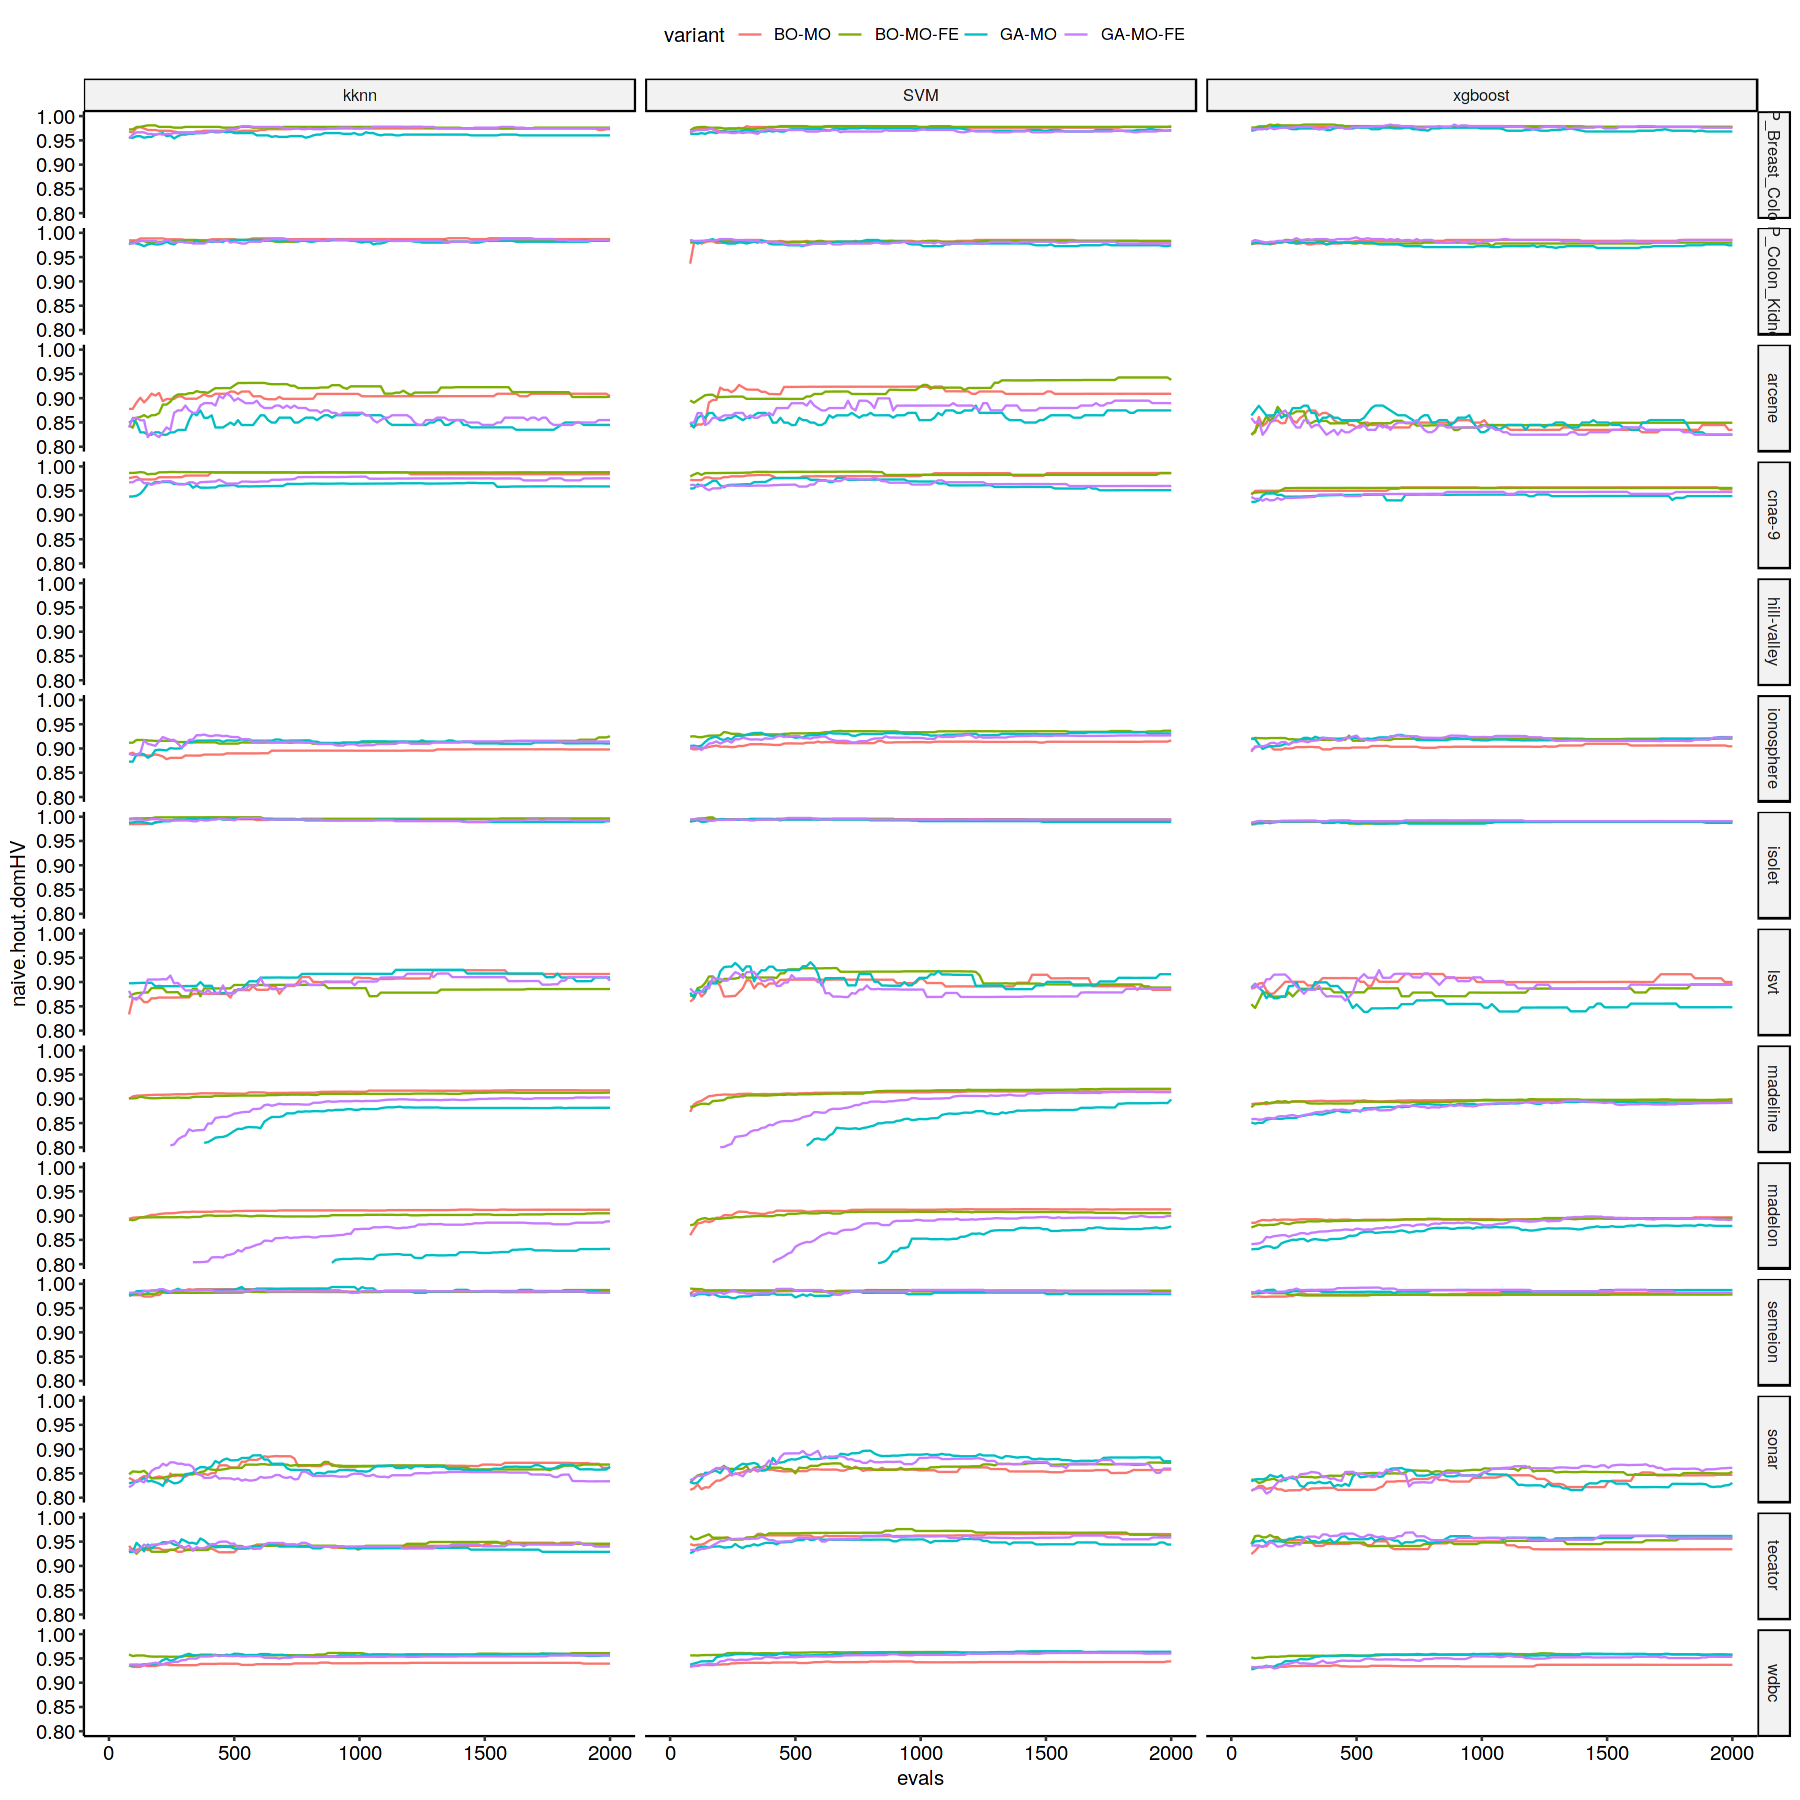

In [96]:
p = ggplot(data = dfp, aes(x = evals, y = naive.hout.domHV, colour = variant)) + geom_line() + xlim(c(0, 2000))
p = p + facet_grid(problem ~ learner) + ylim(c(0.8, 1))
p

In [97]:
plist = list()
for (prob in unique(dfp$prob)) {
    for (lrn in unique(dfp$learner)) {
        p = ggplot(data = dfp[problem == prob & learner == lrn, ], aes(x = evals, y = naive.hout.domHV, colour = variant)) + geom_line()
        p = p + ggtitle(paste(lrn, "on", prob)) + xlim(c(0, 2000))
        plist[[paste(prob, lrn, sep = ".")]] = p
    }
}

Warning message:
“Removed 269 rows containing missing values (geom_path).”
Warning message:
“Removed 268 rows containing missing values (geom_path).”


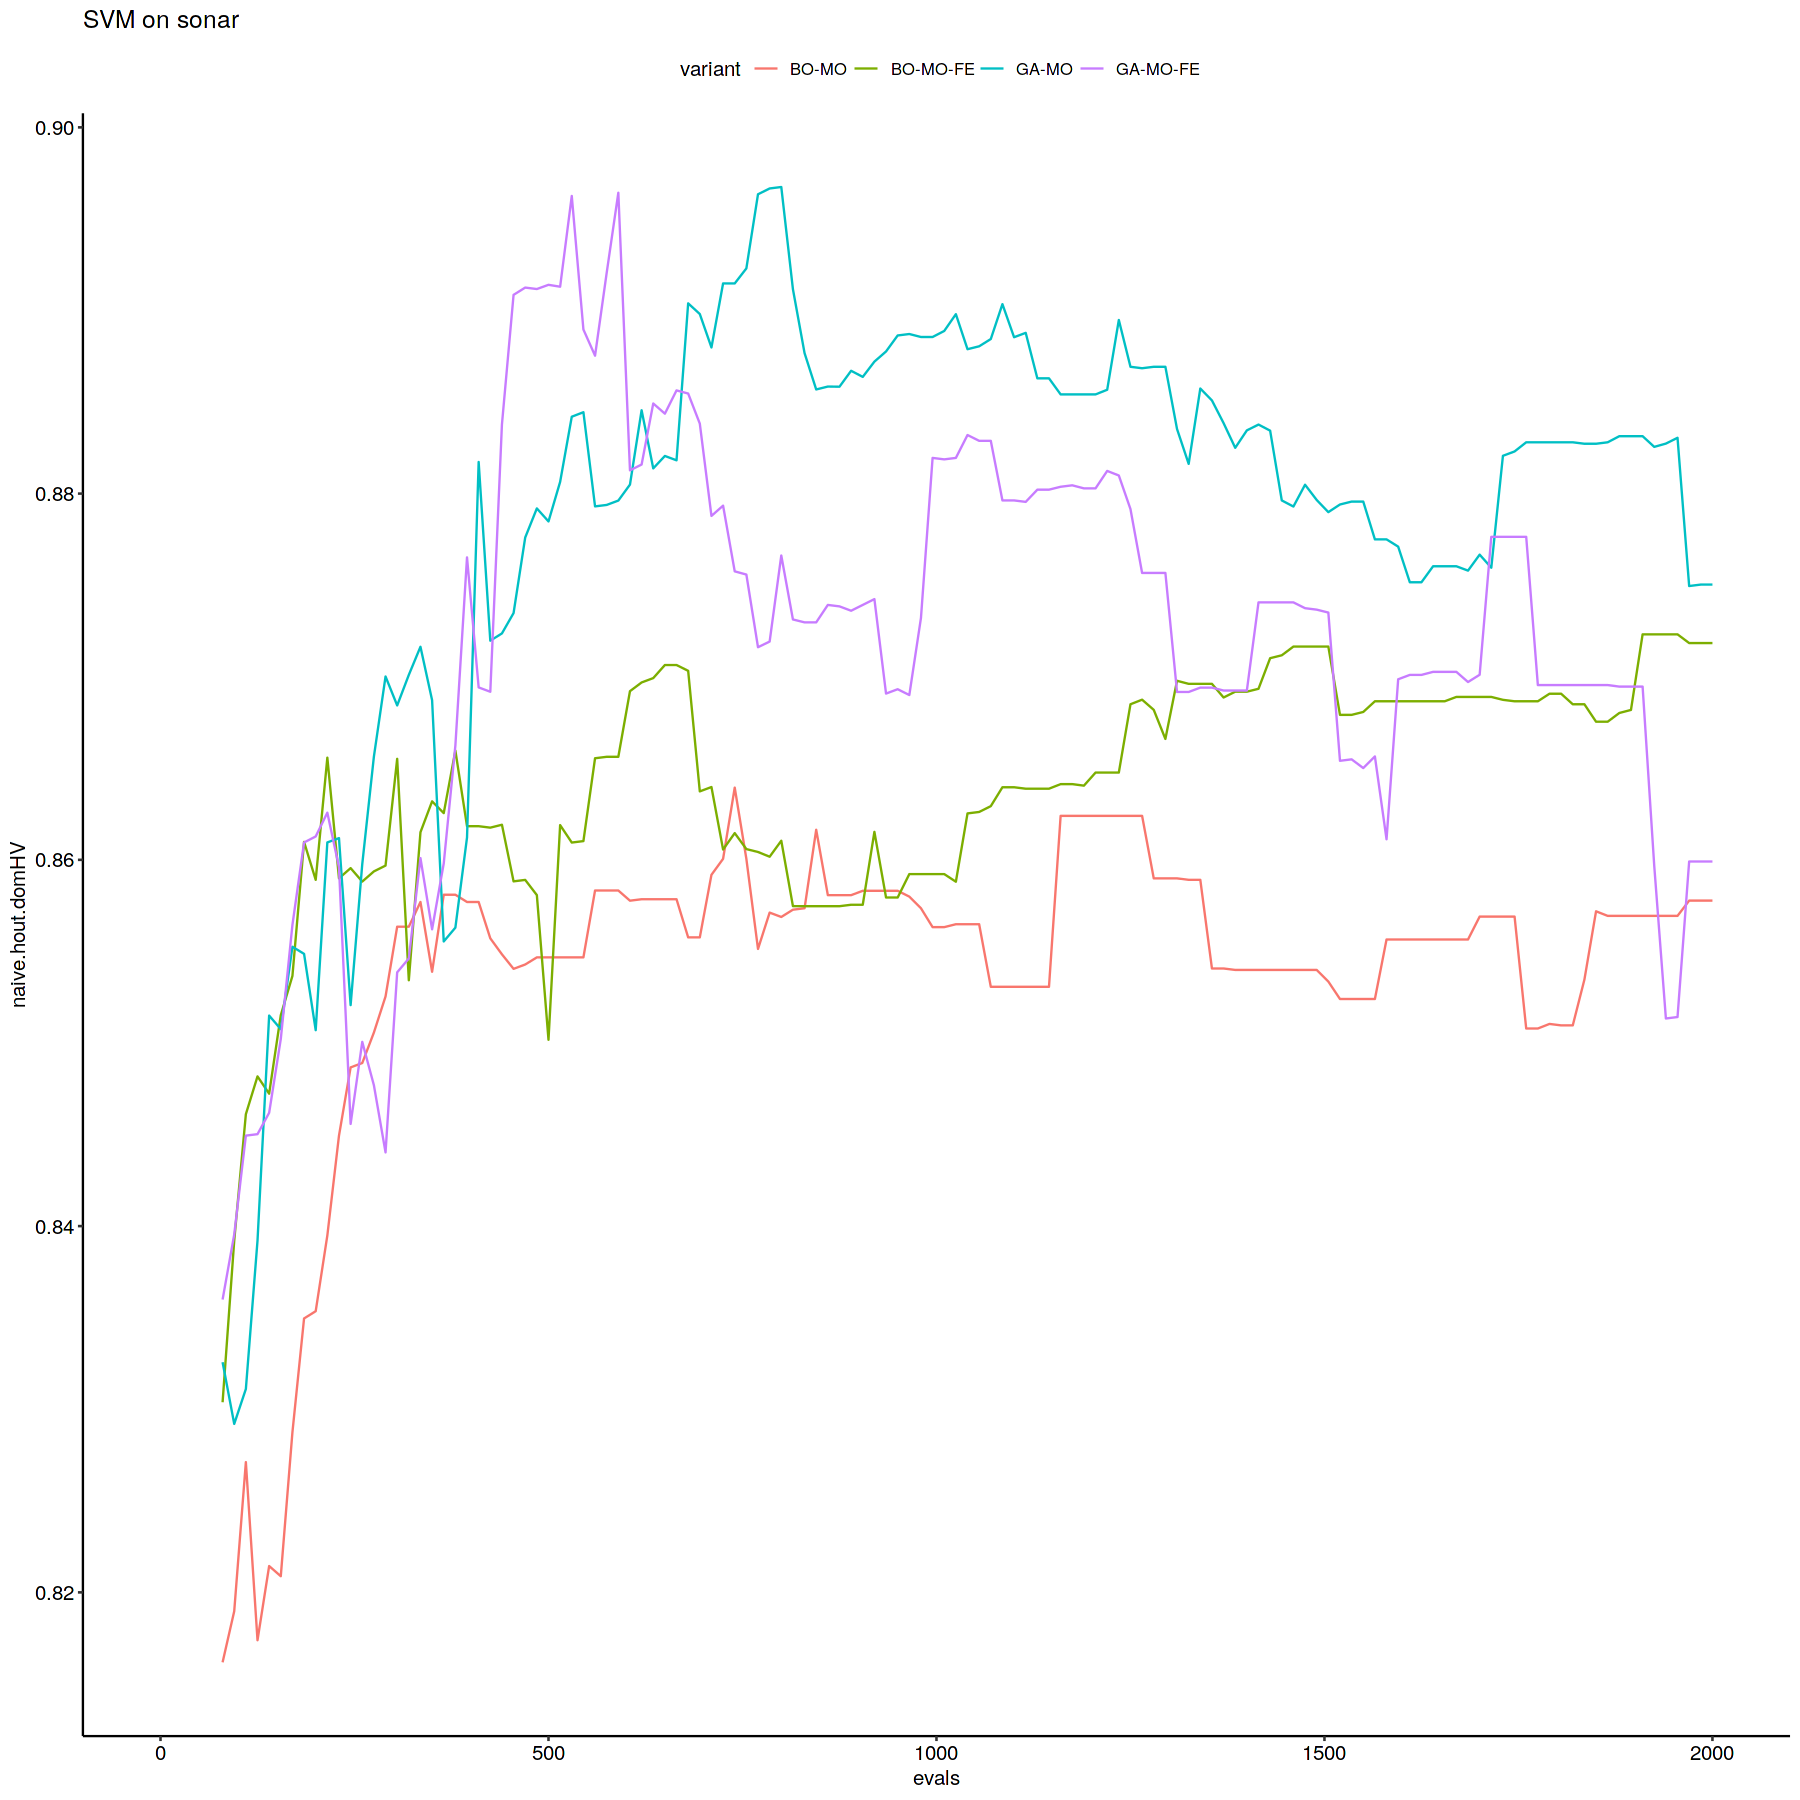

Warning message:
“Removed 268 rows containing missing values (geom_path).”


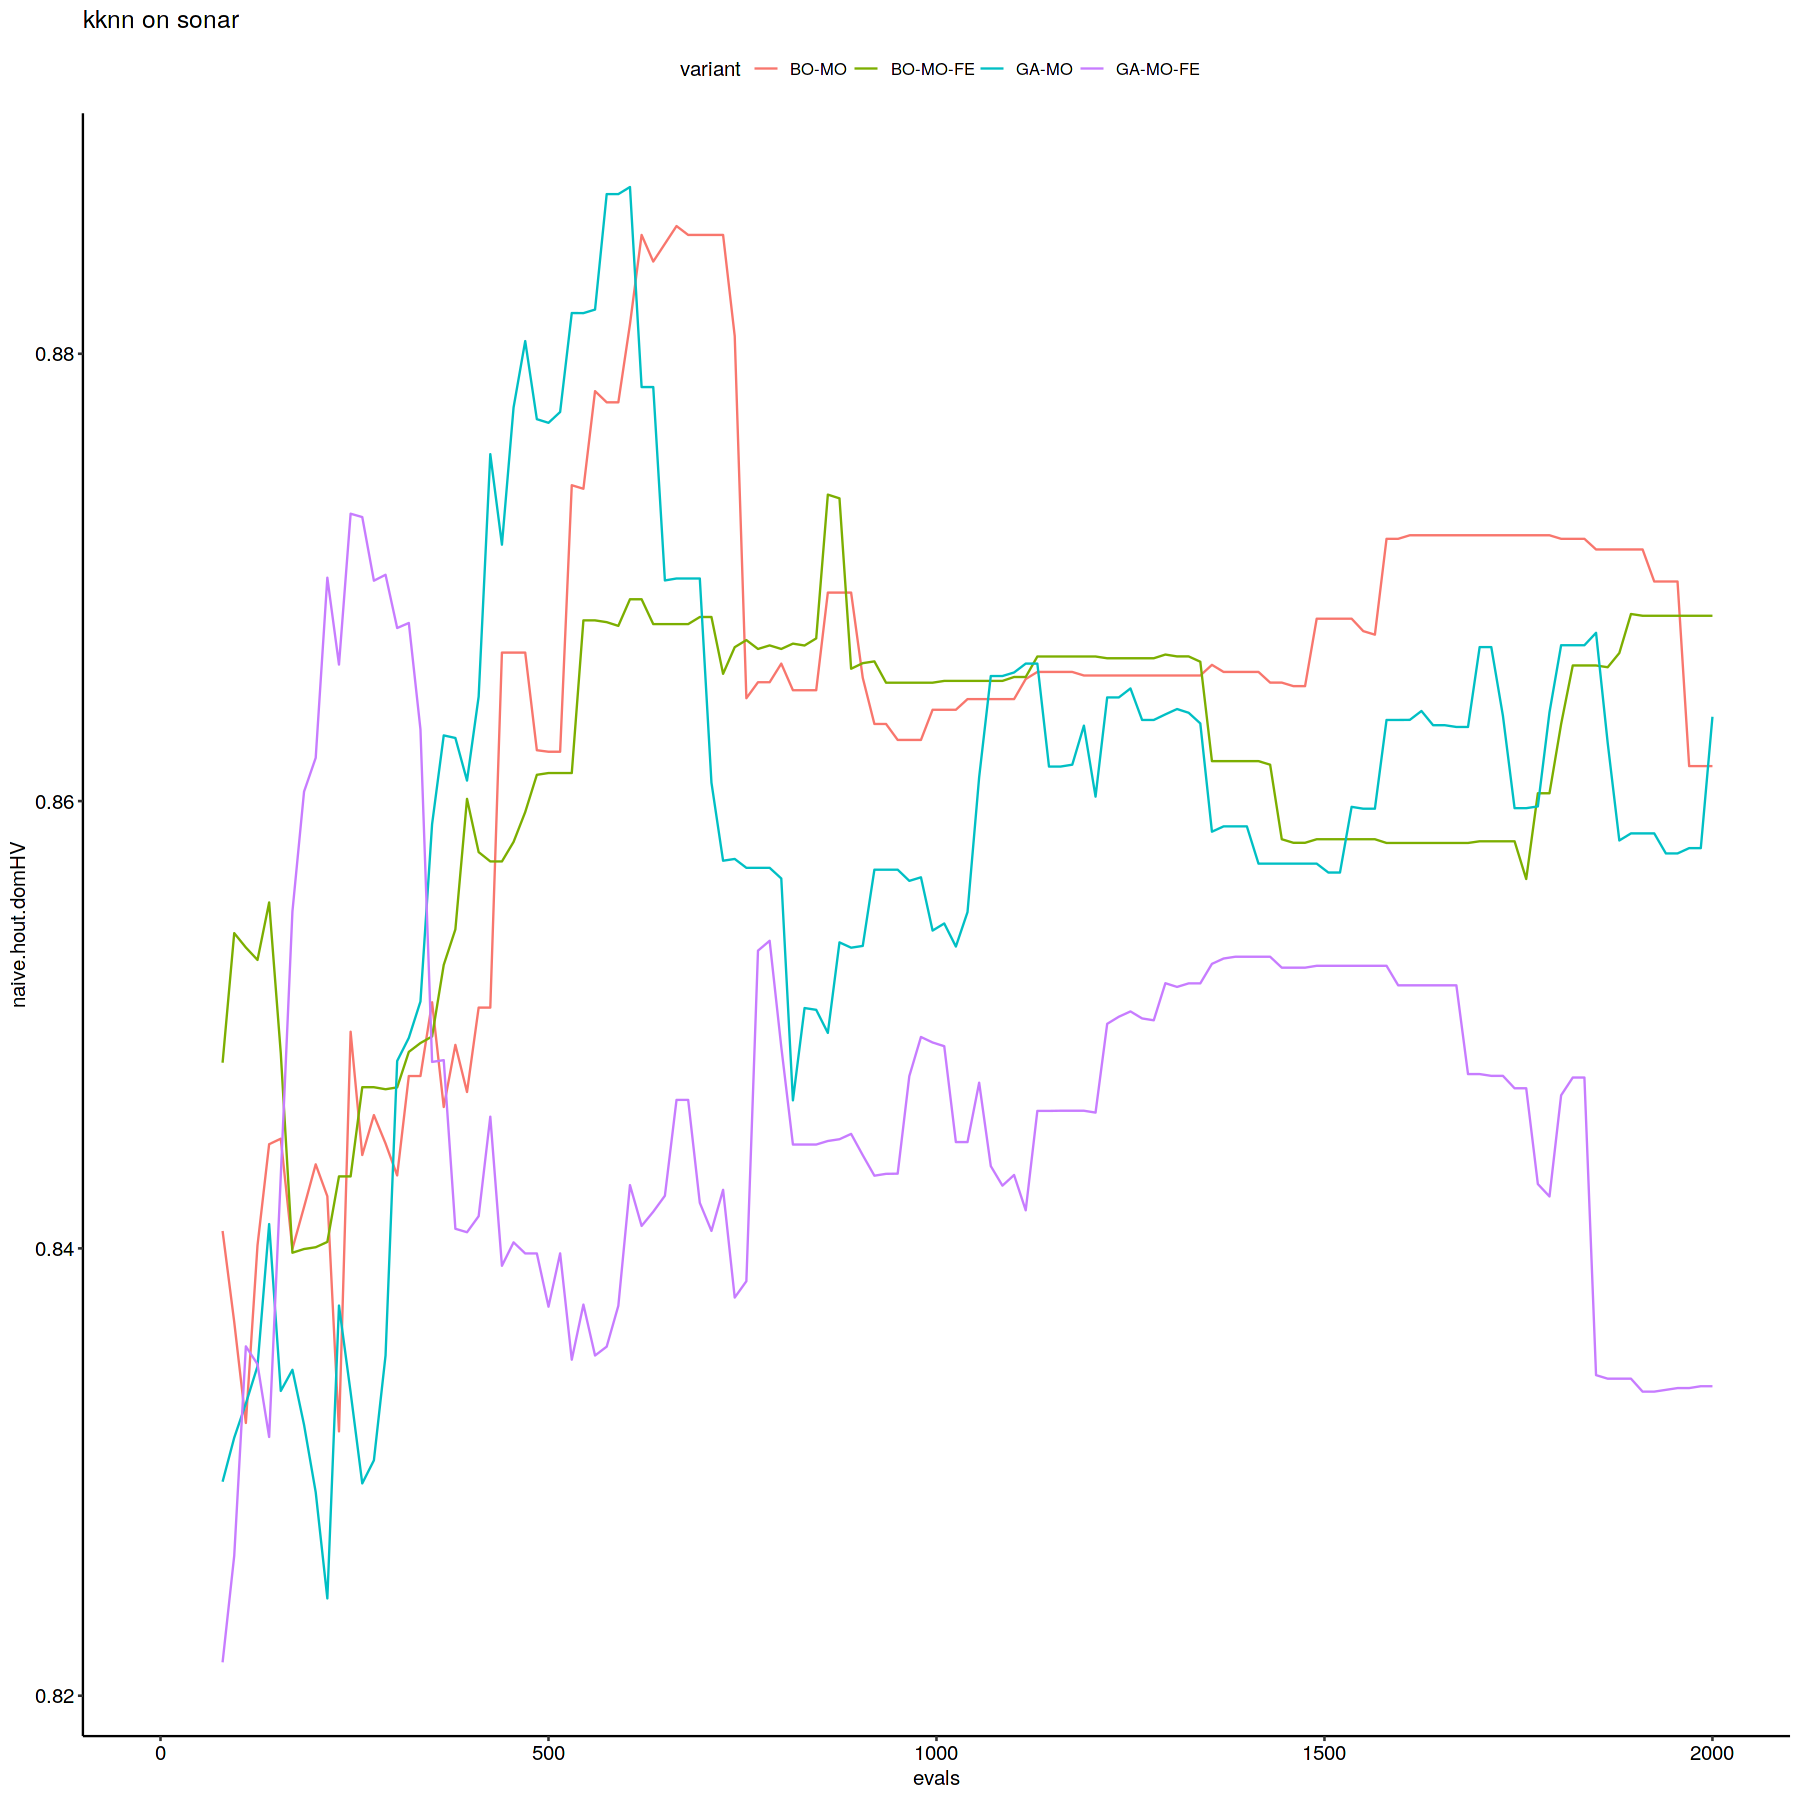

Warning message:
“Removed 269 rows containing missing values (geom_path).”


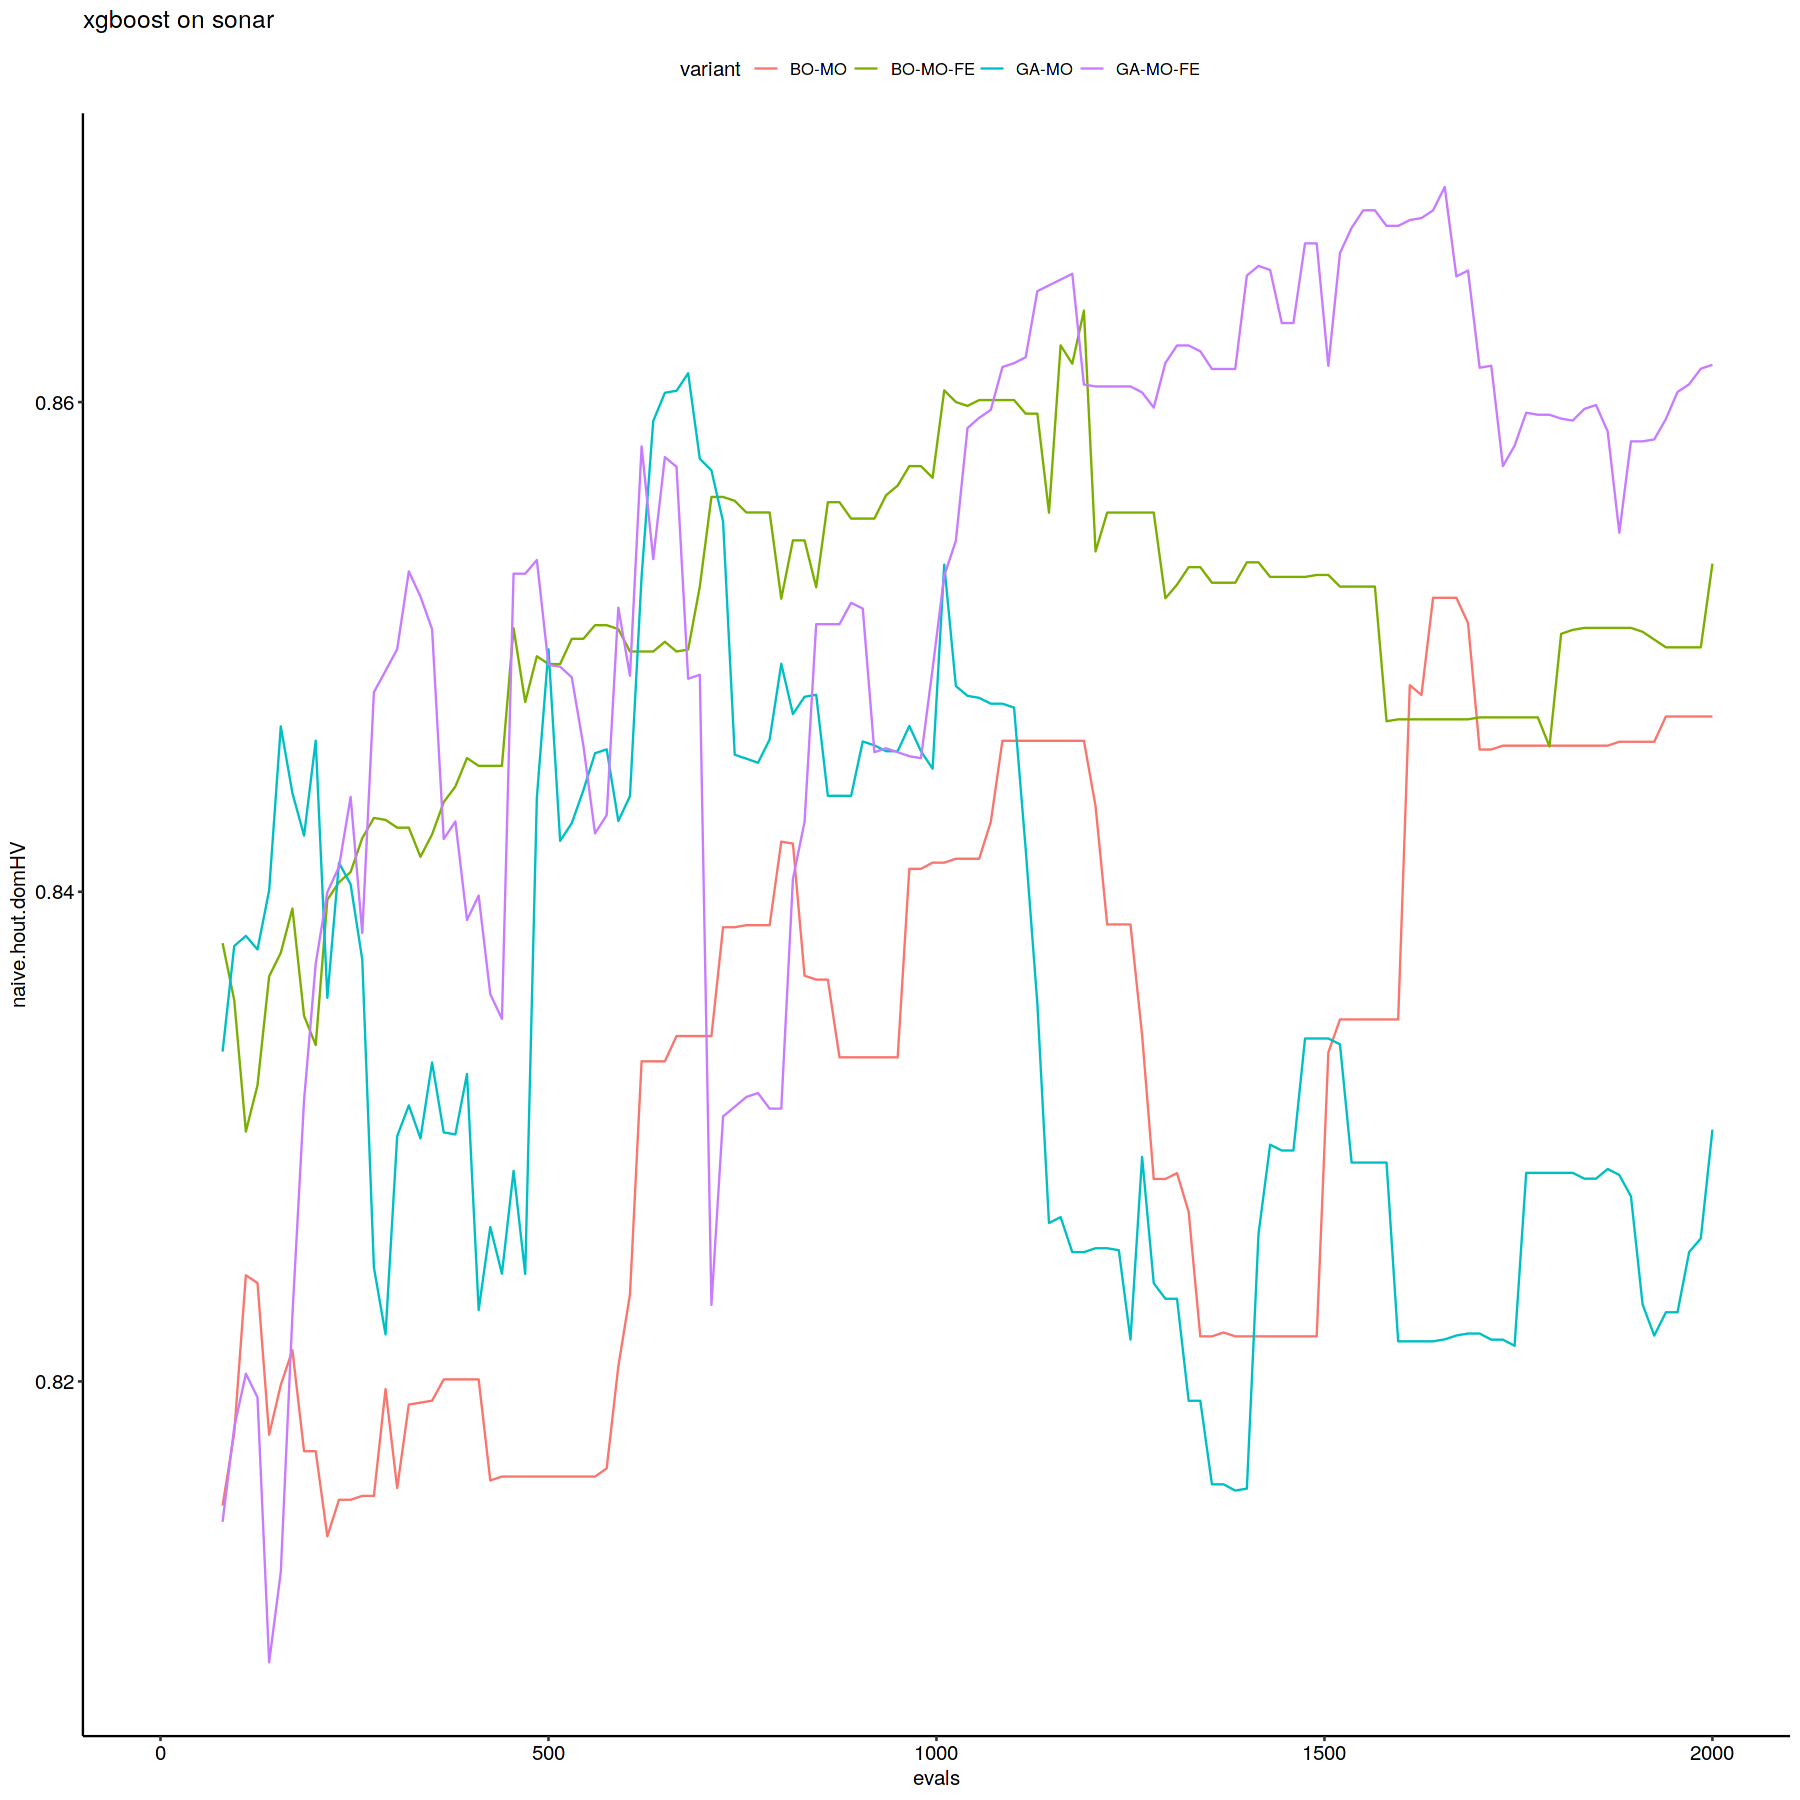

Warning message:
“Removed 268 rows containing missing values (geom_path).”


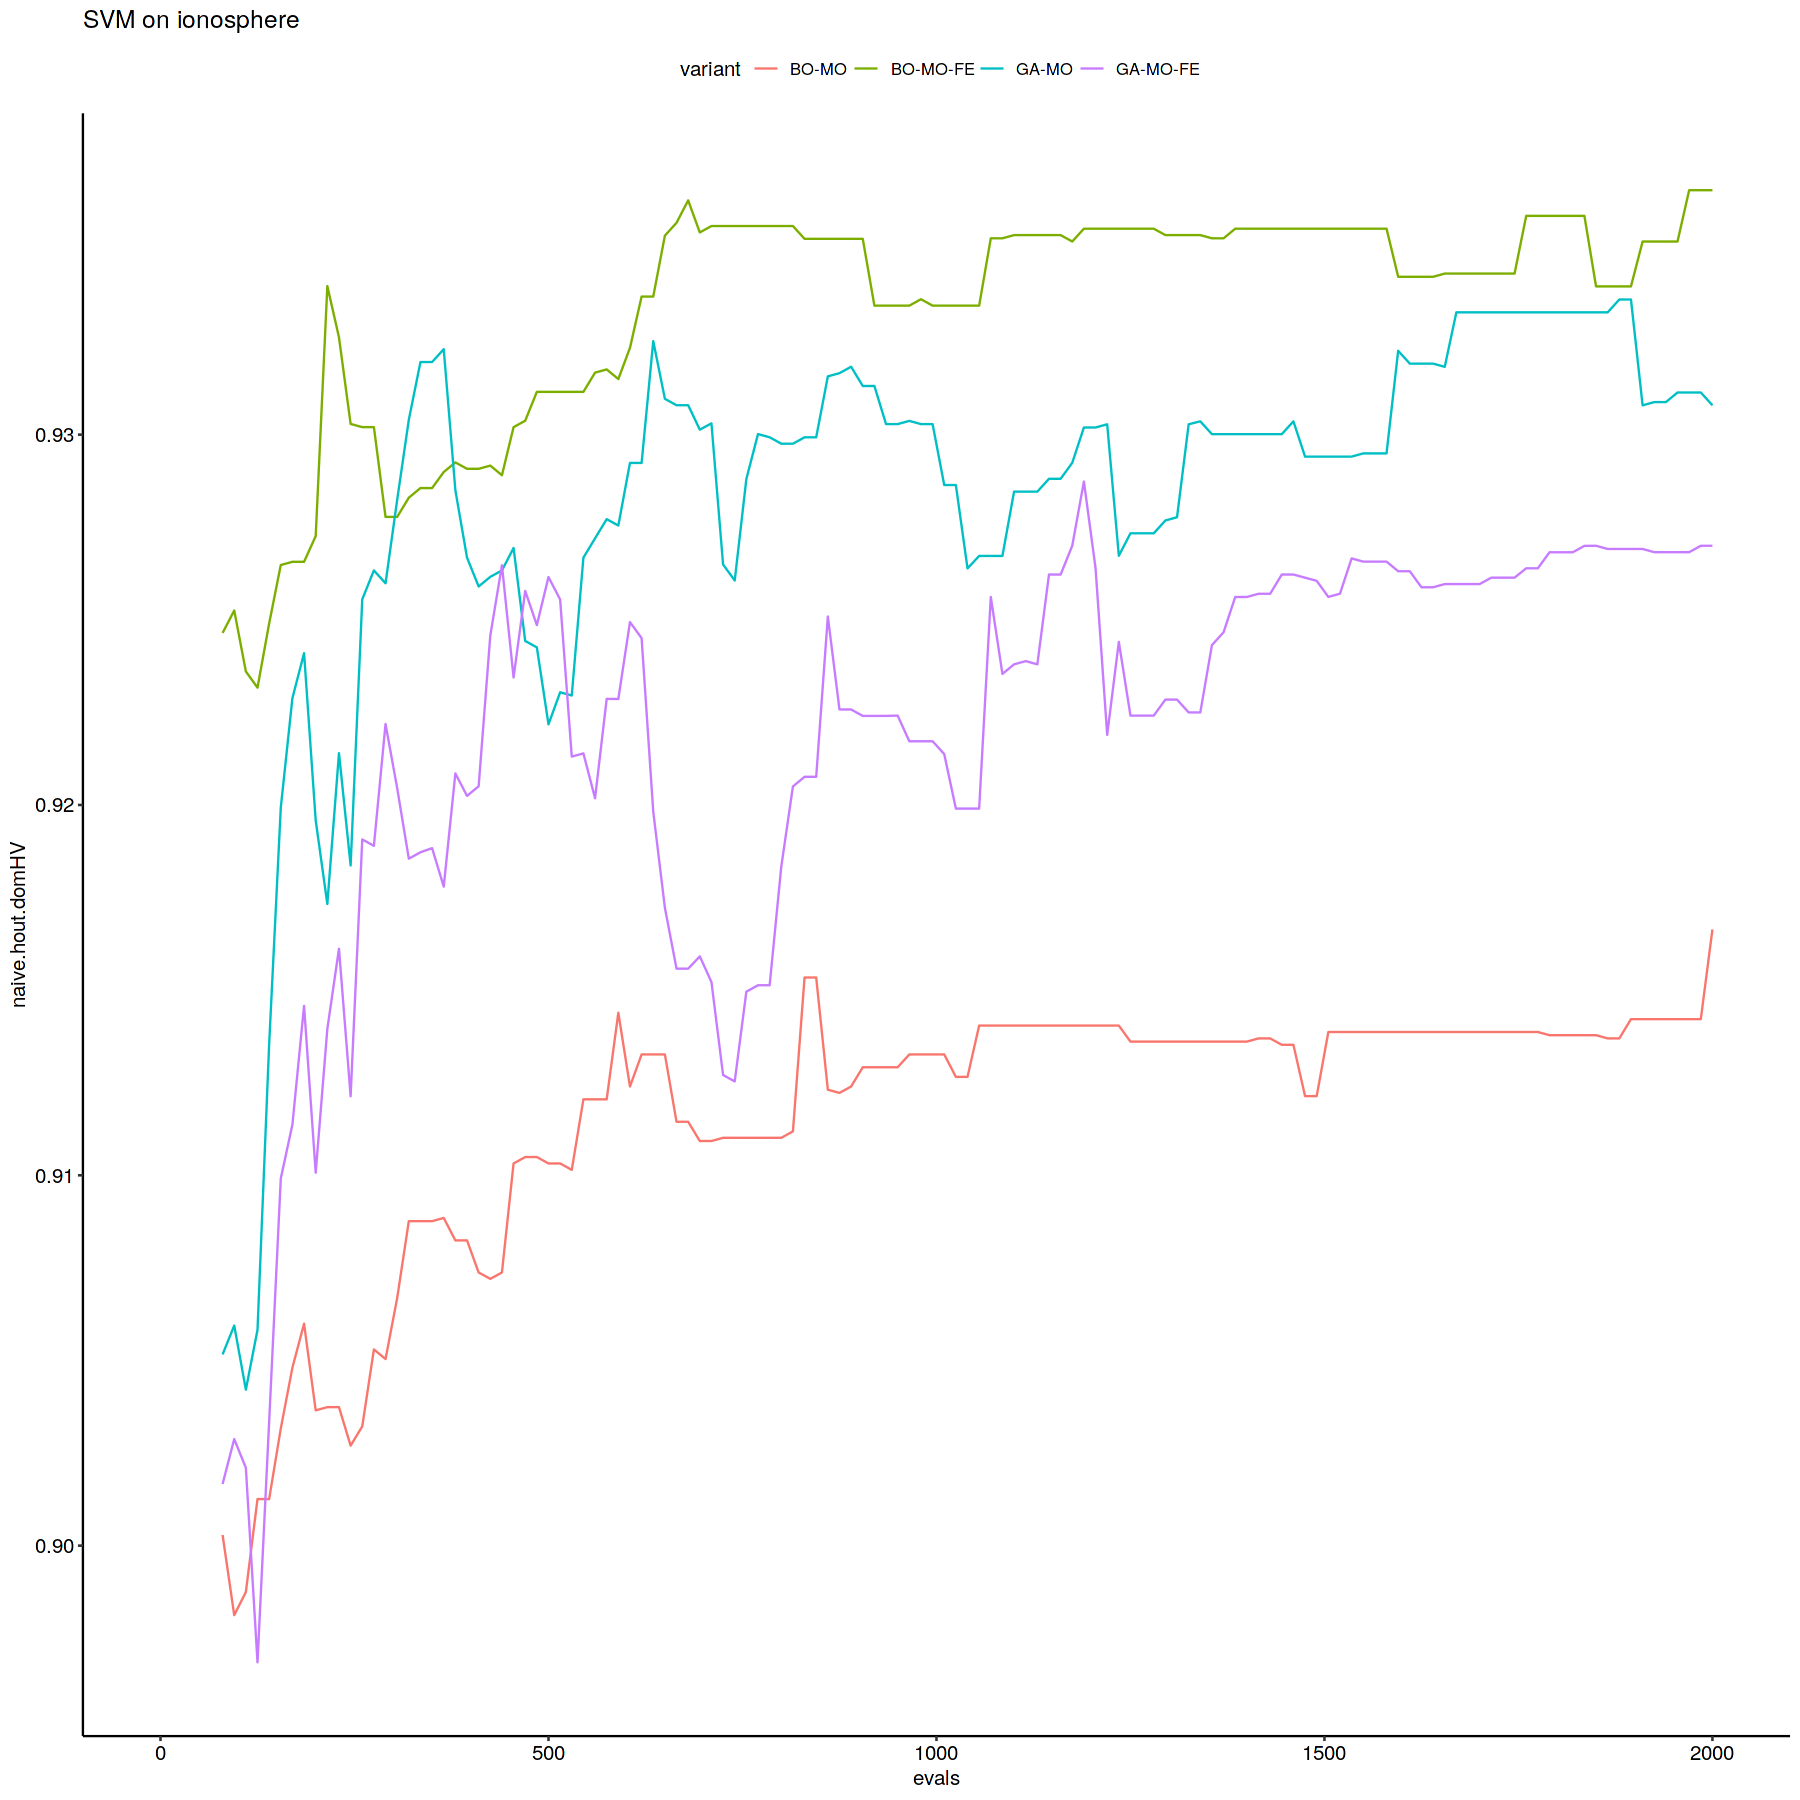

Warning message:
“Removed 268 rows containing missing values (geom_path).”


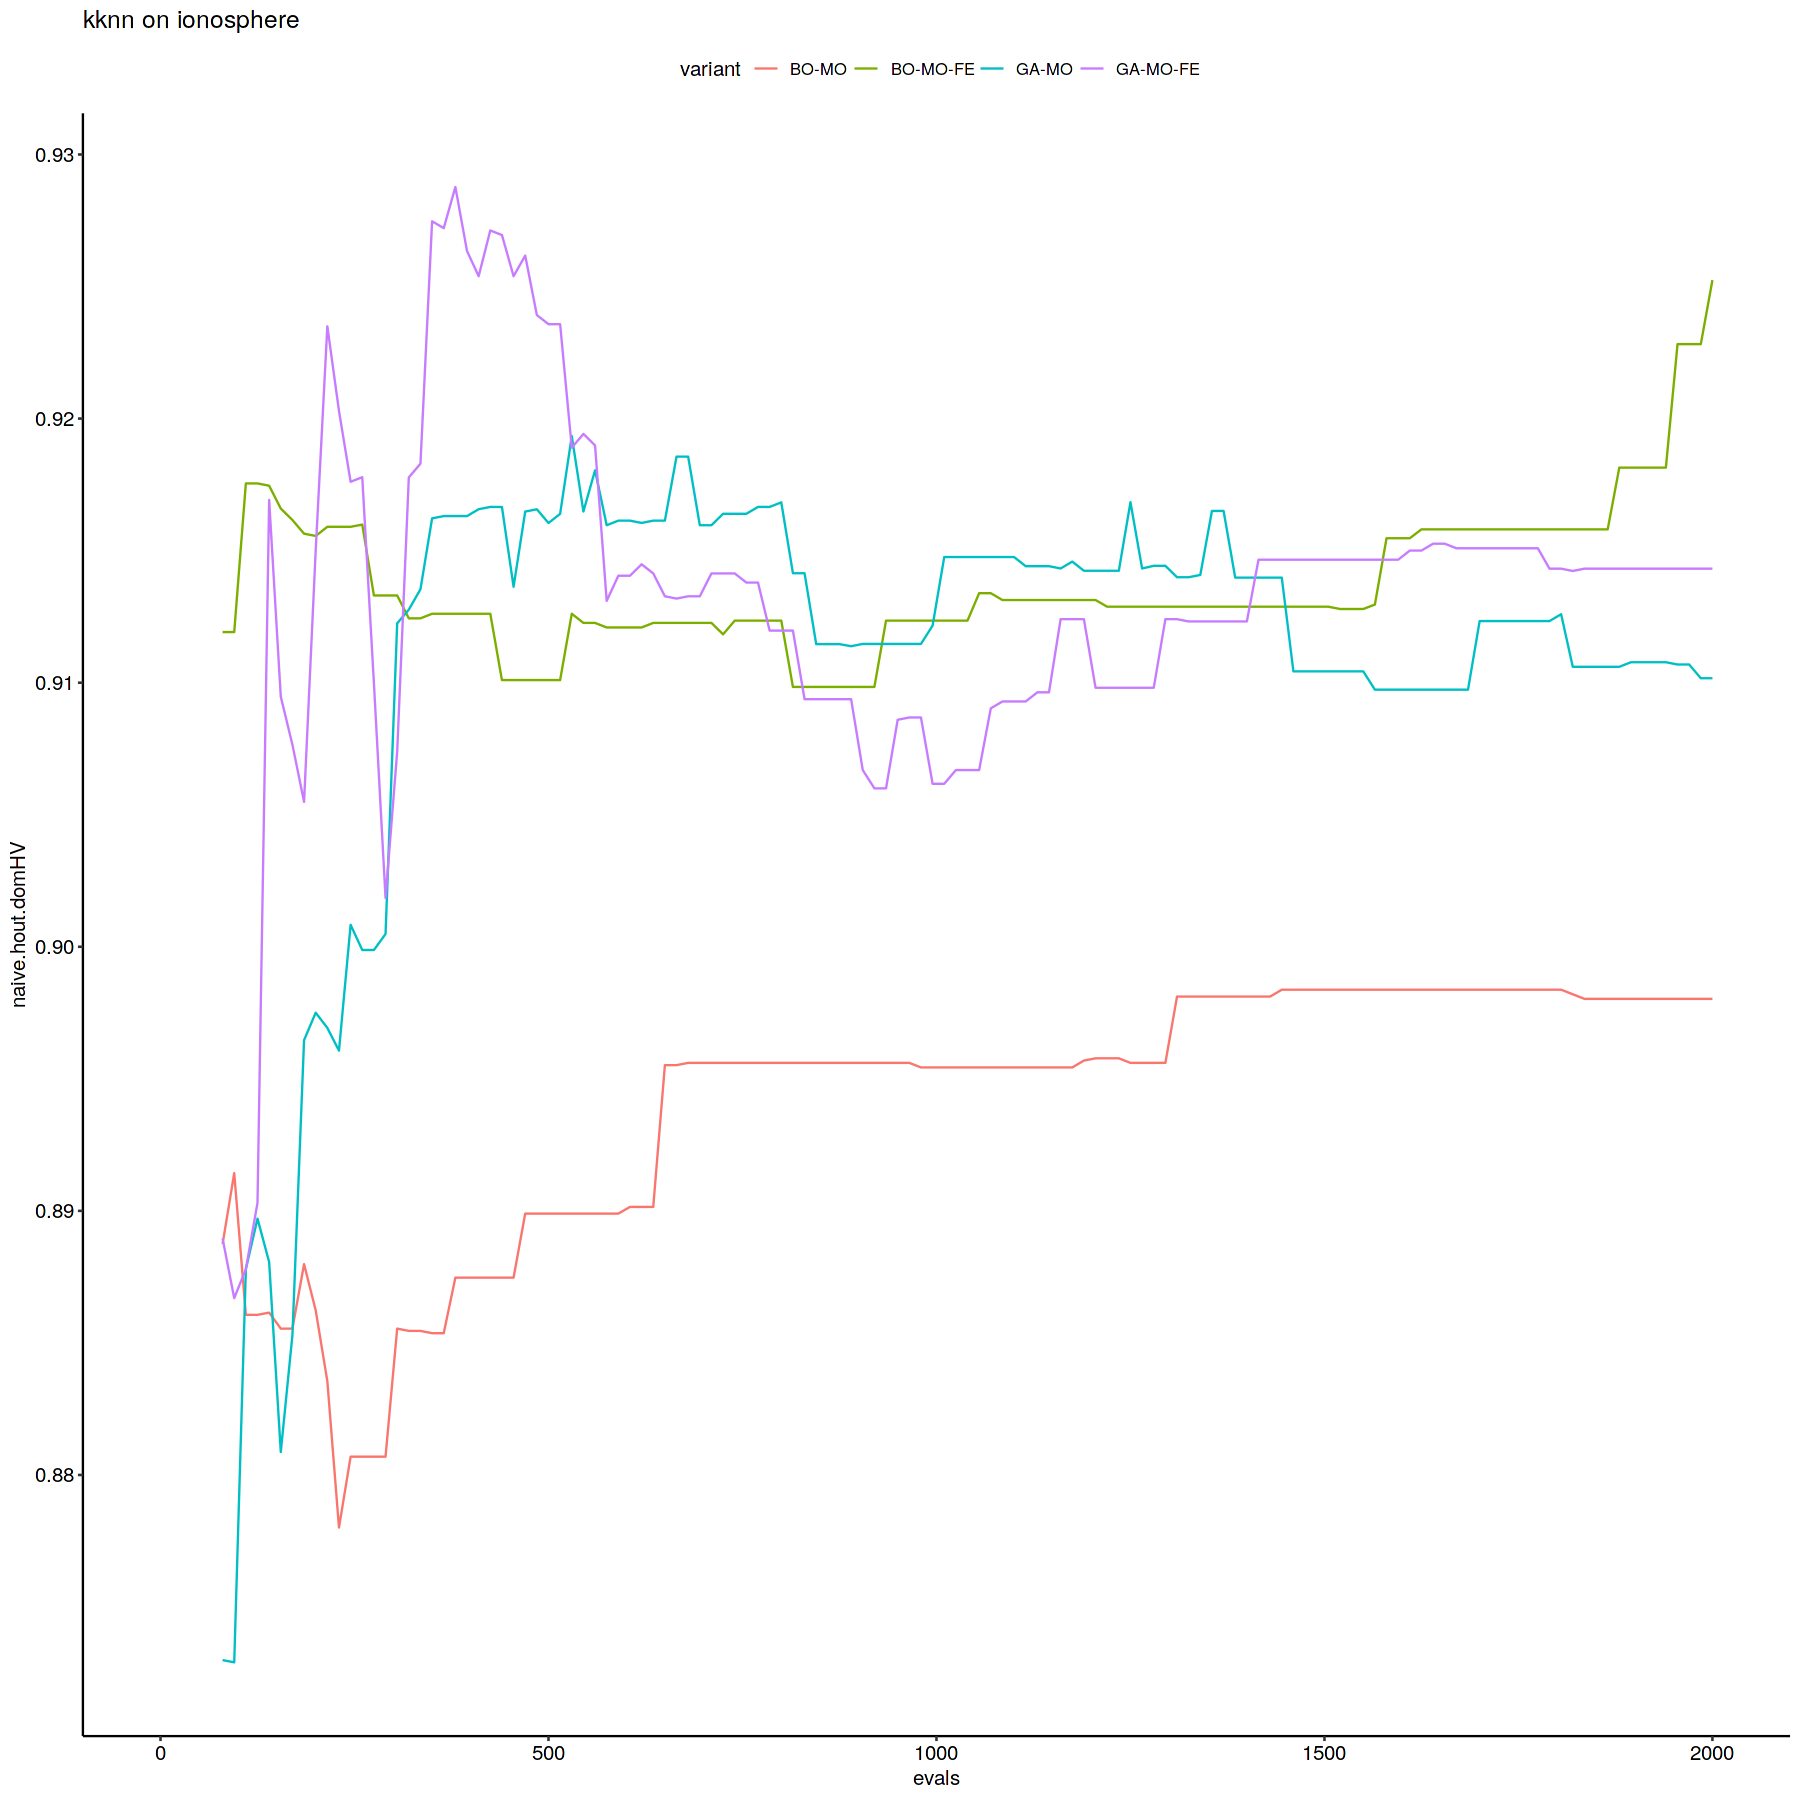

Warning message:
“Removed 269 rows containing missing values (geom_path).”


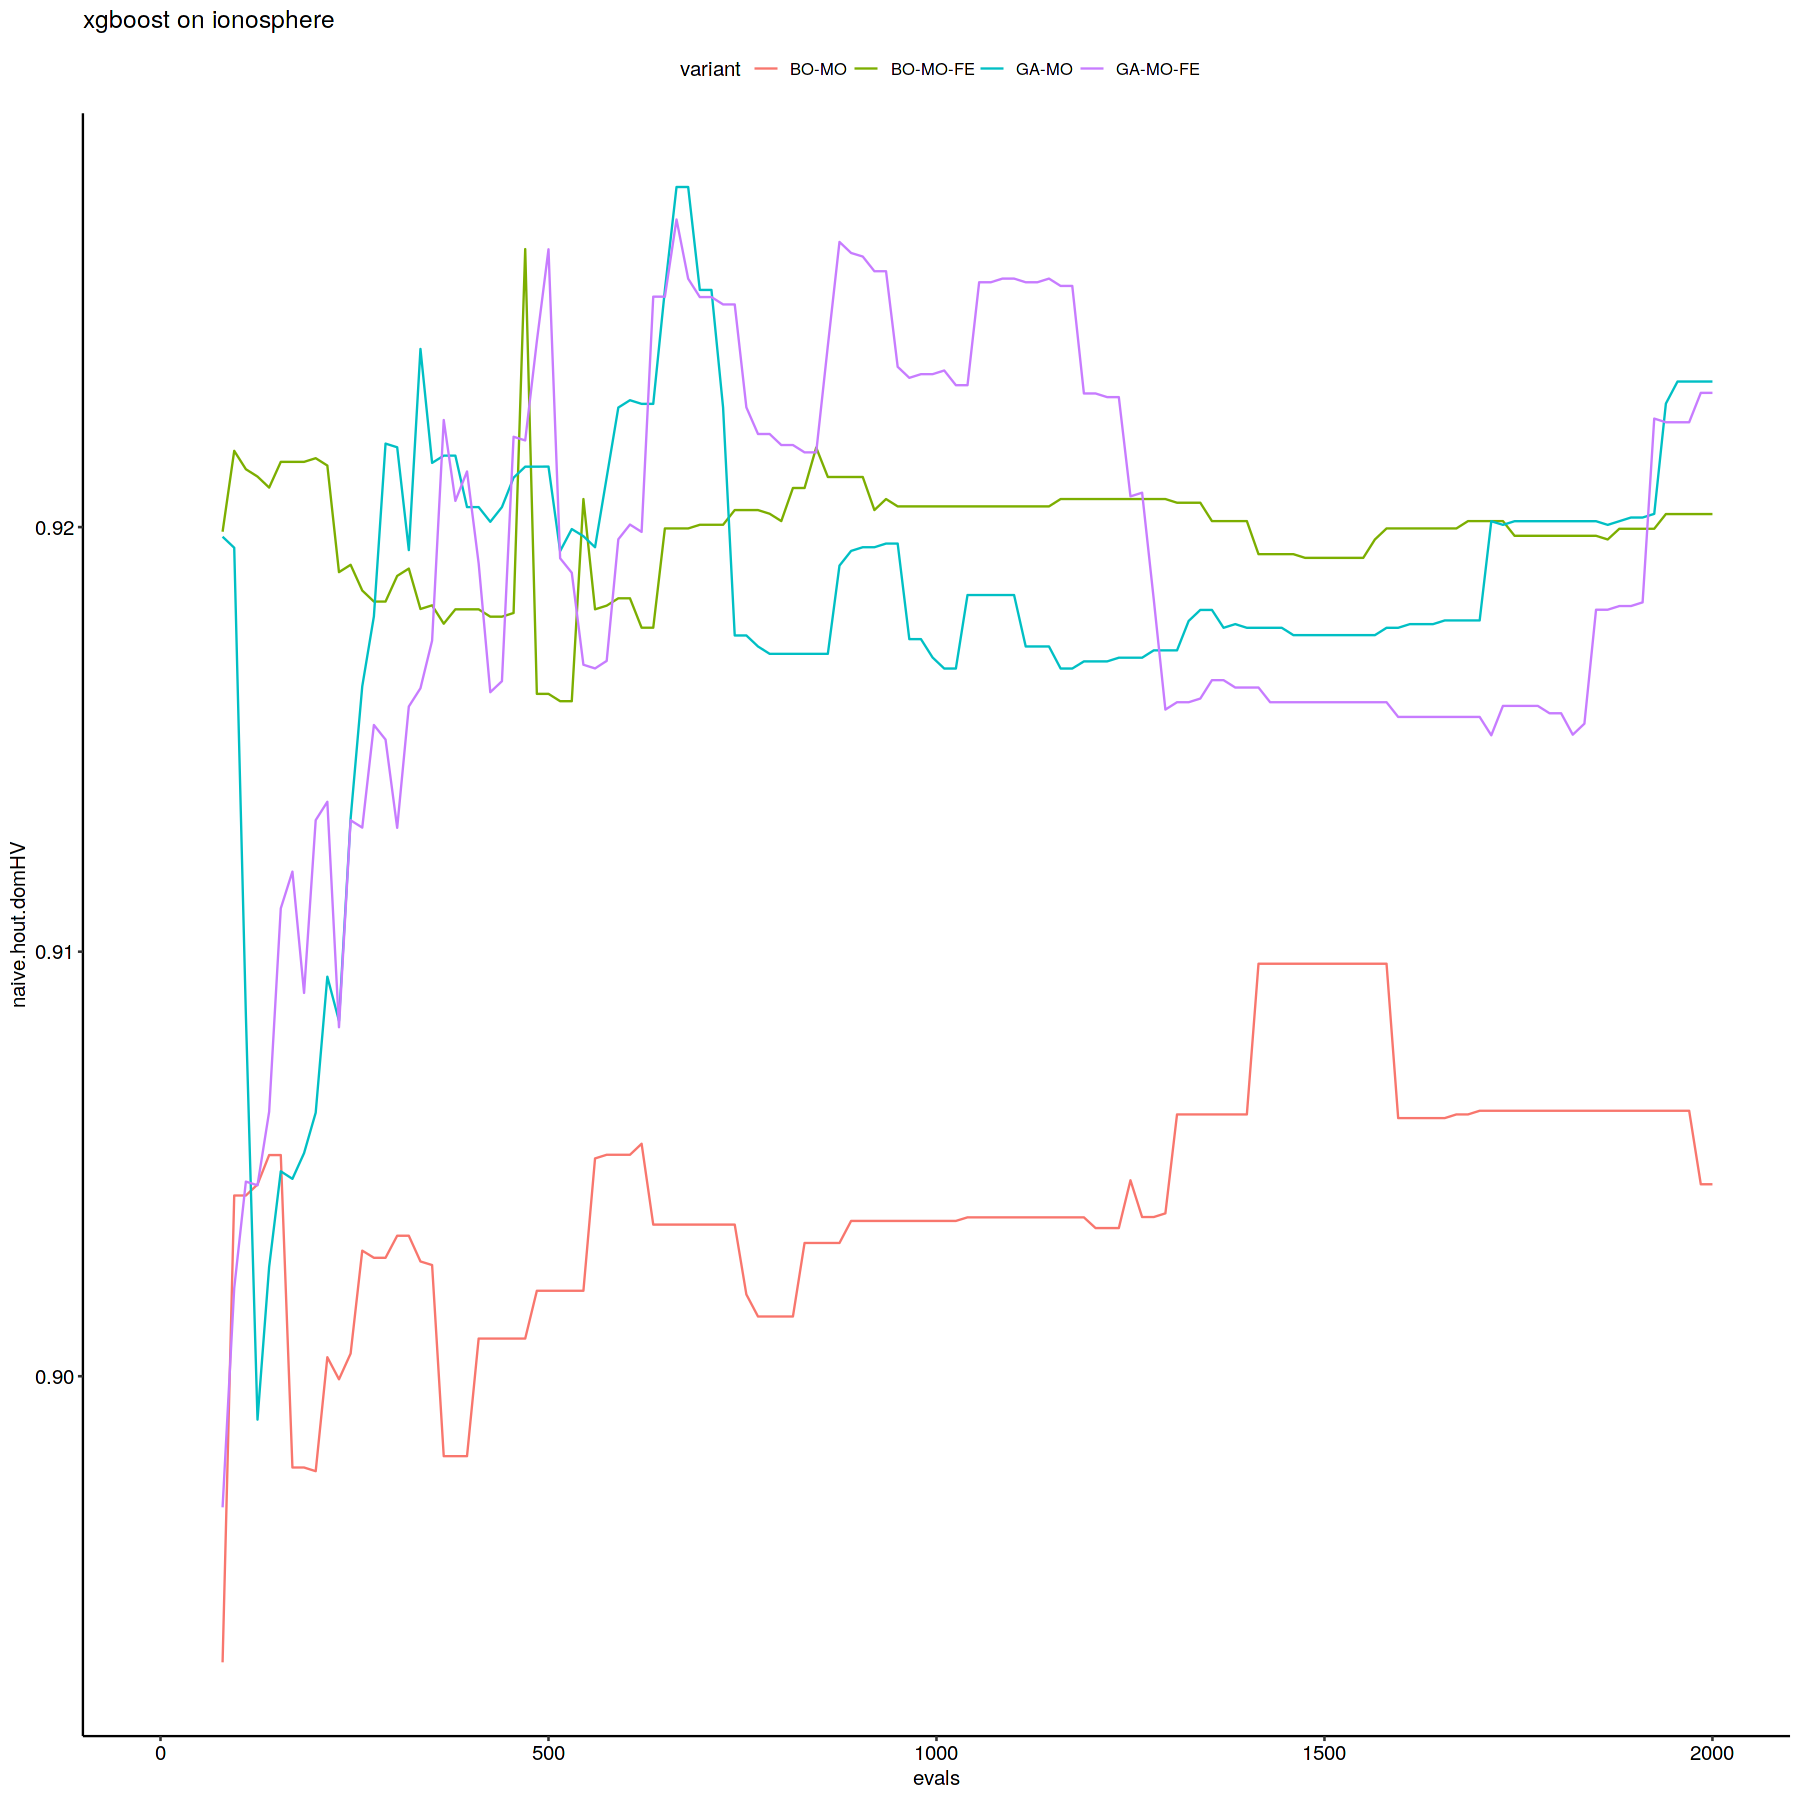

Warning message:
“Removed 268 rows containing missing values (geom_path).”


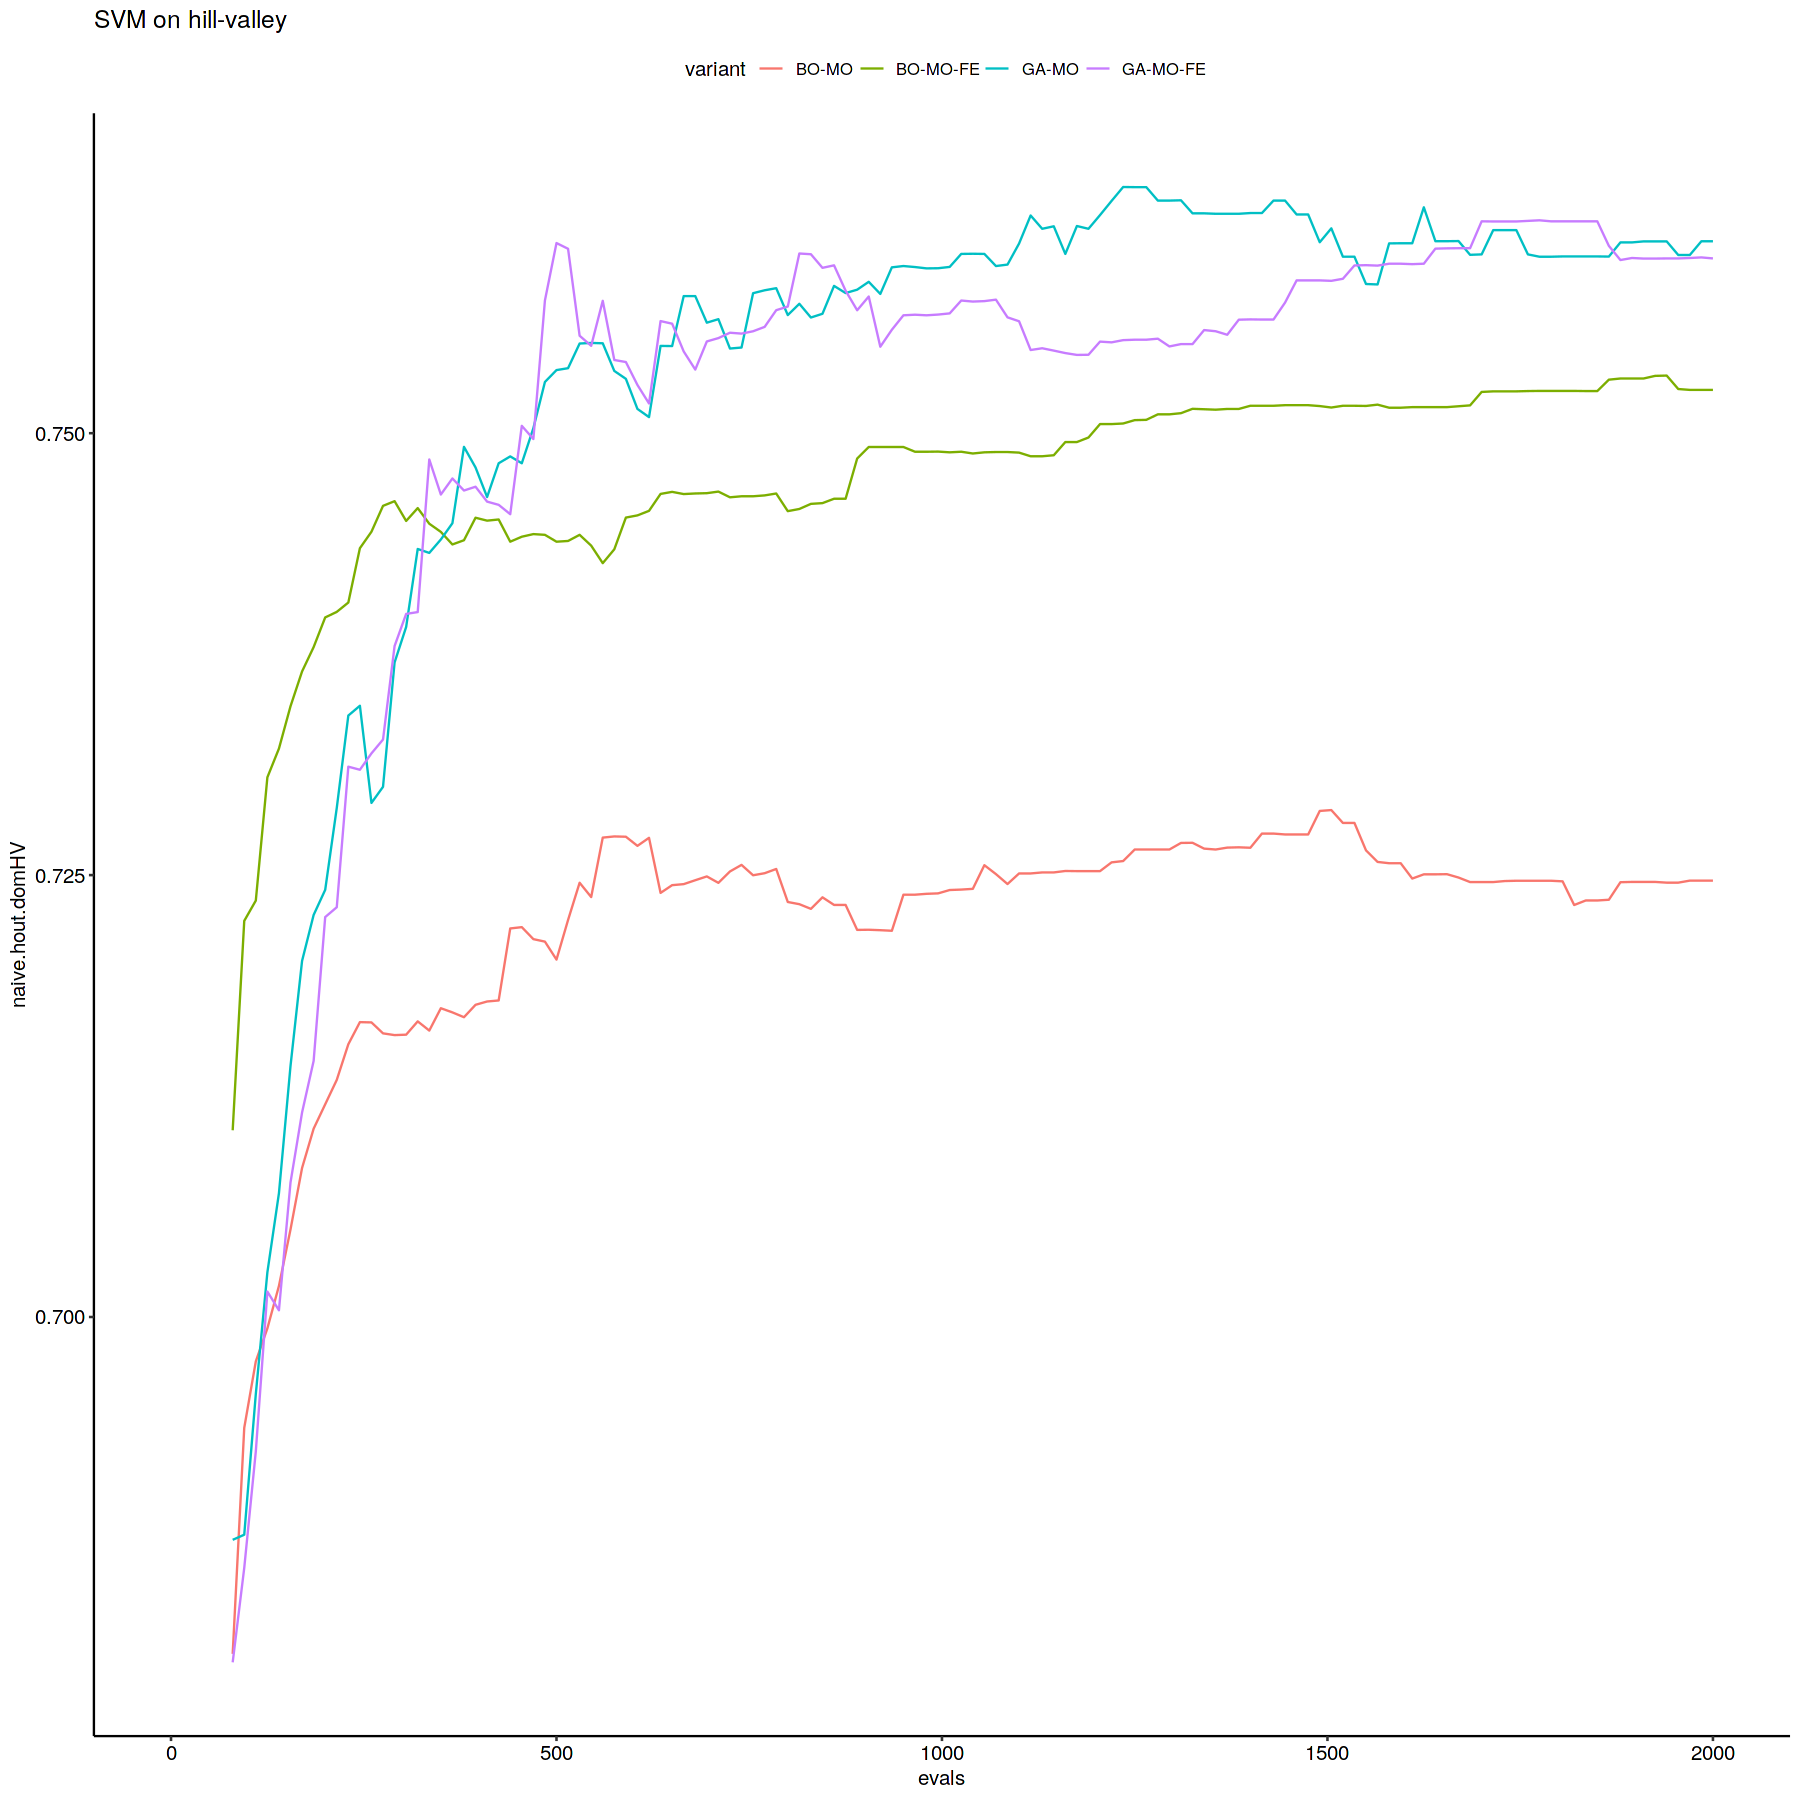

Warning message:
“Removed 268 rows containing missing values (geom_path).”


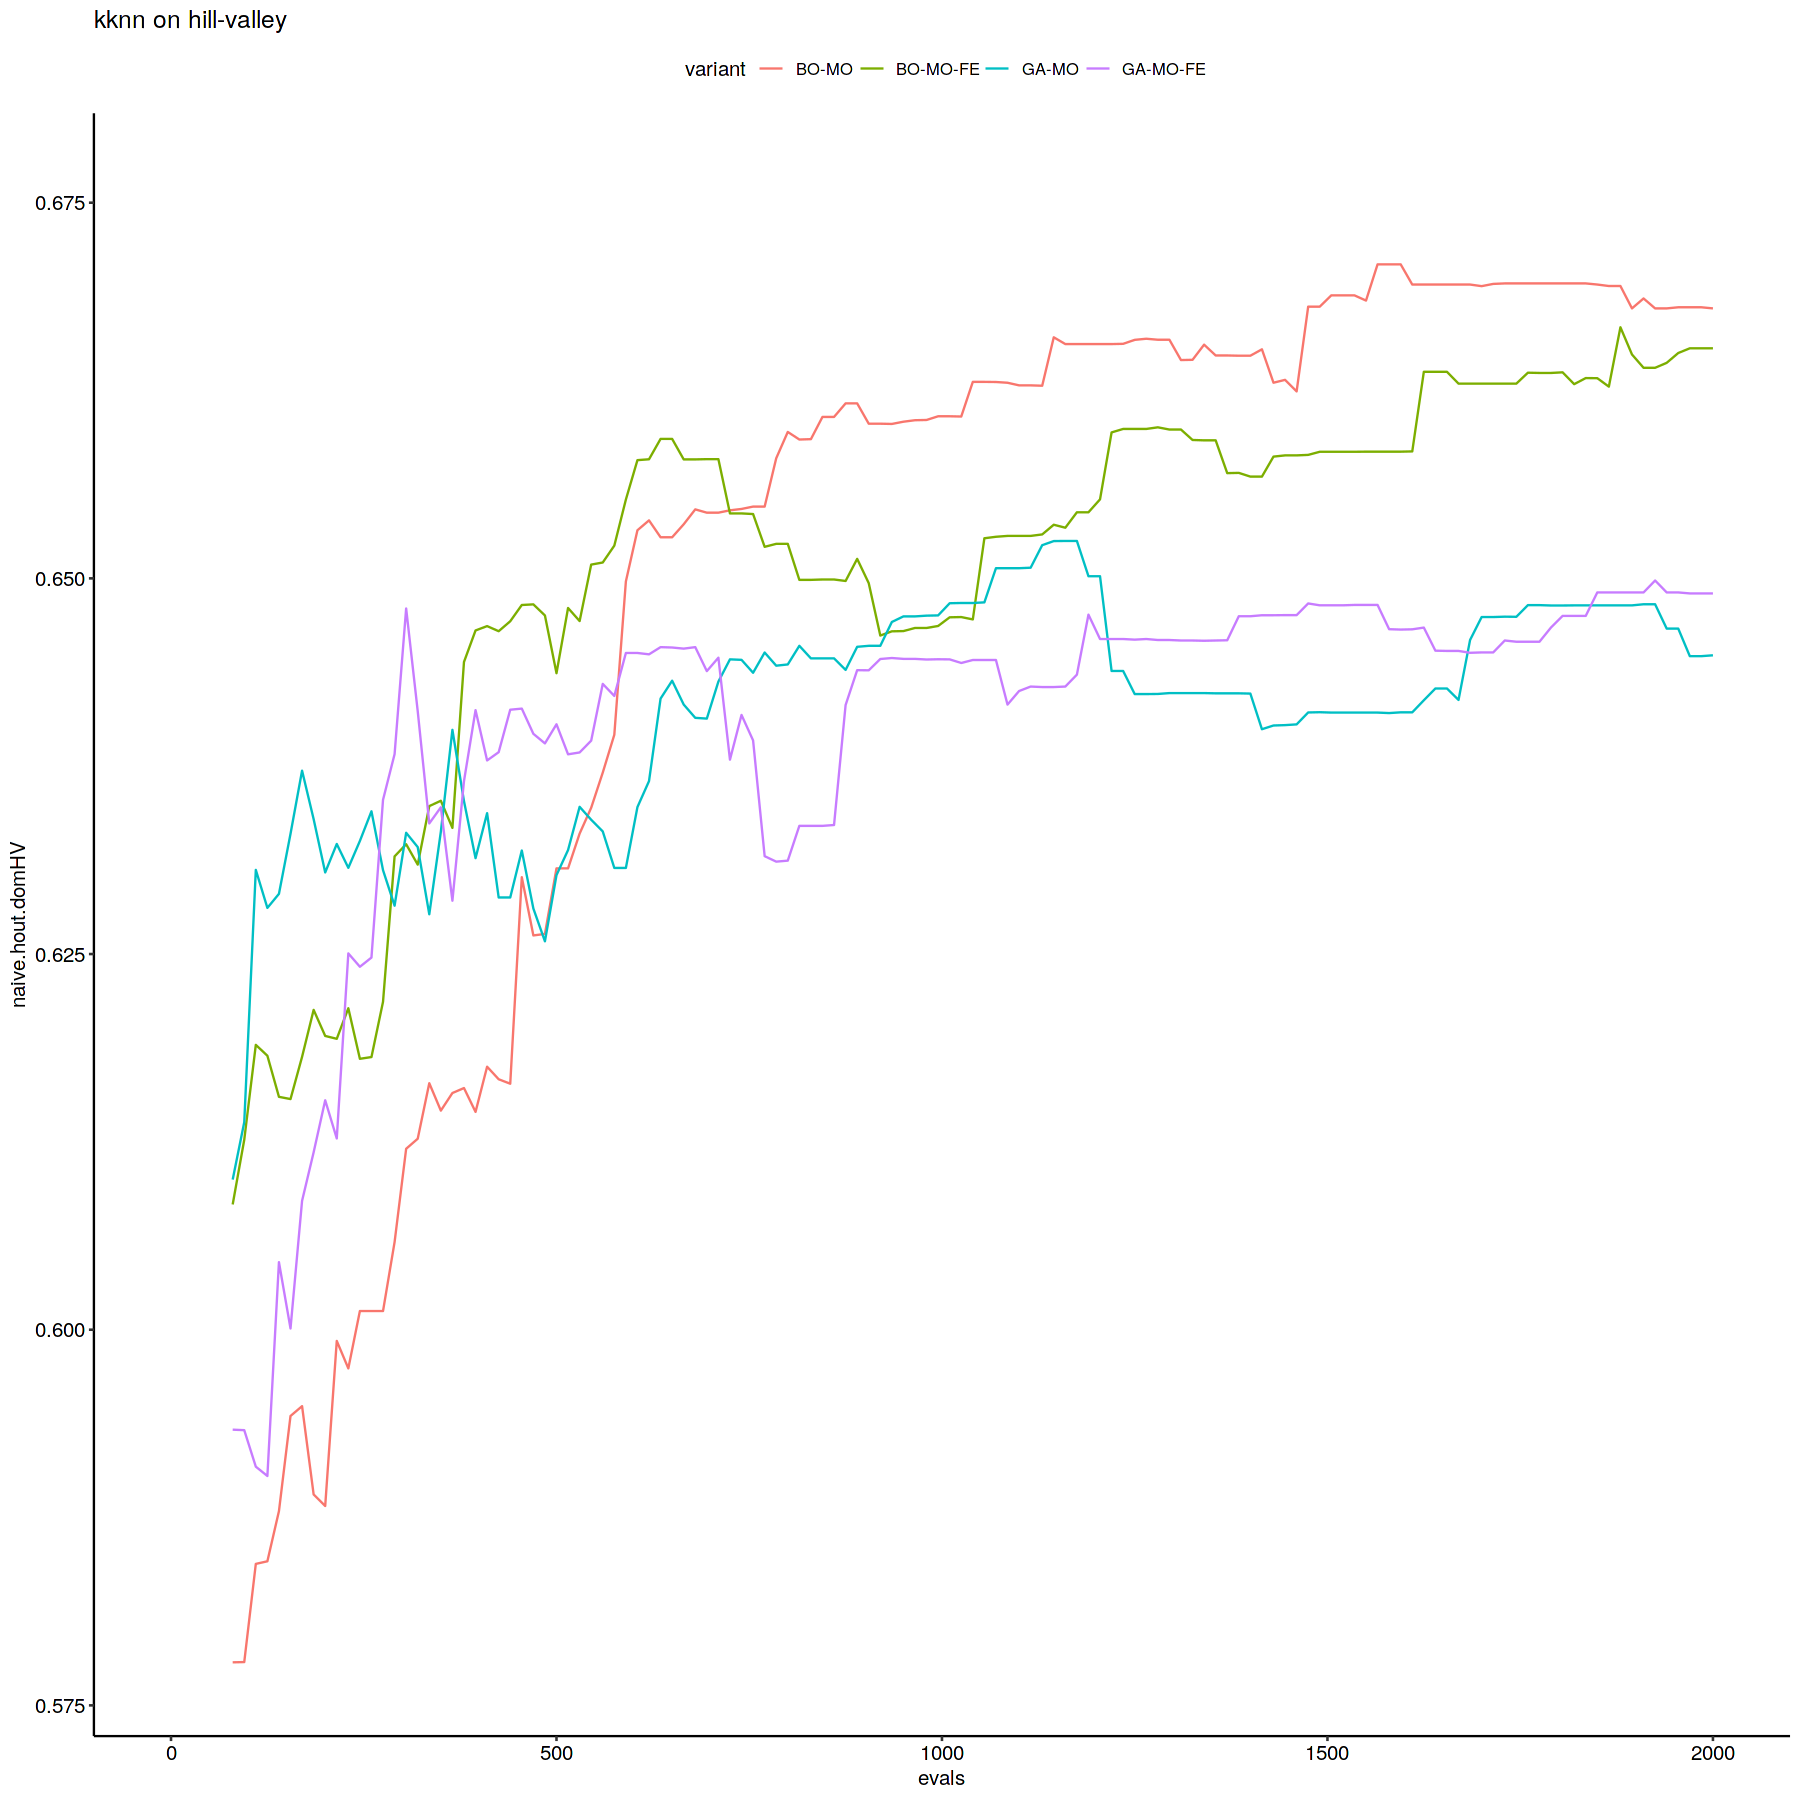

Warning message:
“Removed 269 rows containing missing values (geom_path).”


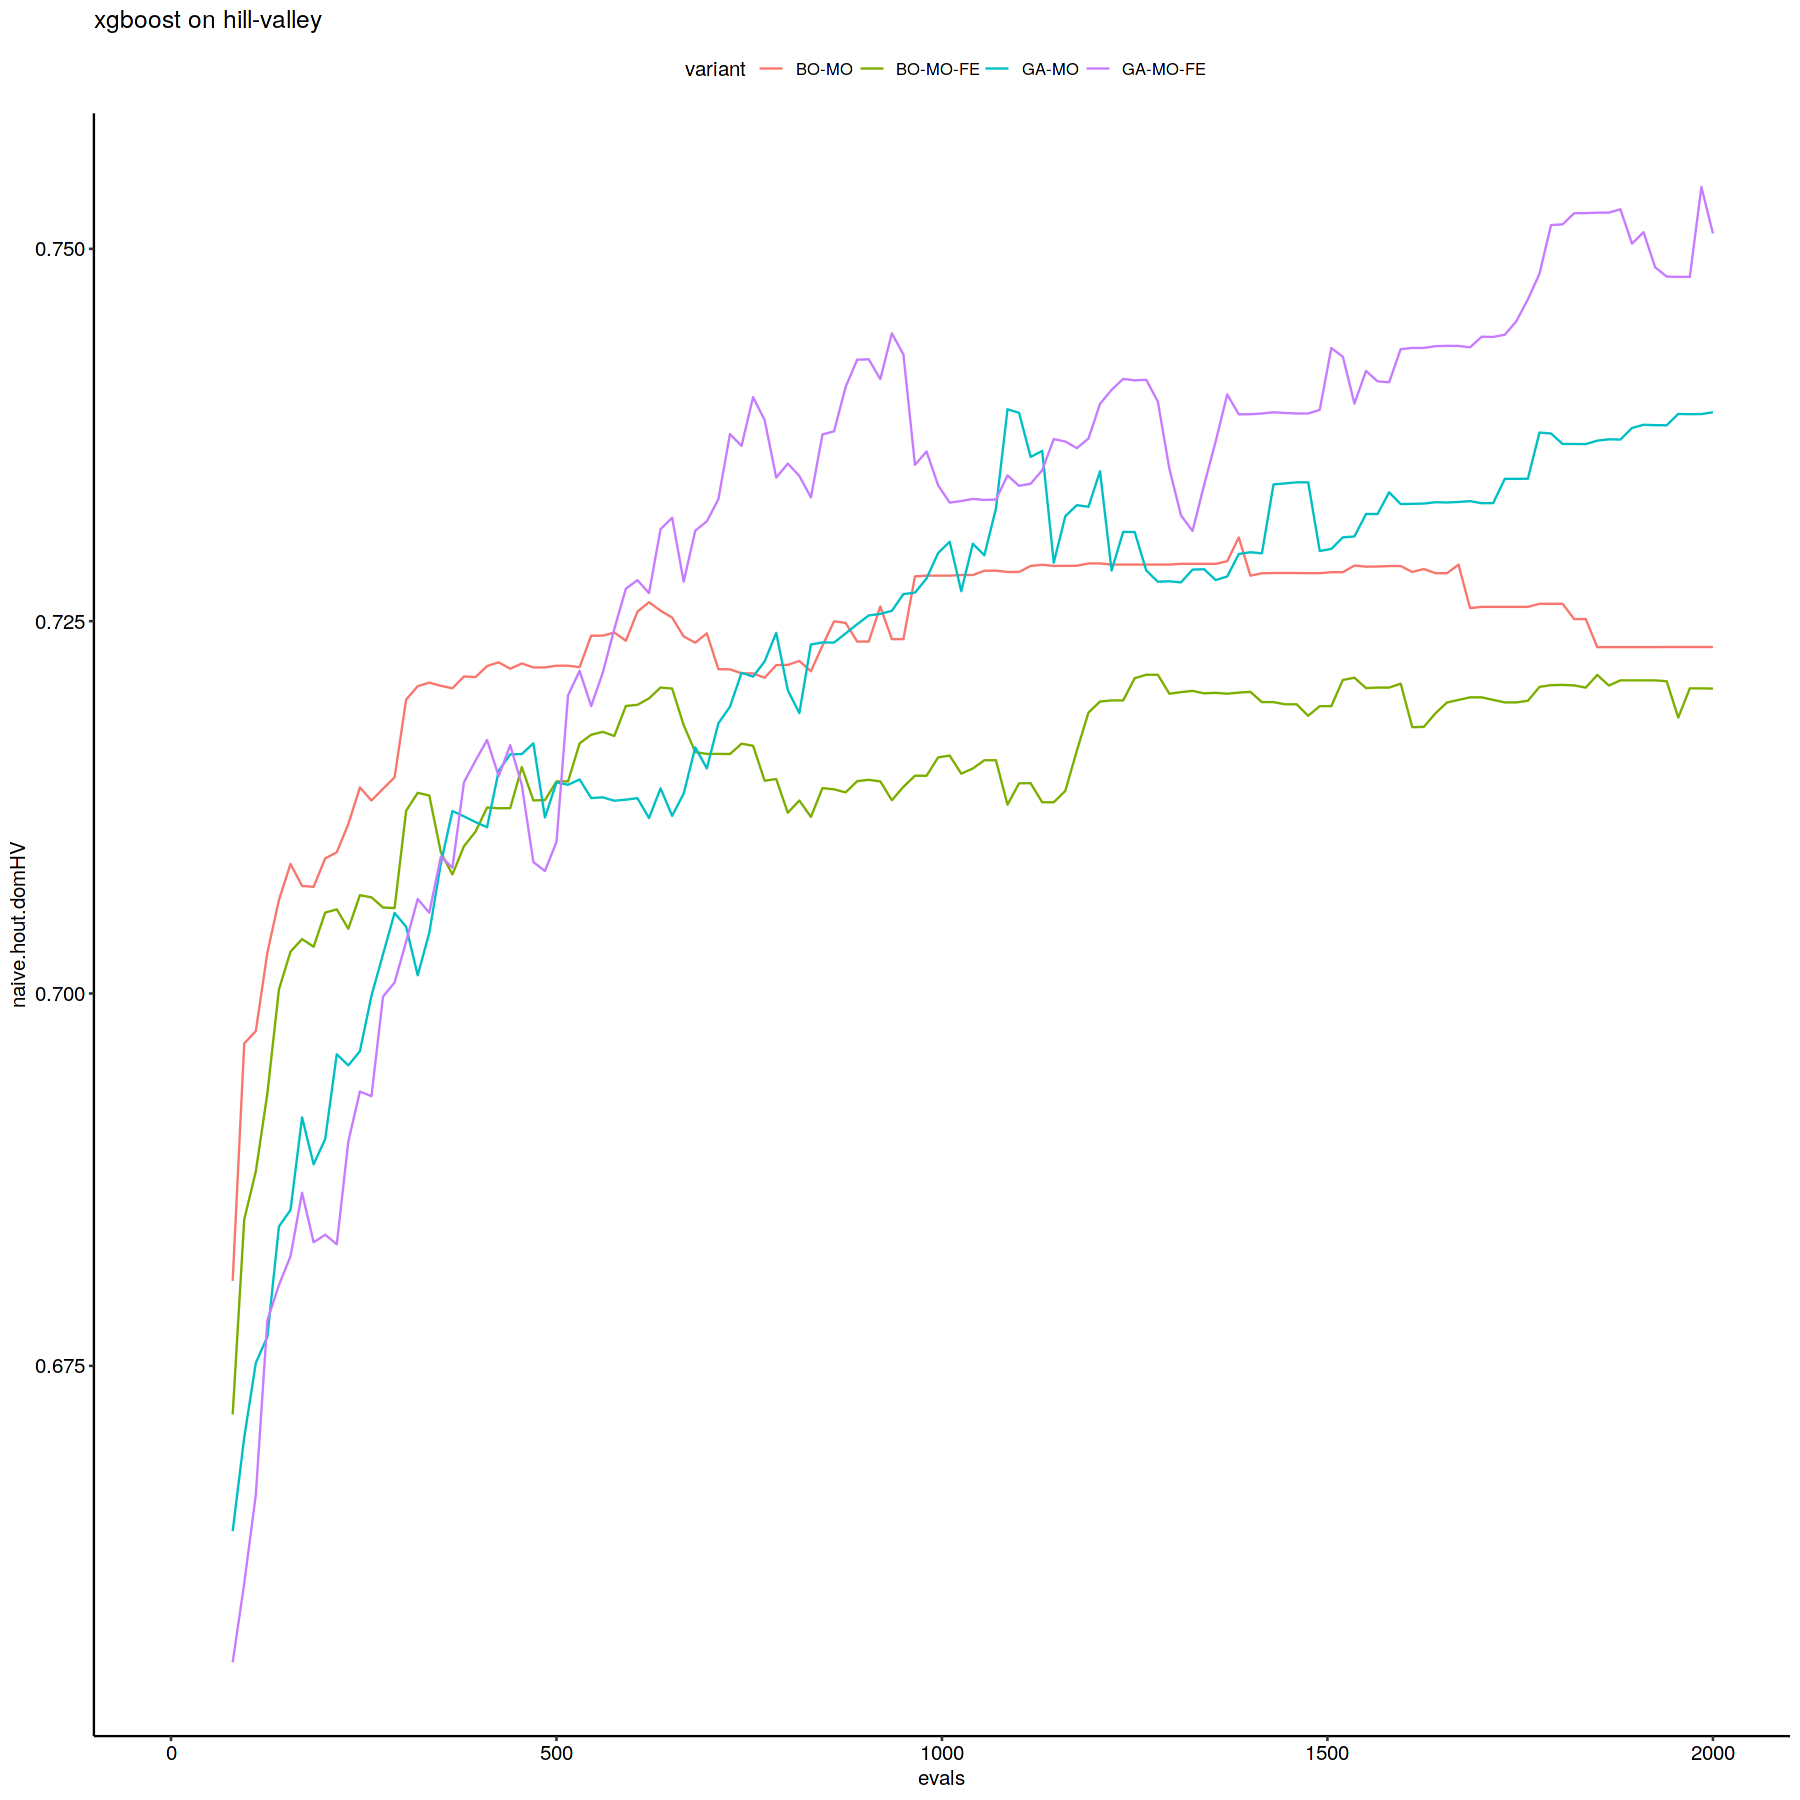

Warning message:
“Removed 268 rows containing missing values (geom_path).”


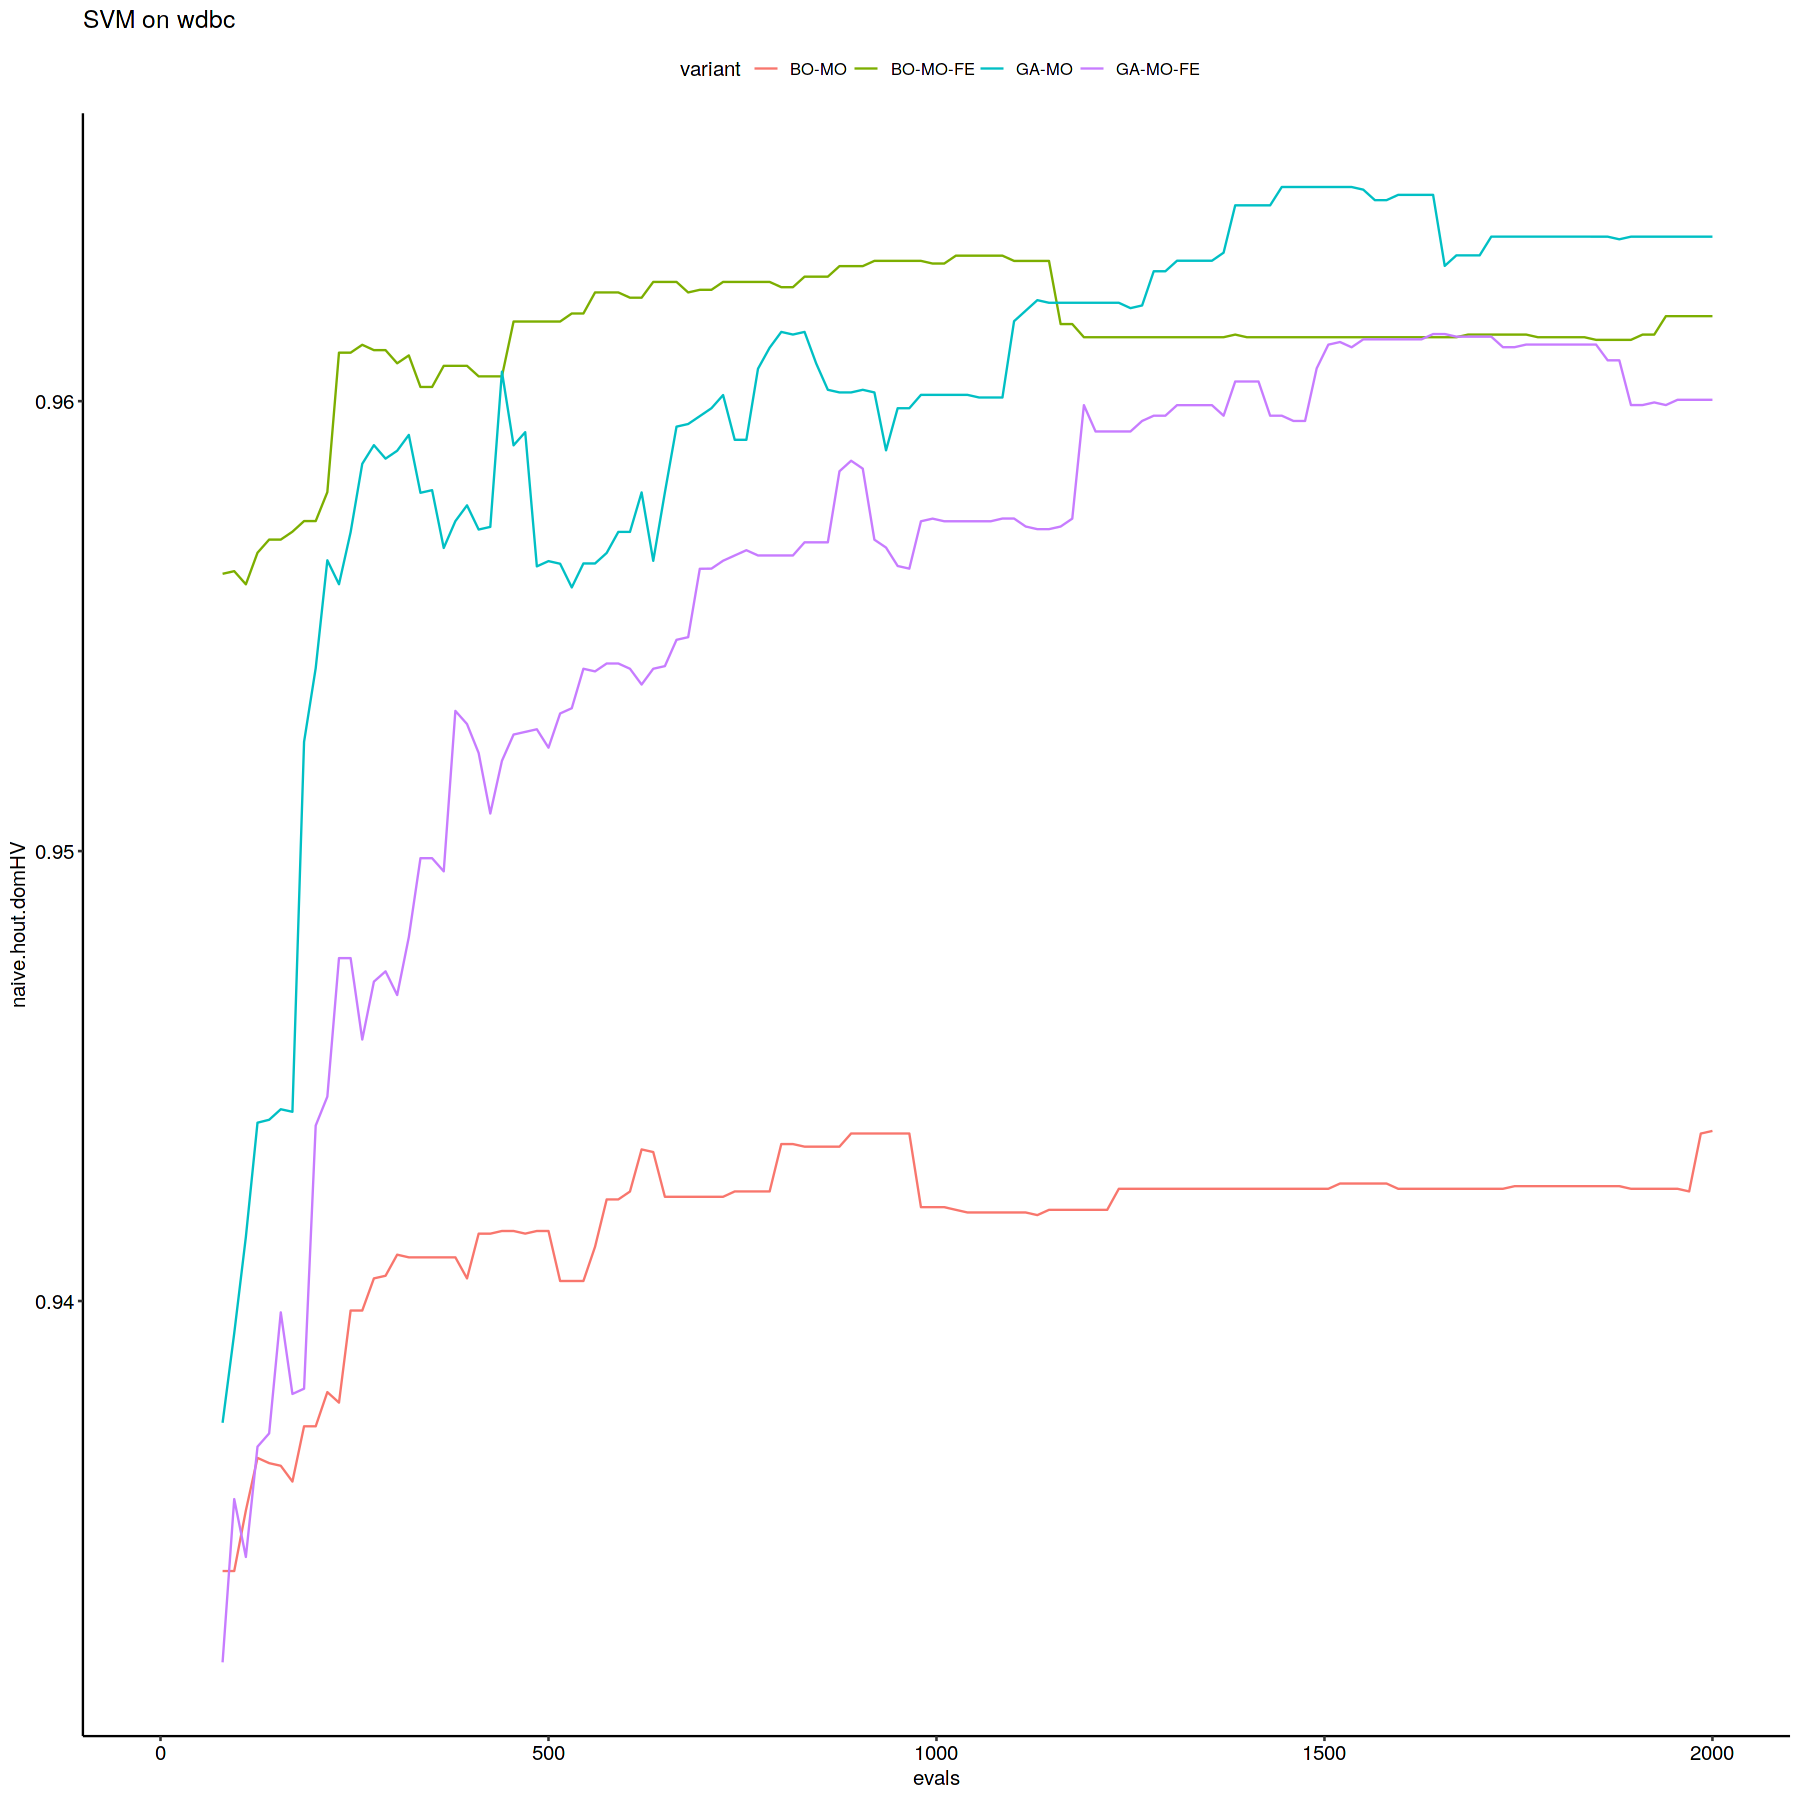

Warning message:
“Removed 268 rows containing missing values (geom_path).”


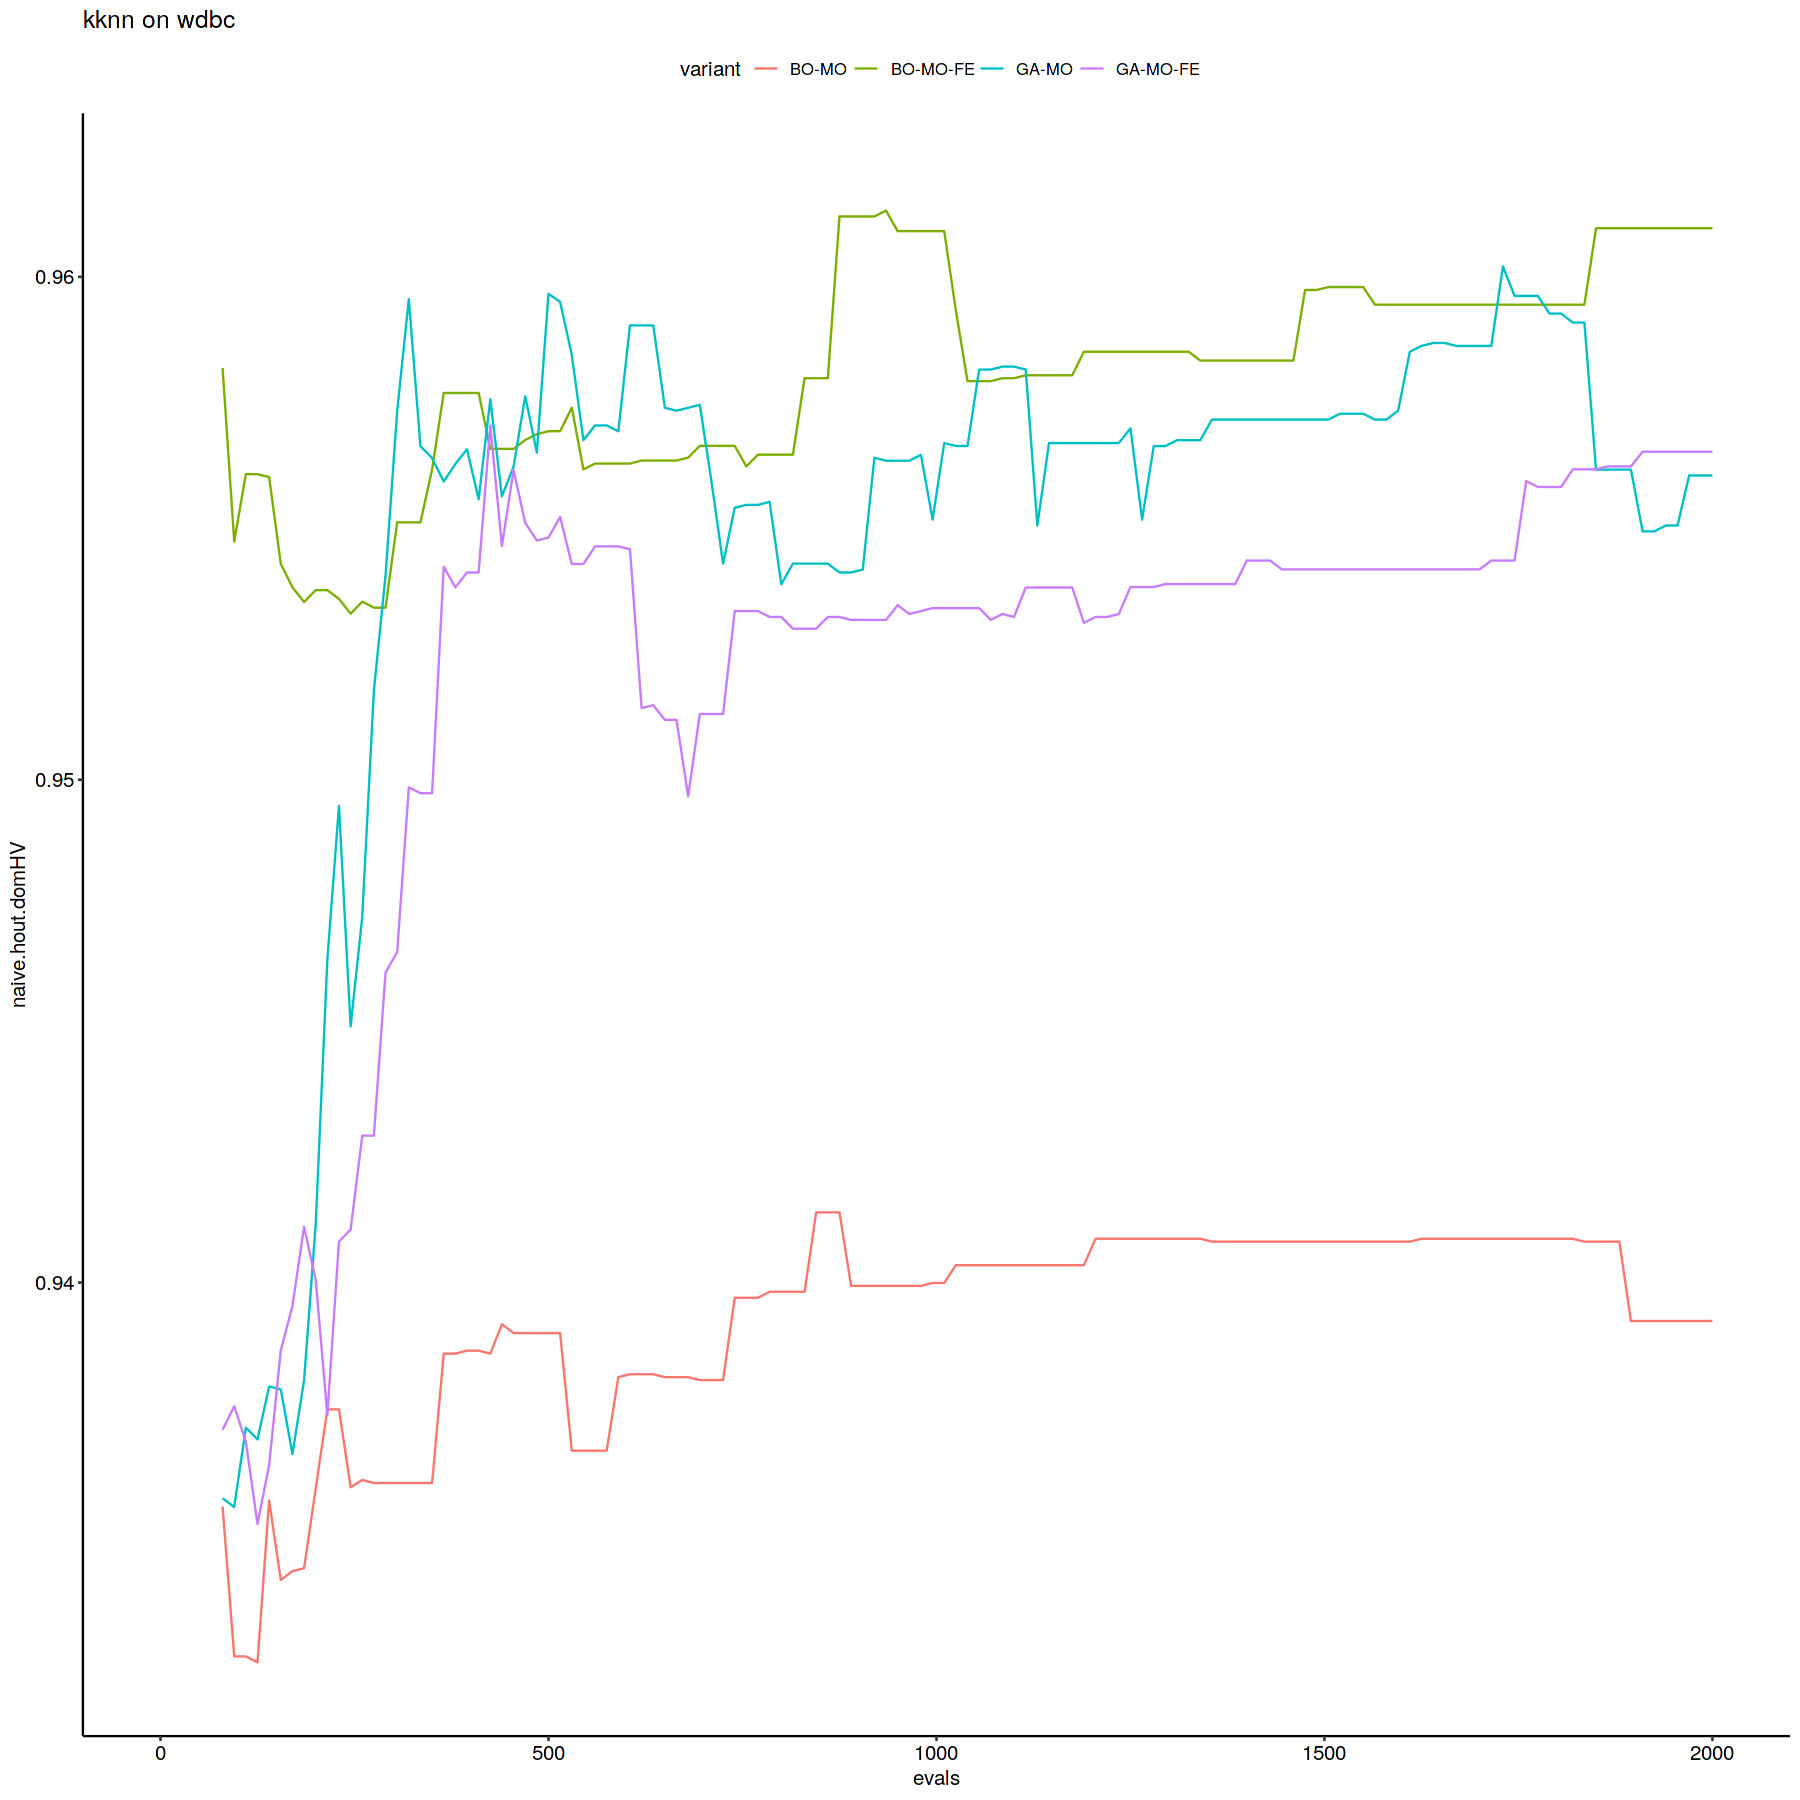

Warning message:
“Removed 269 rows containing missing values (geom_path).”


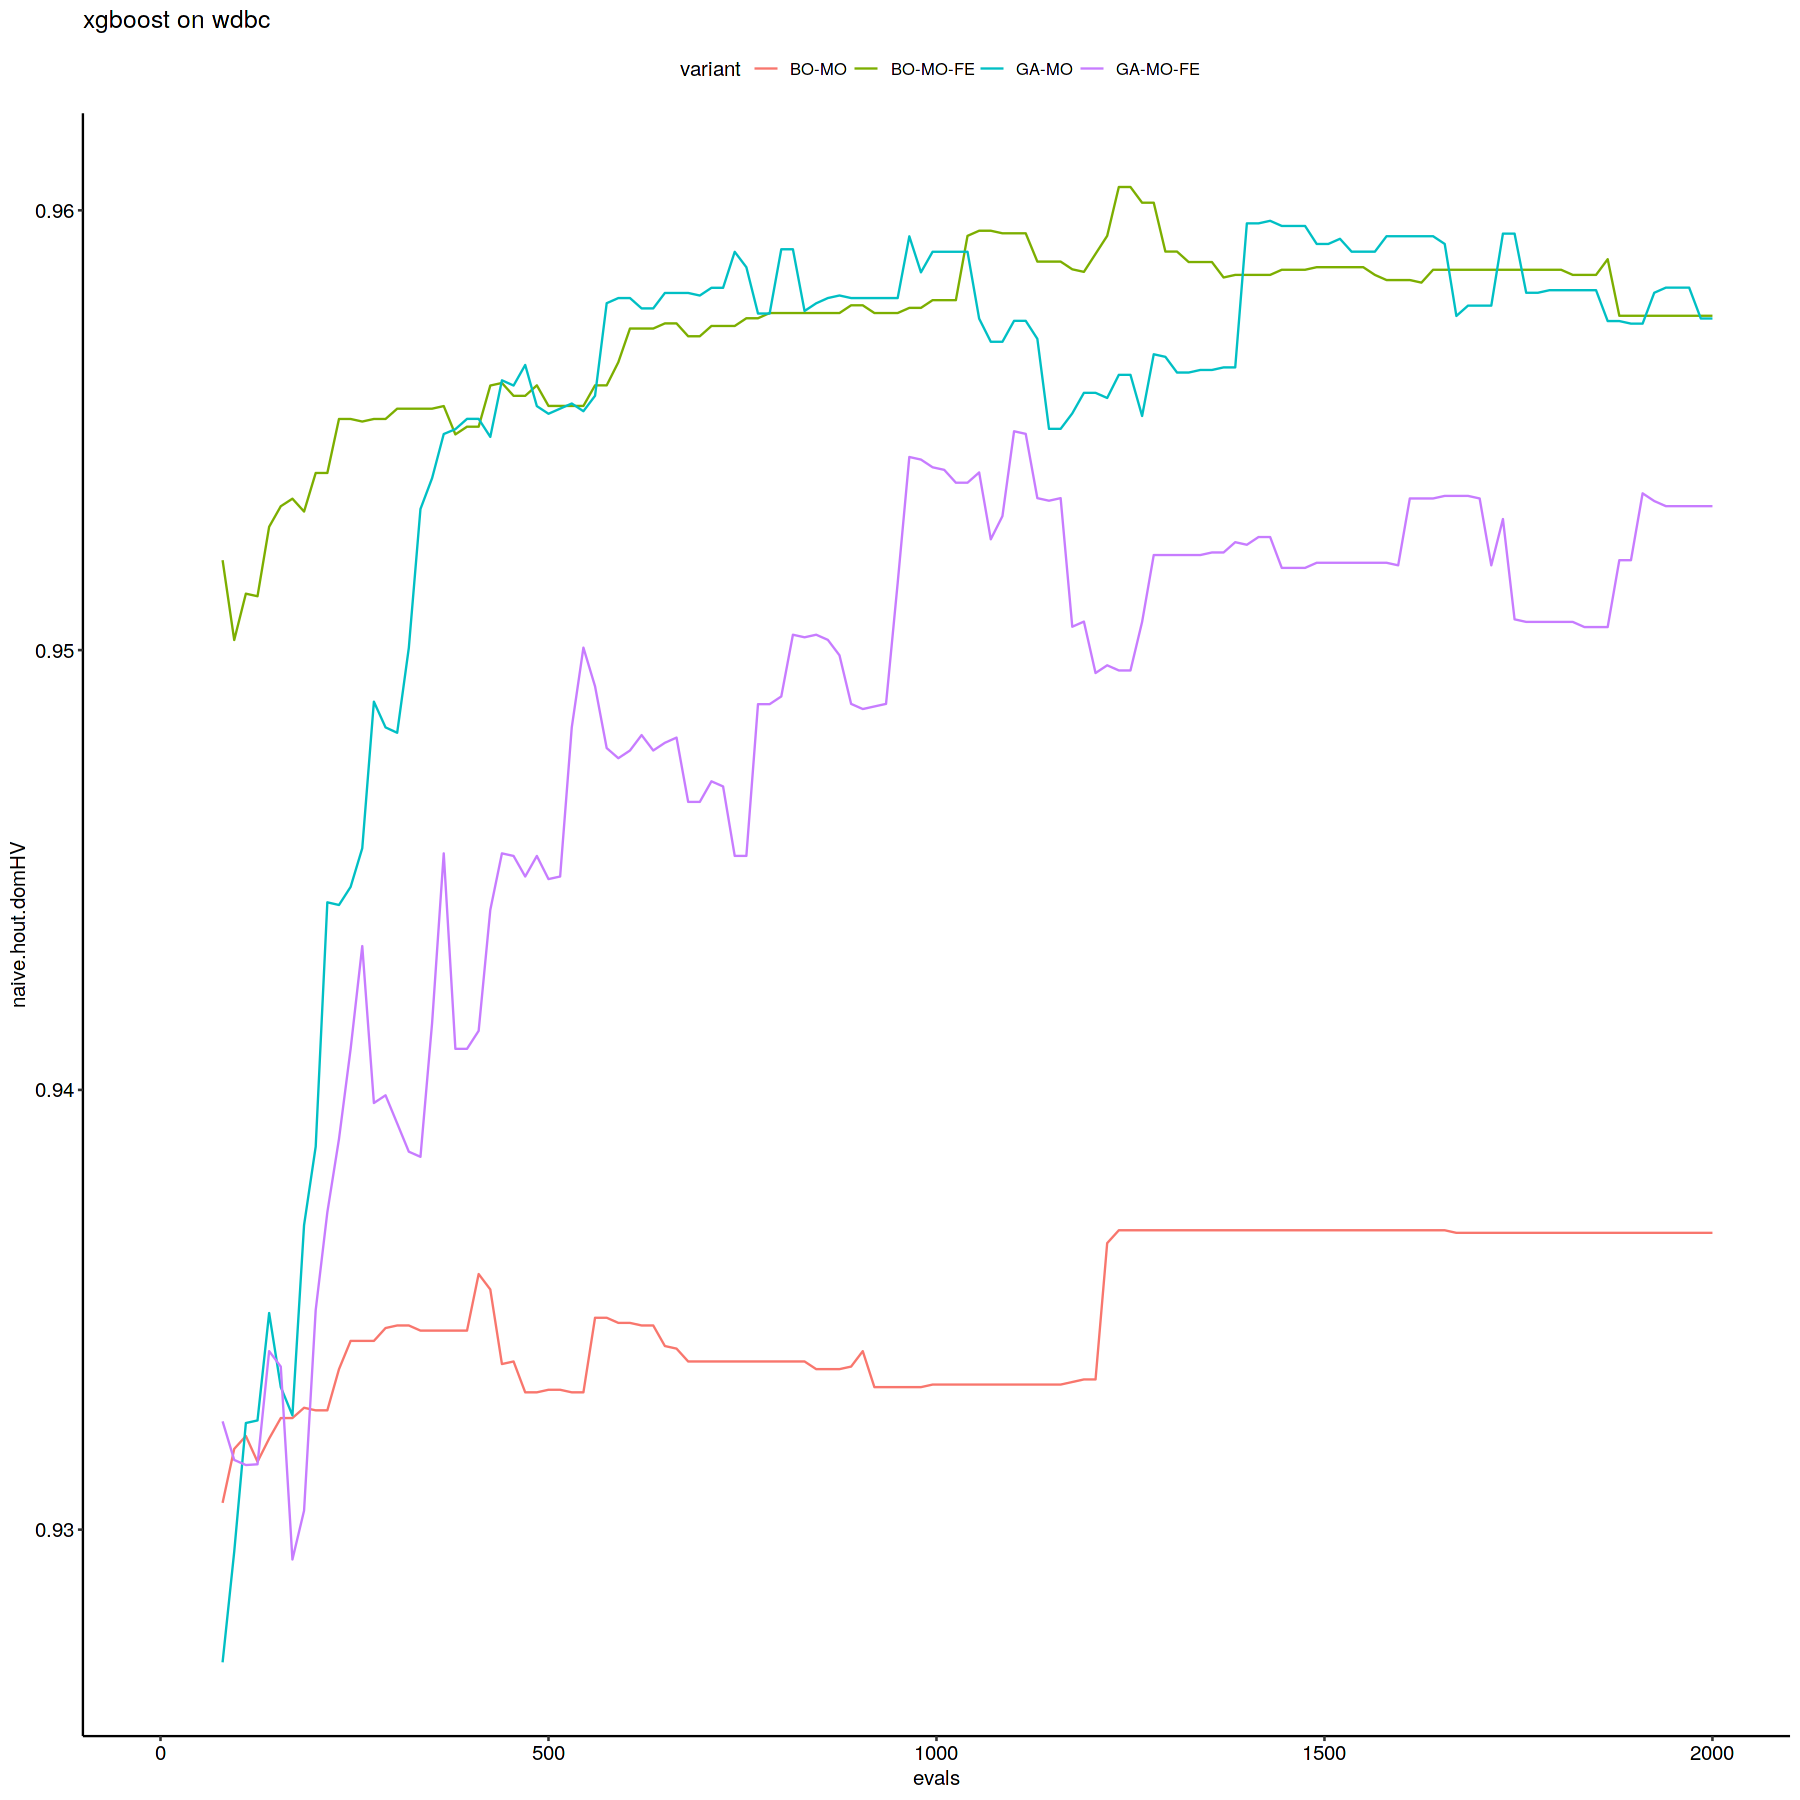

Warning message:
“Removed 268 rows containing missing values (geom_path).”


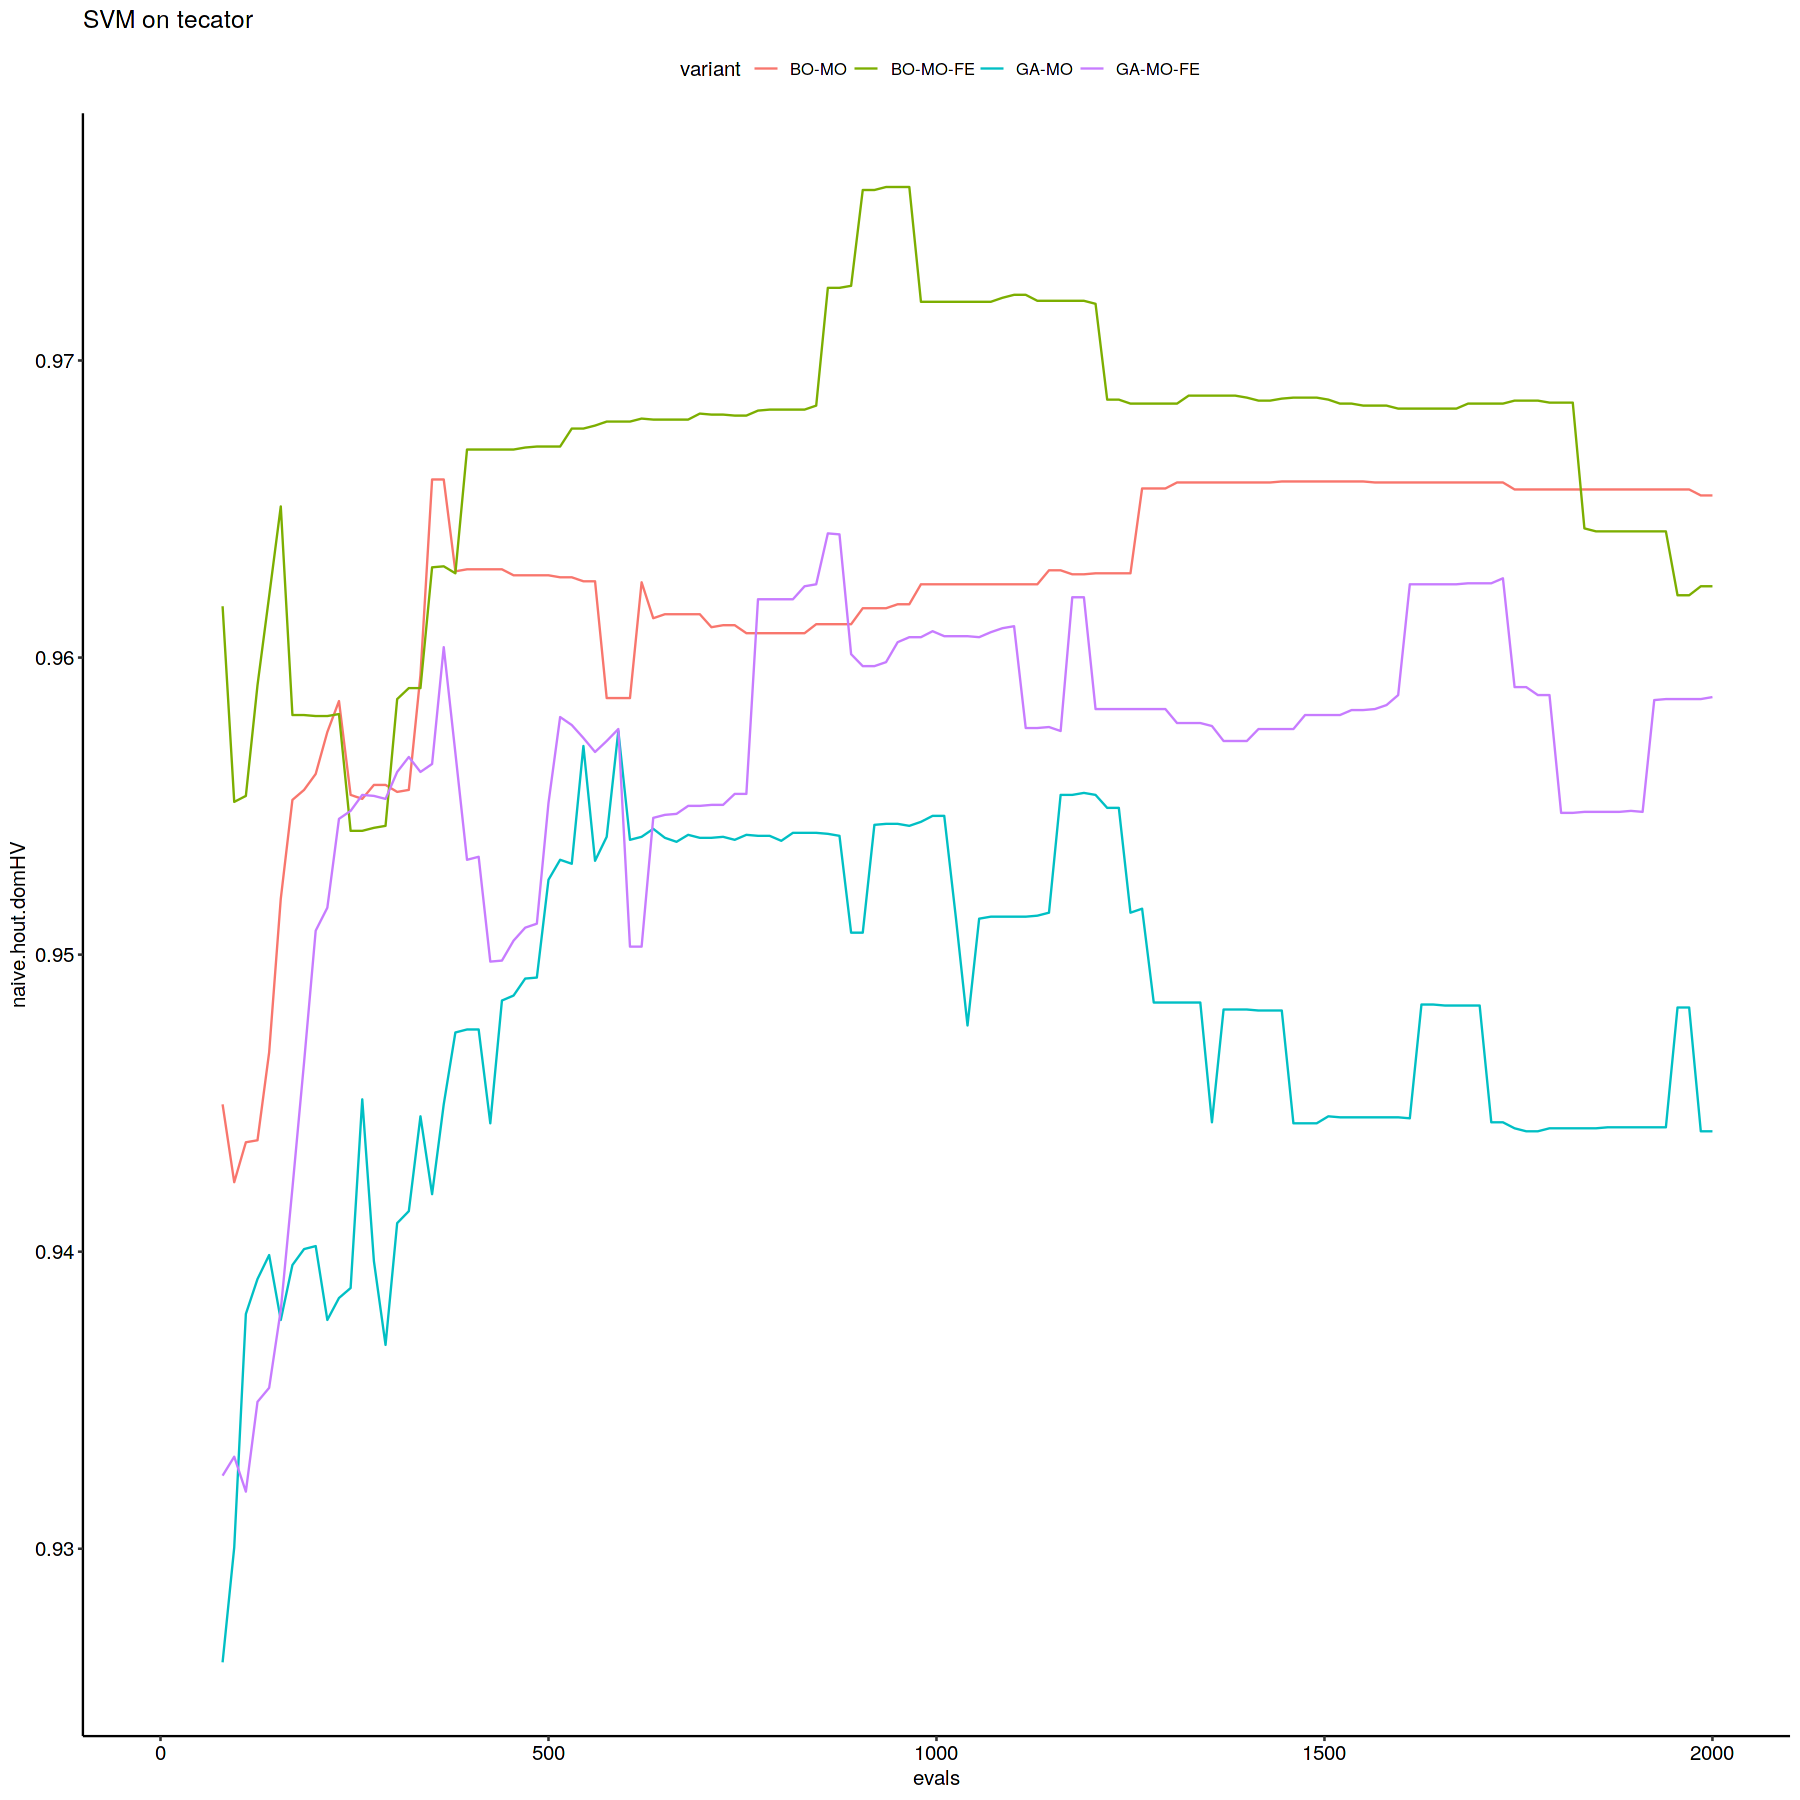

Warning message:
“Removed 268 rows containing missing values (geom_path).”


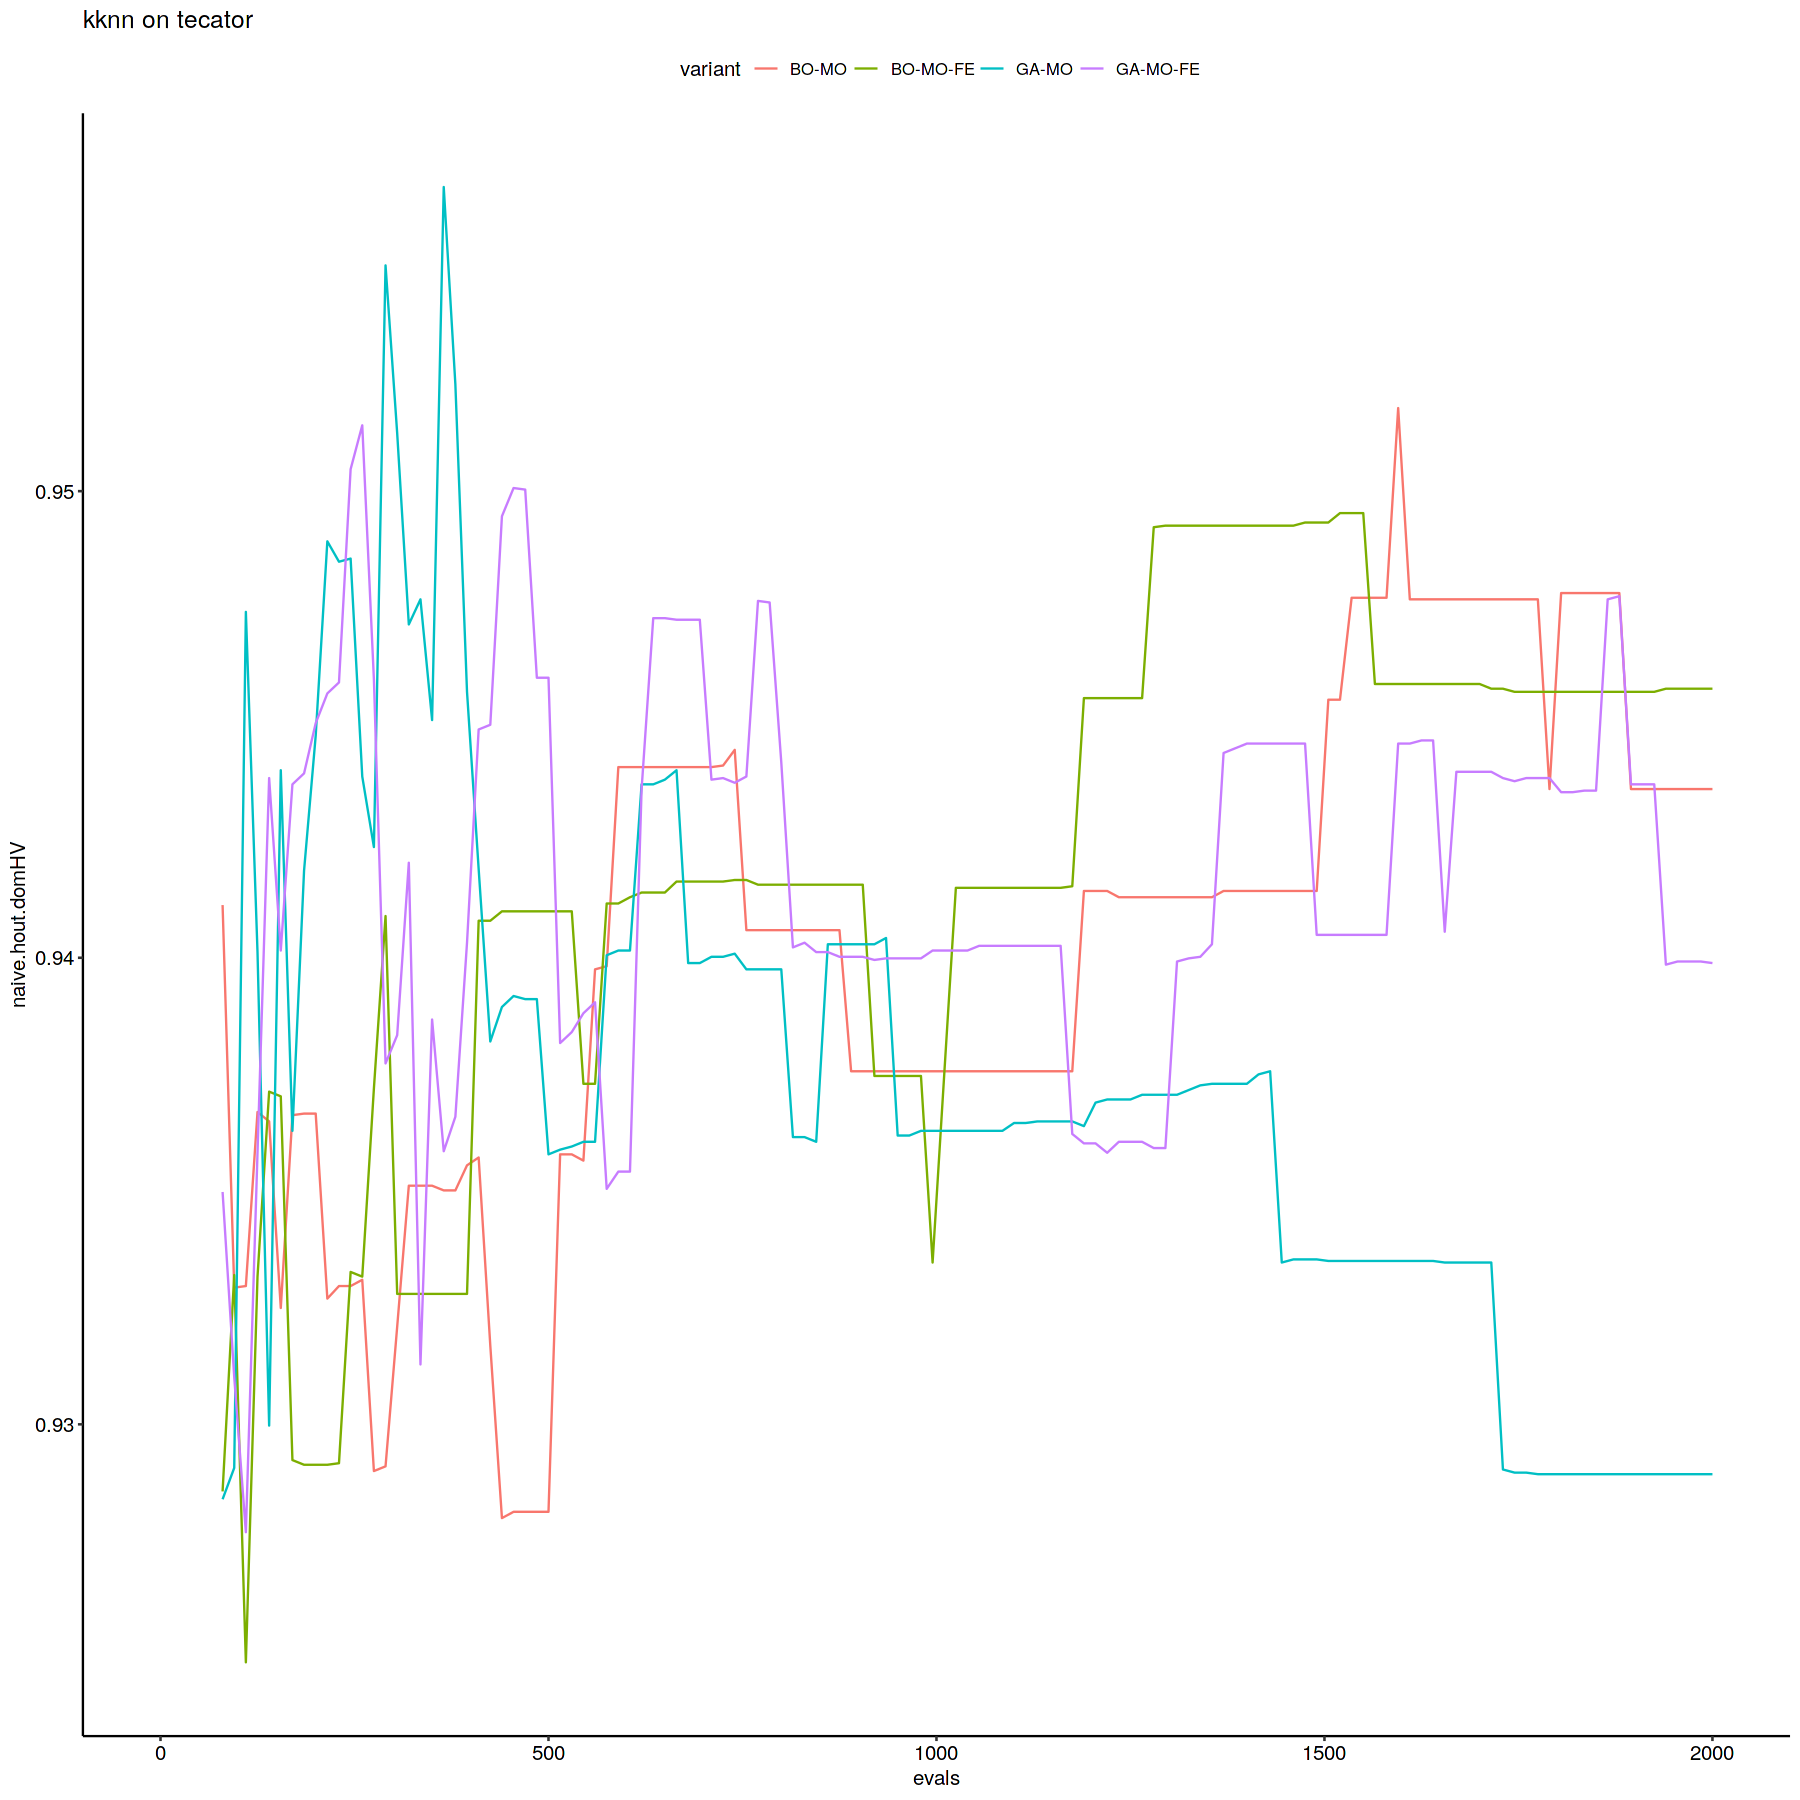

Warning message:
“Removed 269 rows containing missing values (geom_path).”


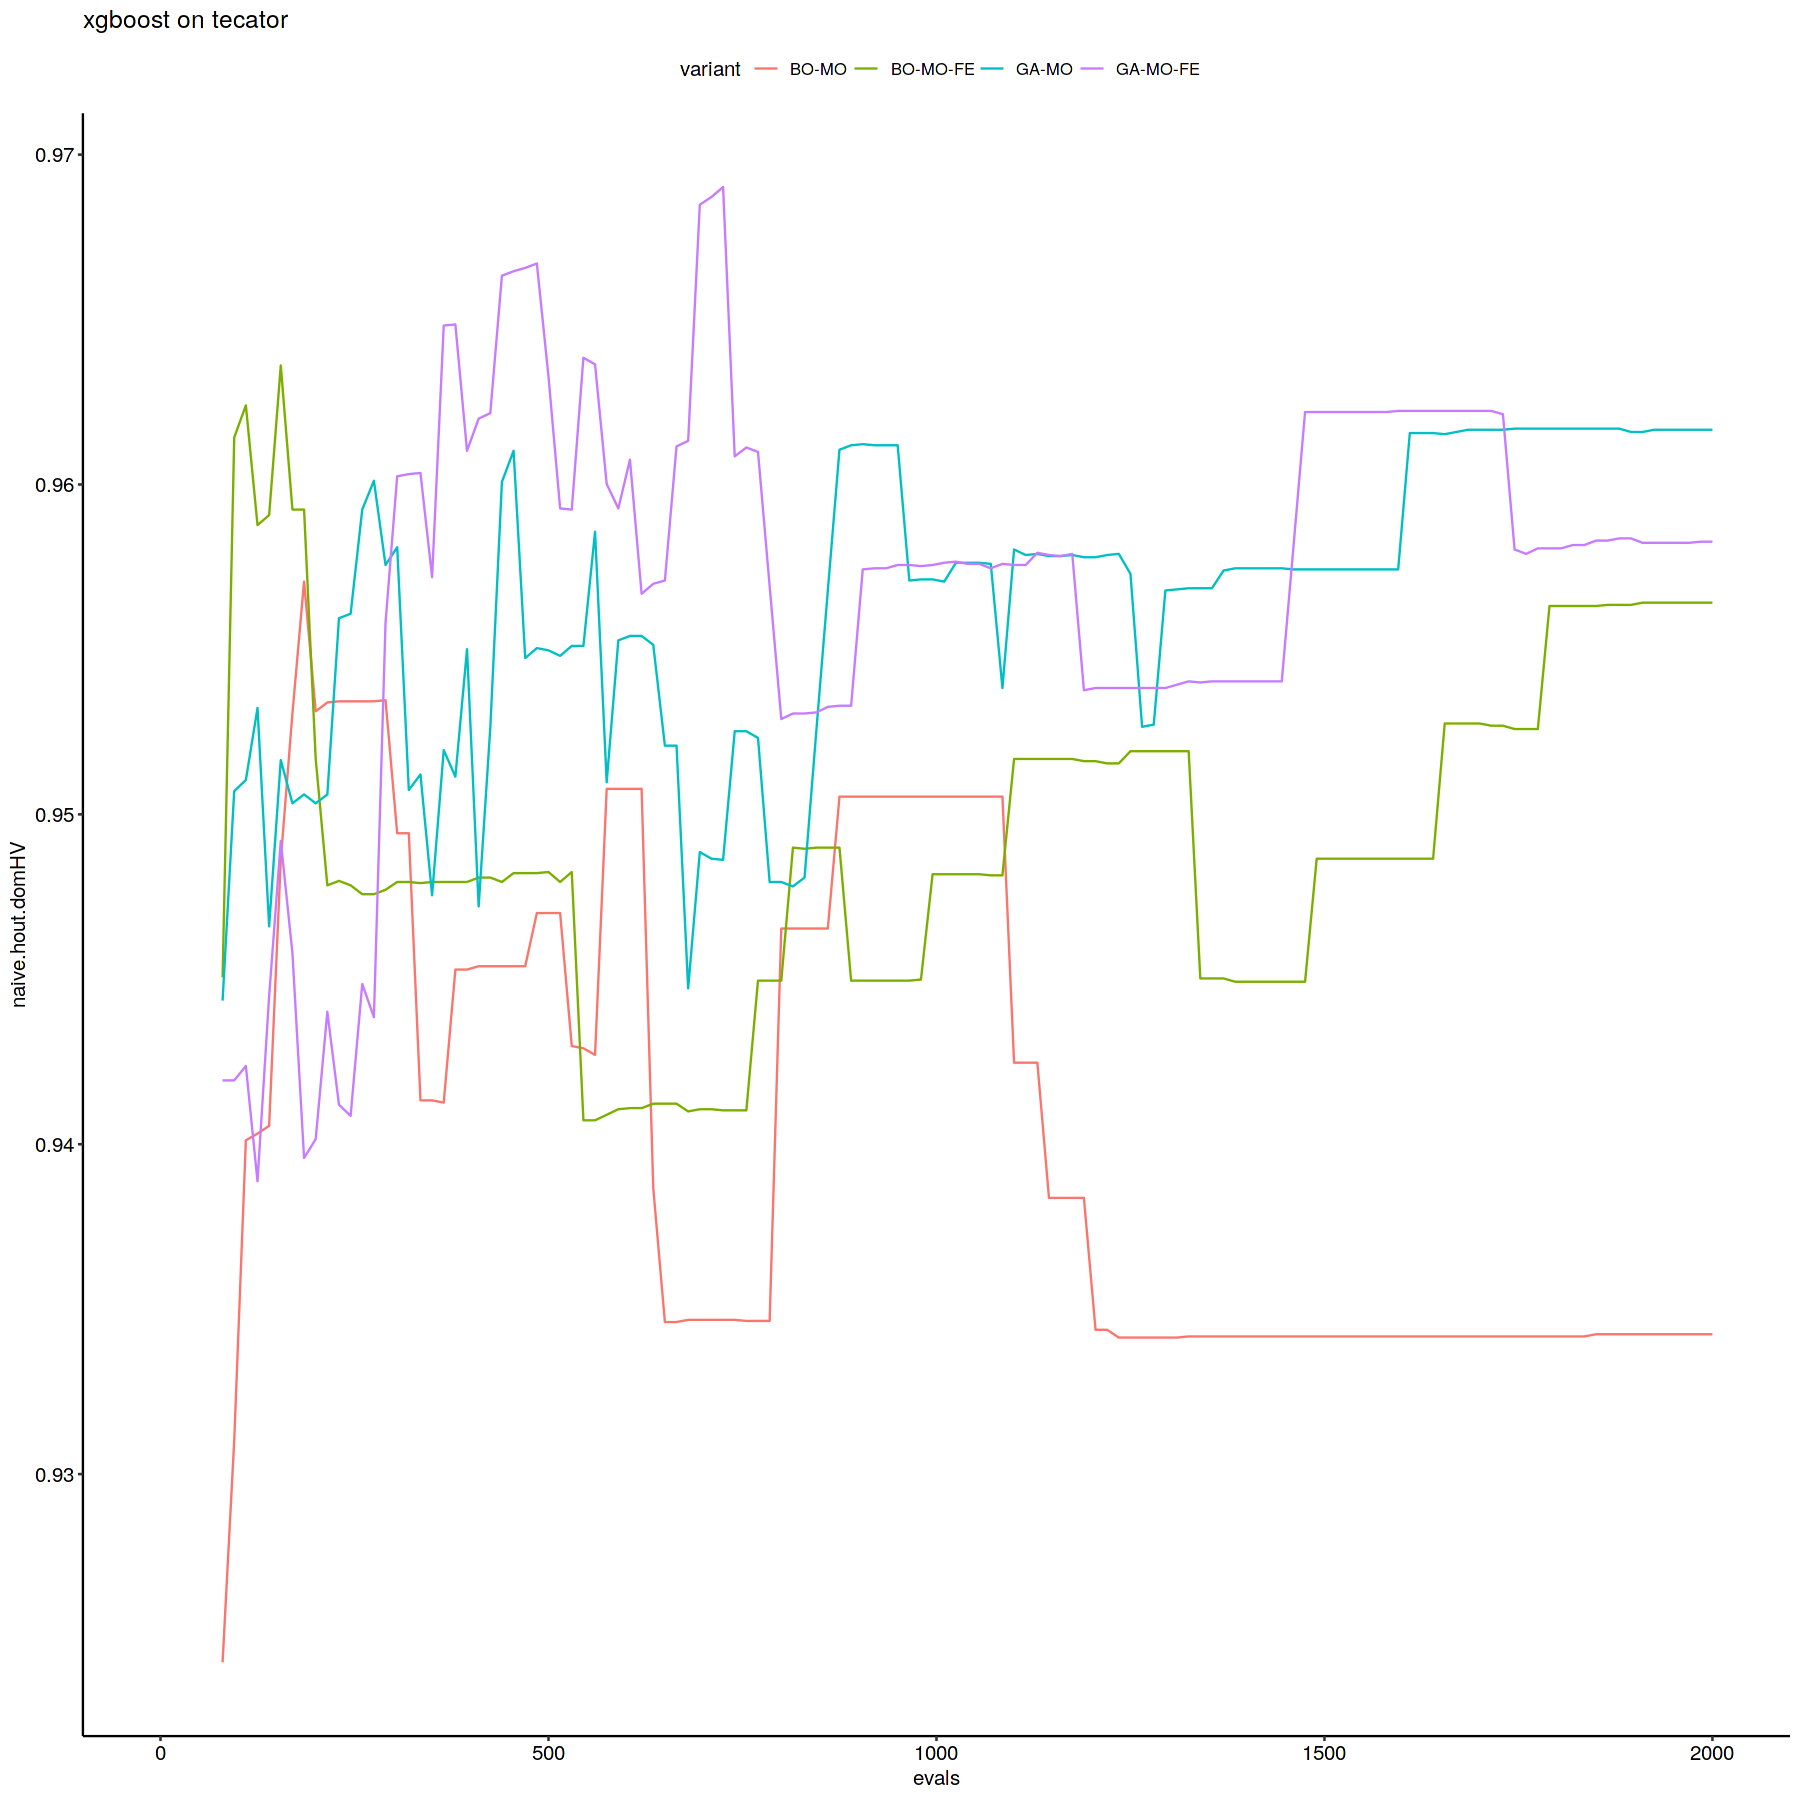

Warning message:
“Removed 268 rows containing missing values (geom_path).”


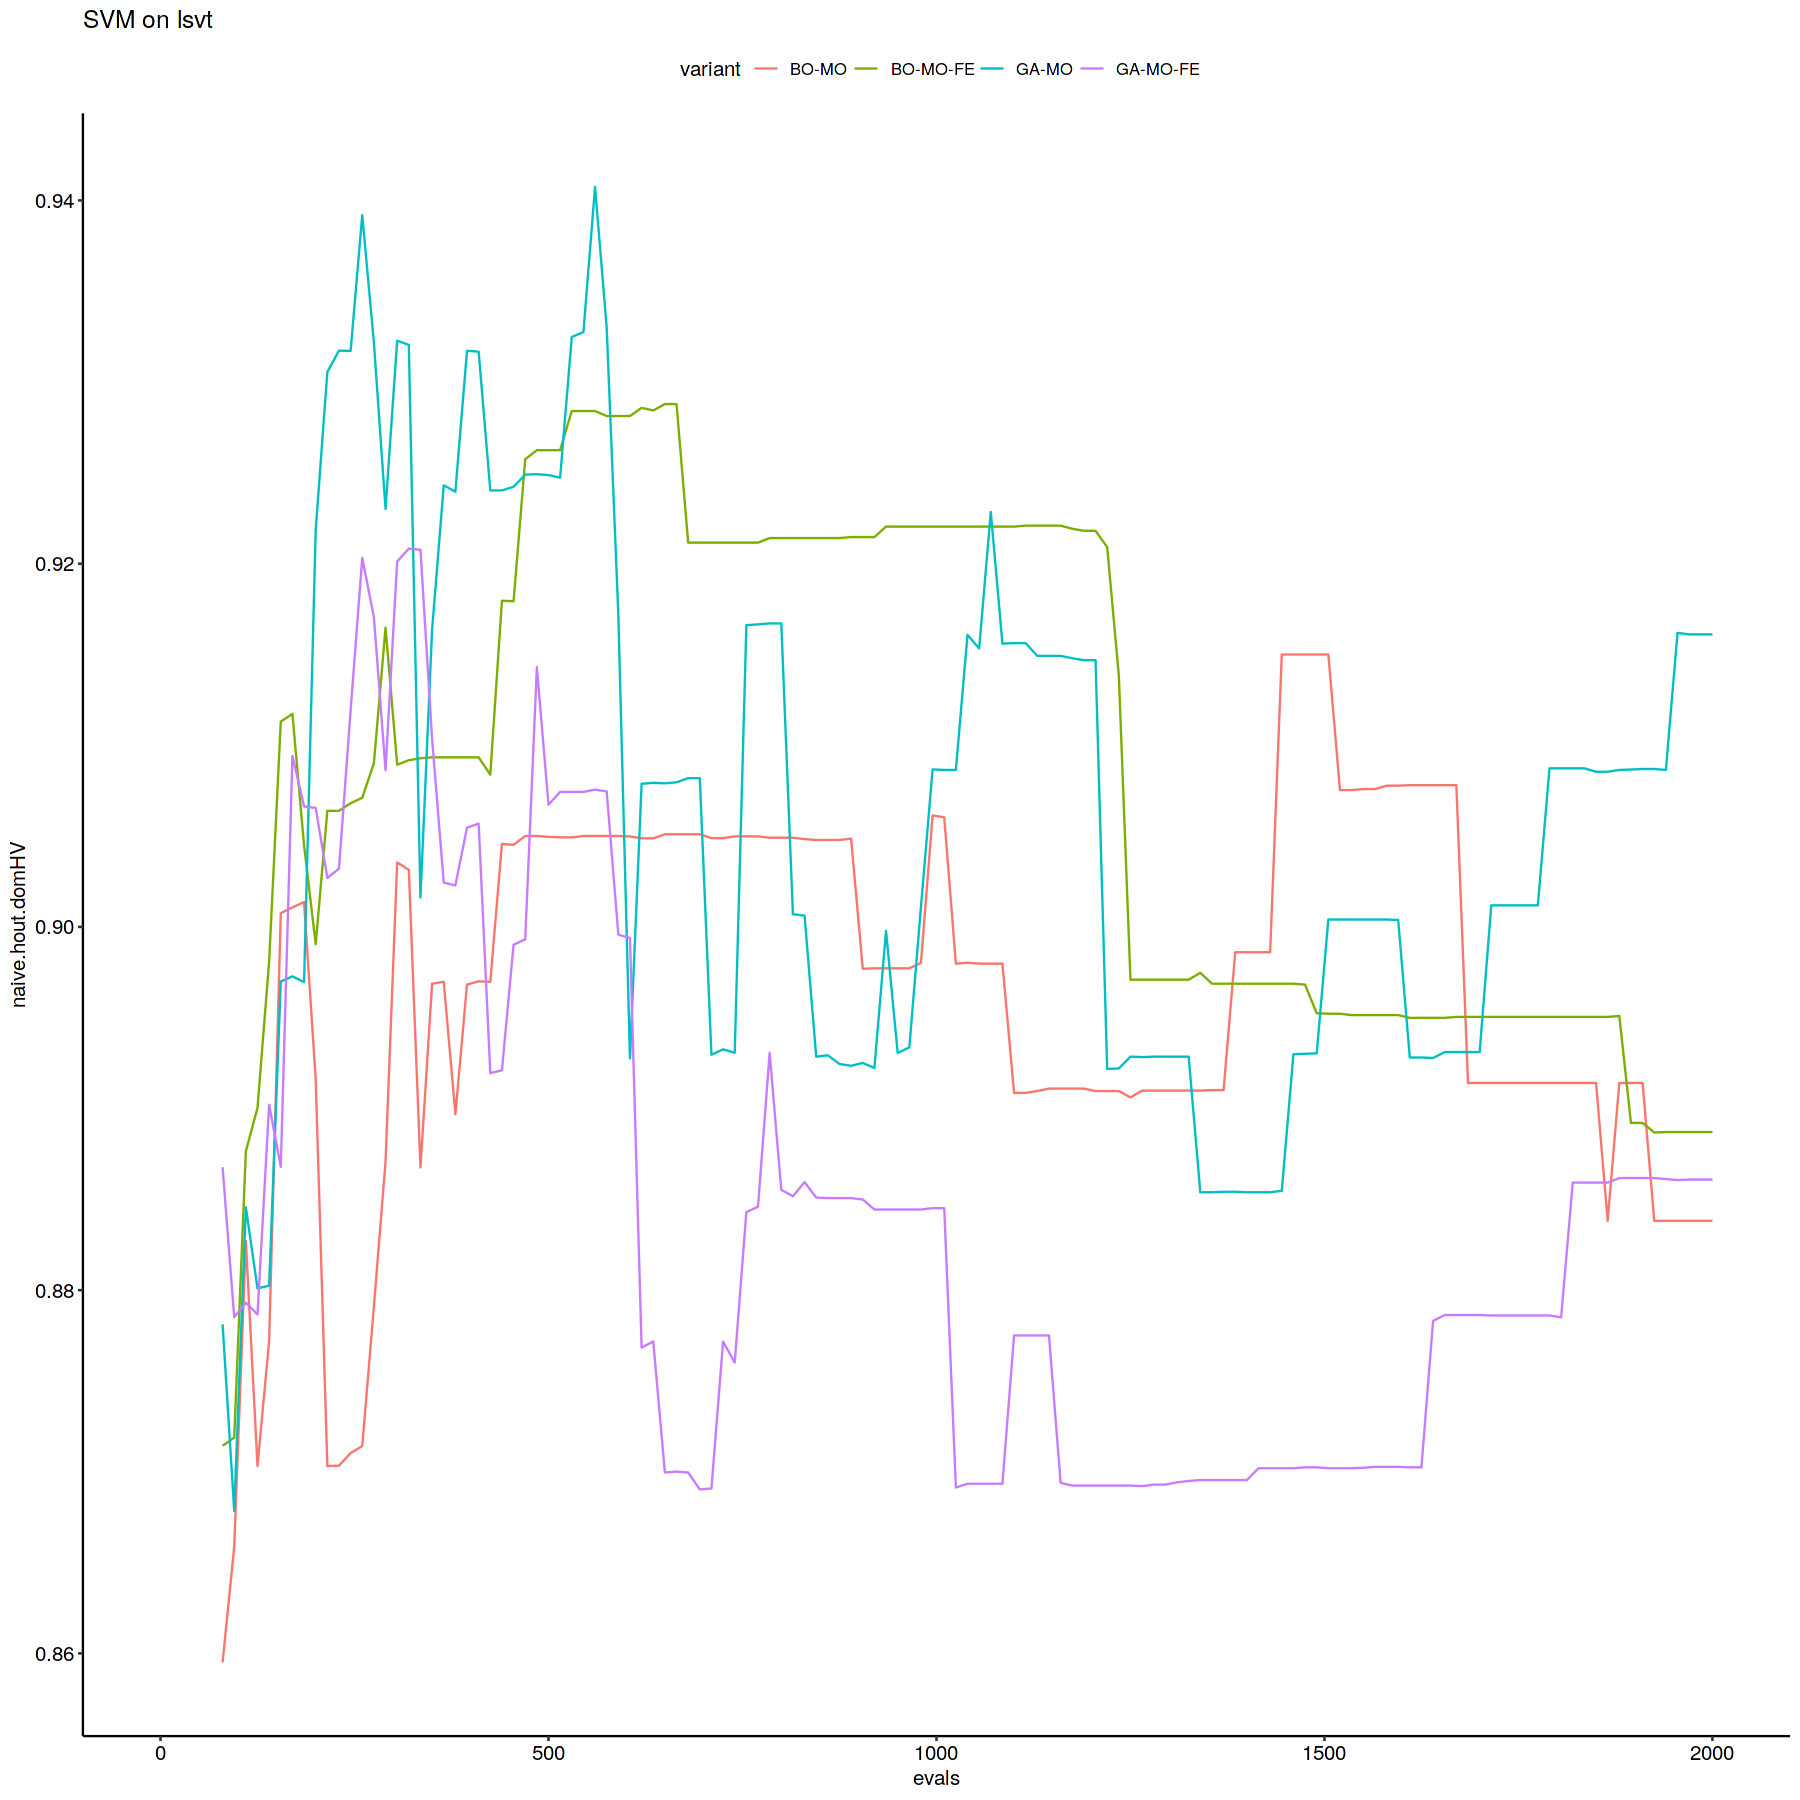

Warning message:
“Removed 268 rows containing missing values (geom_path).”


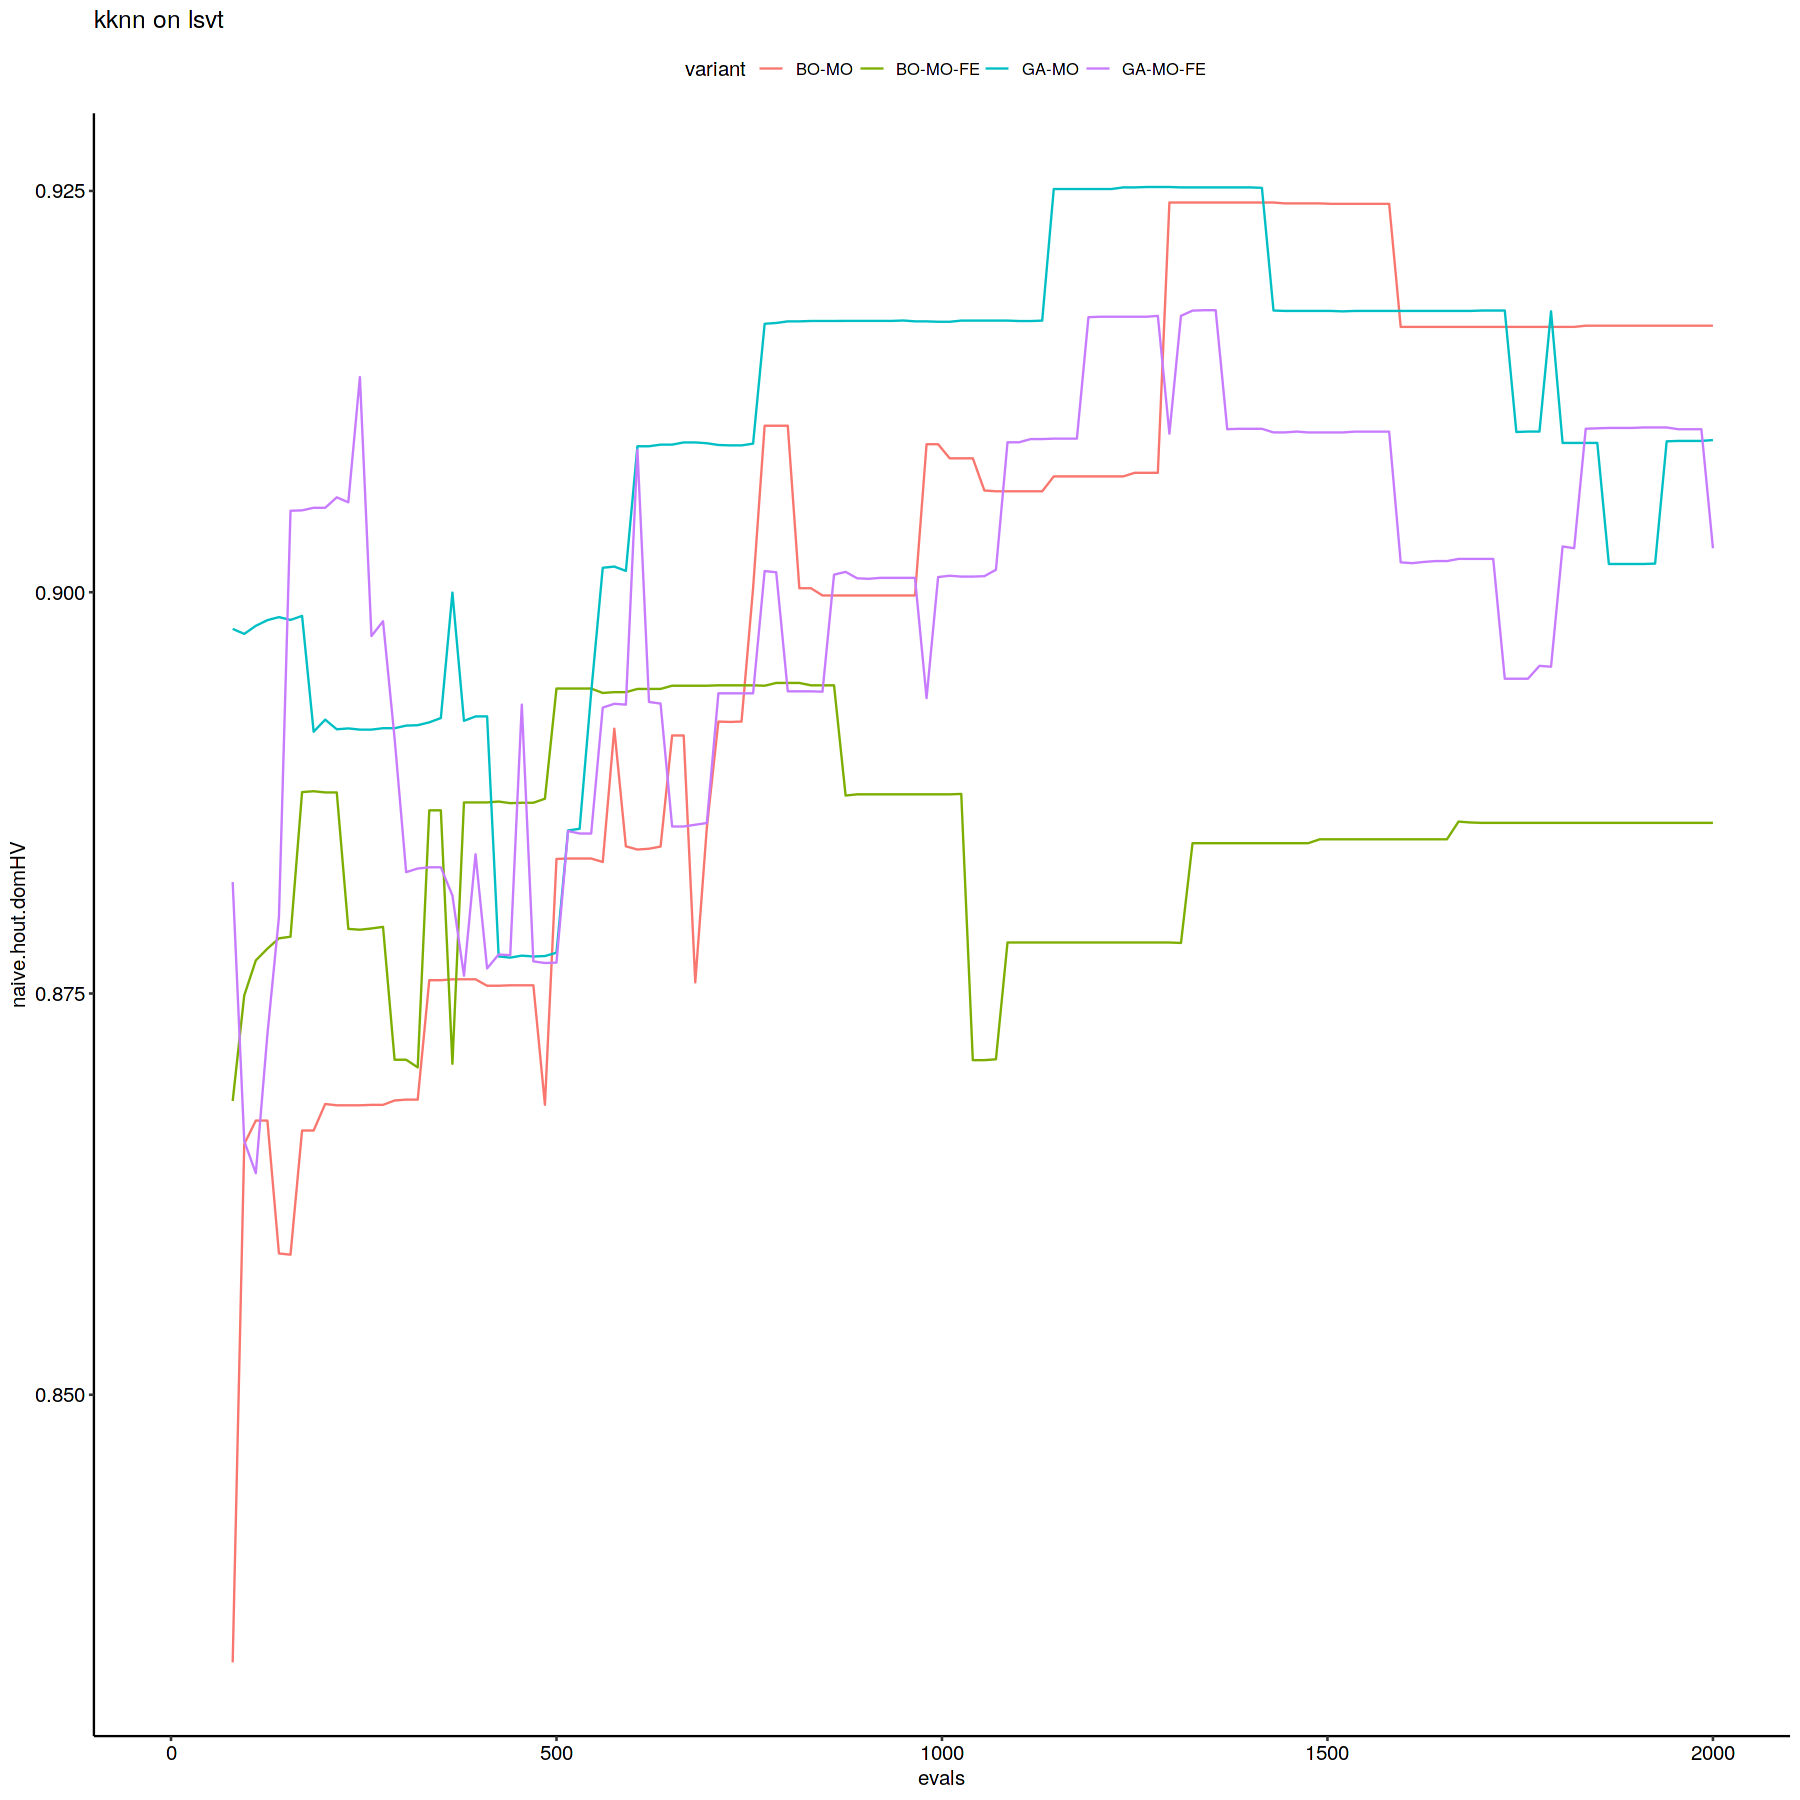

Warning message:
“Removed 269 rows containing missing values (geom_path).”


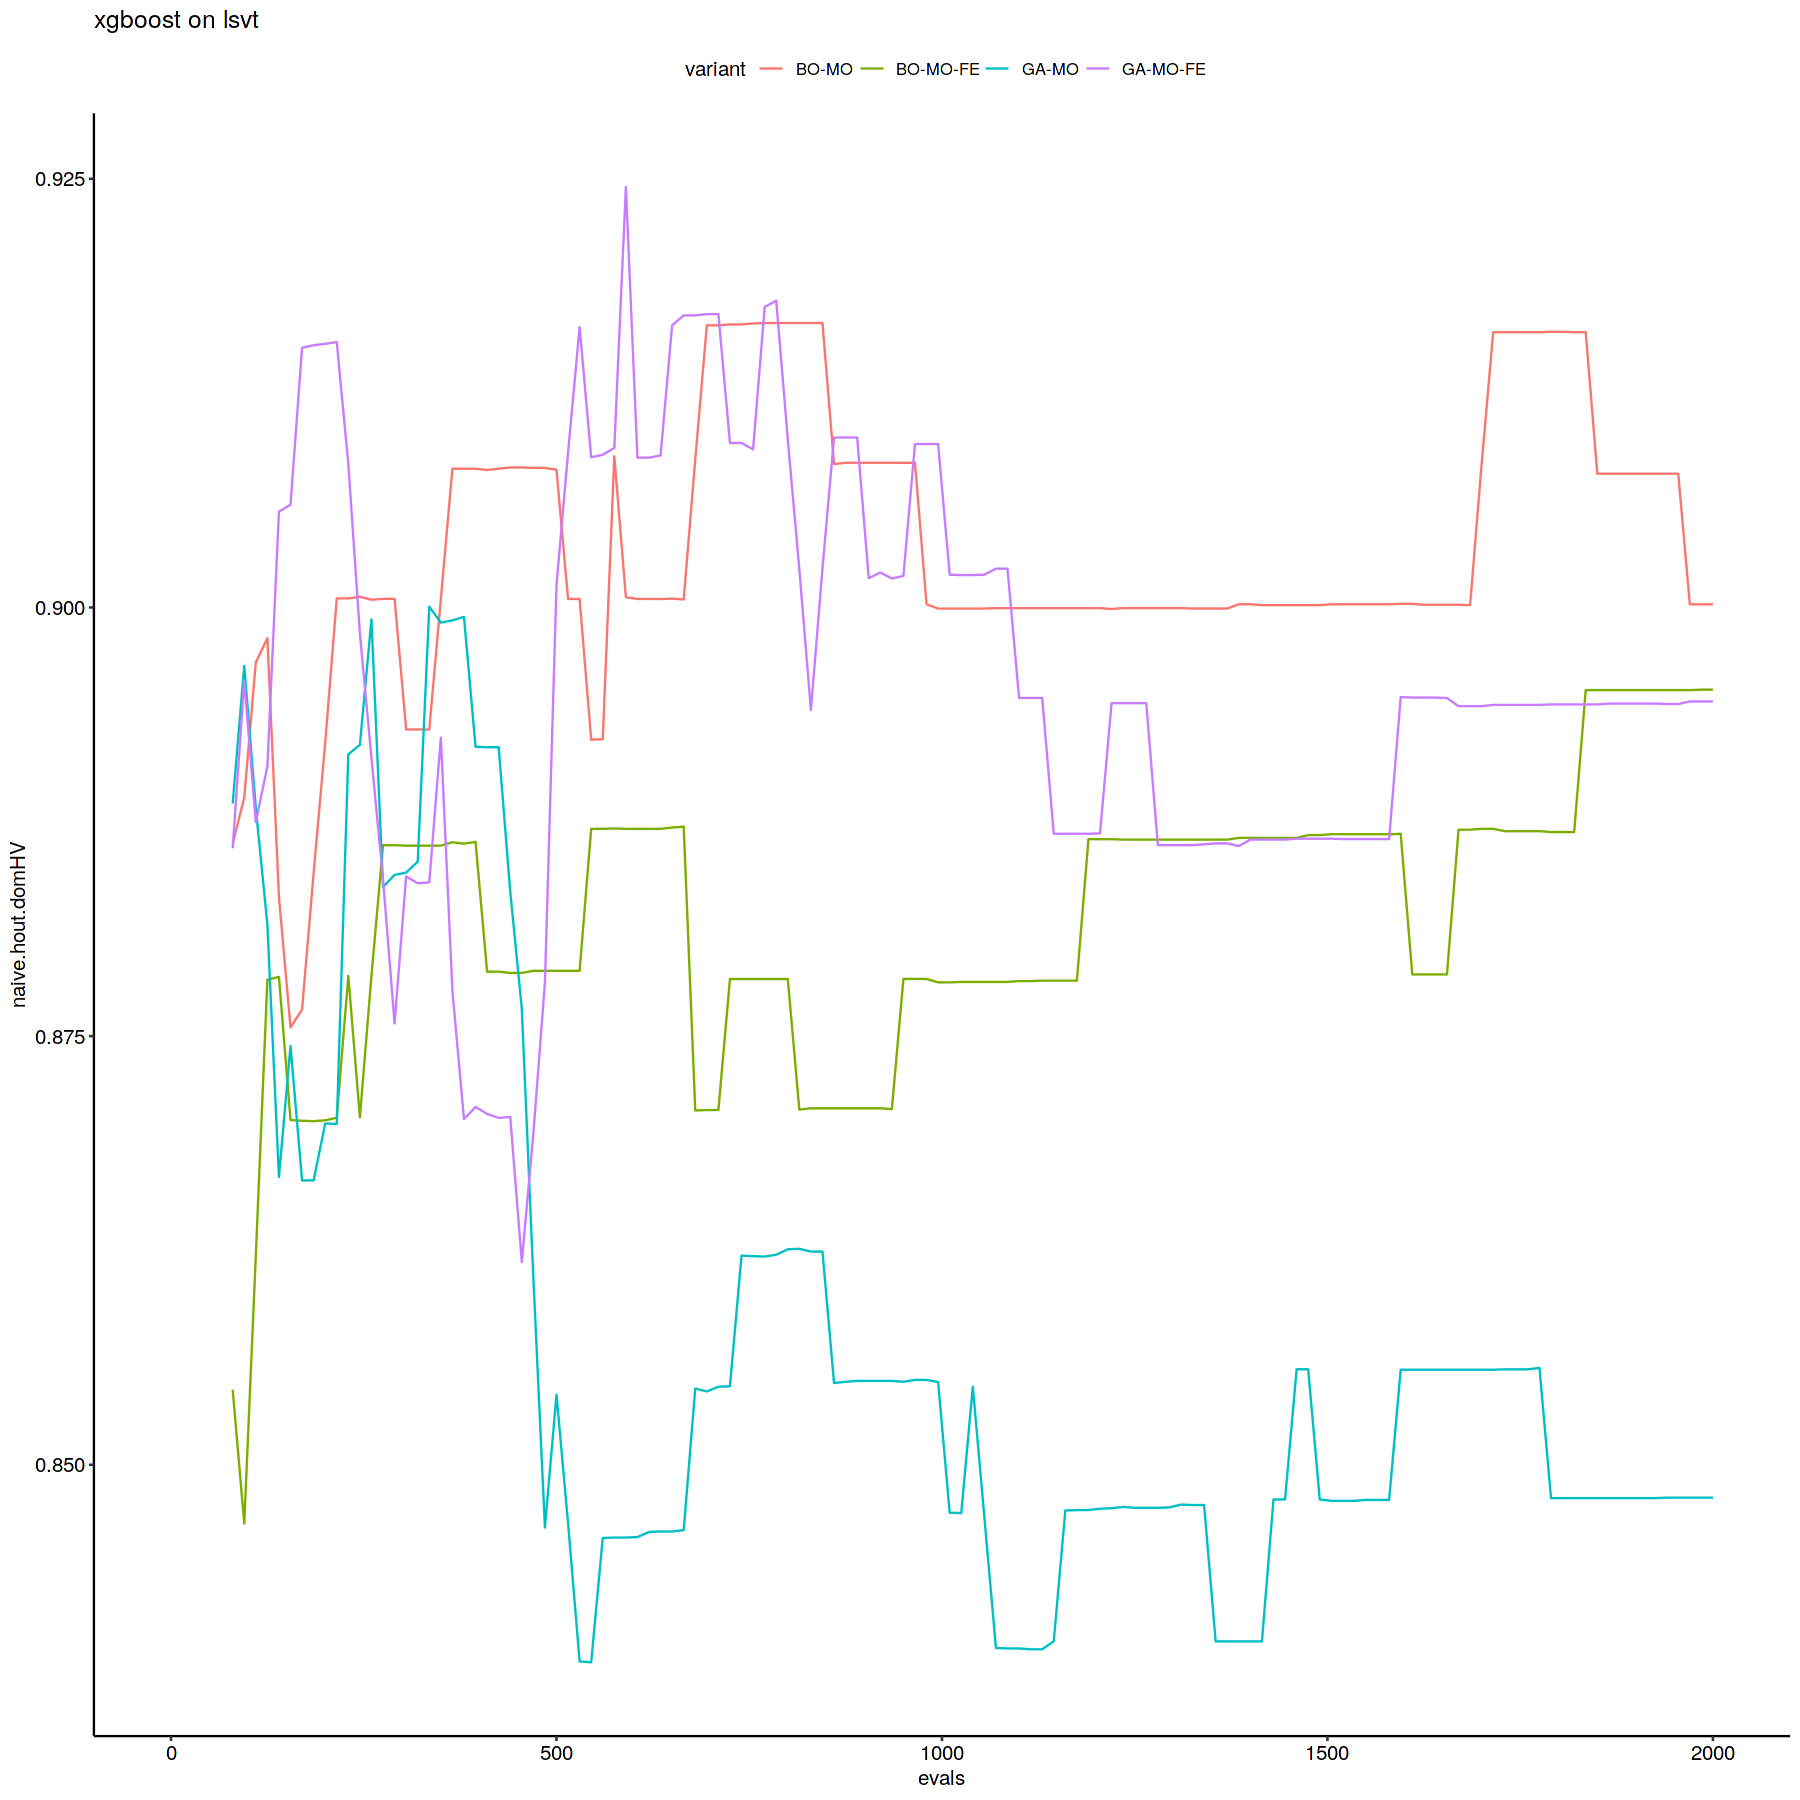

Warning message:
“Removed 268 rows containing missing values (geom_path).”


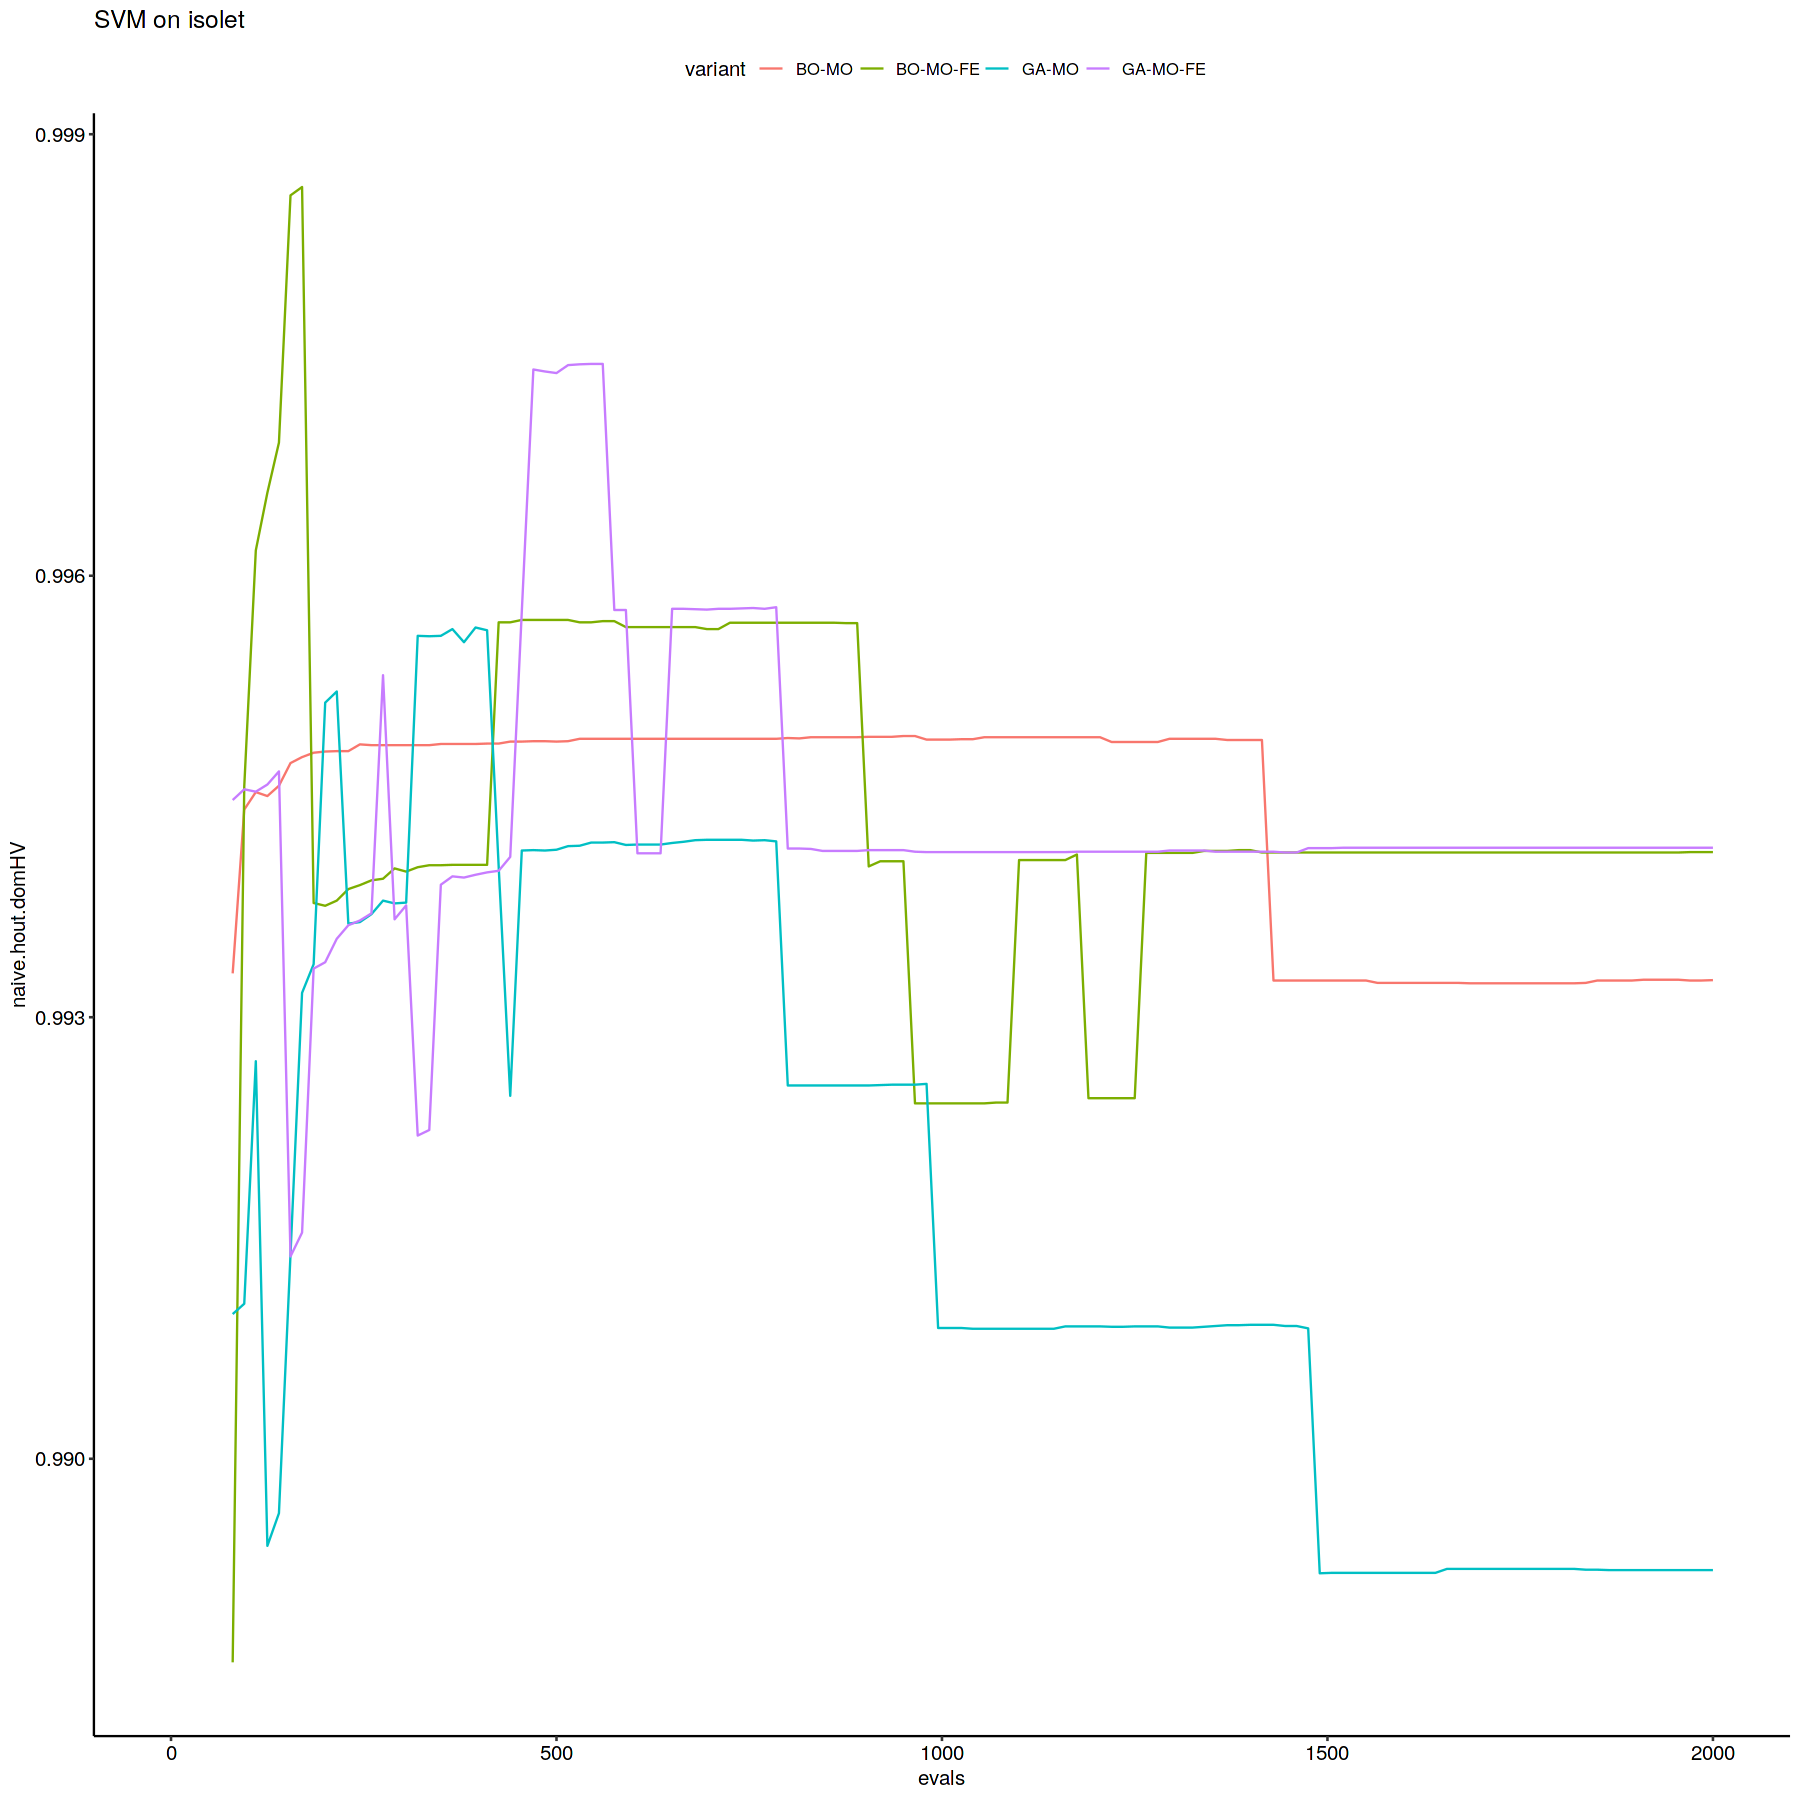

Warning message:
“Removed 268 rows containing missing values (geom_path).”


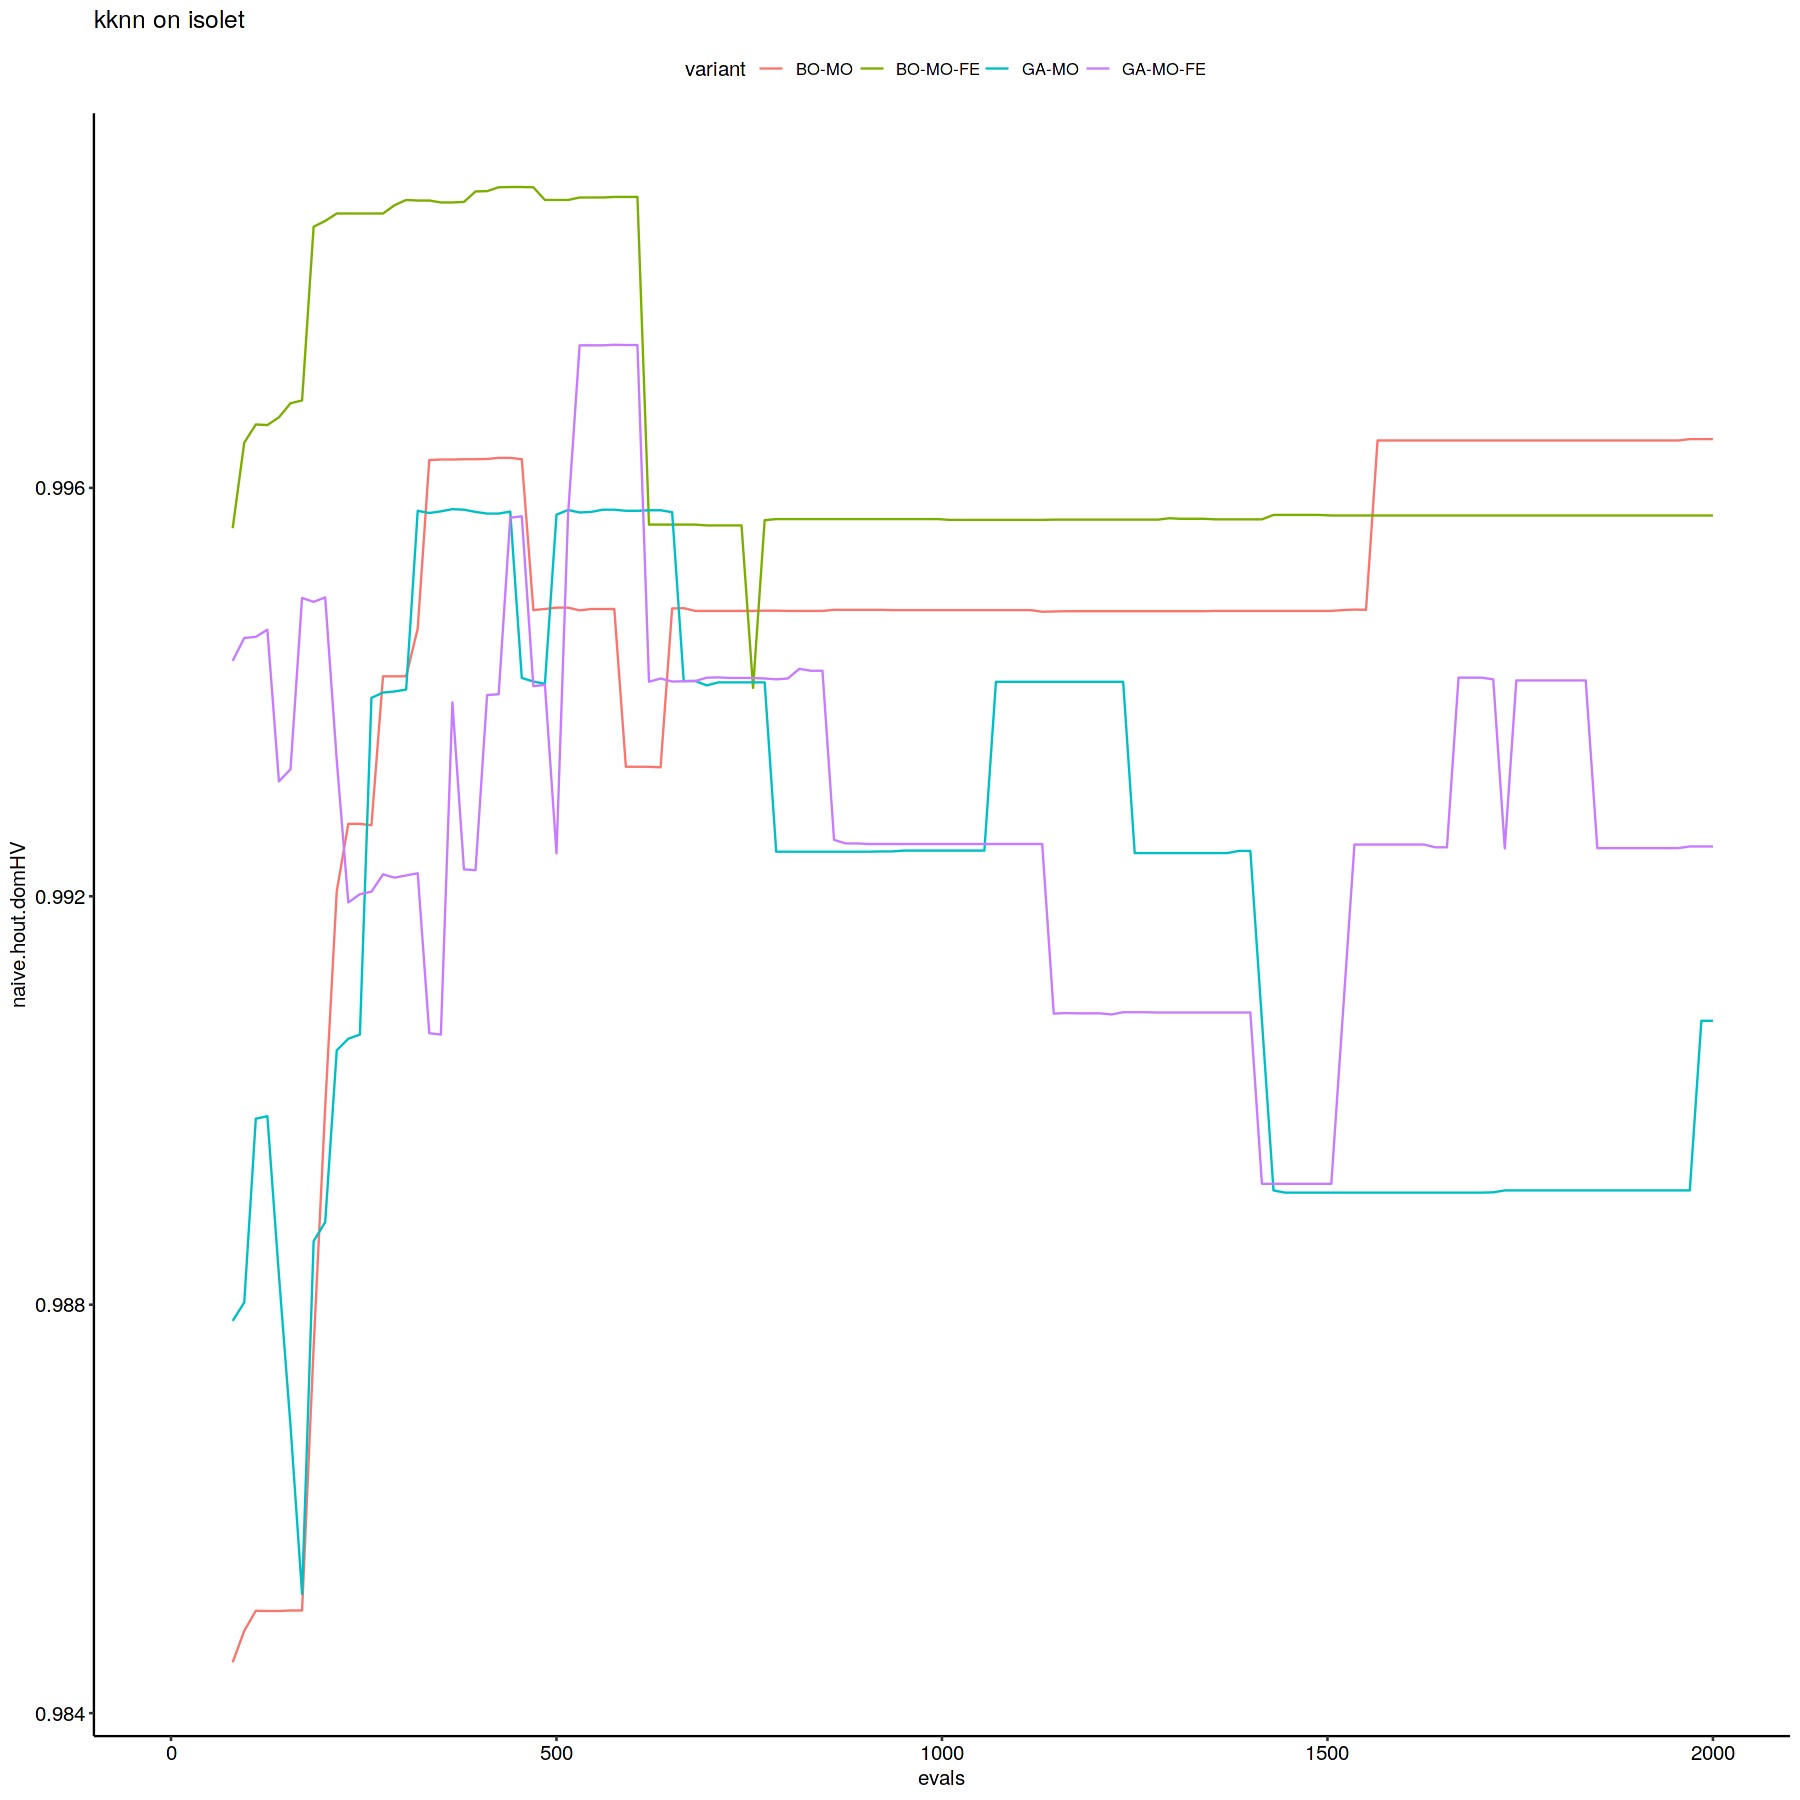

Warning message:
“Removed 269 rows containing missing values (geom_path).”


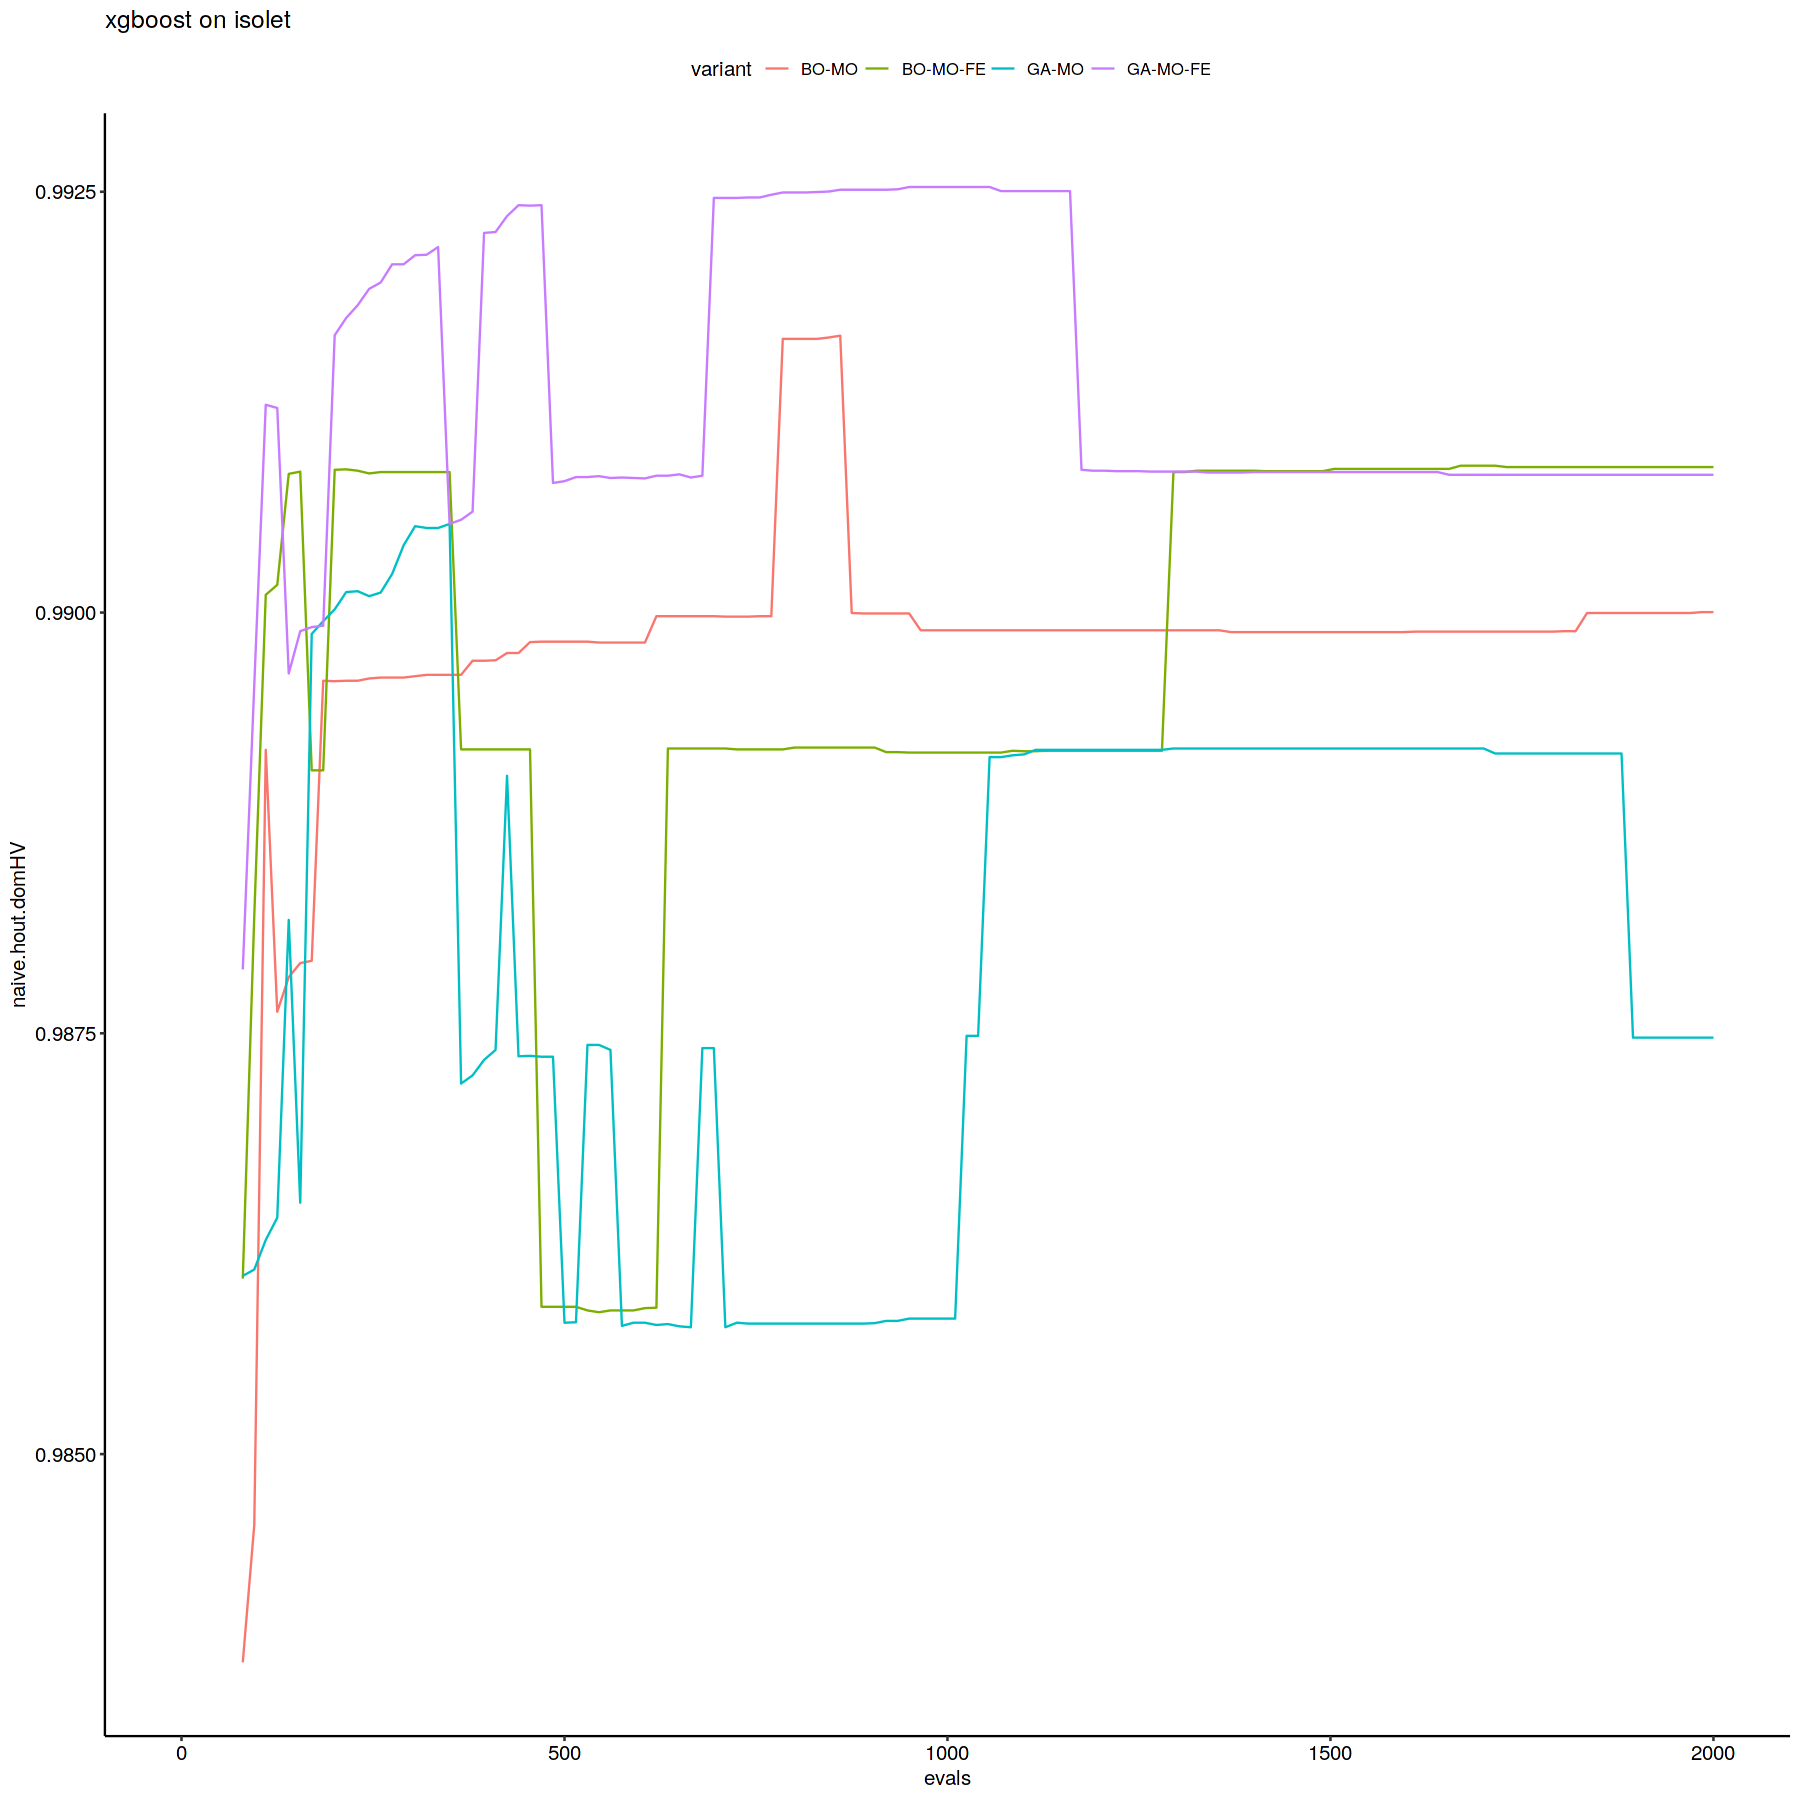

Warning message:
“Removed 268 rows containing missing values (geom_path).”


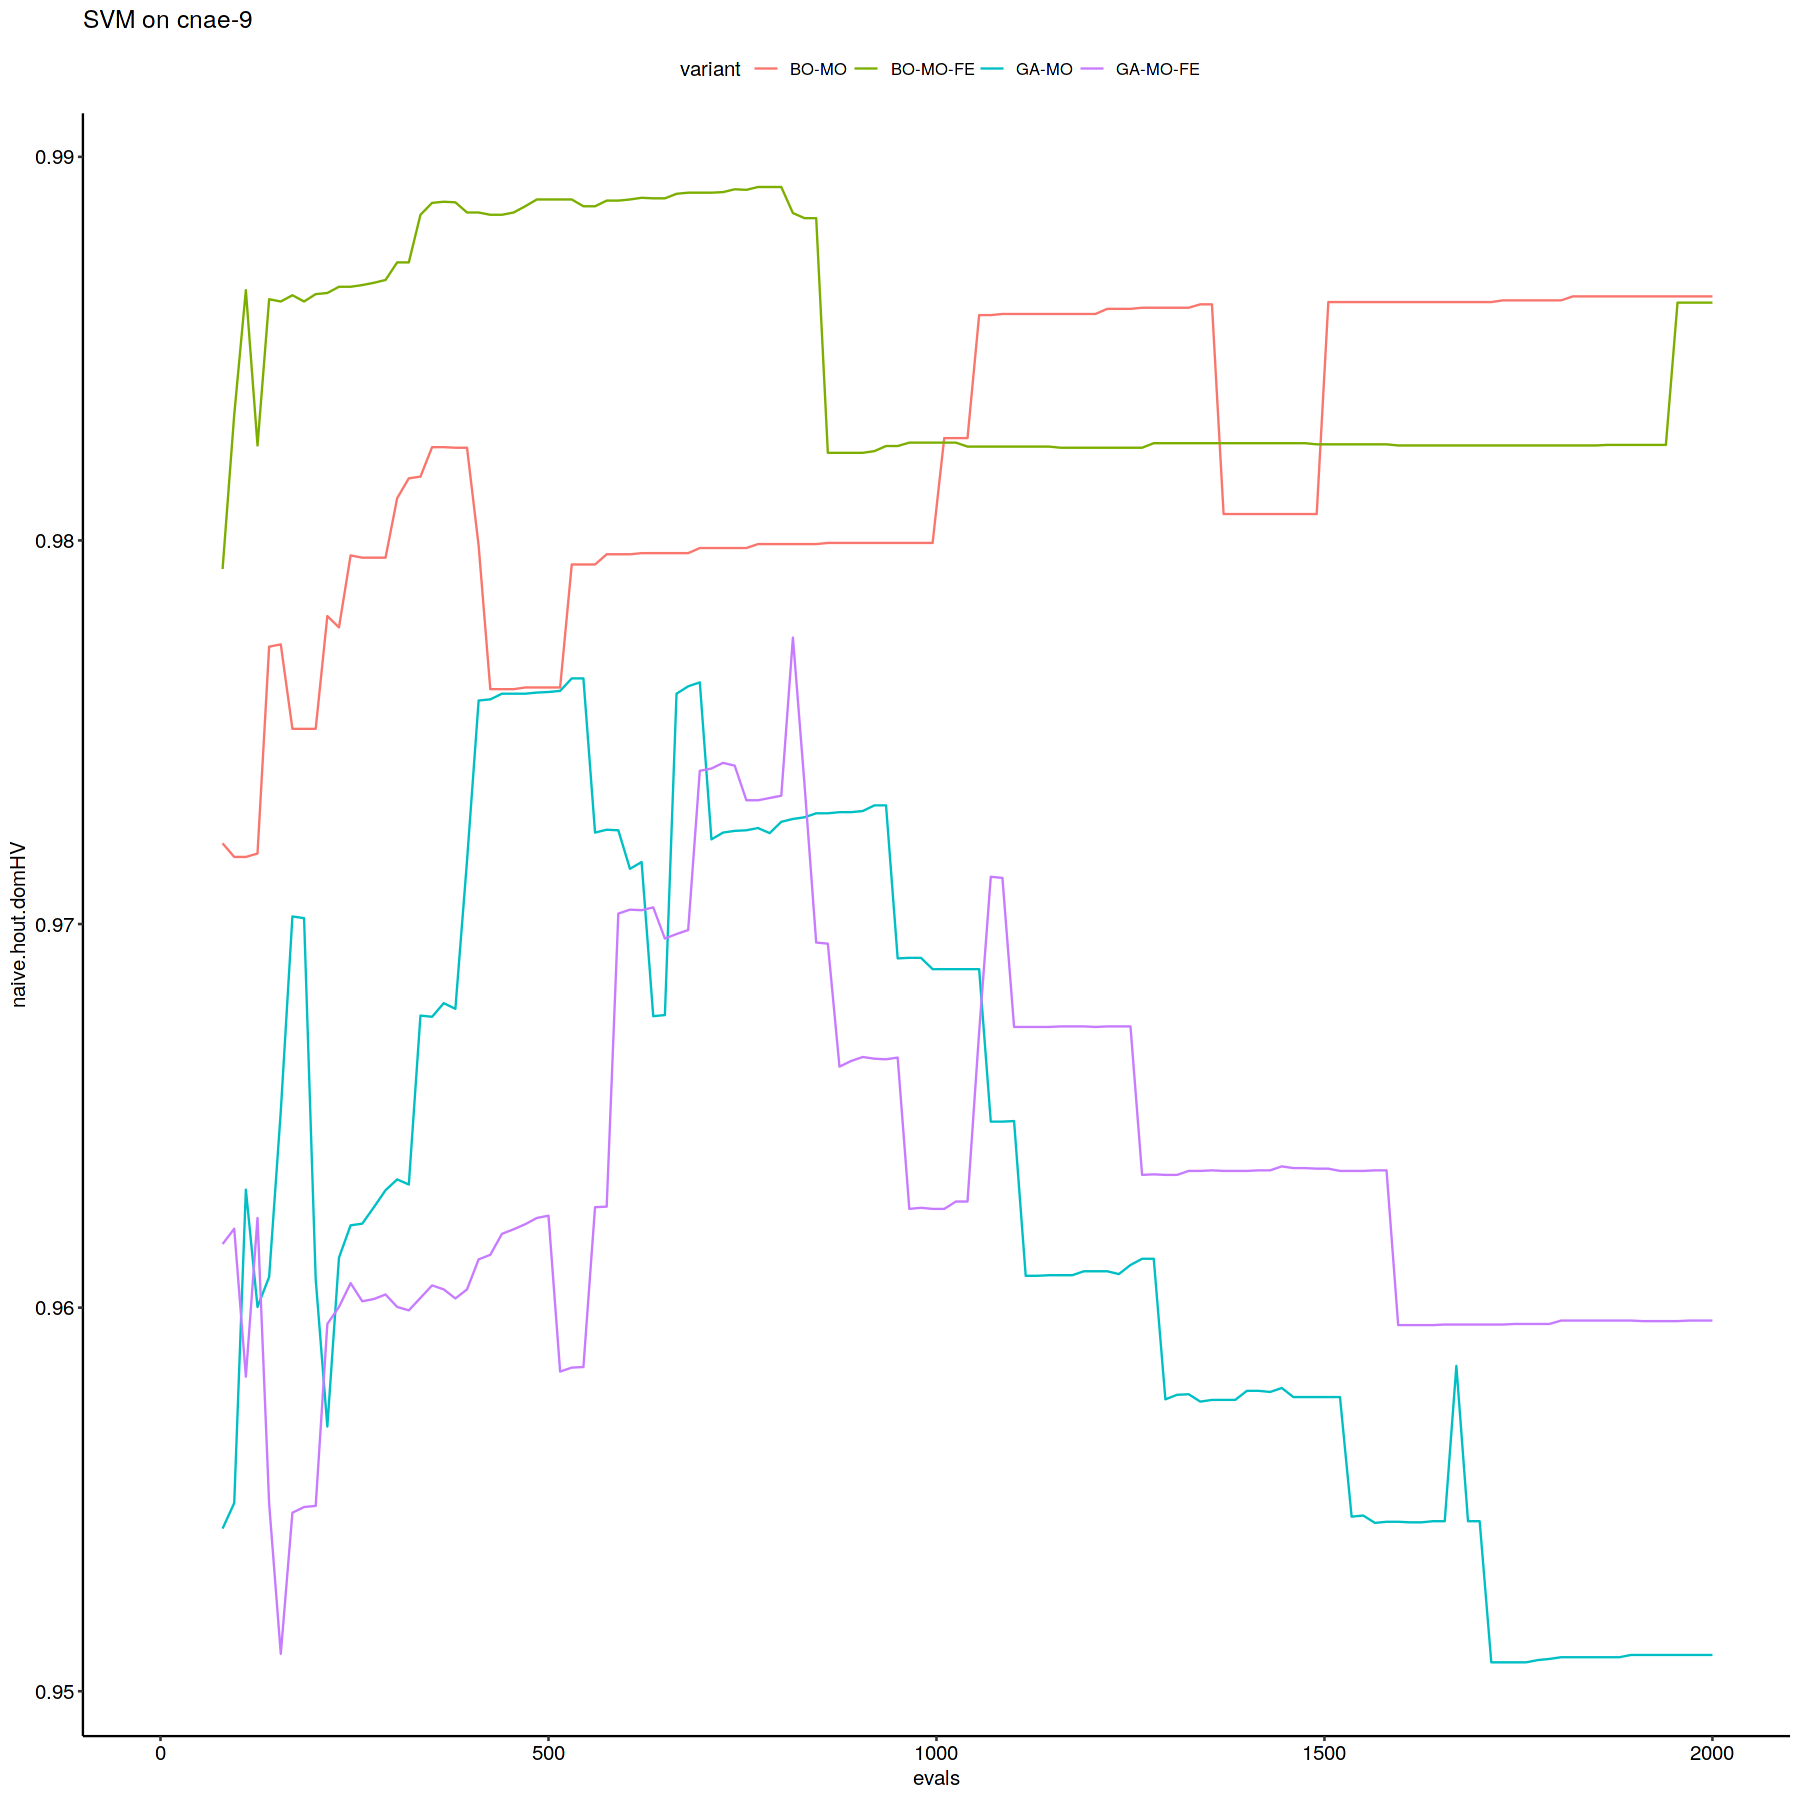

Warning message:
“Removed 268 rows containing missing values (geom_path).”


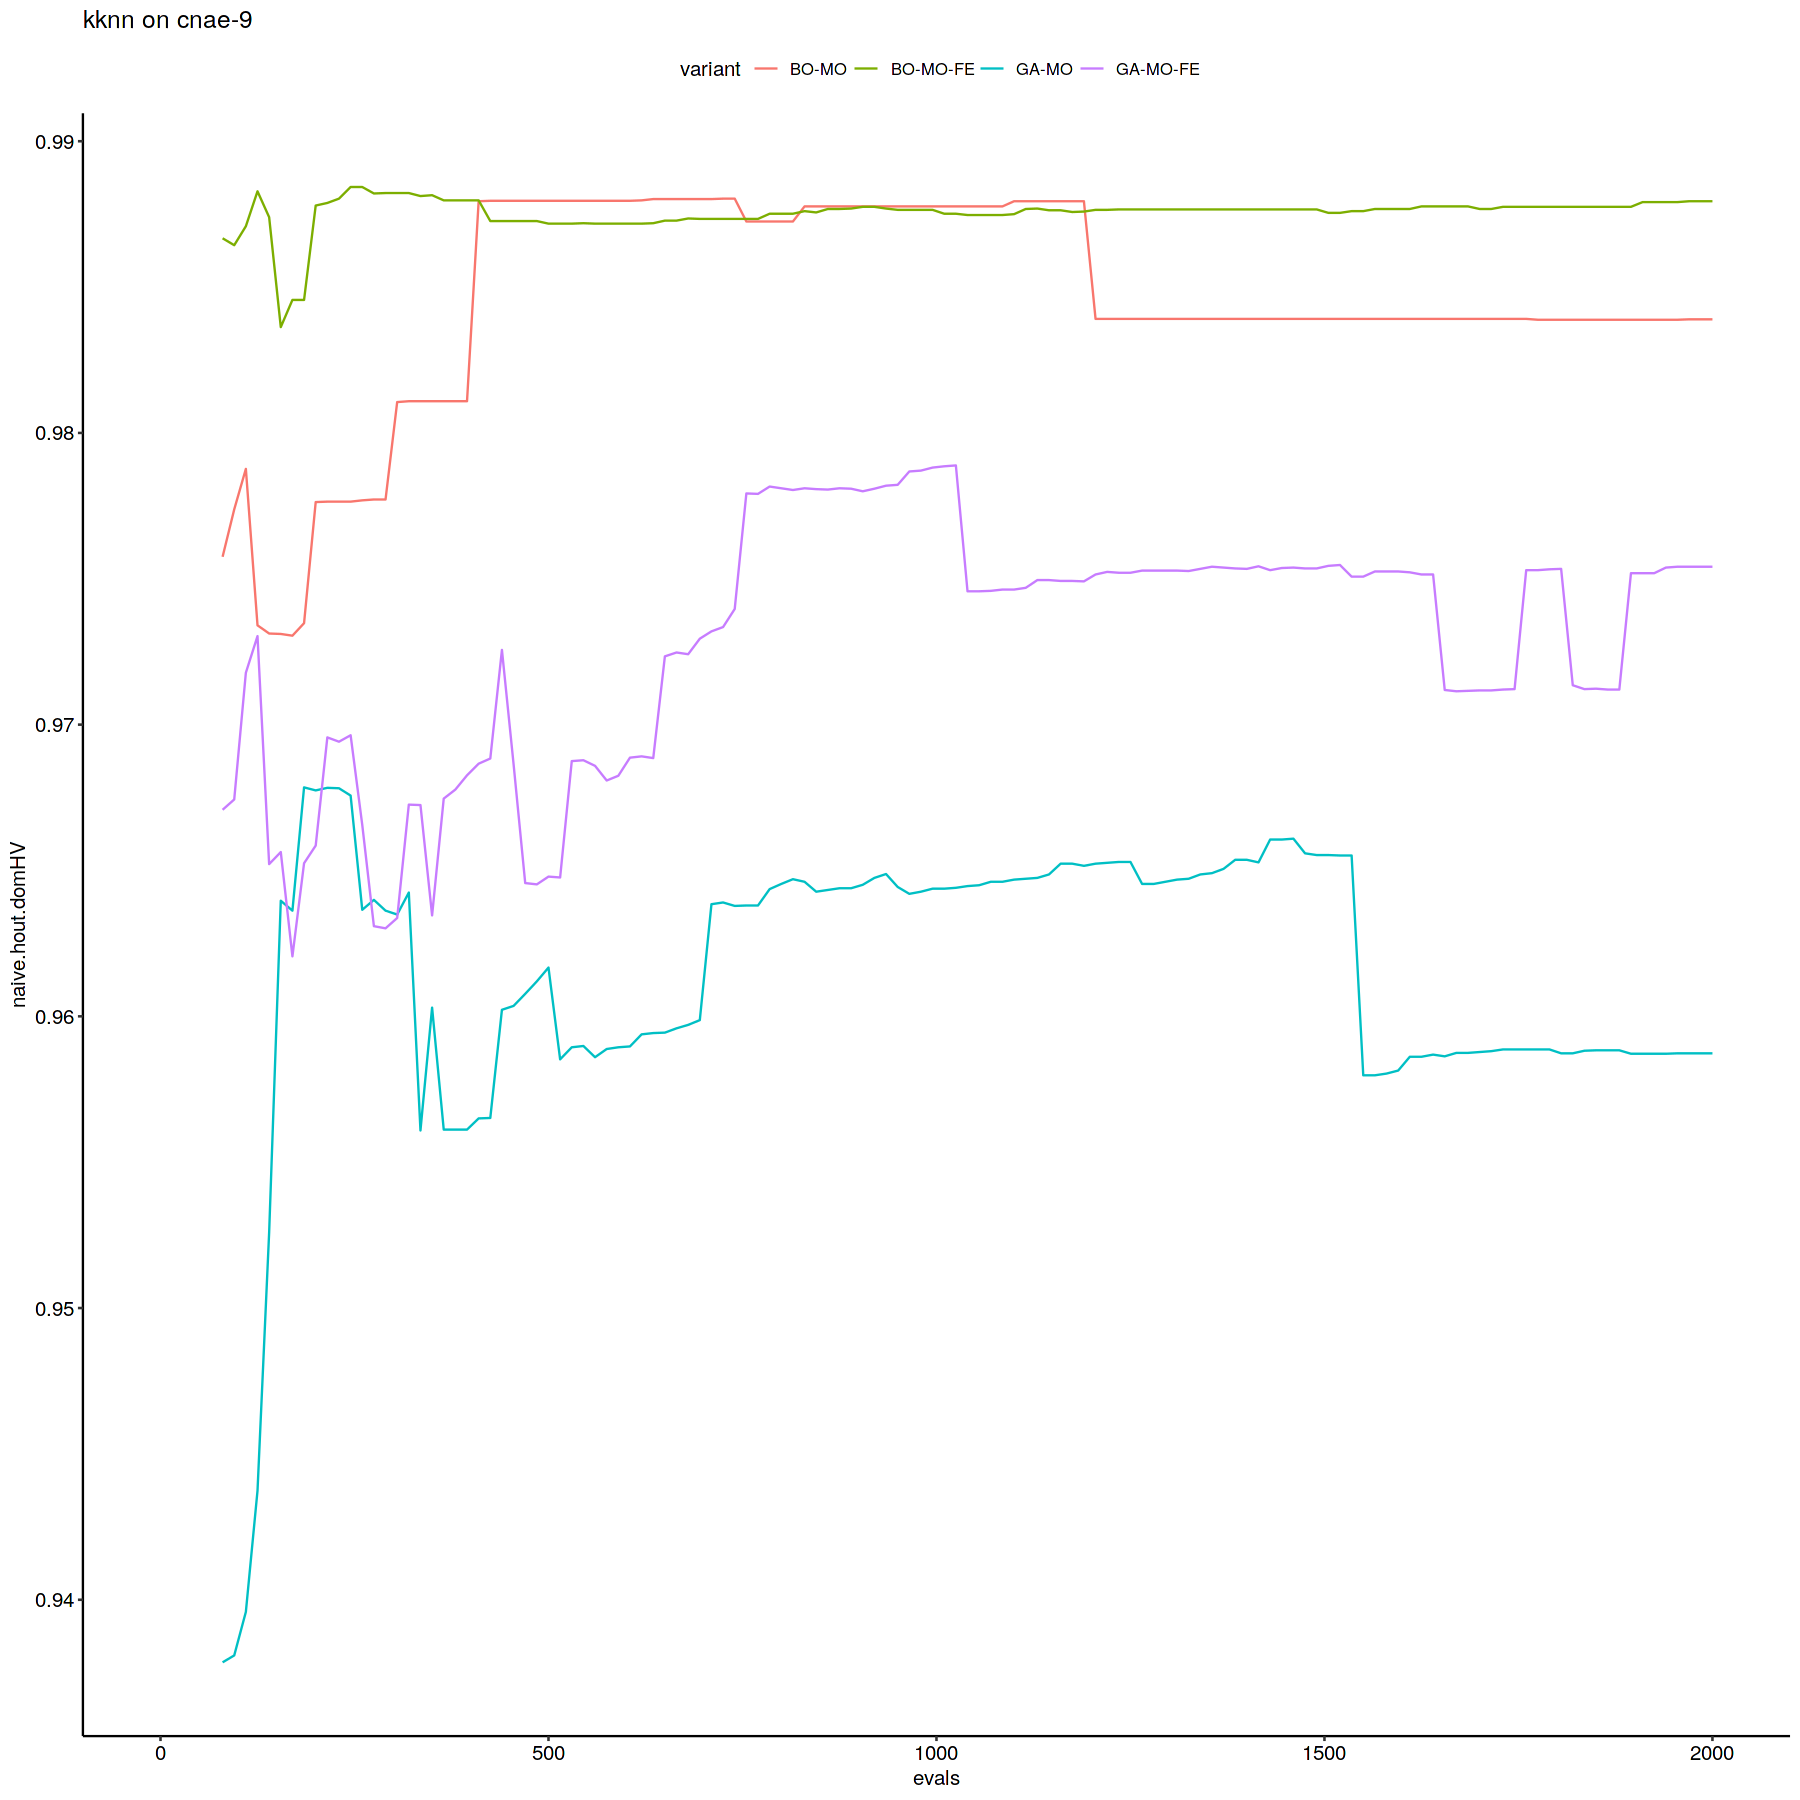

Warning message:
“Removed 269 rows containing missing values (geom_path).”


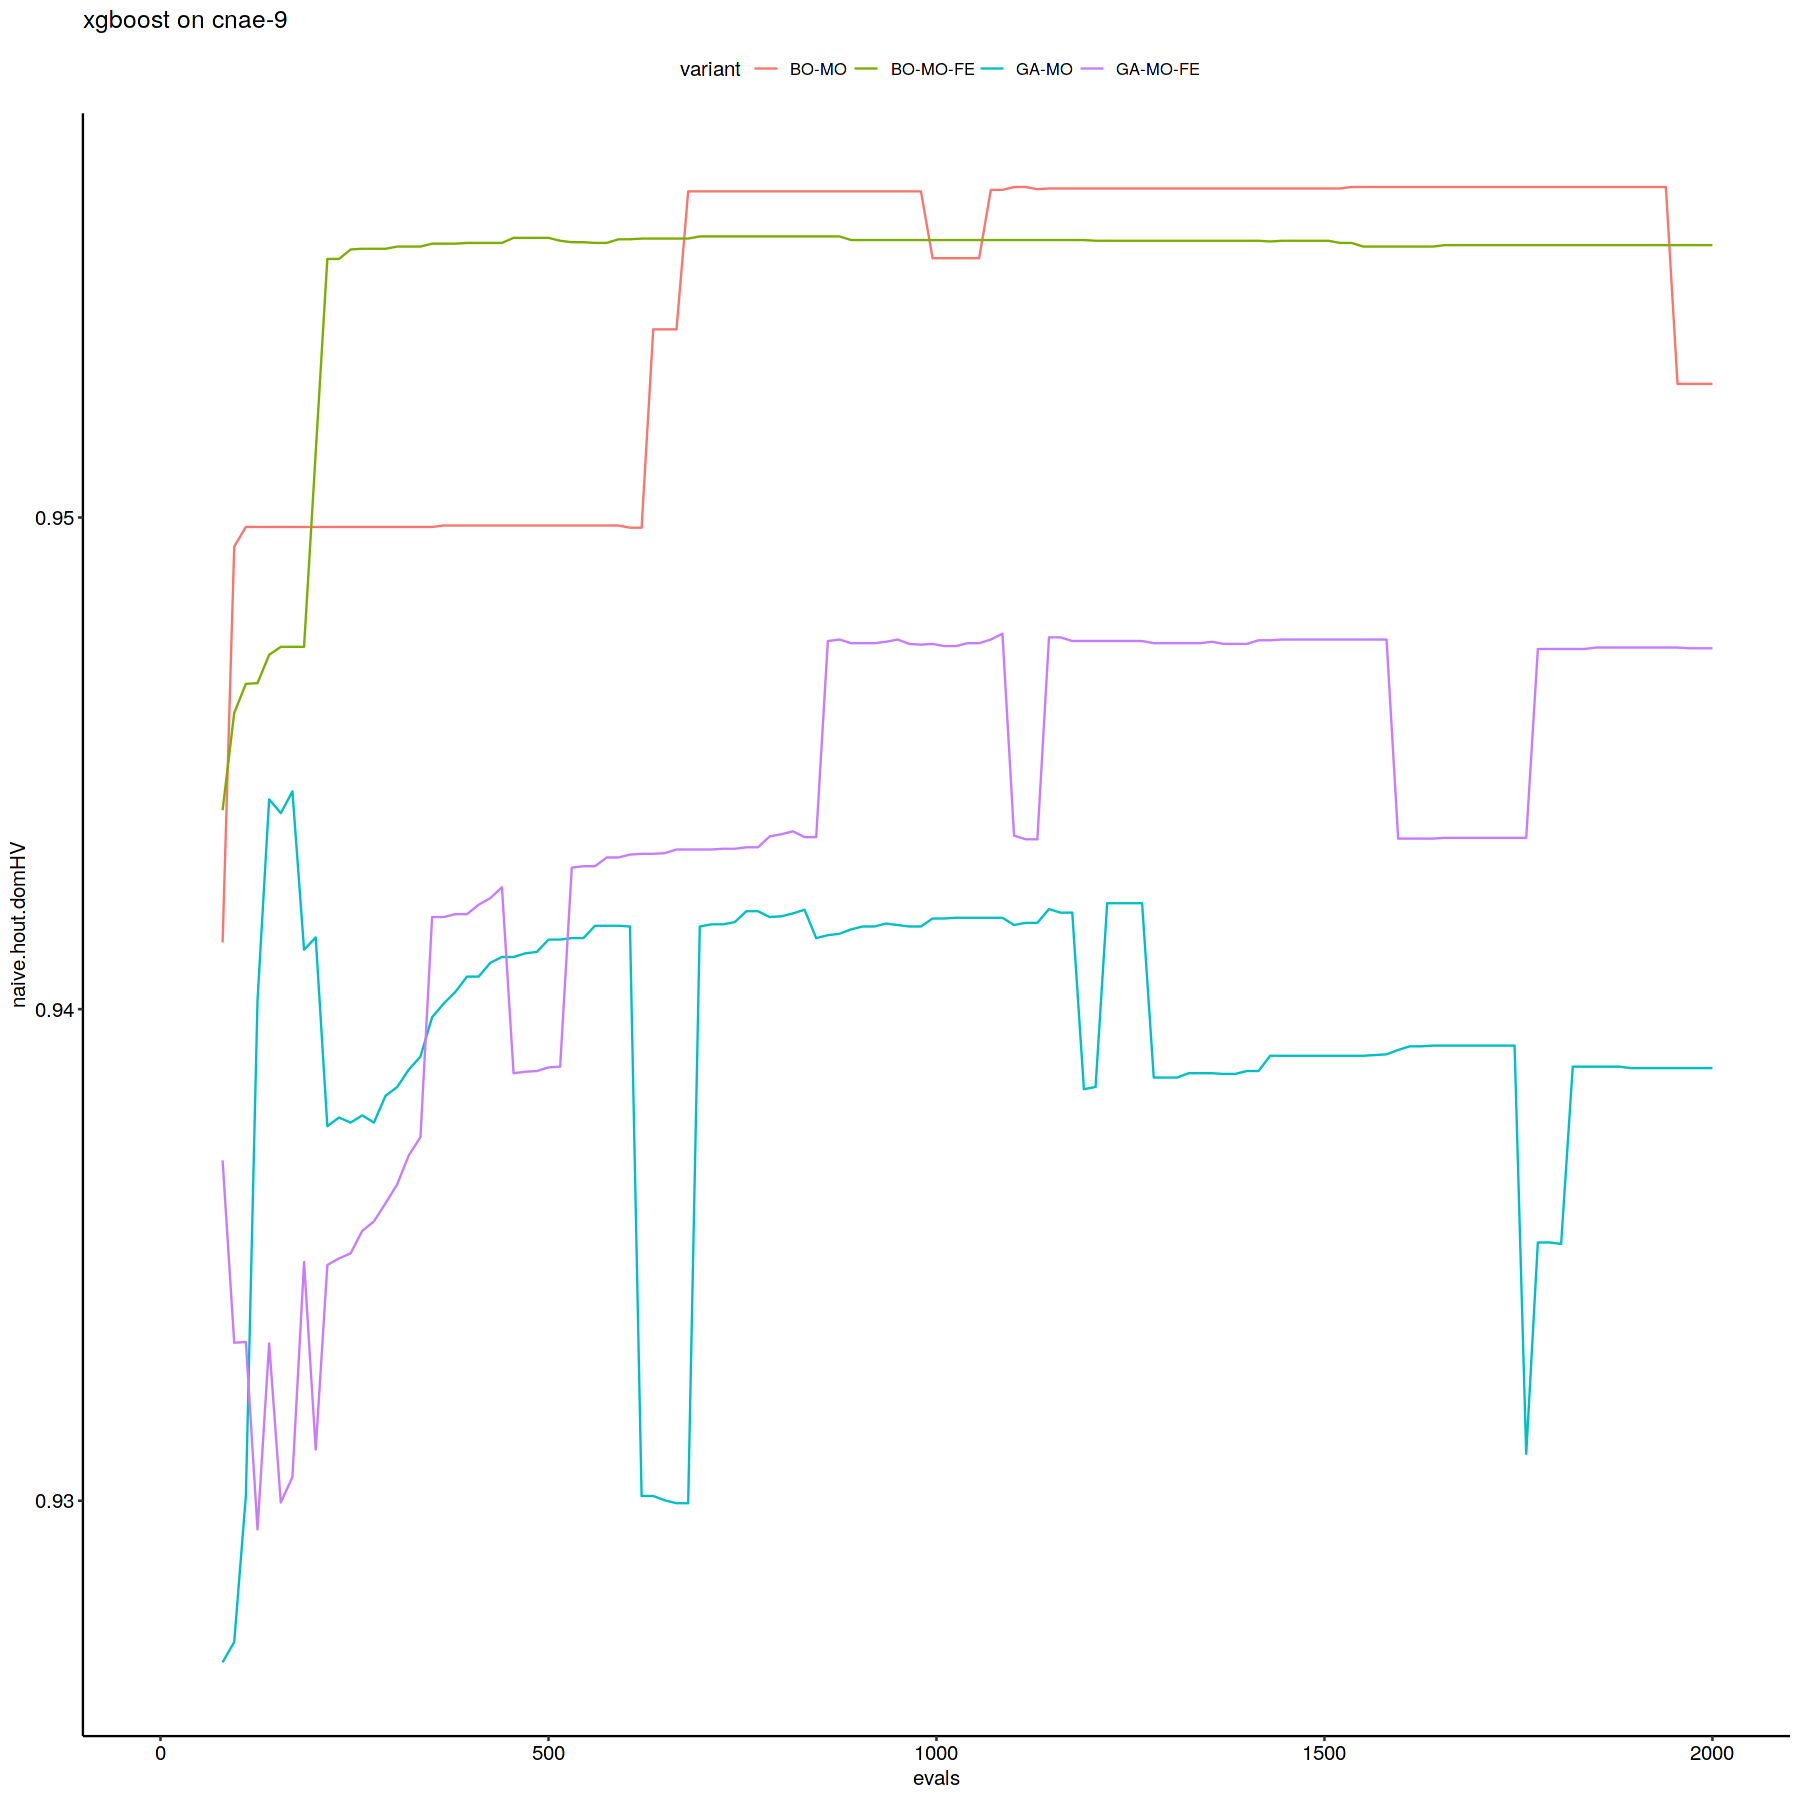

Warning message:
“Removed 268 rows containing missing values (geom_path).”


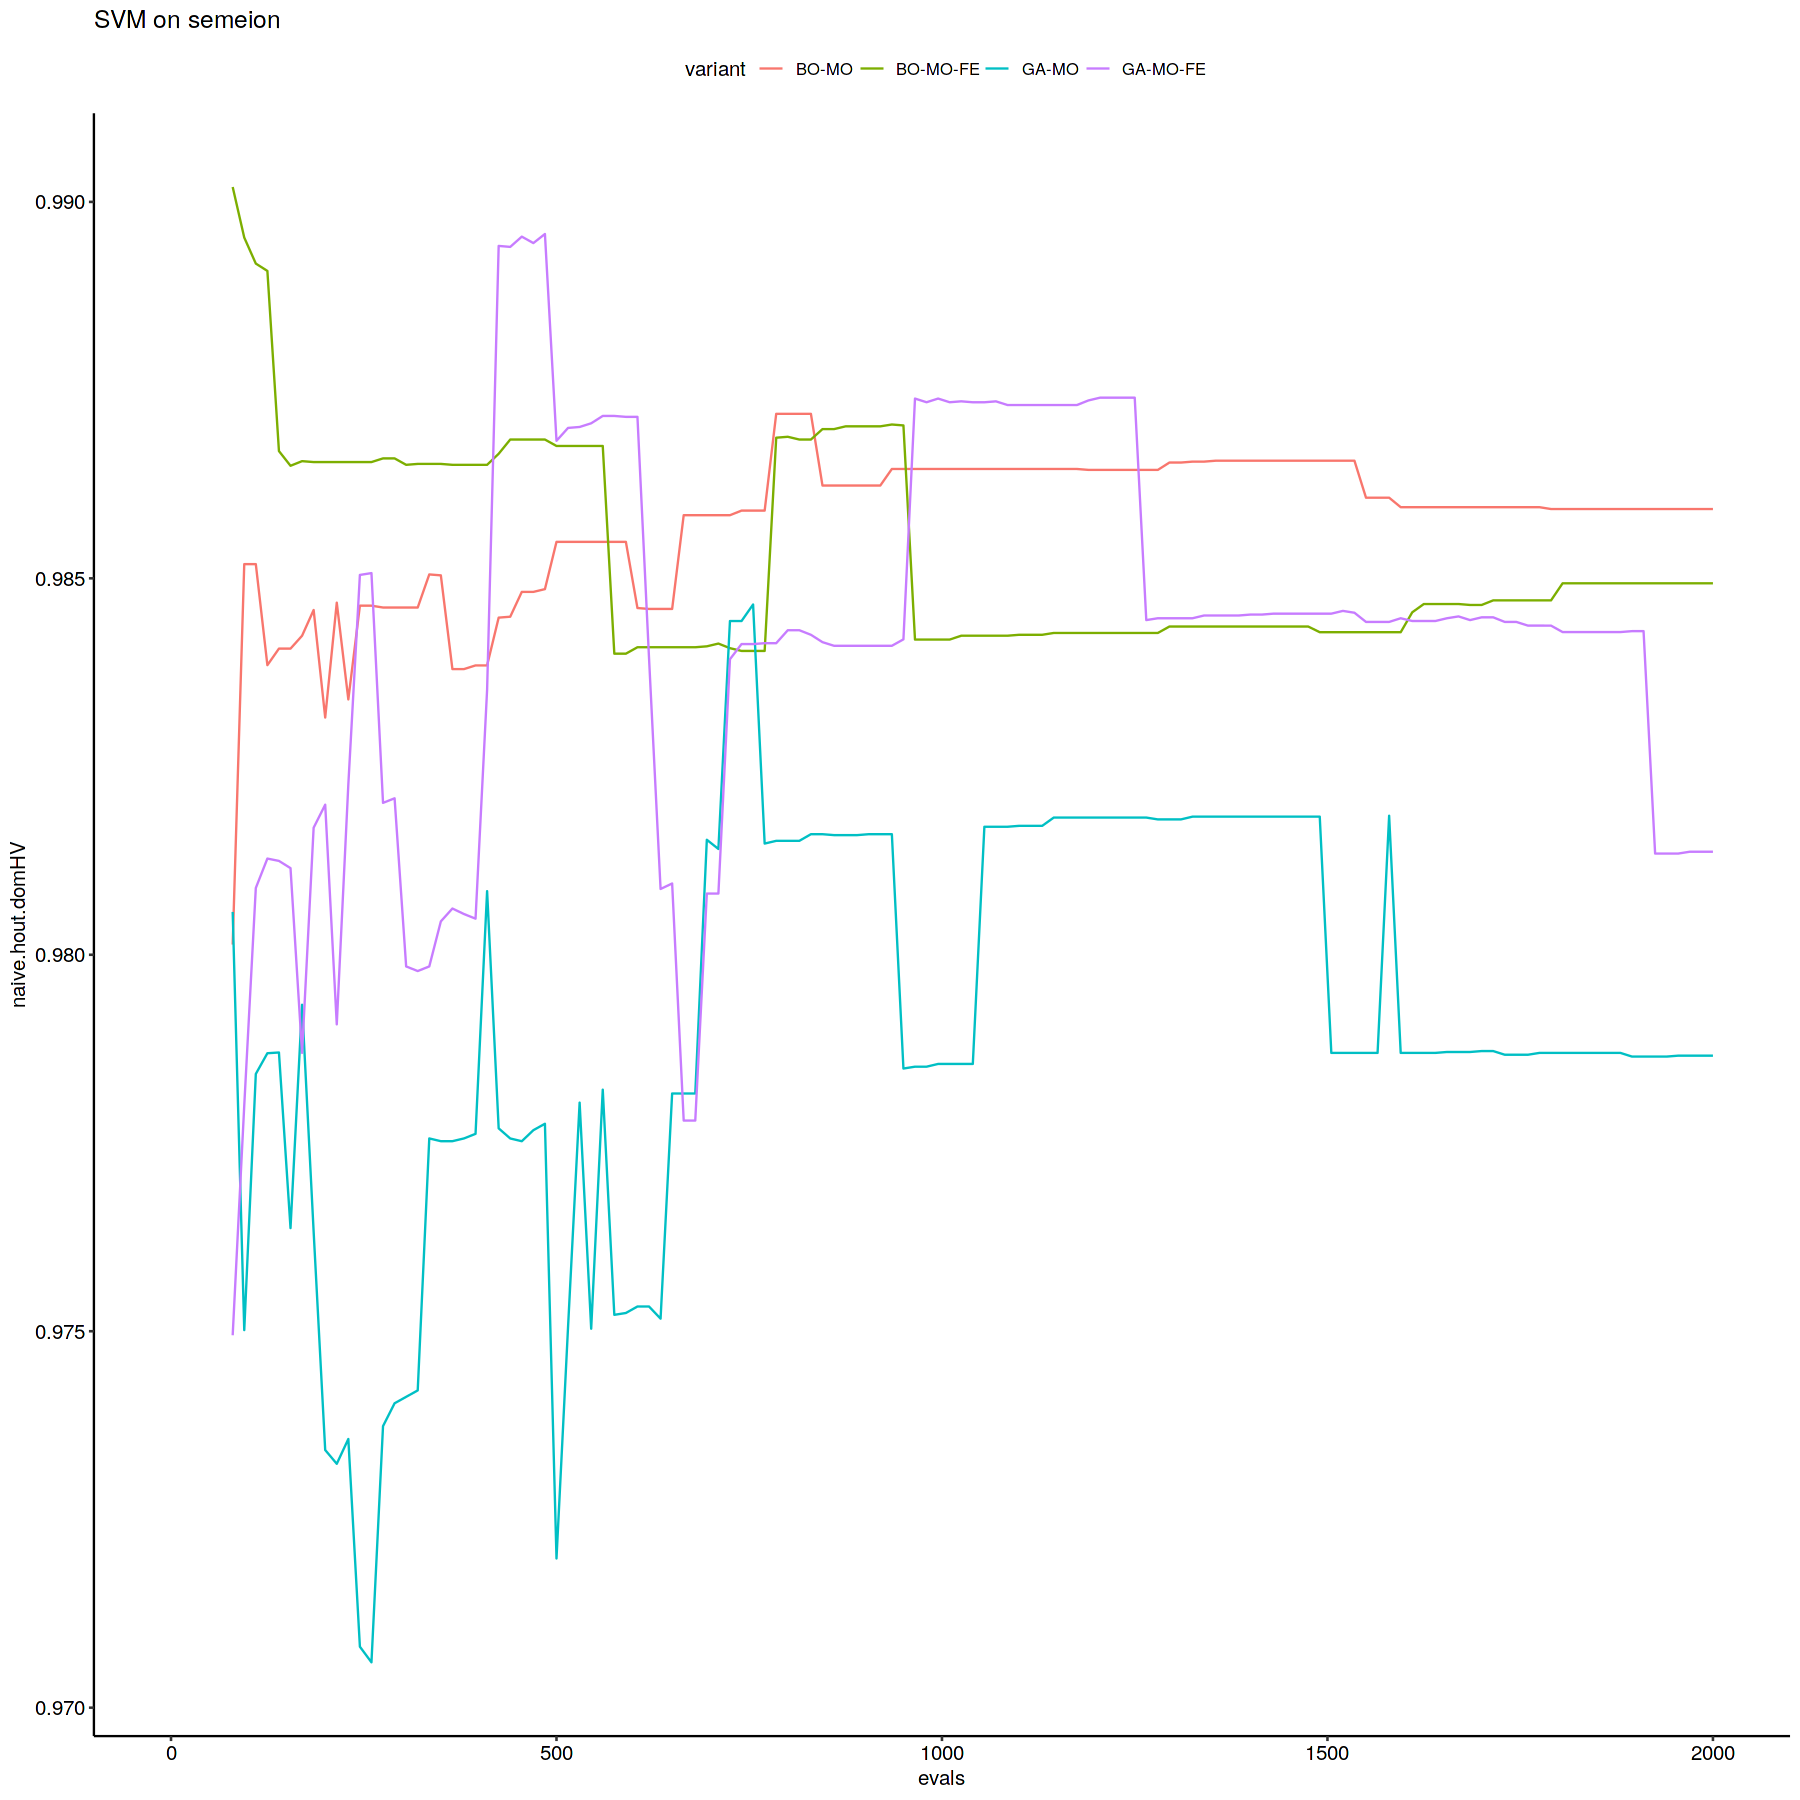

Warning message:
“Removed 268 rows containing missing values (geom_path).”


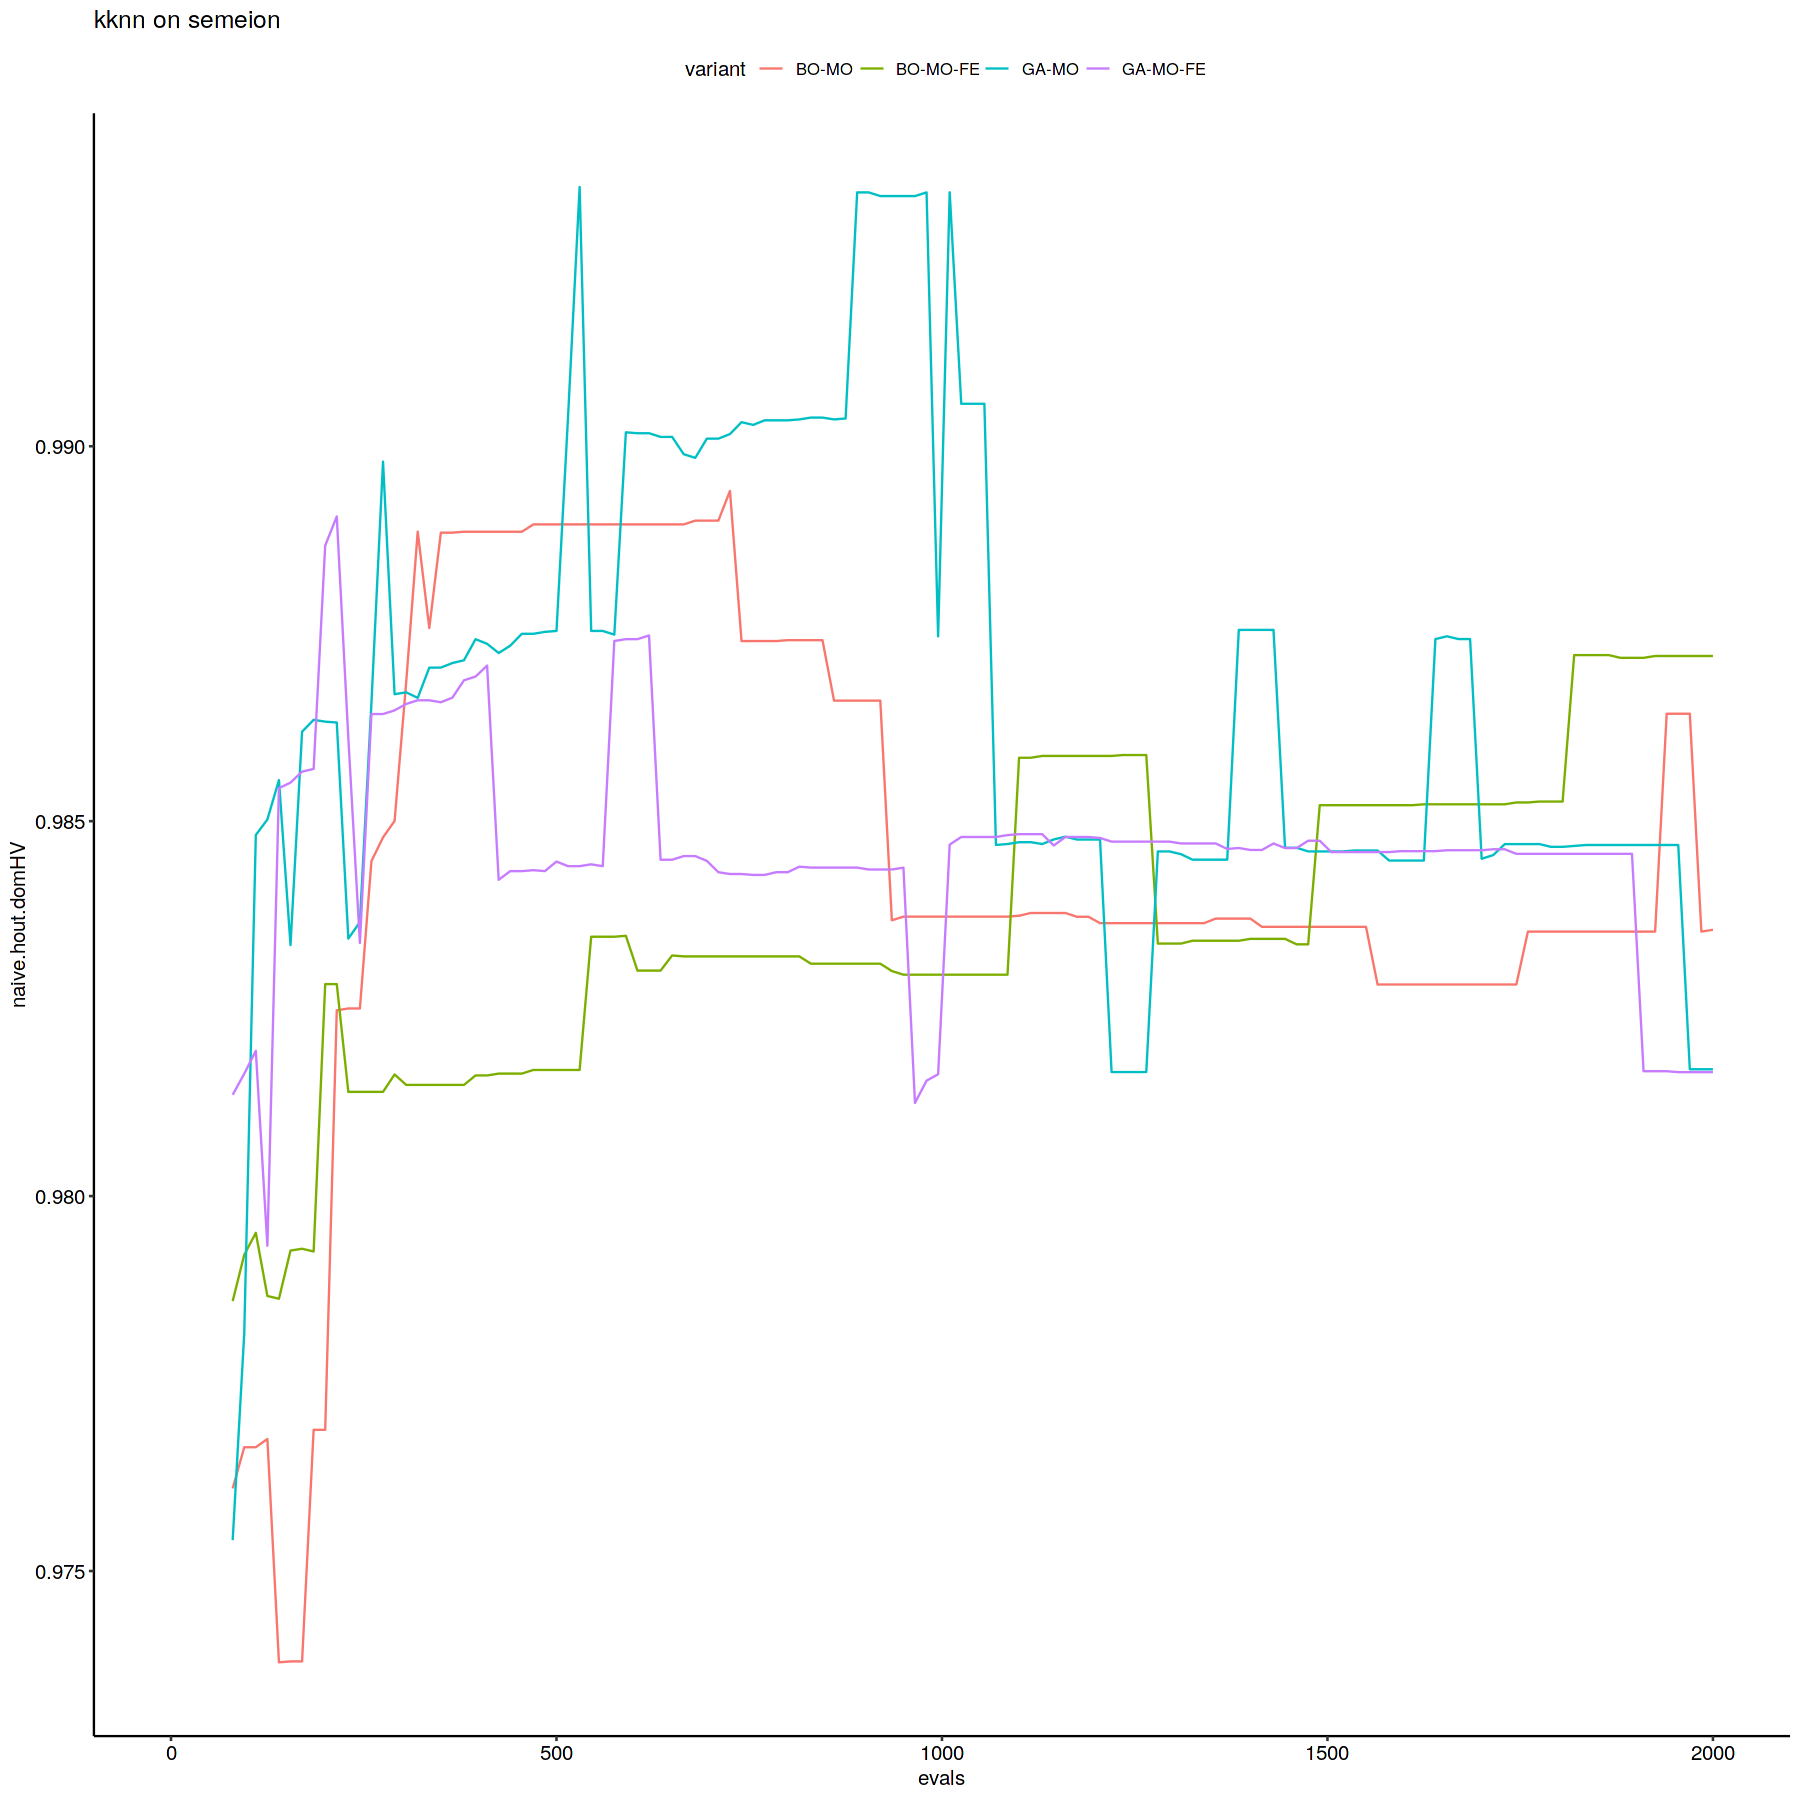

Warning message:
“Removed 2 rows containing missing values (geom_path).”


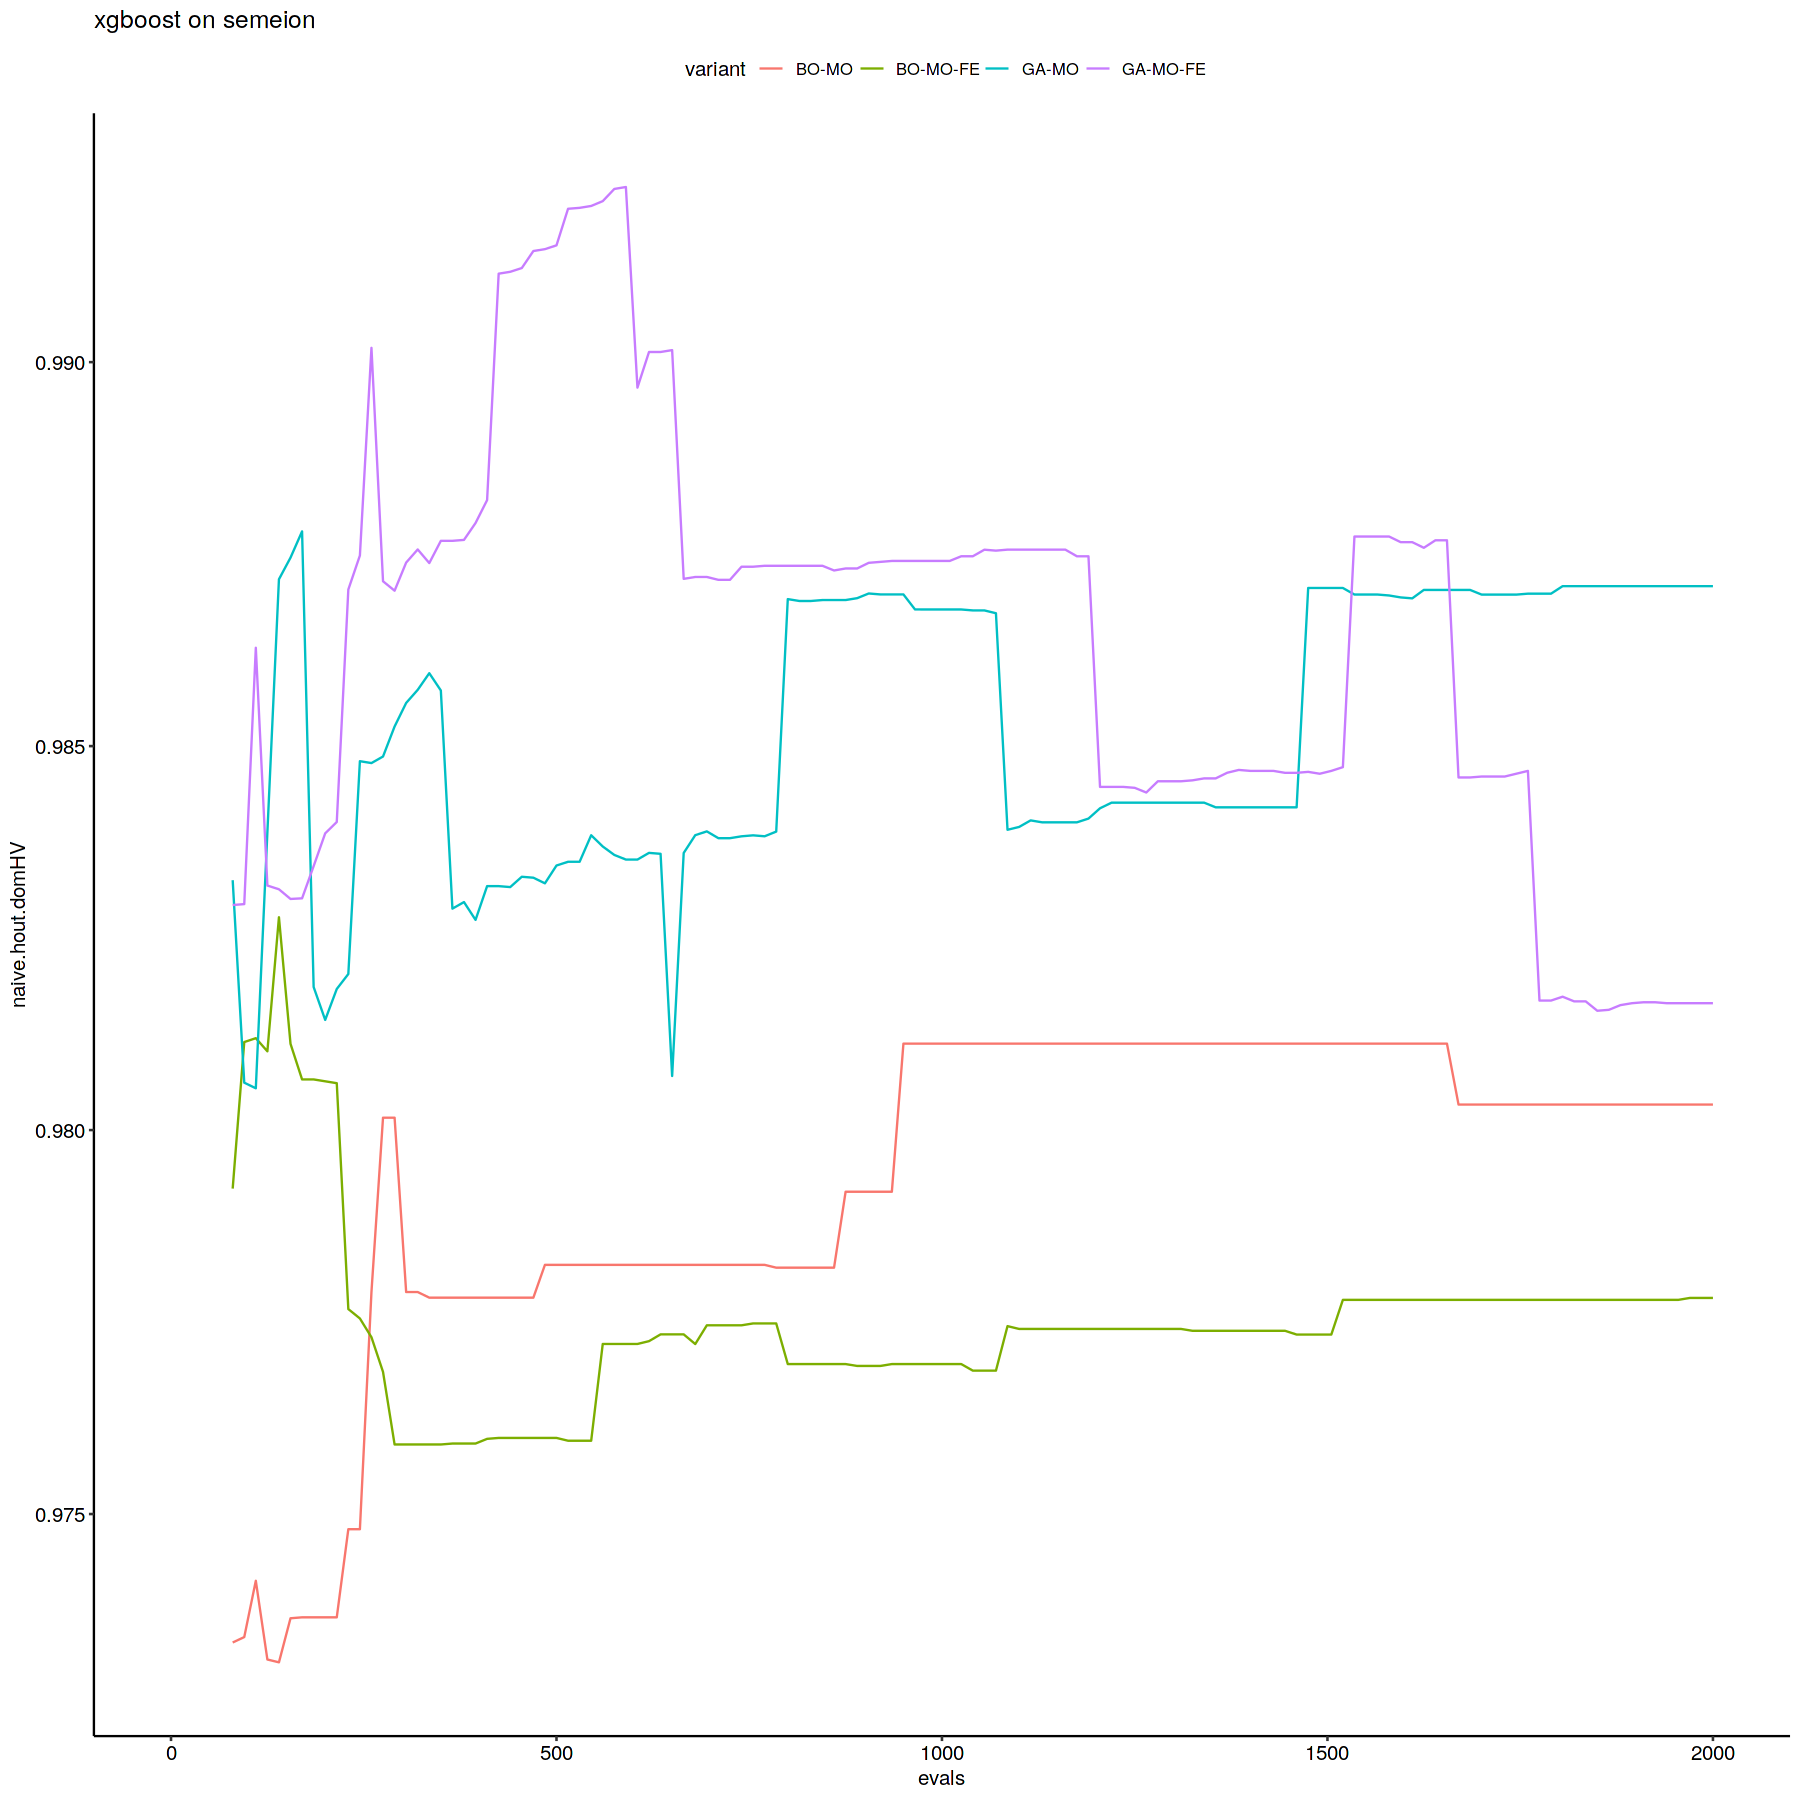

Warning message:
“Removed 1 rows containing missing values (geom_path).”


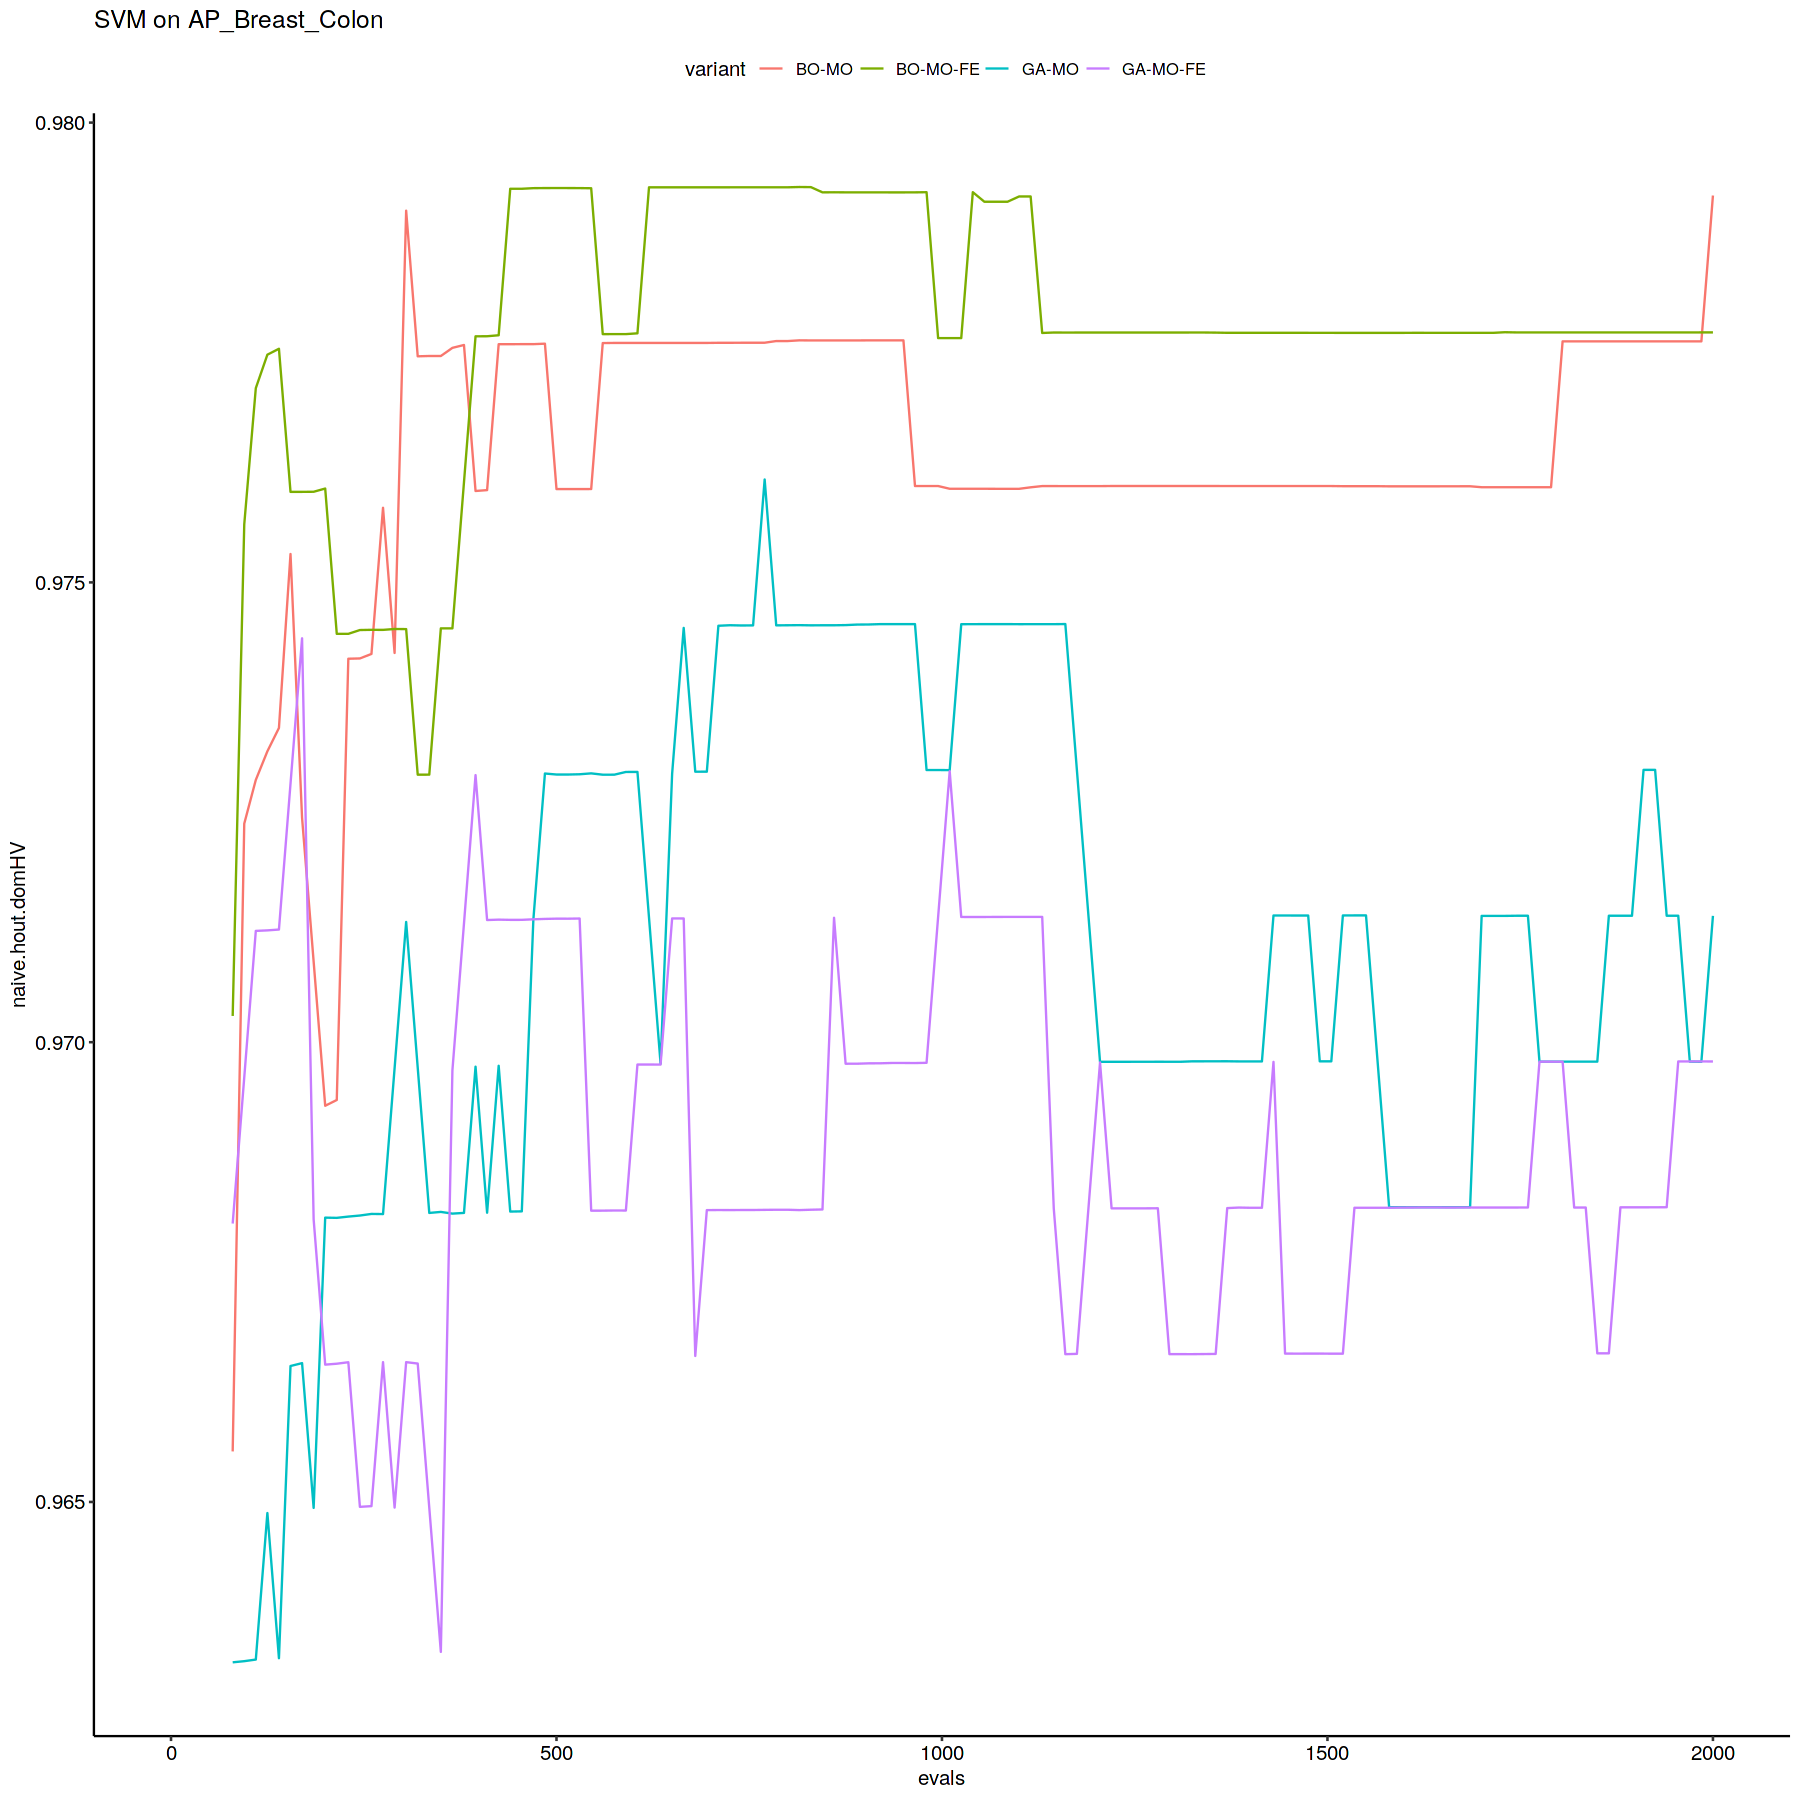

Warning message:
“Removed 2 rows containing missing values (geom_path).”


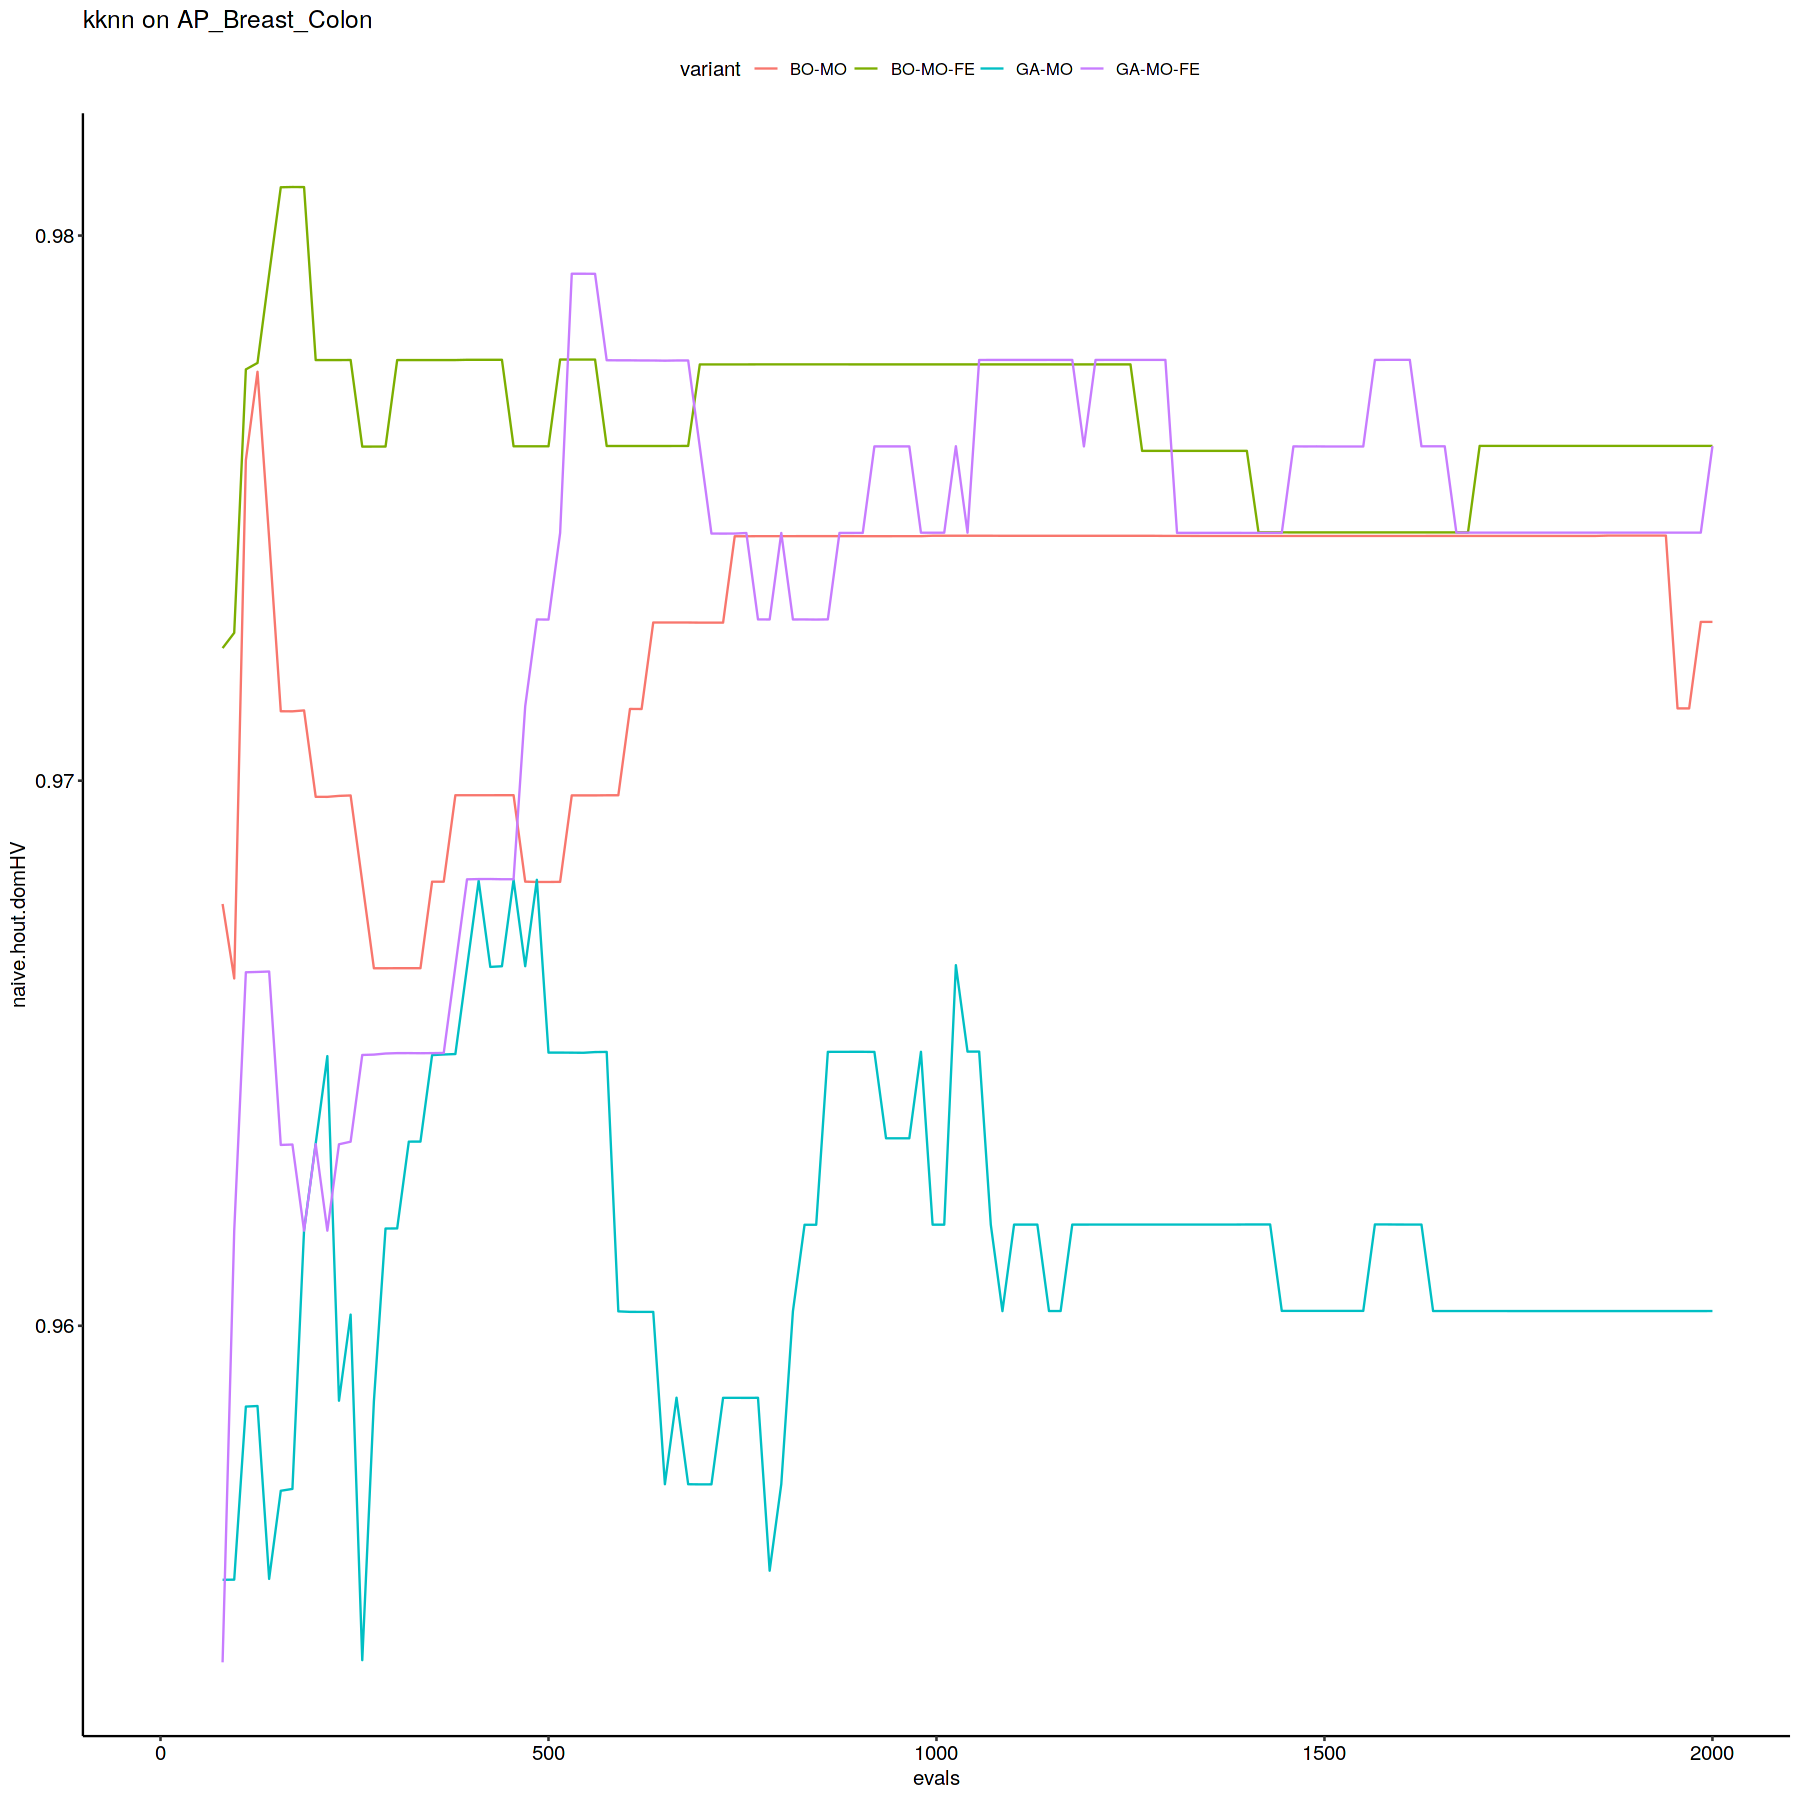

Warning message:
“Removed 2 rows containing missing values (geom_path).”


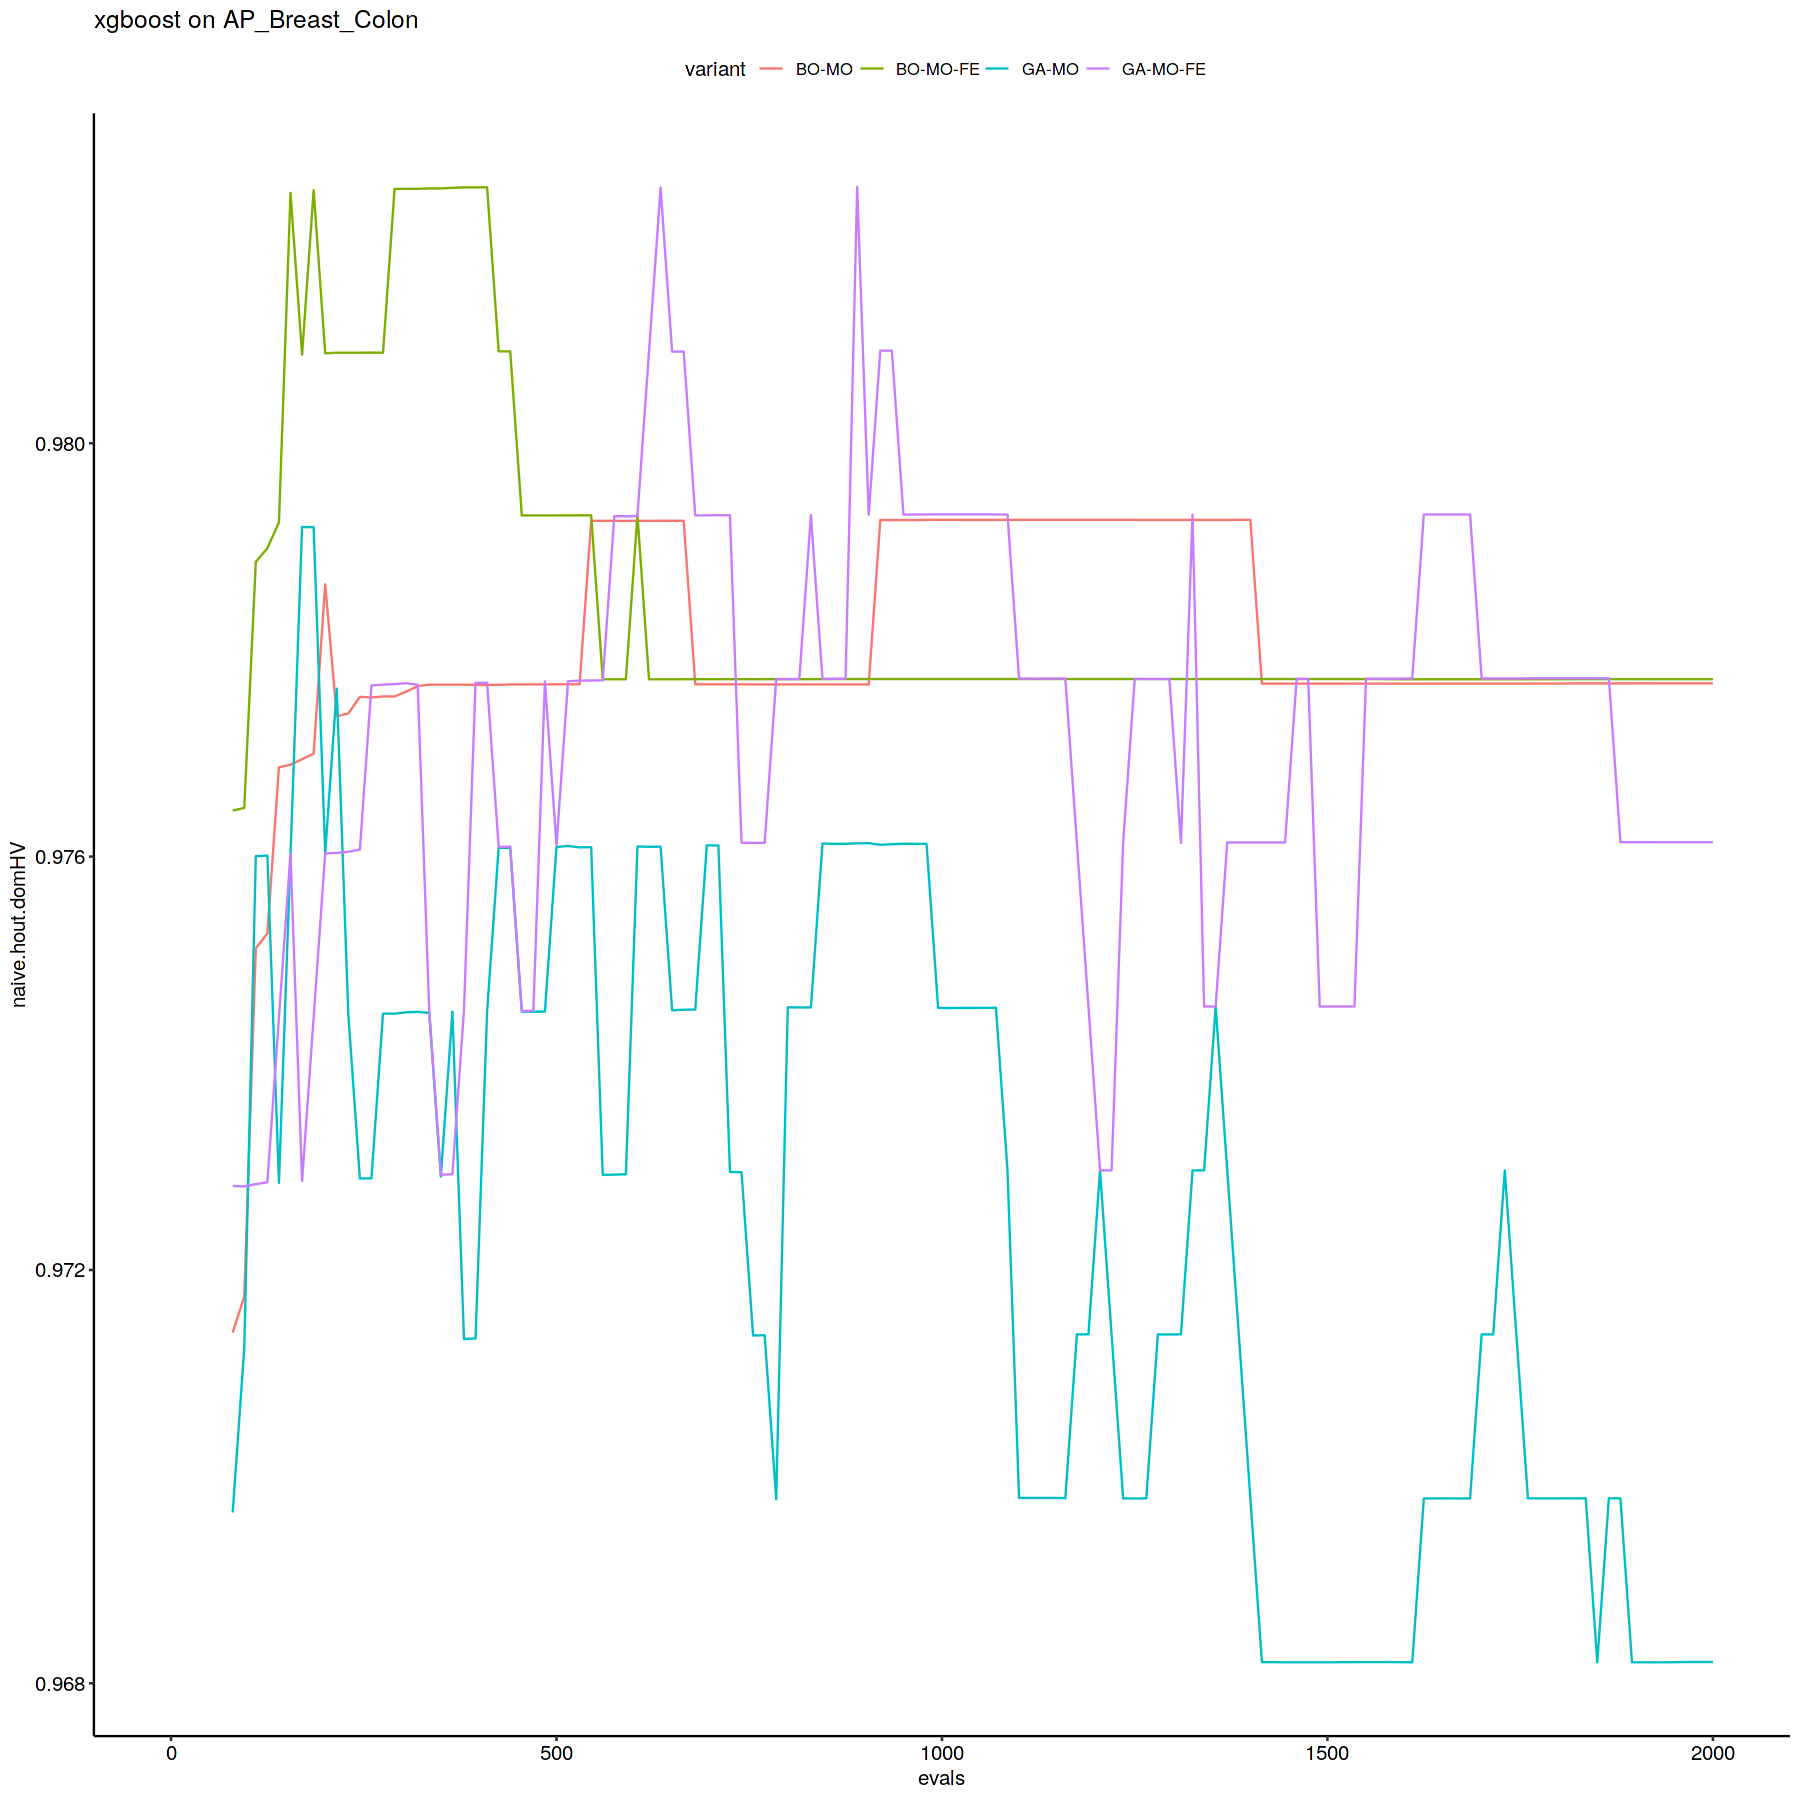

Warning message:
“Removed 1 rows containing missing values (geom_path).”


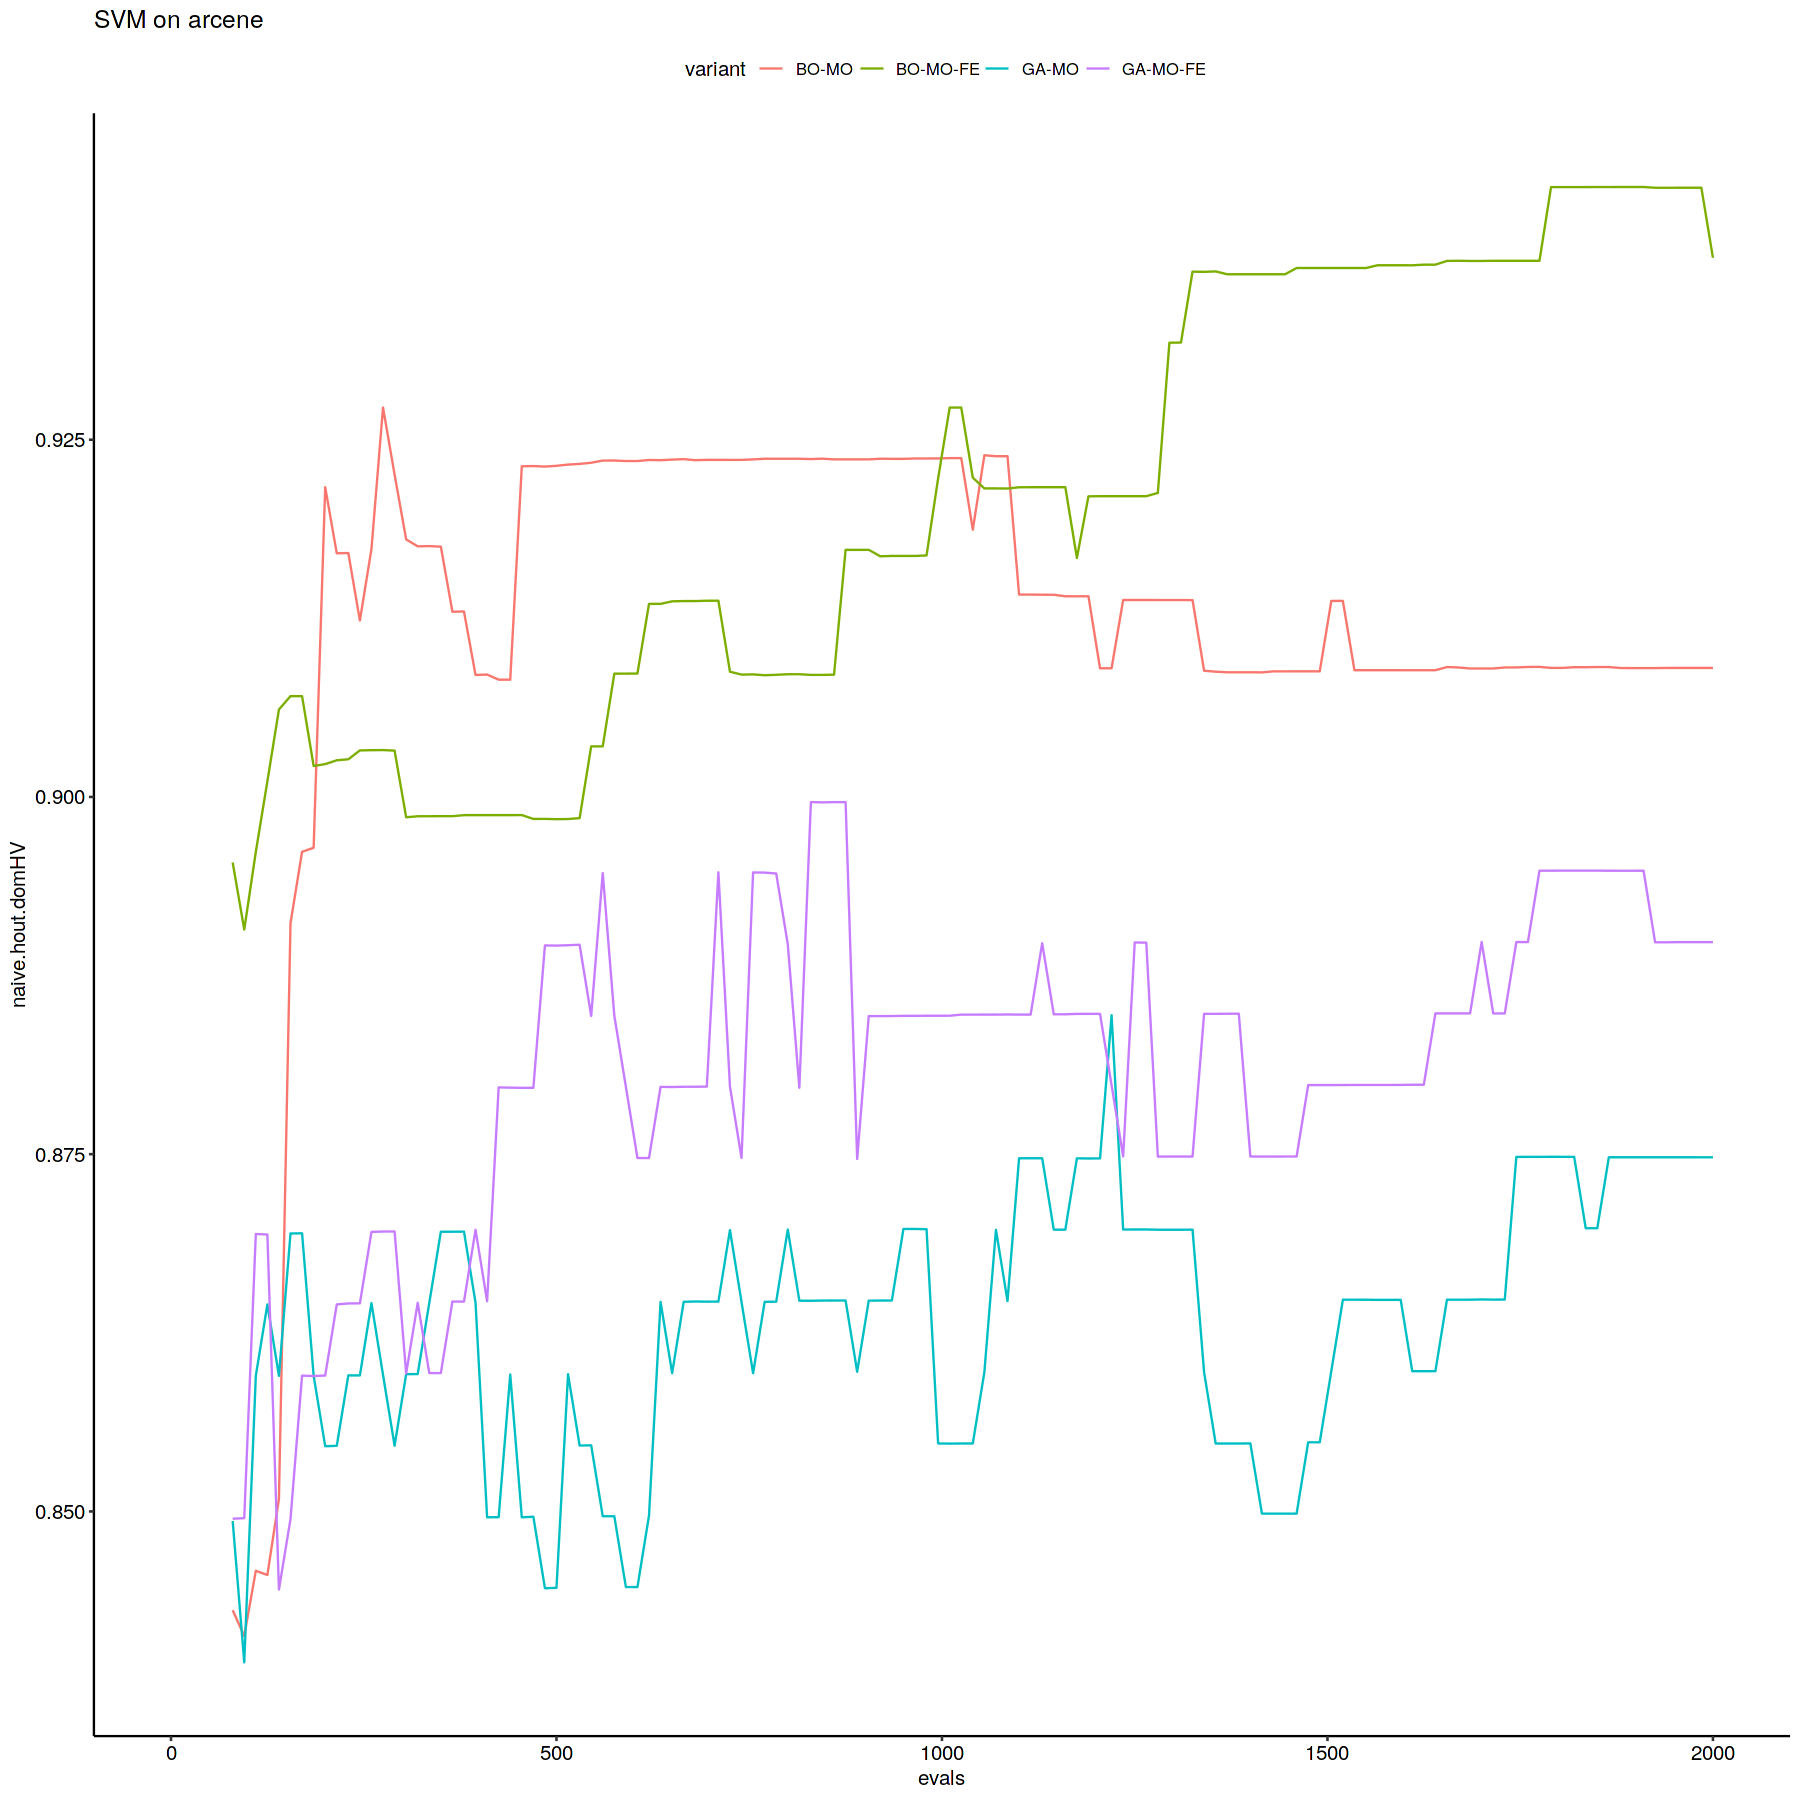

Warning message:
“Removed 2 rows containing missing values (geom_path).”


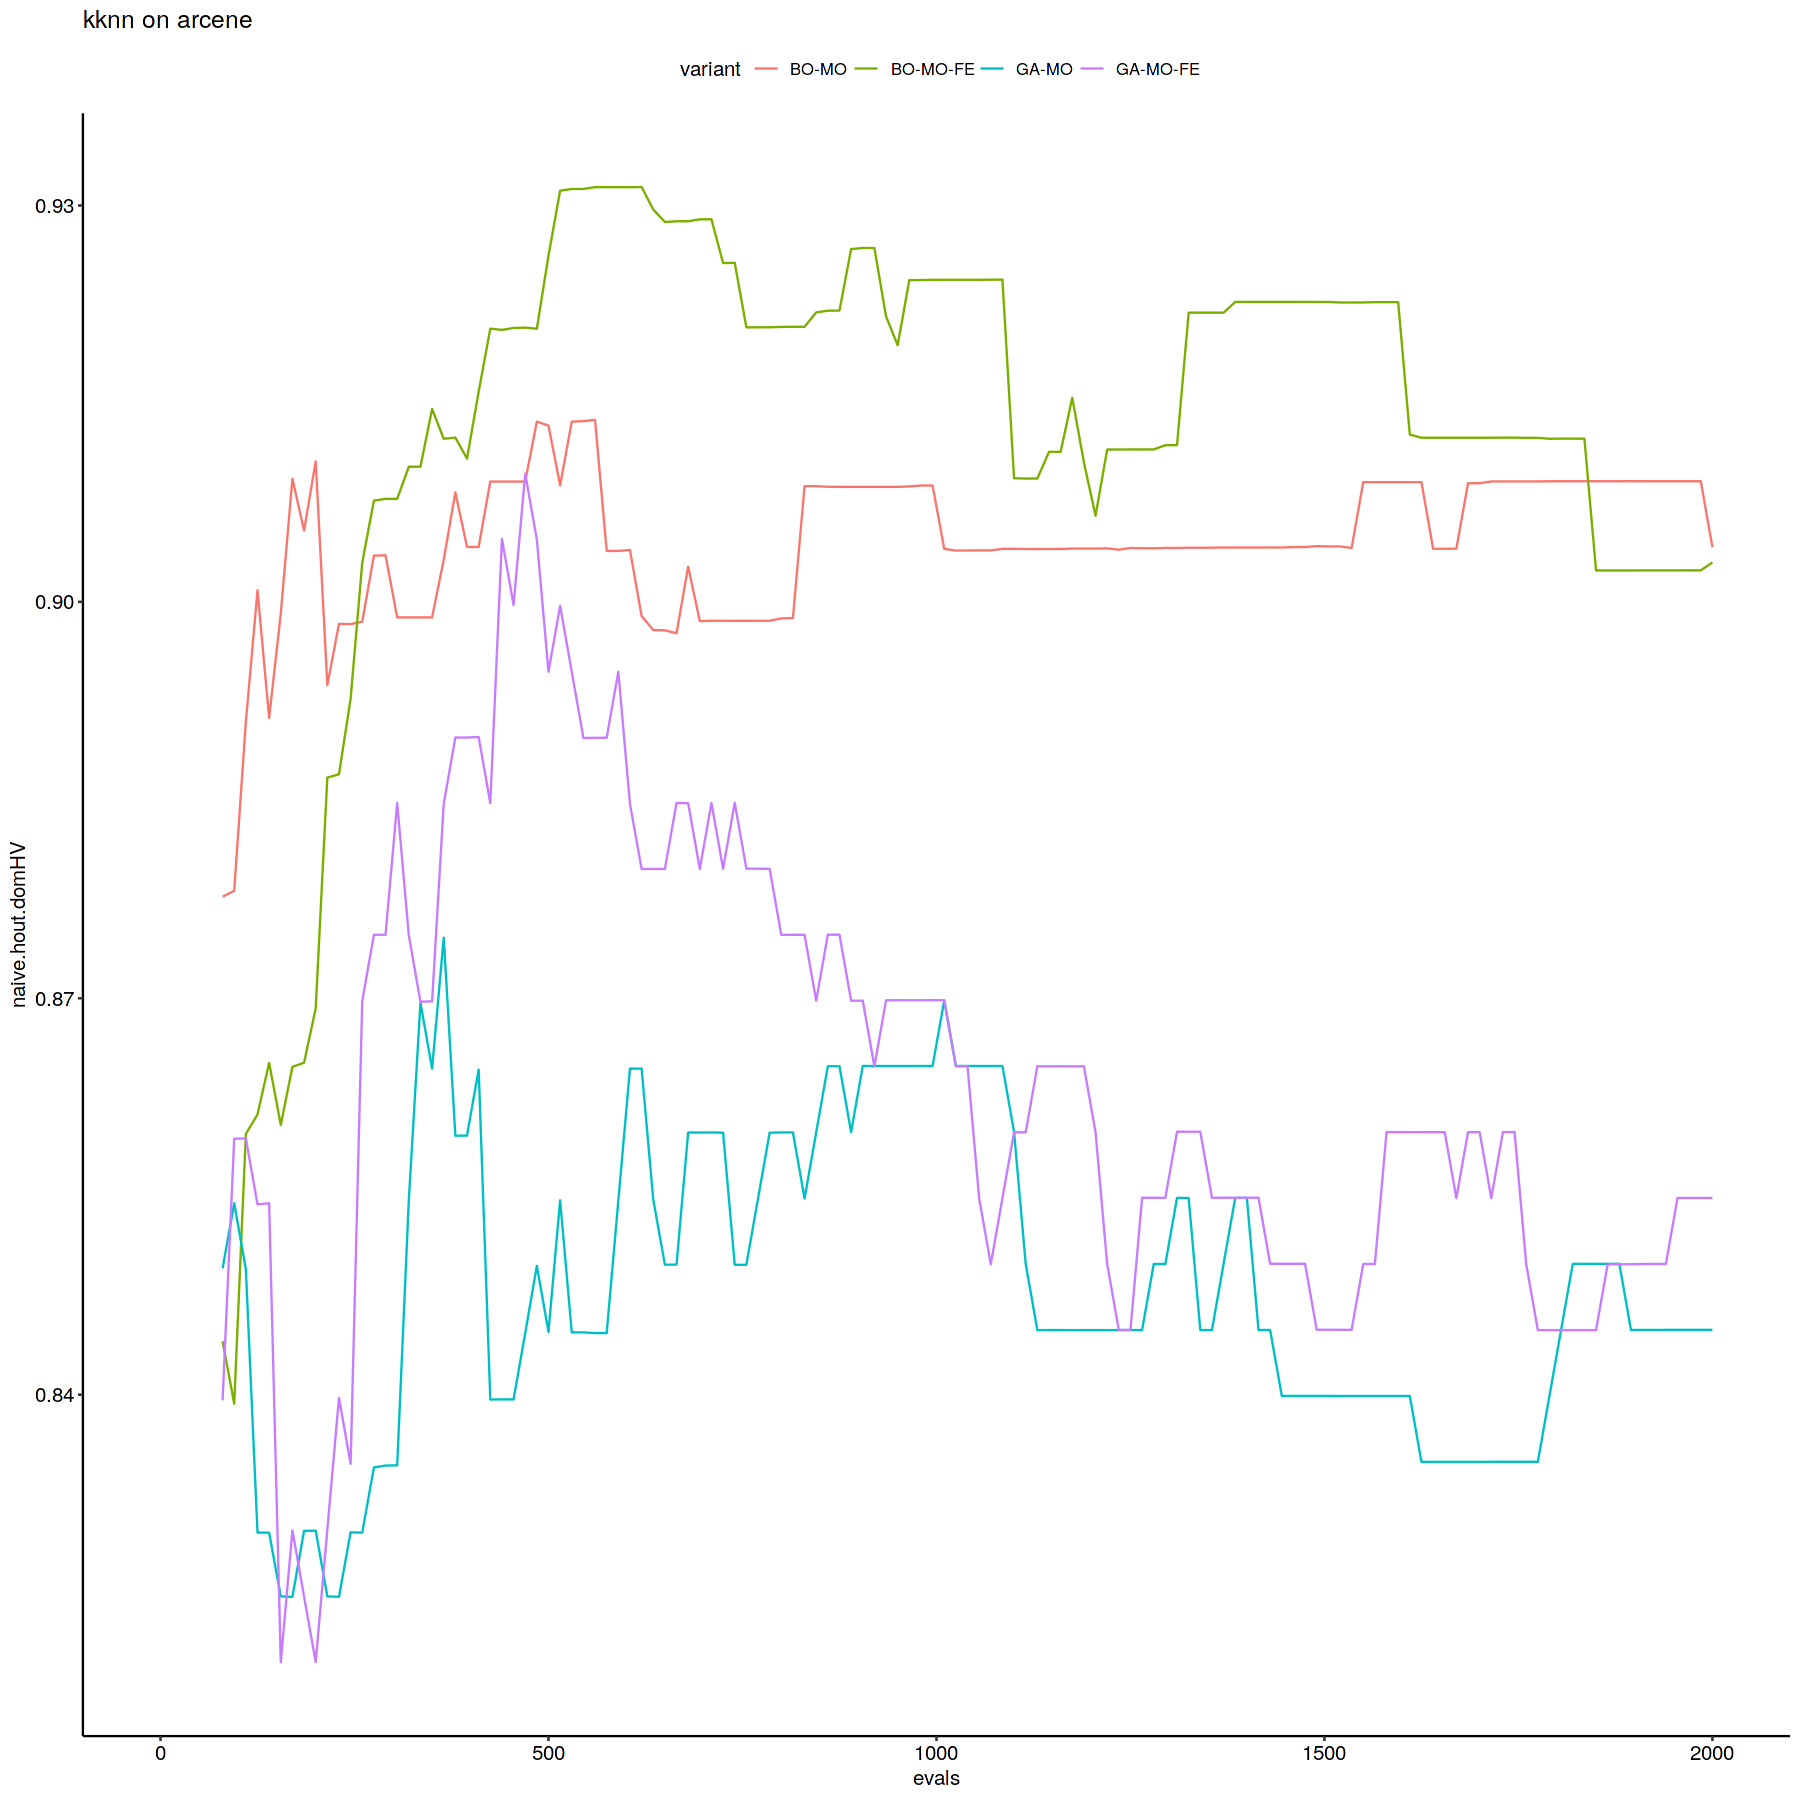

Warning message:
“Removed 2 rows containing missing values (geom_path).”


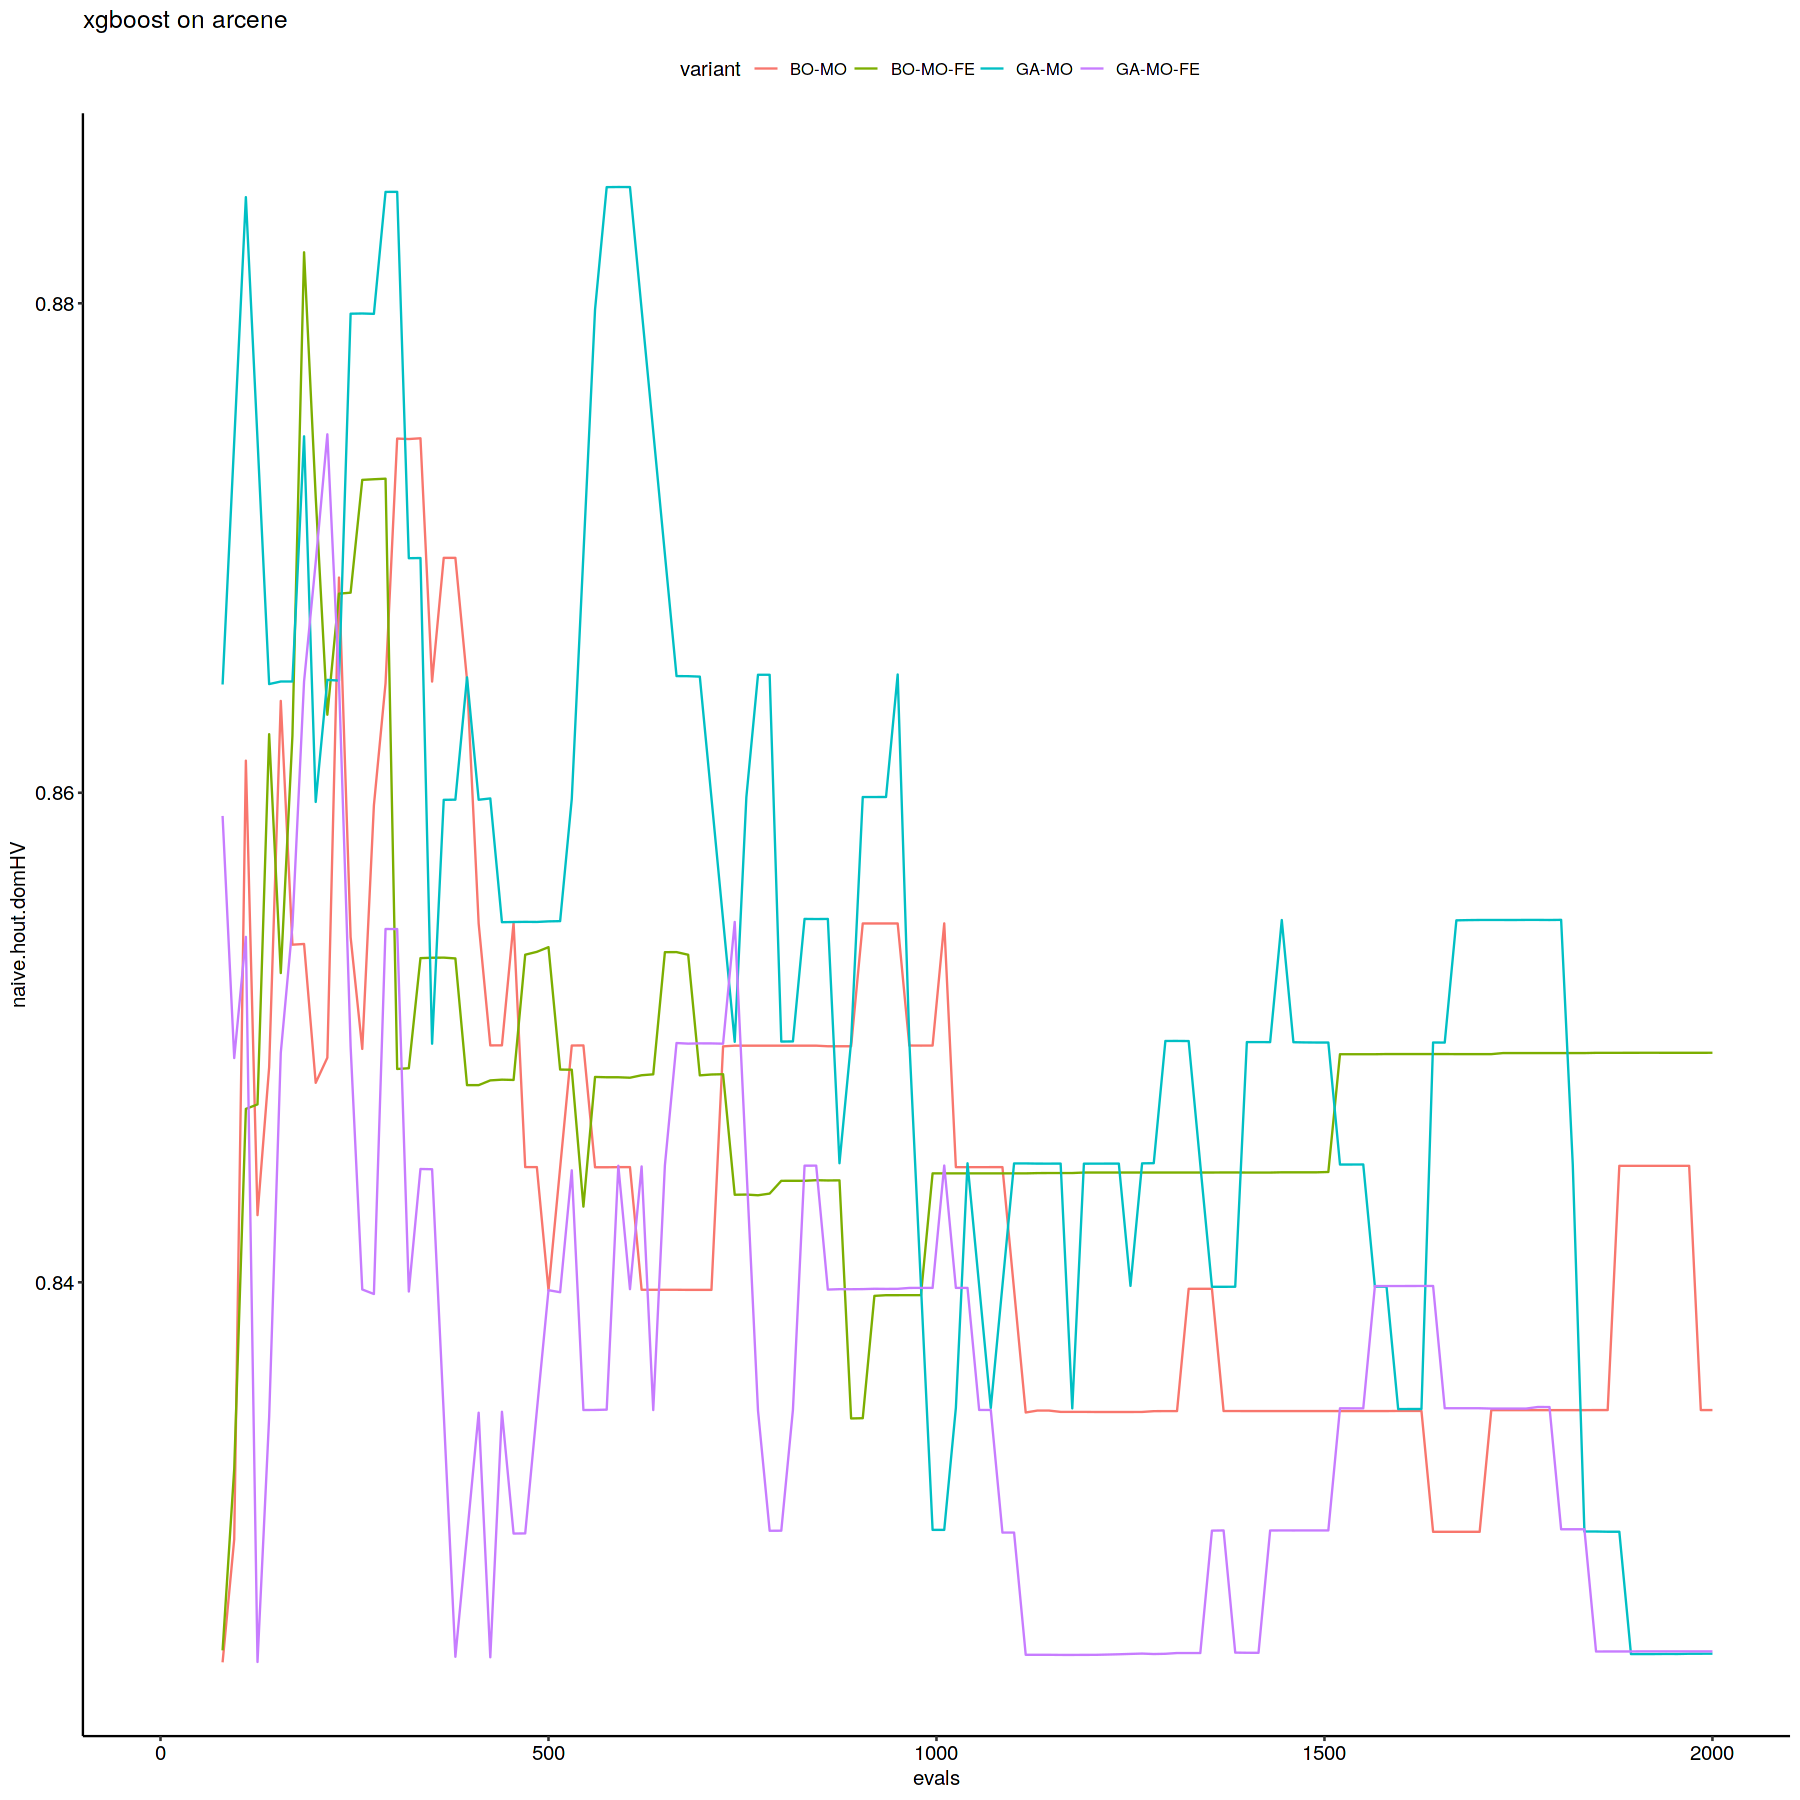

Warning message:
“Removed 1 rows containing missing values (geom_path).”


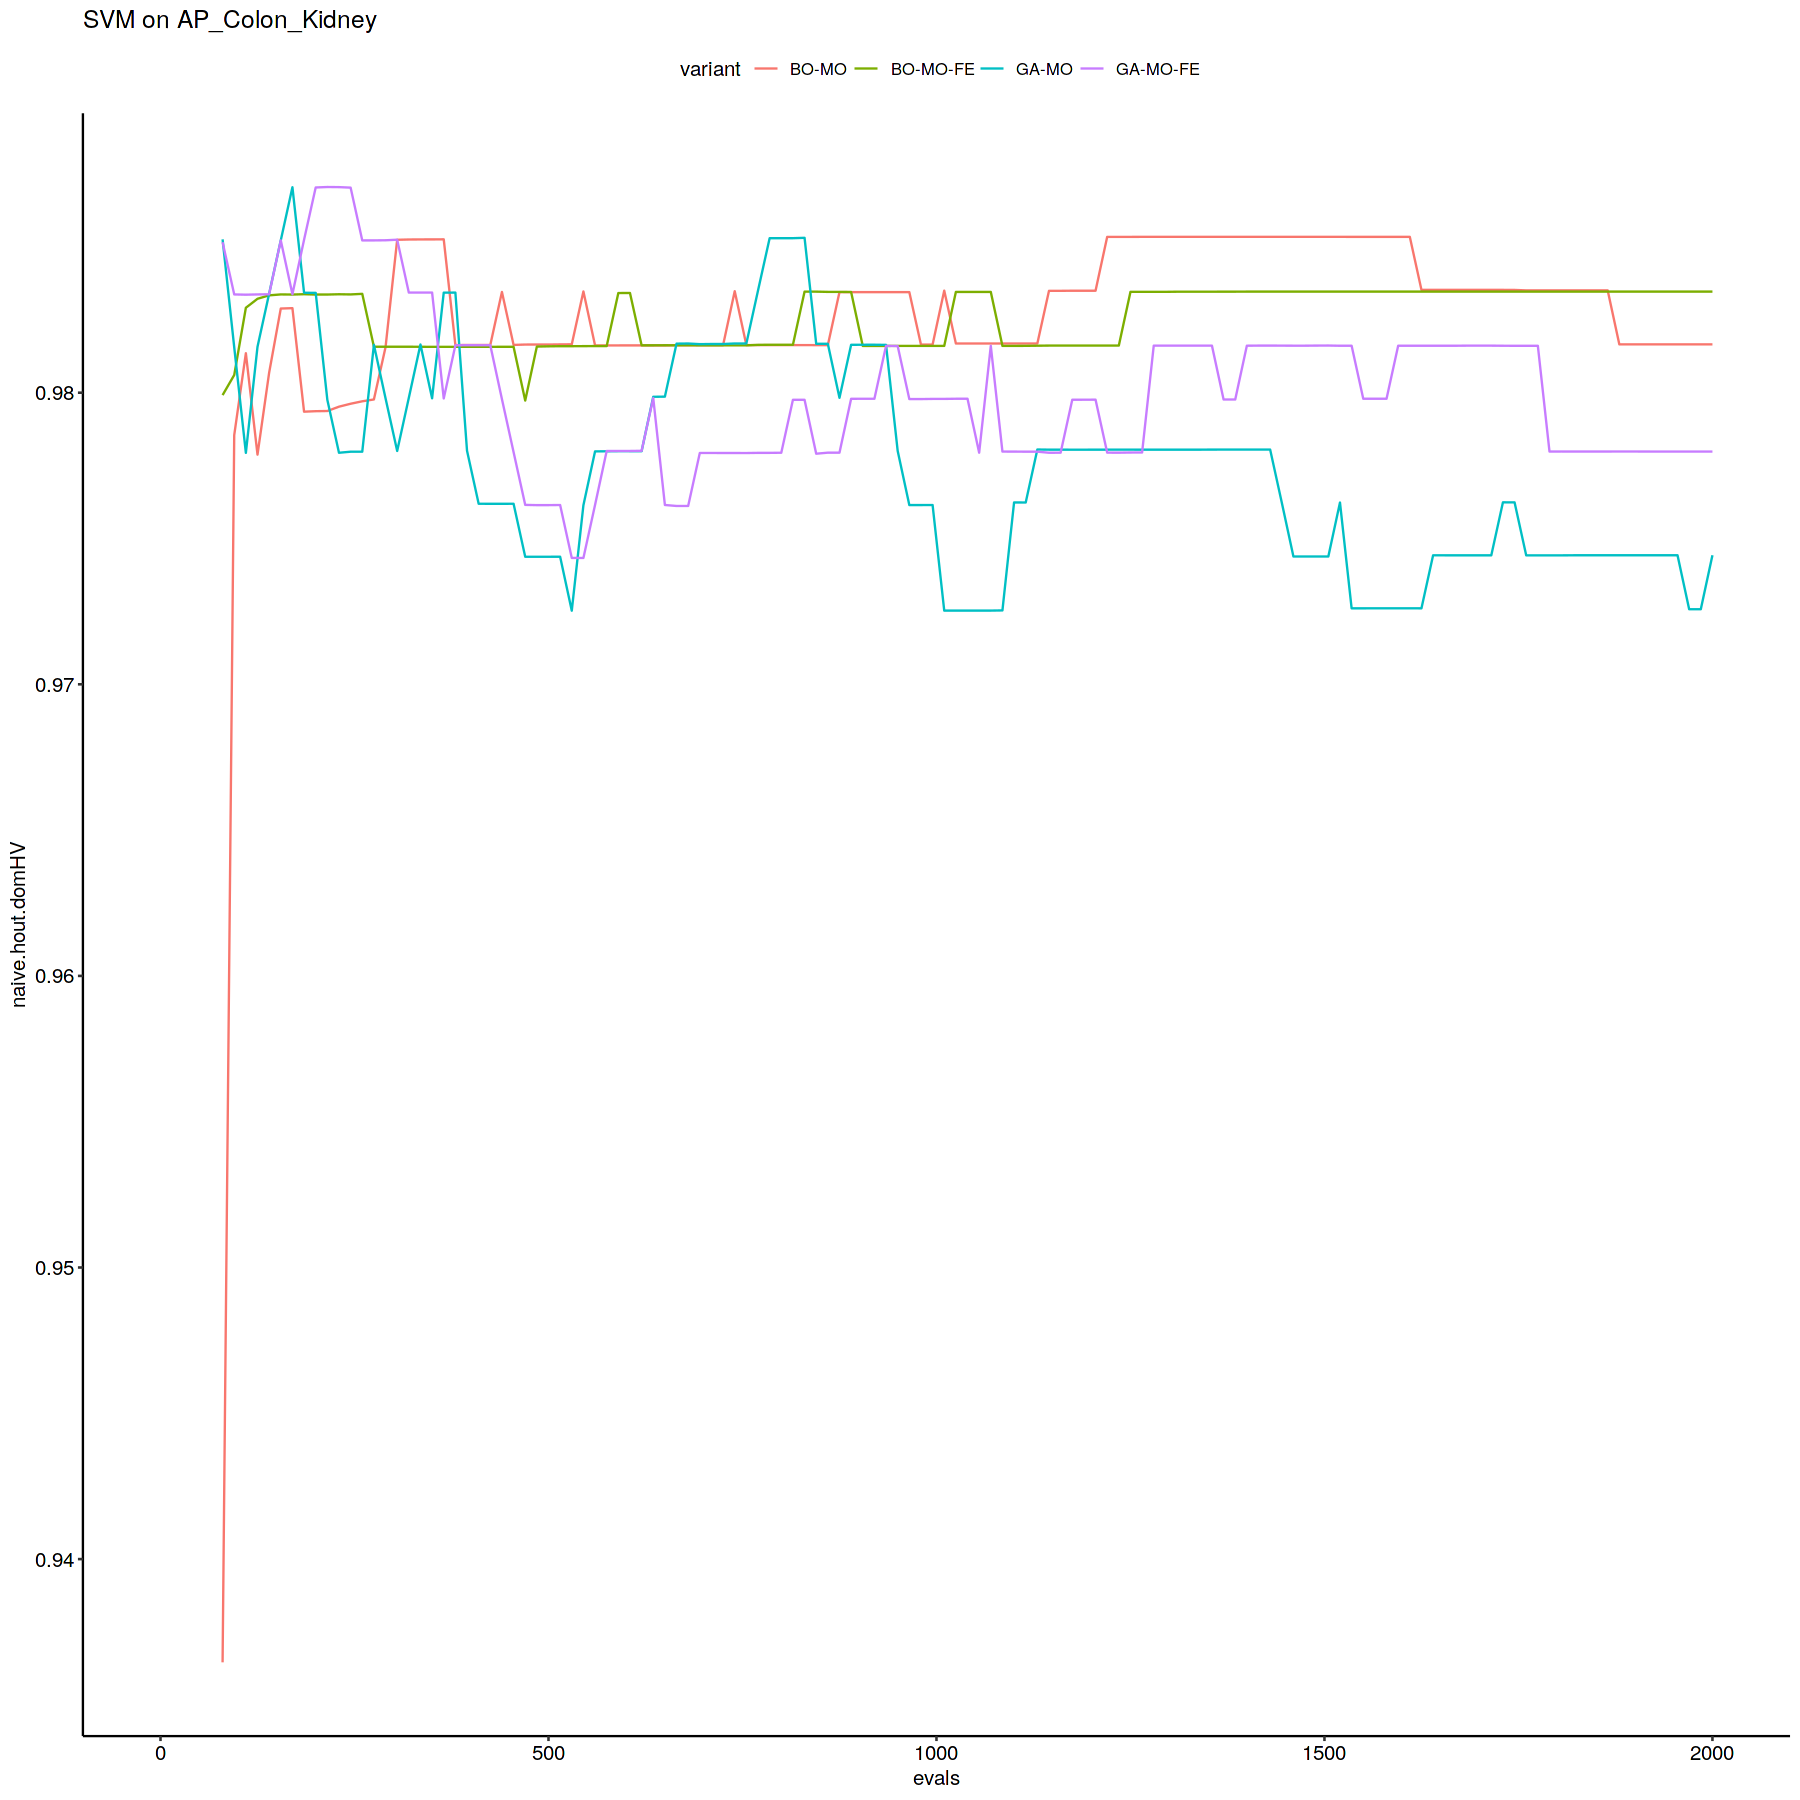

Warning message:
“Removed 2 rows containing missing values (geom_path).”


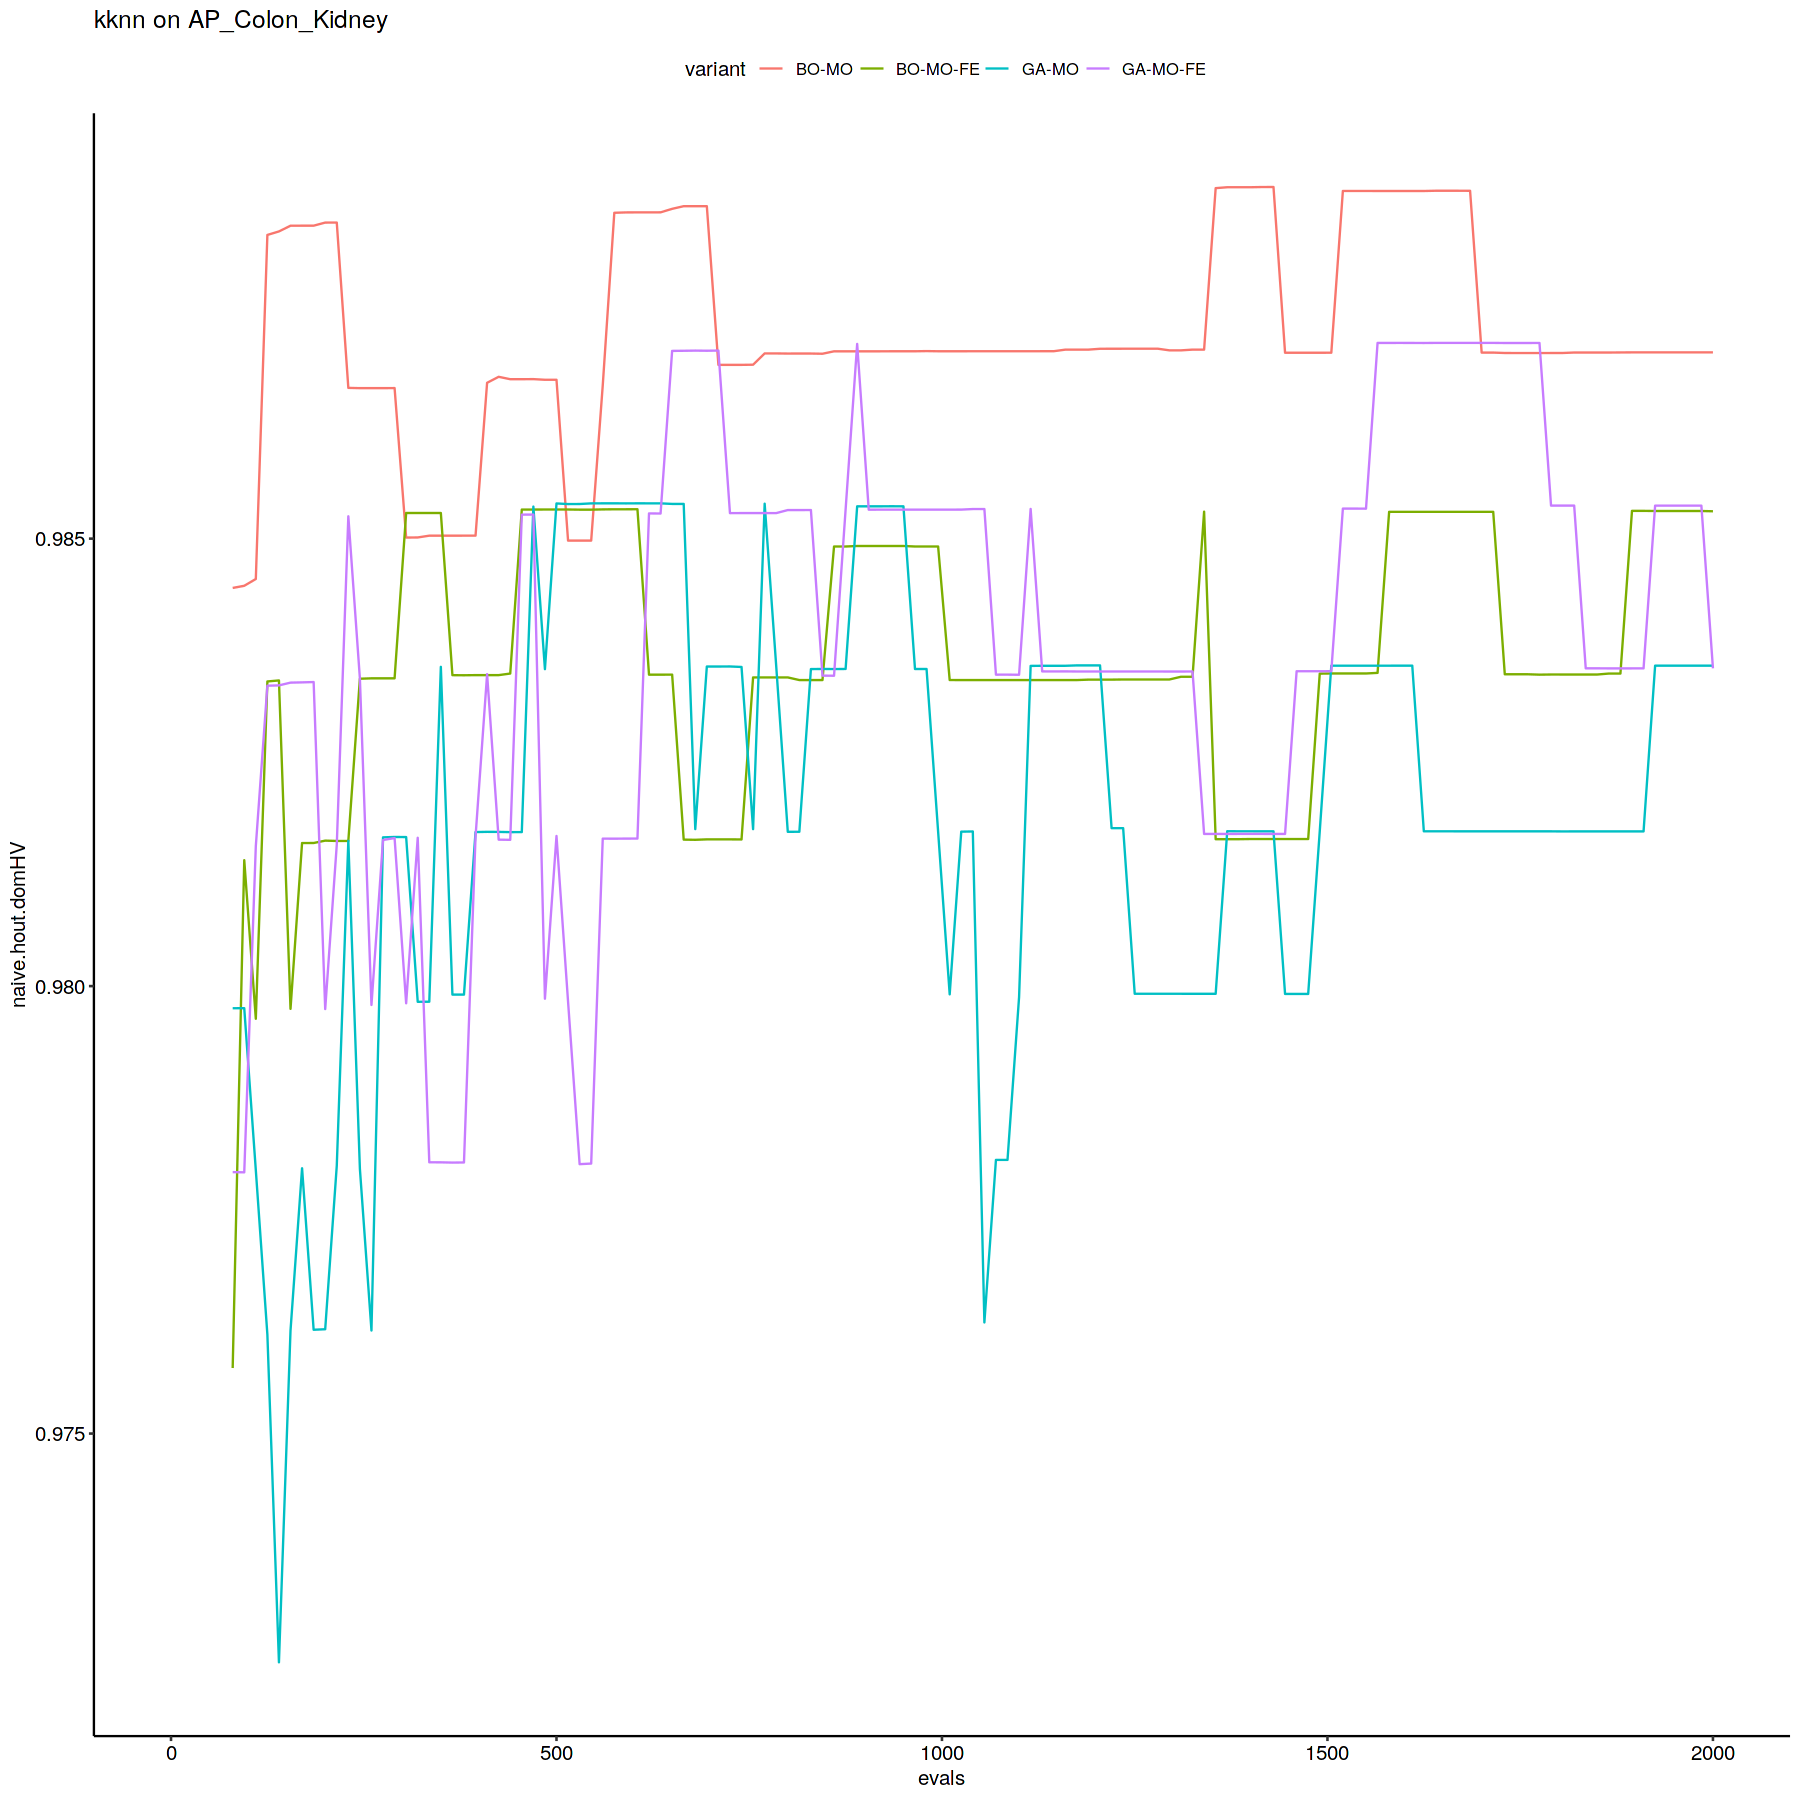

Warning message:
“Removed 2 rows containing missing values (geom_path).”


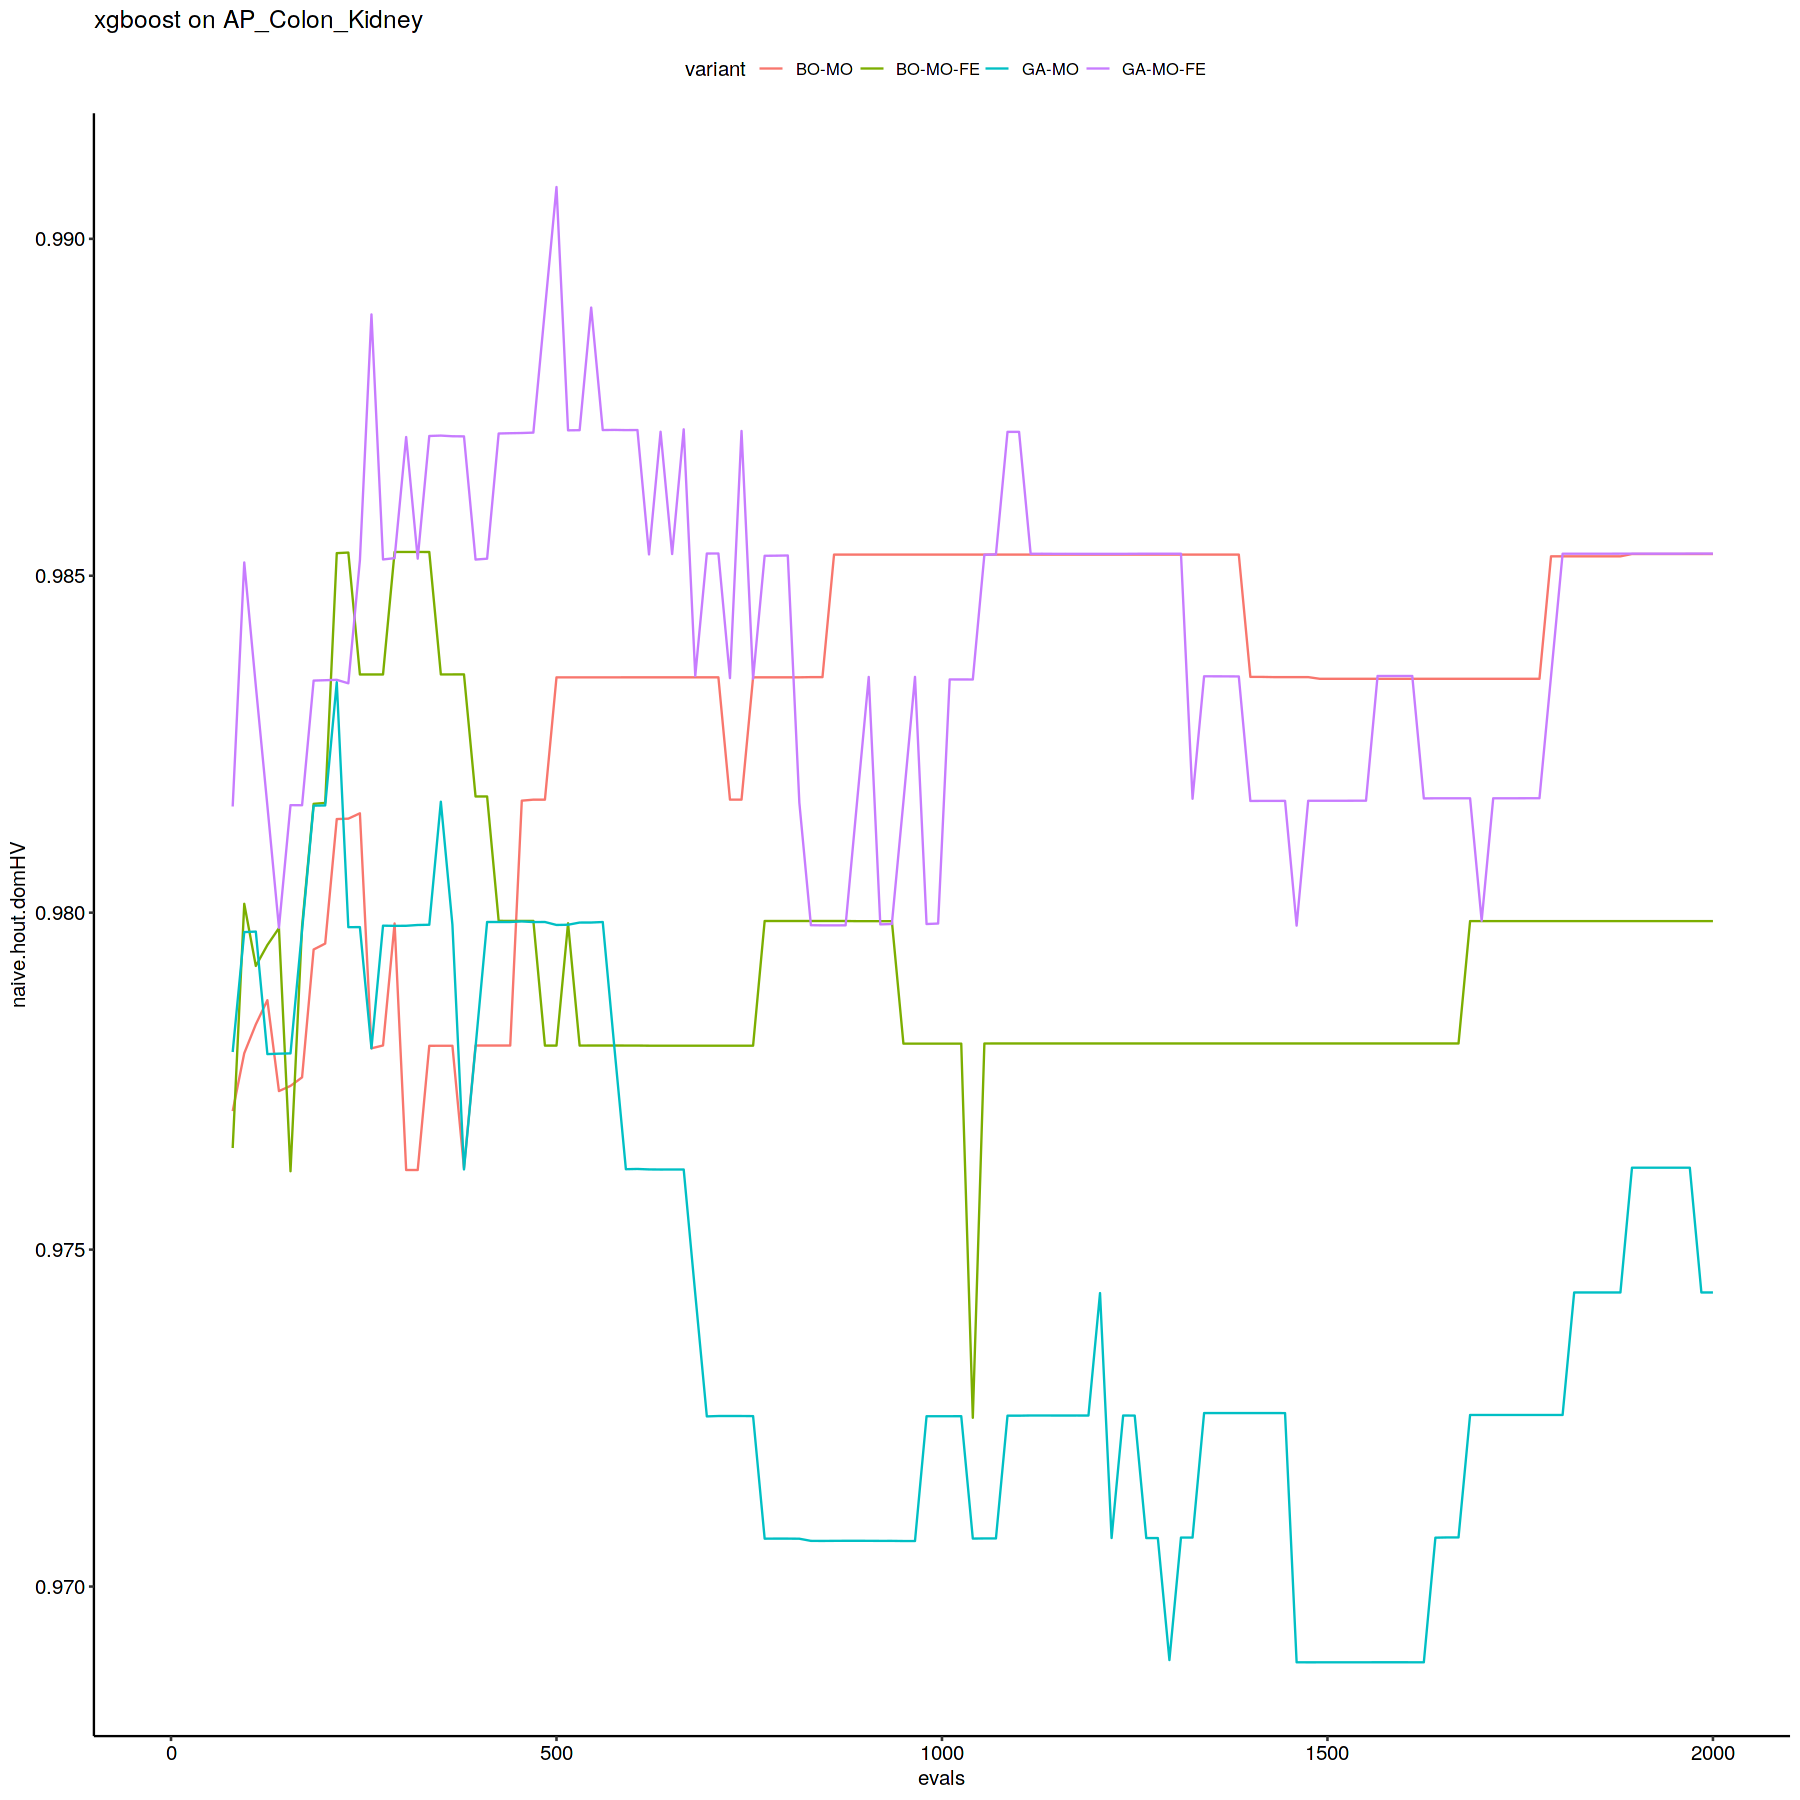

Warning message:
“Removed 1 rows containing missing values (geom_path).”


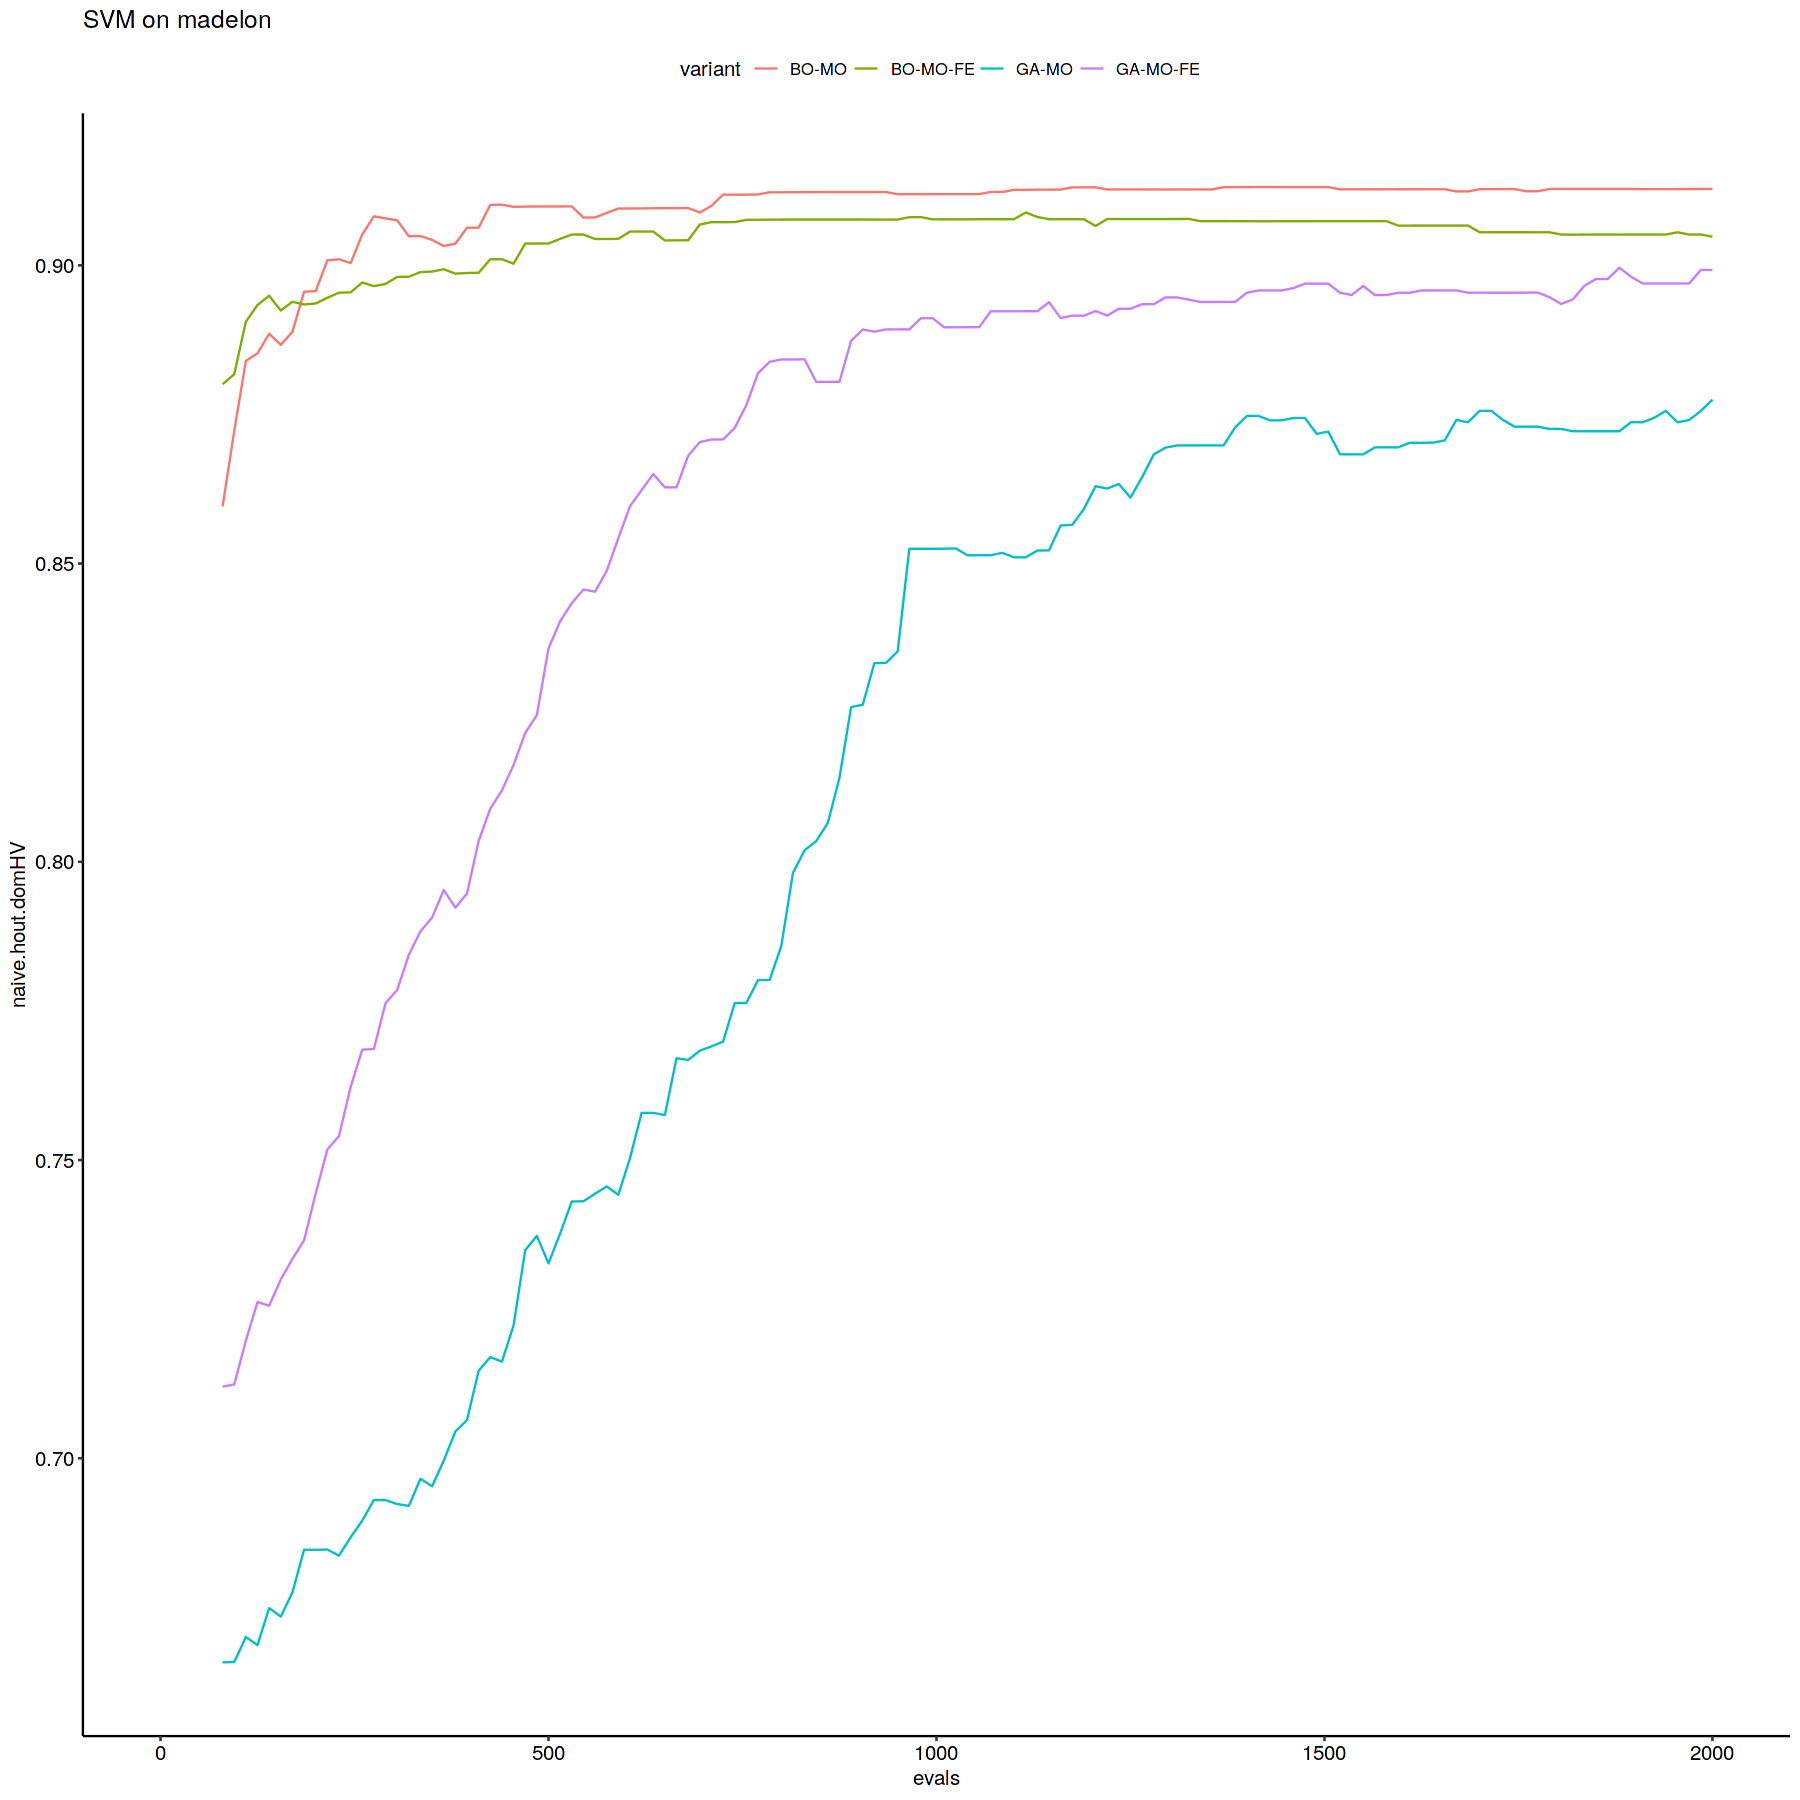

Warning message:
“Removed 2 rows containing missing values (geom_path).”


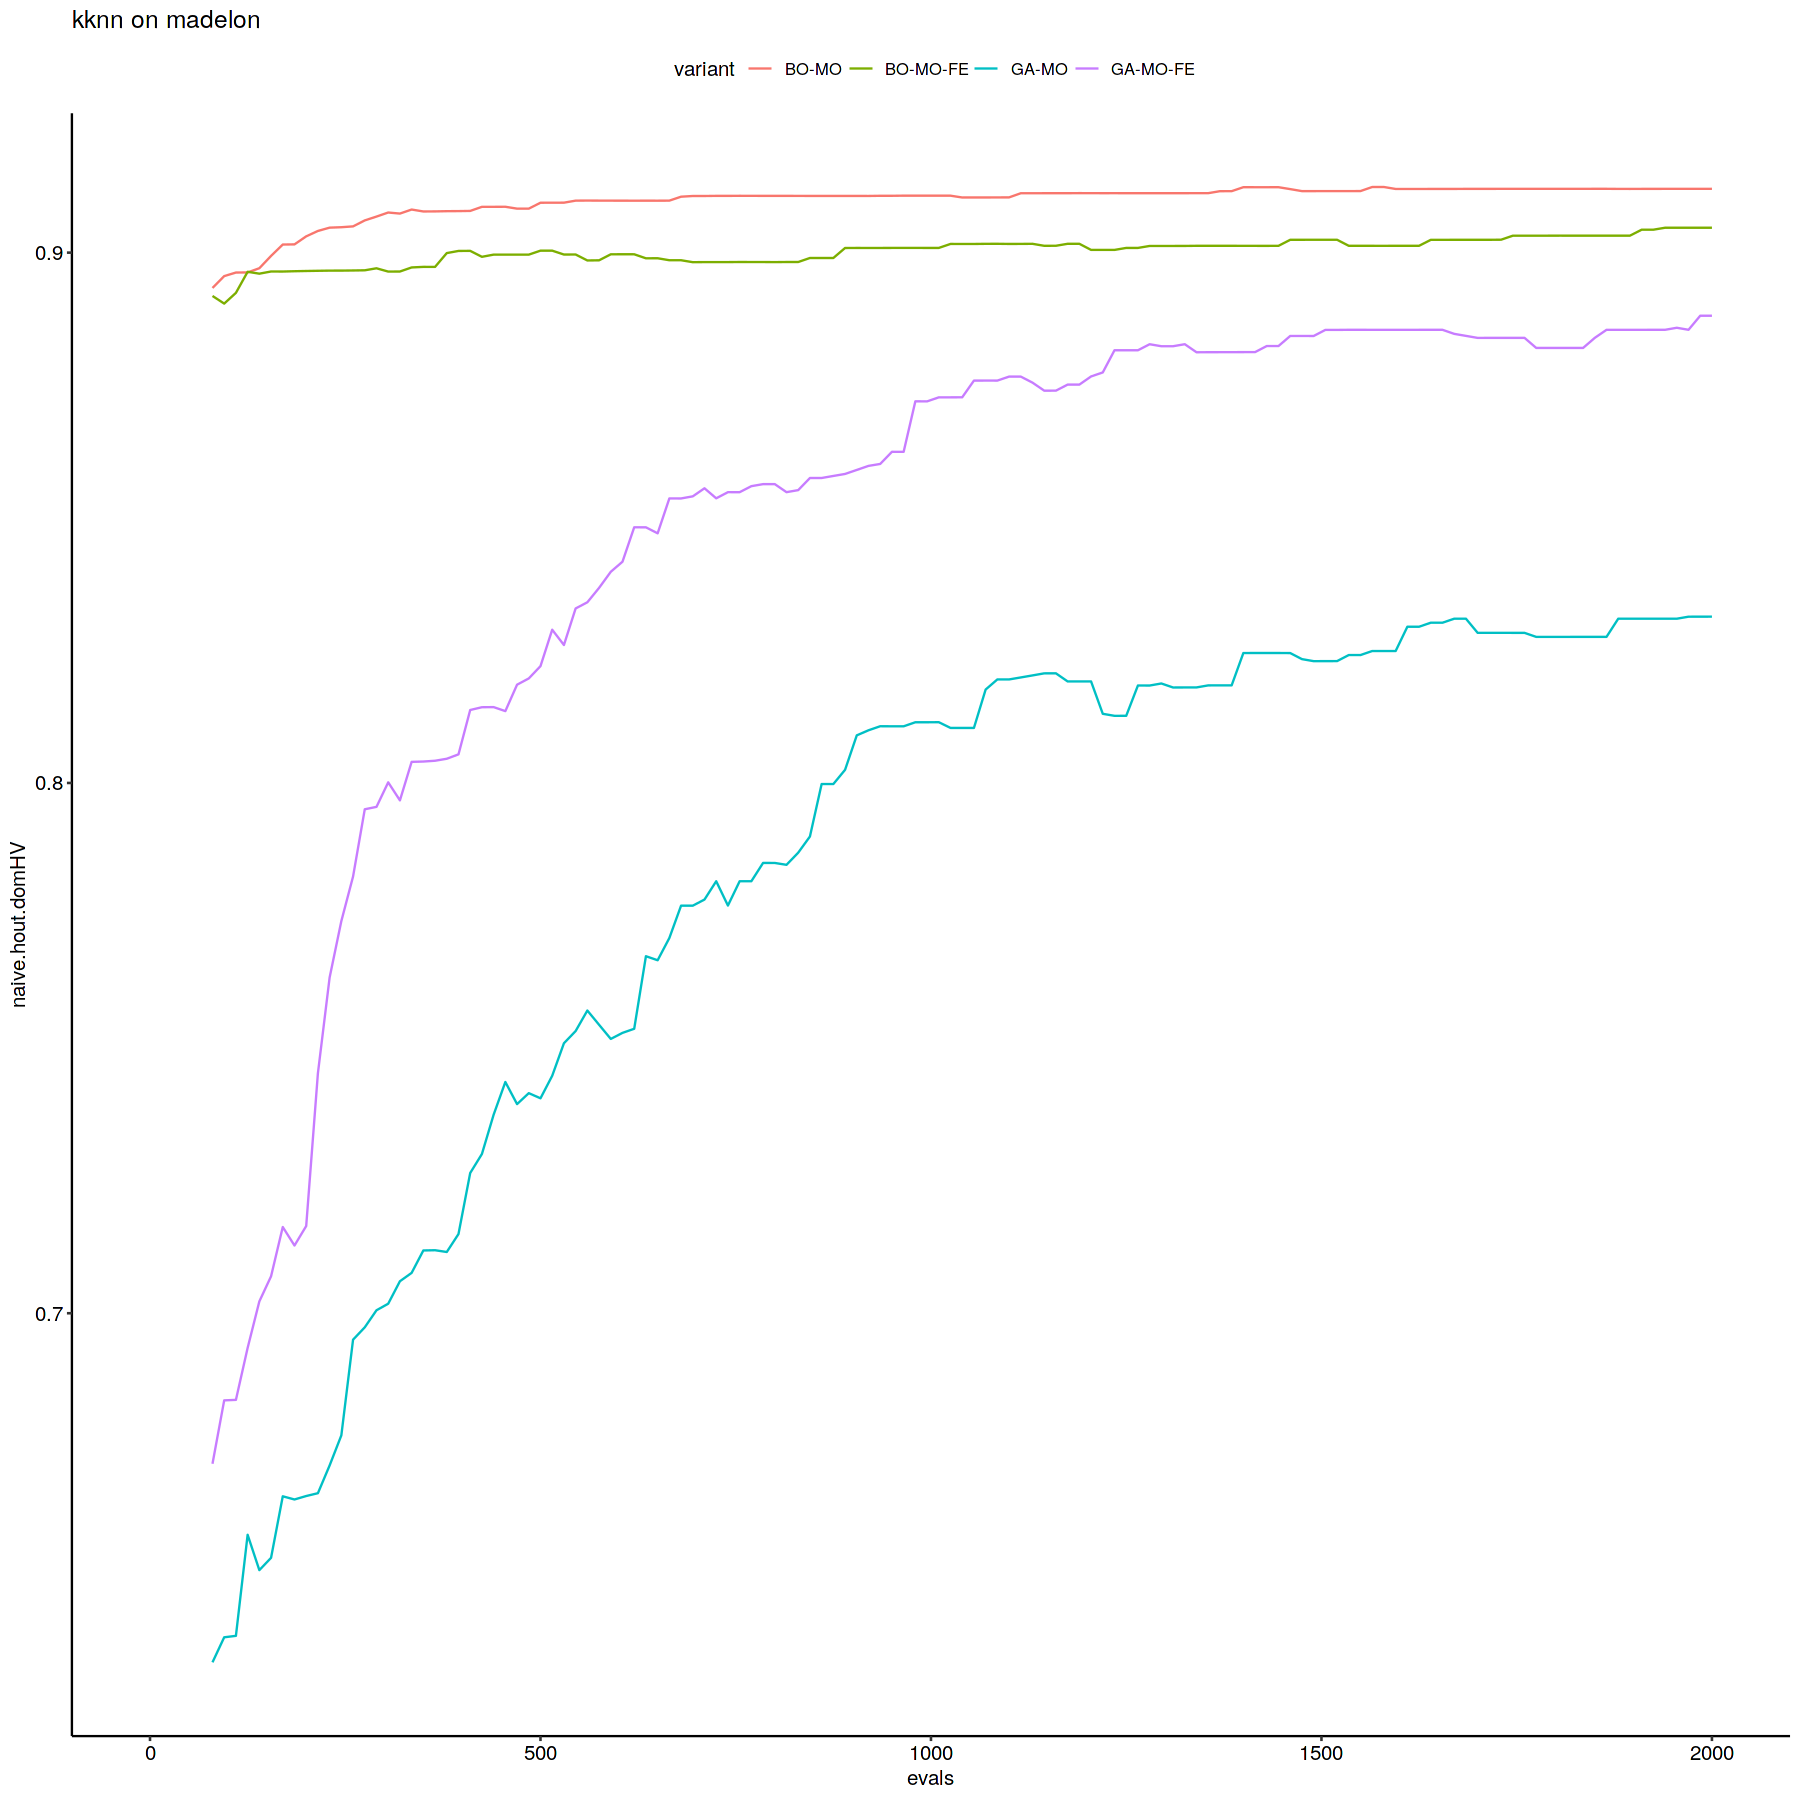

Warning message:
“Removed 2 rows containing missing values (geom_path).”


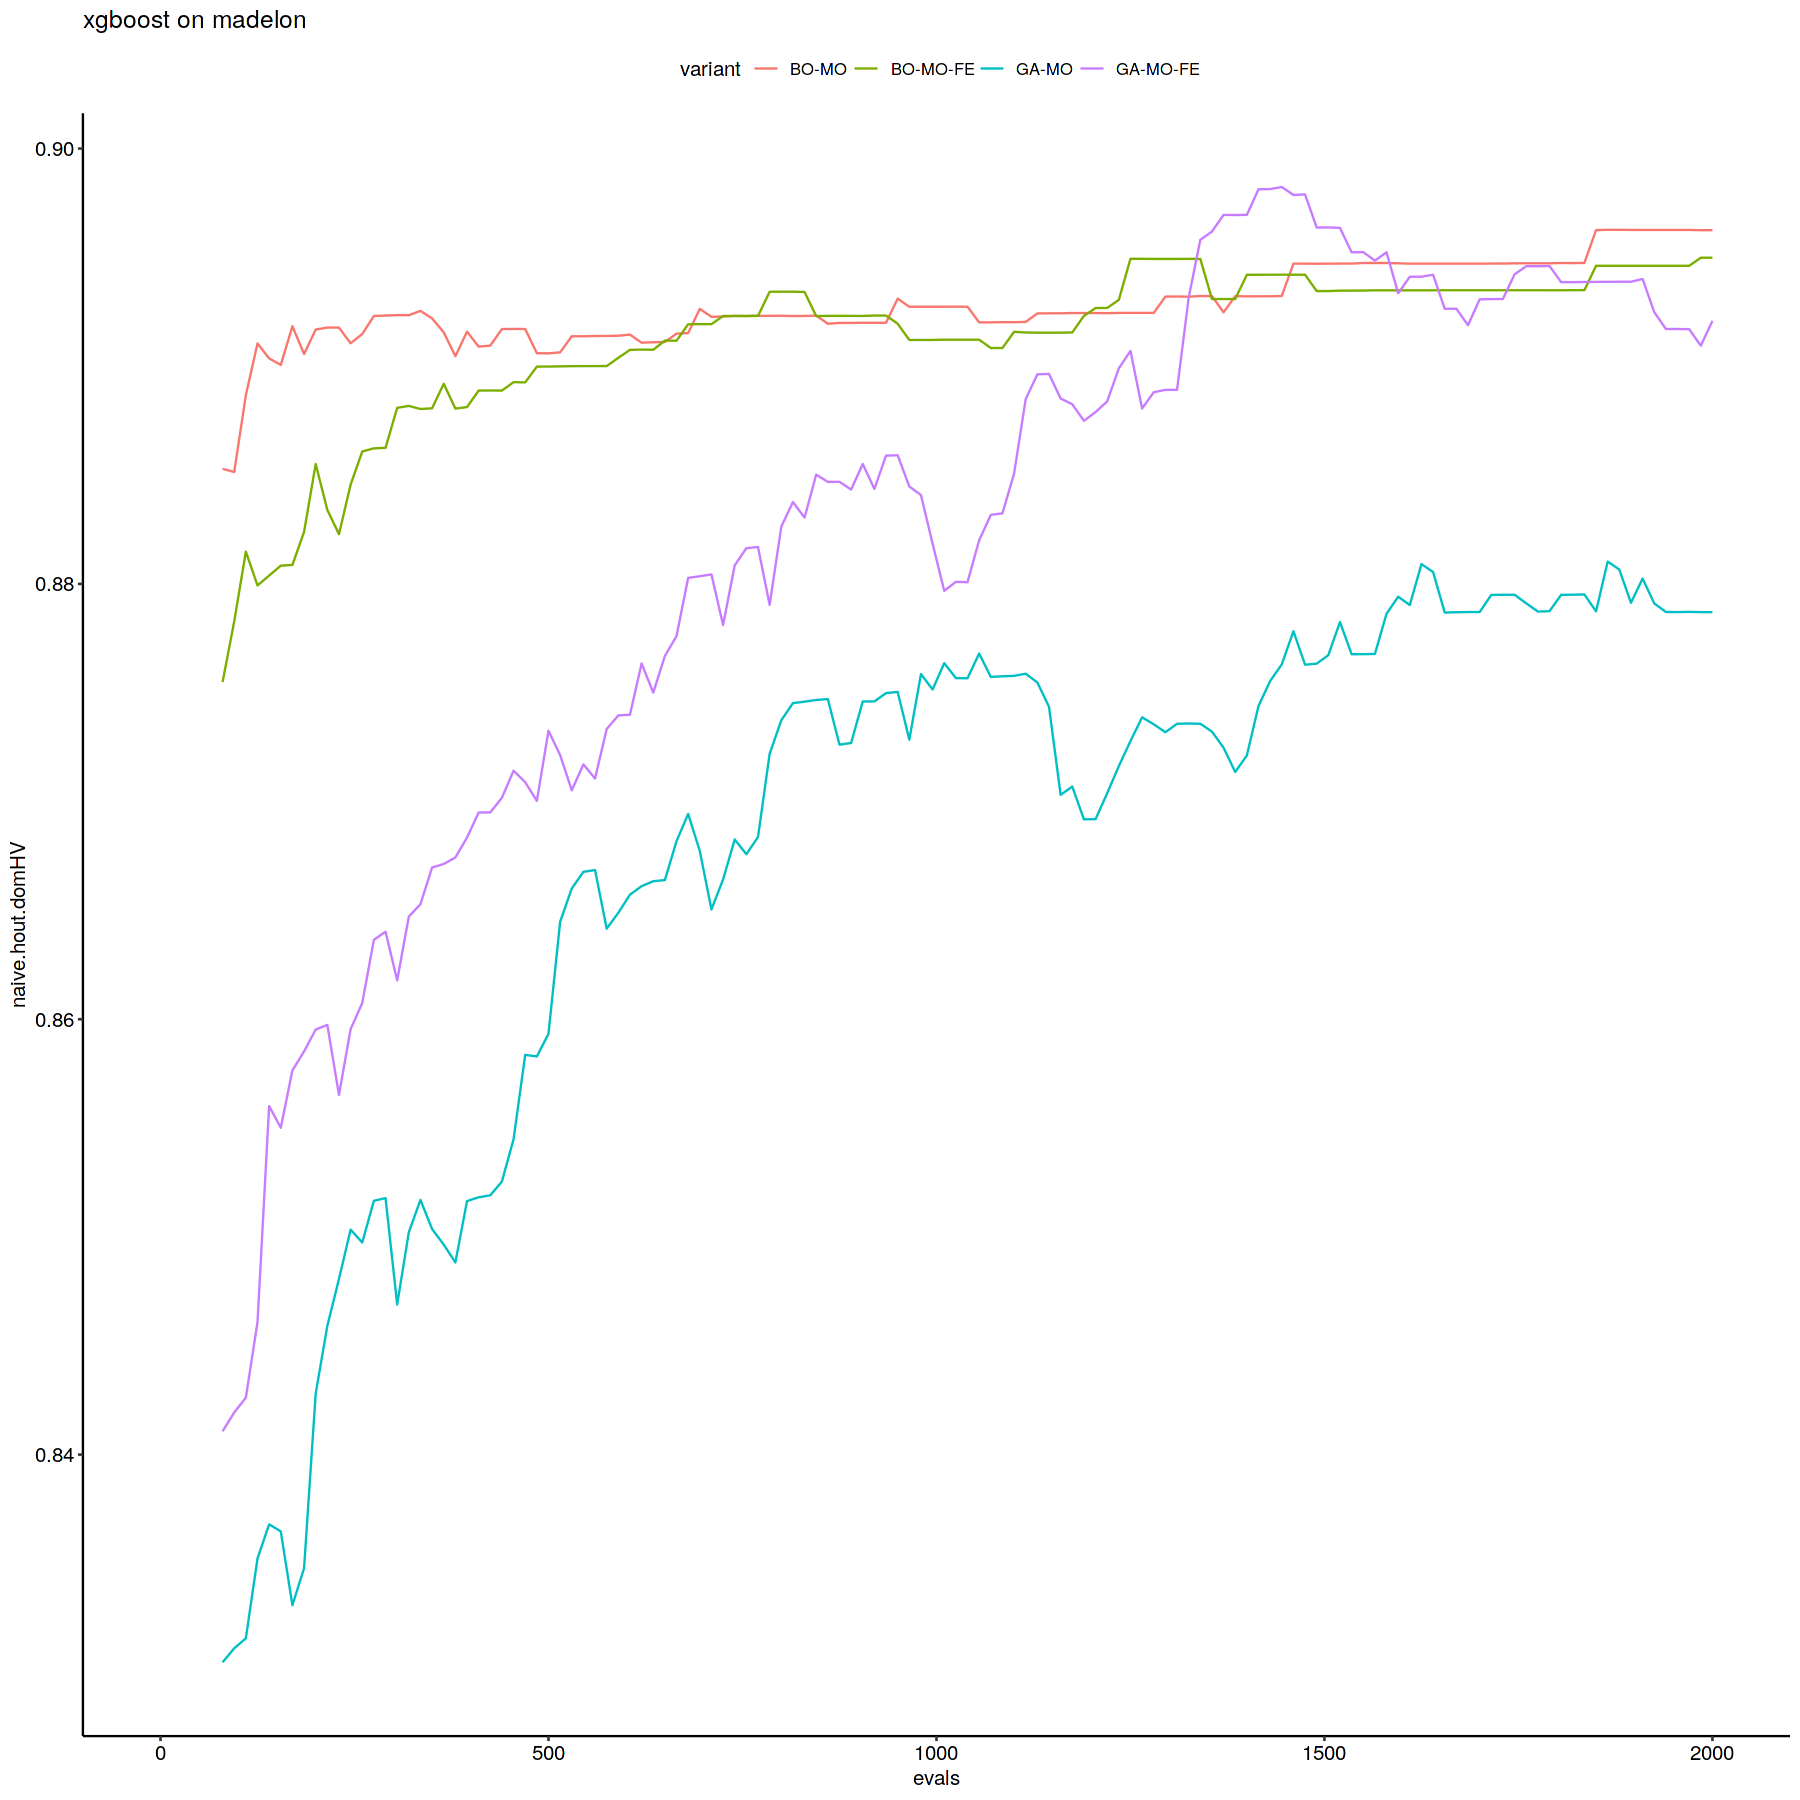

Warning message:
“Removed 1 rows containing missing values (geom_path).”


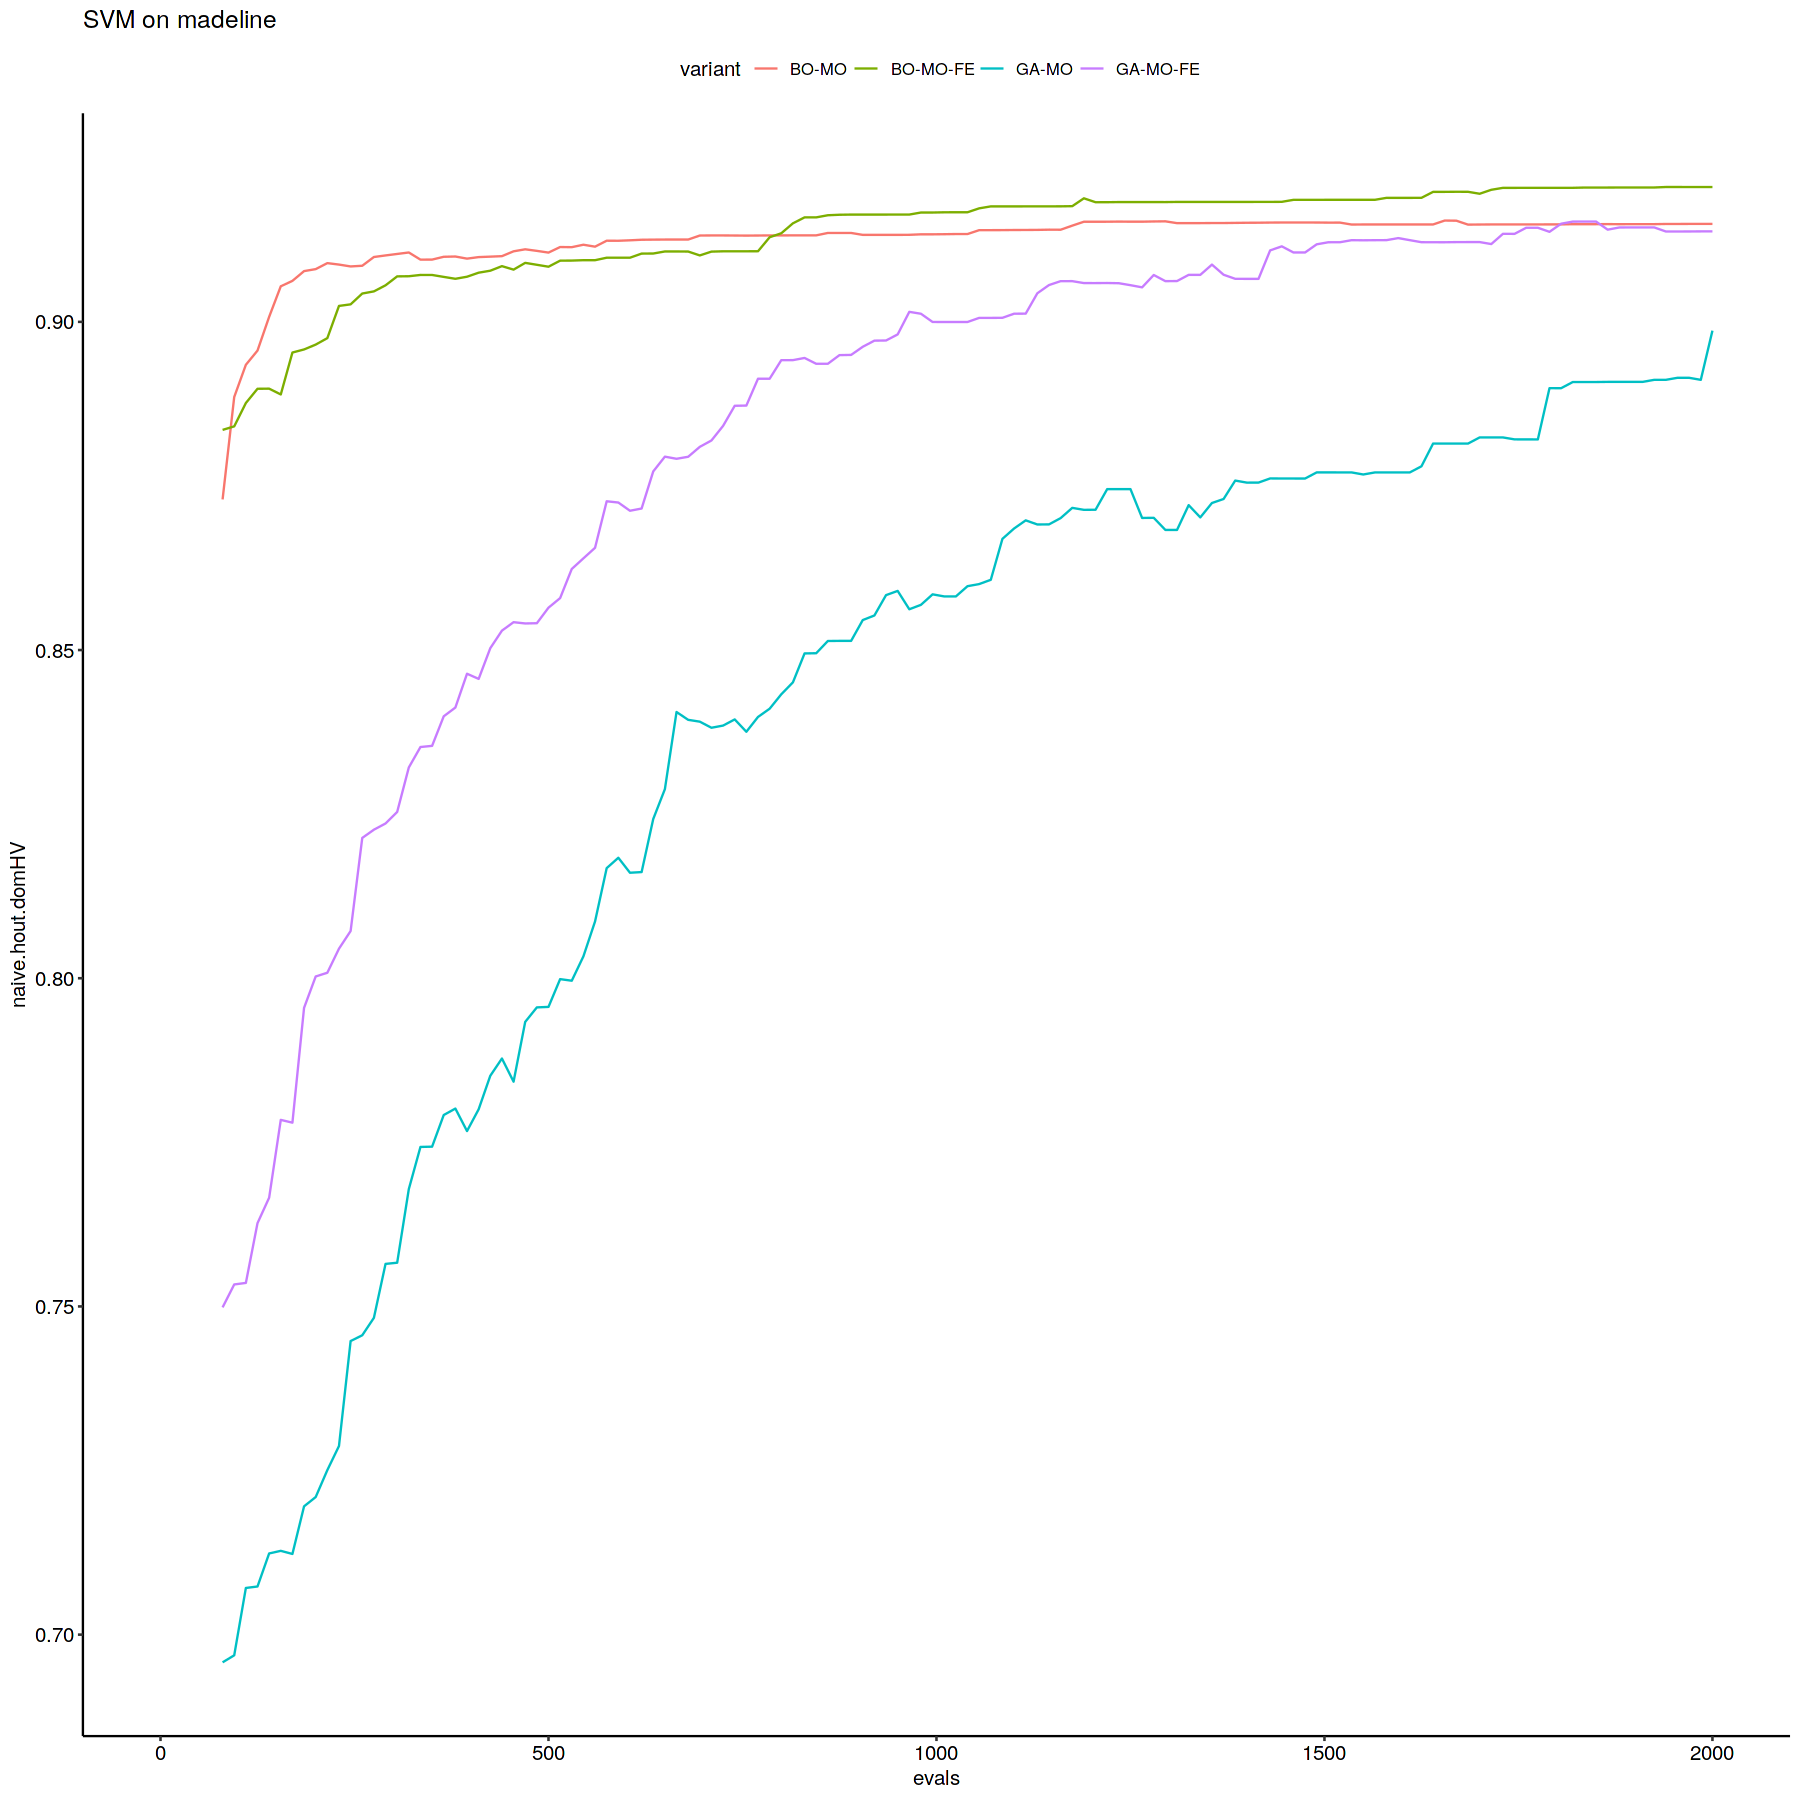

Warning message:
“Removed 2 rows containing missing values (geom_path).”


$sonar.SVM

$sonar.kknn

$sonar.xgboost

$ionosphere.SVM

$ionosphere.kknn

$ionosphere.xgboost

$`hill-valley.SVM`

$`hill-valley.kknn`

$`hill-valley.xgboost`

$wdbc.SVM

$wdbc.kknn

$wdbc.xgboost

$tecator.SVM

$tecator.kknn

$tecator.xgboost

$lsvt.SVM

$lsvt.kknn

$lsvt.xgboost

$isolet.SVM

$isolet.kknn

$isolet.xgboost

$`cnae-9.SVM`

$`cnae-9.kknn`

$`cnae-9.xgboost`

$semeion.SVM

$semeion.kknn

$semeion.xgboost

$AP_Breast_Colon.SVM

$AP_Breast_Colon.kknn

$AP_Breast_Colon.xgboost

$arcene.SVM

$arcene.kknn

$arcene.xgboost

$AP_Colon_Kidney.SVM

$AP_Colon_Kidney.kknn

$AP_Colon_Kidney.xgboost

$madelon.SVM

$madelon.kknn

$madelon.xgboost

$madeline.SVM

$madeline.kknn

$madeline.xgboost


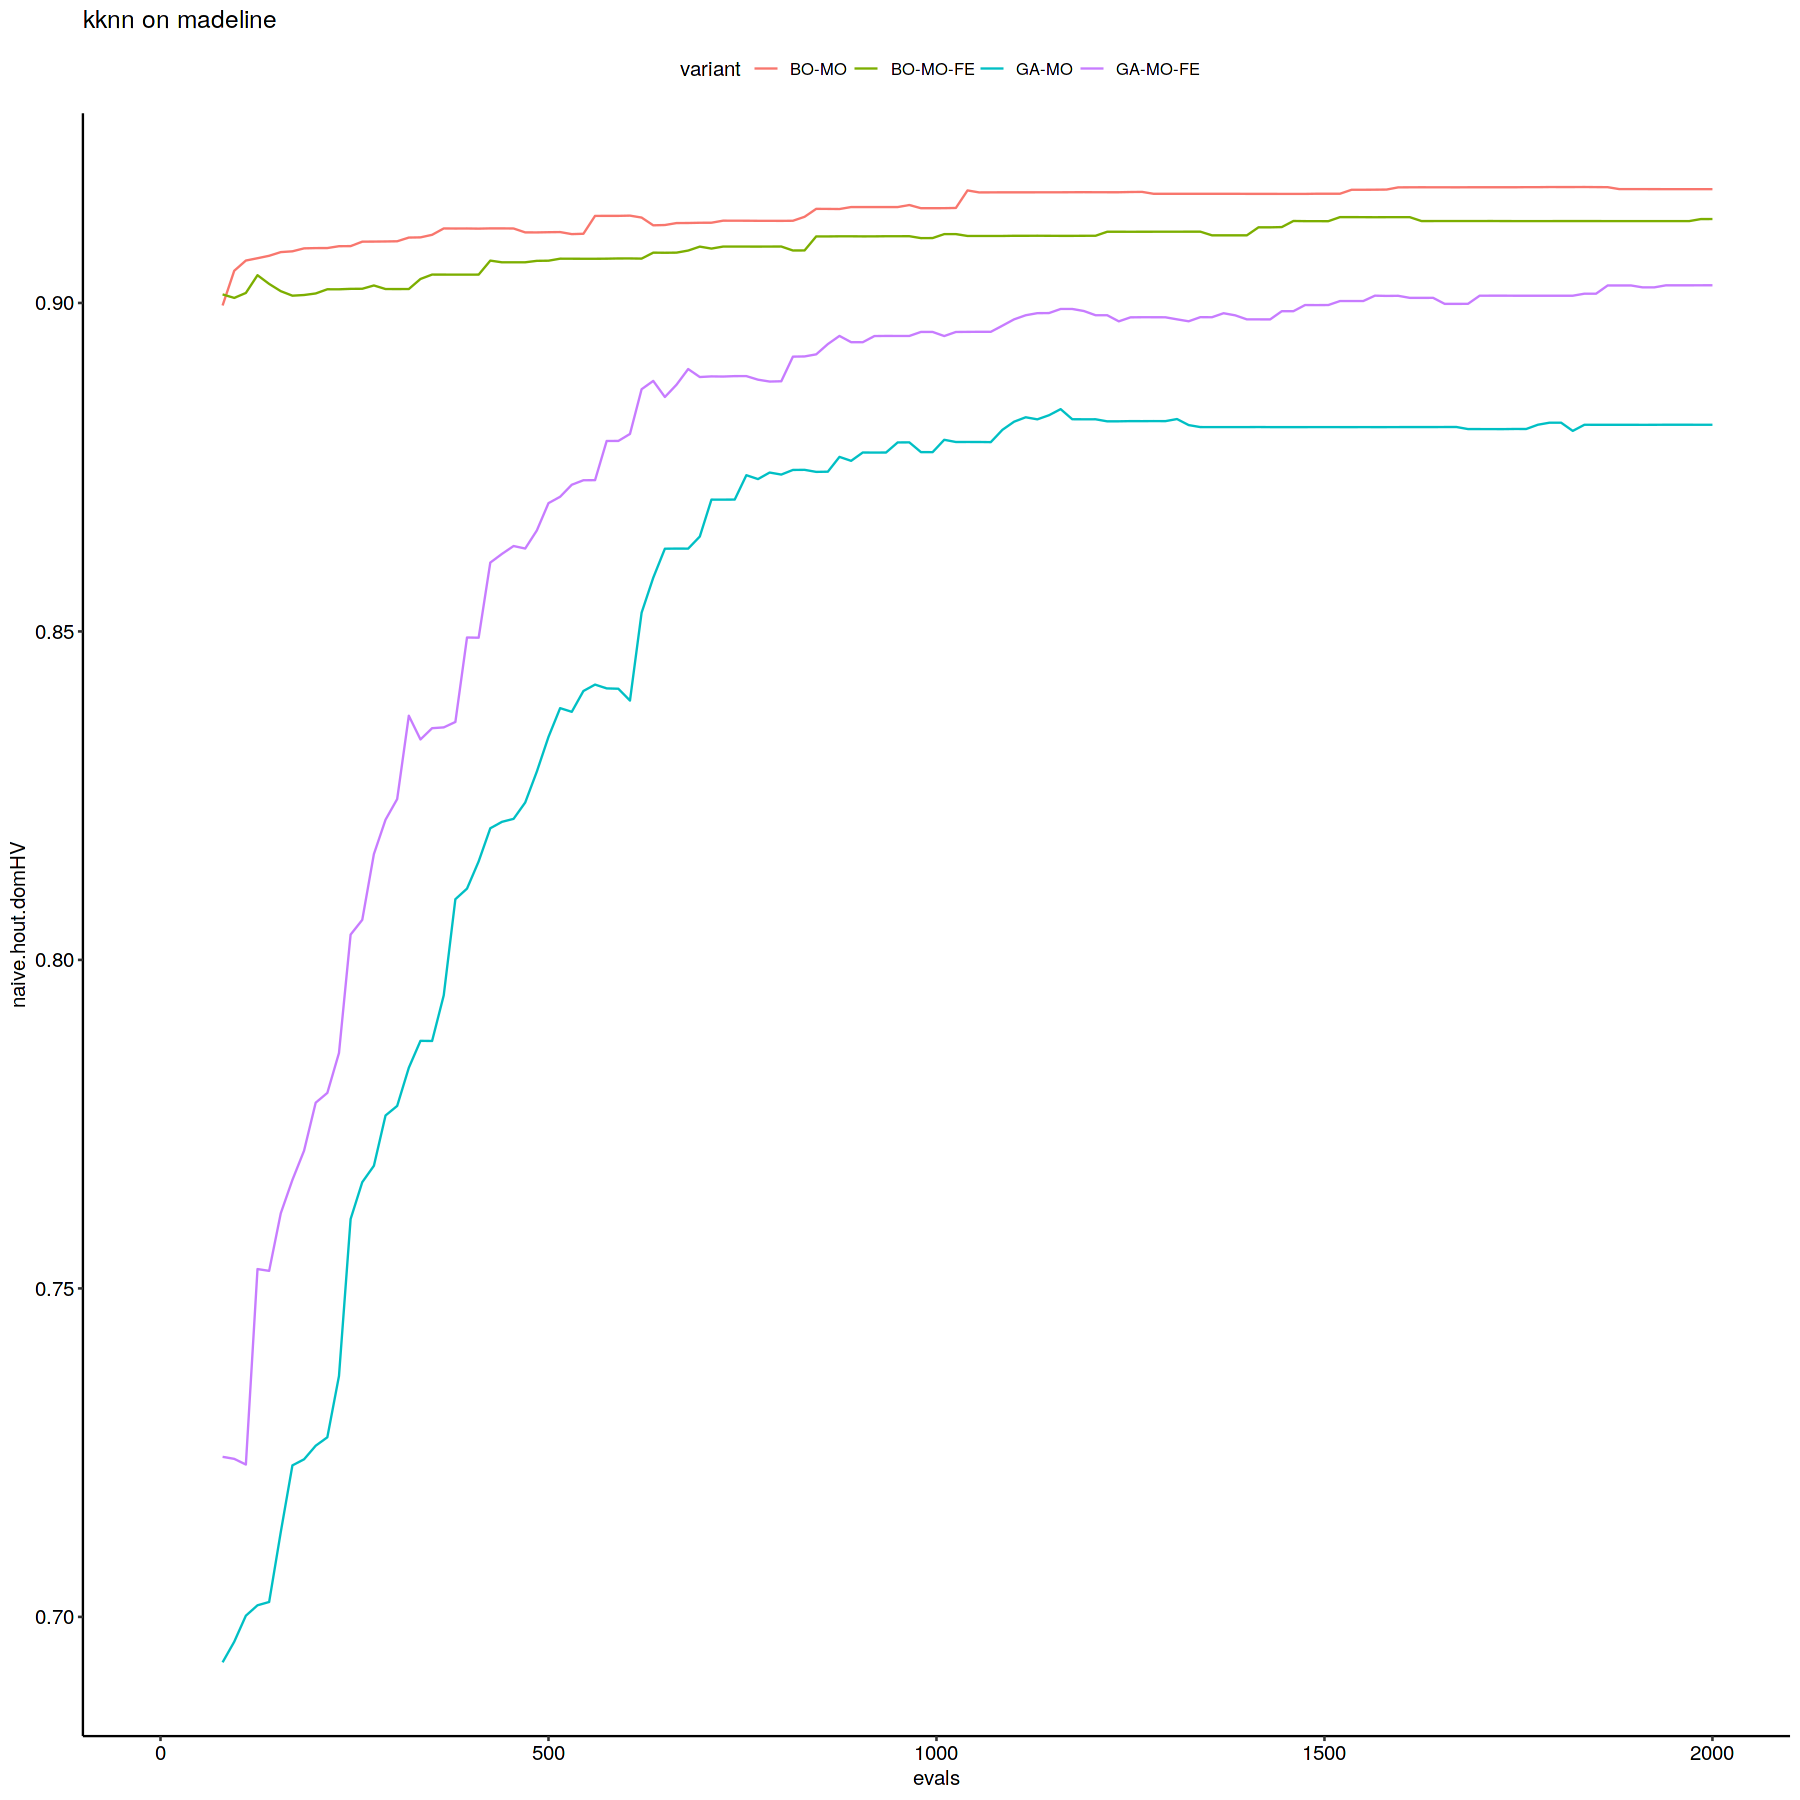

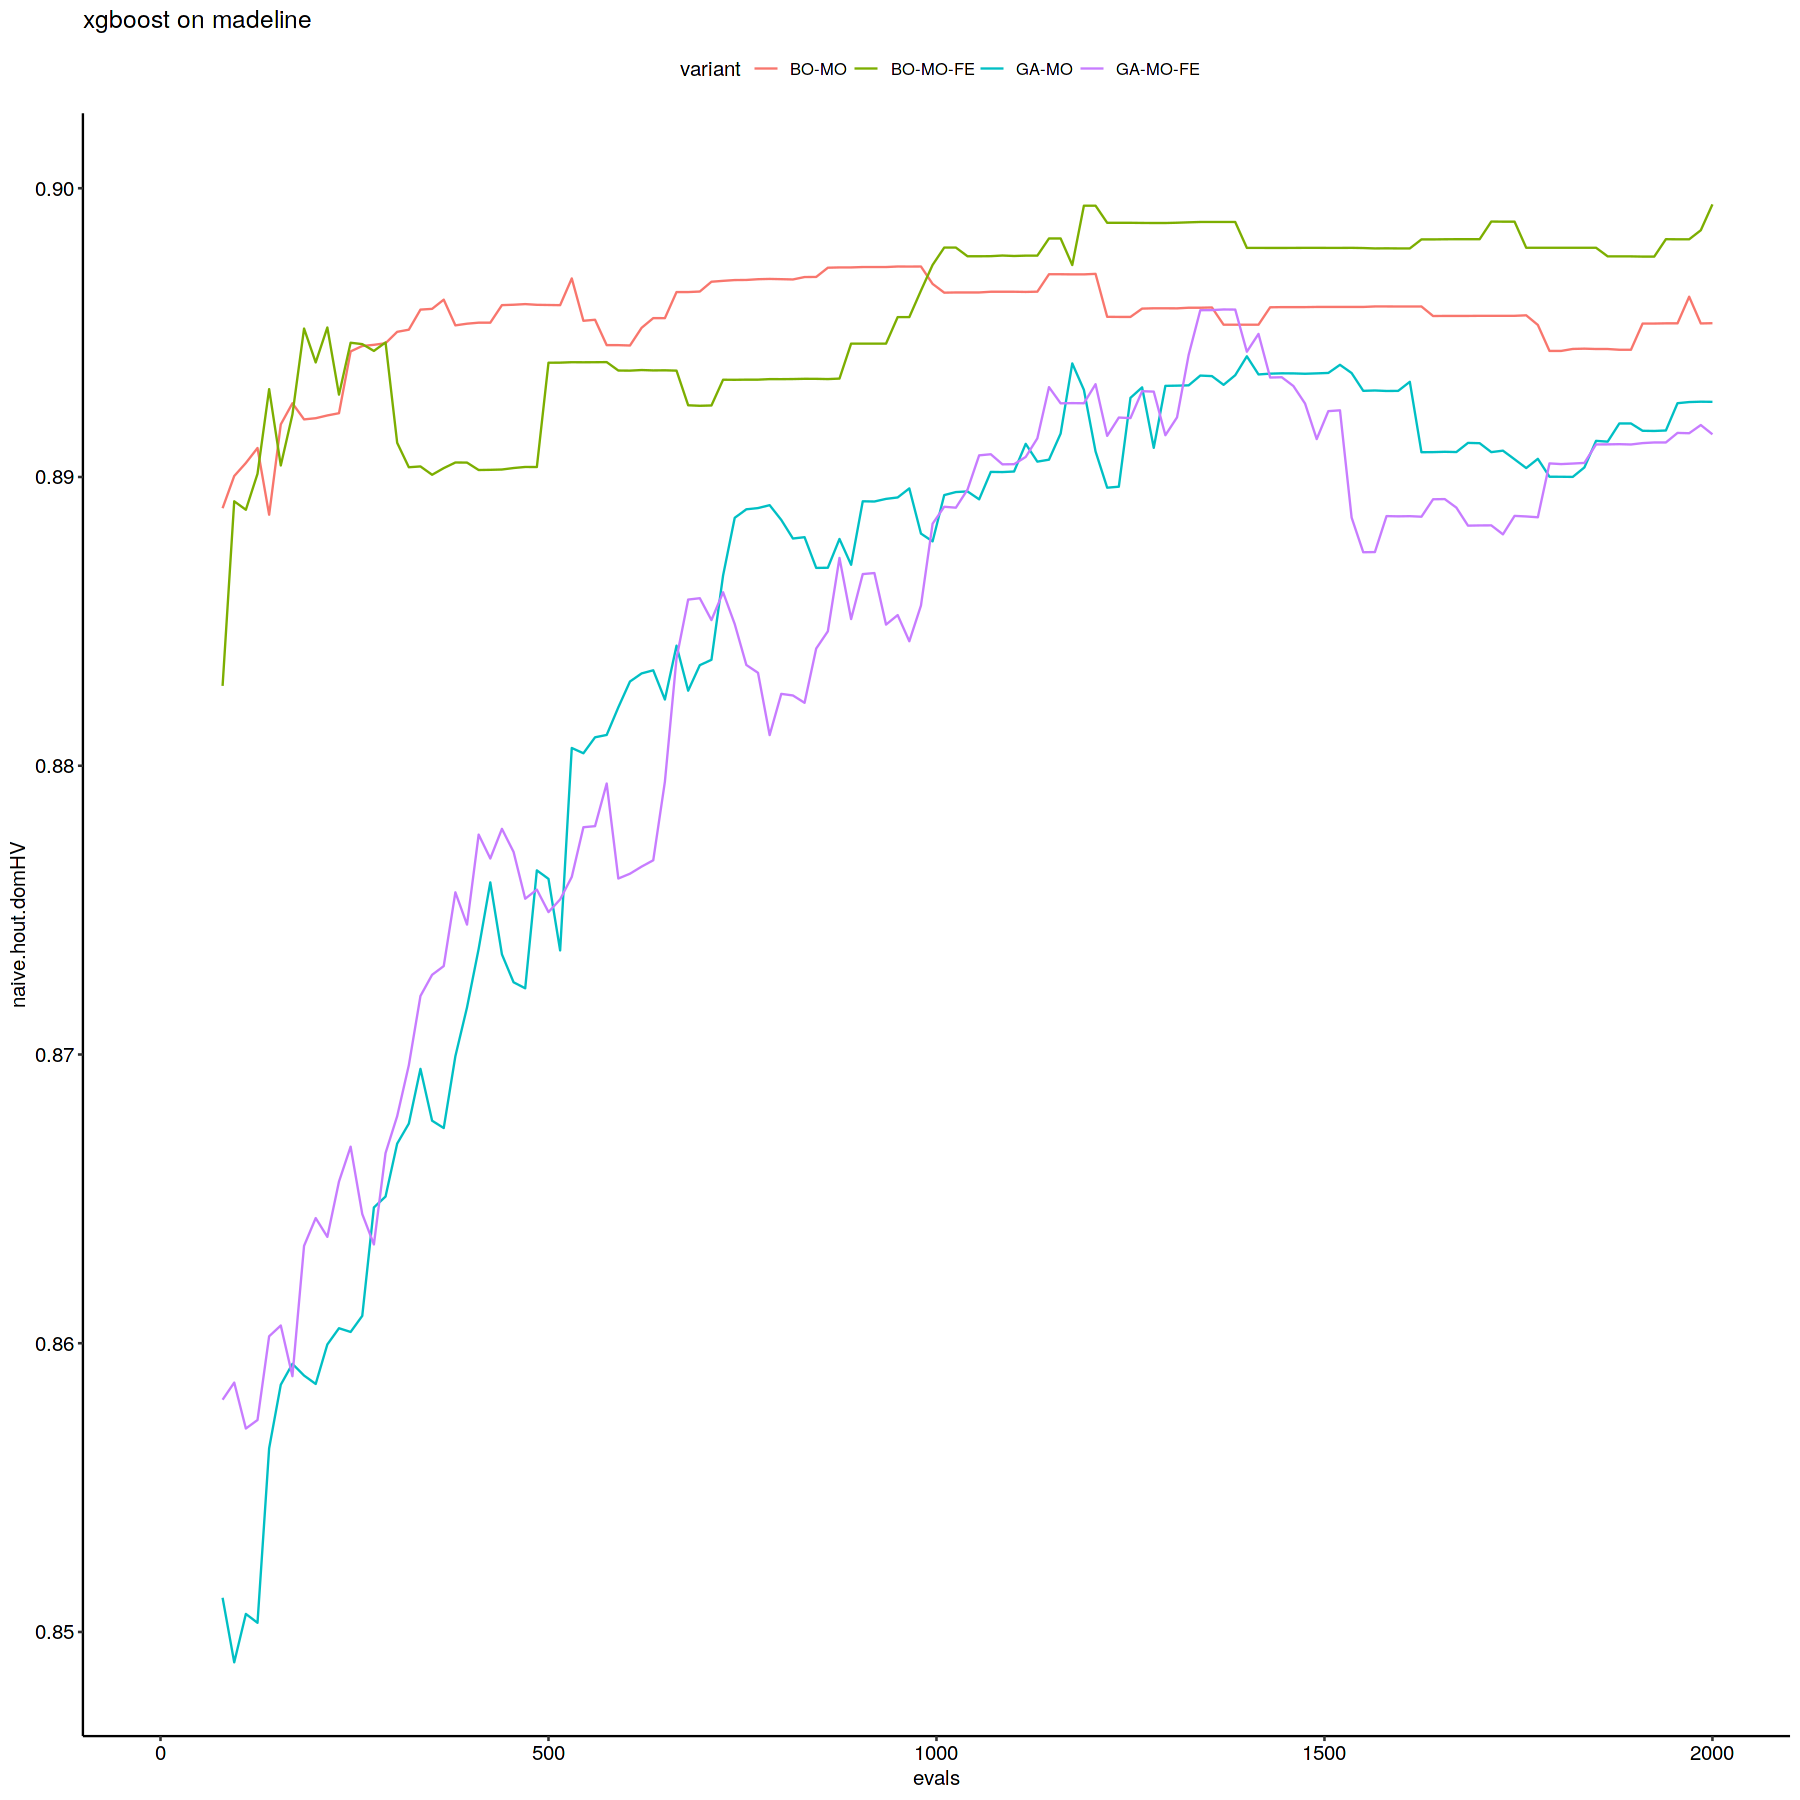

In [98]:
plist

### Statistical Performance Evaluation 

We perform critical difference tests (Demsar, 2006) after the total number of 2000 iterations over all task-learner-combinations. 

In [99]:
# Just out of interest we compute the test on true.hout.domHV
# Not relevant for the paper. 

for (measure in c("naive.hout.domHV", "true.hout.domHV")) {
    dfp = df[, lapply(.SD, mean, na.rm = TRUE), by = c("variant", "evals", "problem", "learner"), .SDcols = measure.vars]
    dfp$problem = paste(dfp$learner, dfp$problem, sep = "-")
    ev = 2000
    dfp = dfp[evals == ev, ]
    dft = dcast(dfp[, c("problem", "variant", ..measure)], problem ~ variant)
    rownames(dft) = dft$problem
    dft$problem = NULL
    m = gsub("\\.", "", measure)
    
    pdf(paste("viz/RQ1-CD_", m, ".pdf", sep = ""), width = 7, height = 4.5) 
    plotCD(dft, alpha = 0.05, cex = 1.25)
    dev.off()
    # ggsave(paste("viz/F1-Ablation-Study/CD_", measure, ".pdf"), p, width = 4.5, height = 4.5)
}

Using naive.hout.domHV as value column: use value.var to override.

Using true.hout.domHV as value column: use value.var to override.



### Rank Analysis 

We perform a global rank analysis. We first average over all replications, and then calculate the rank of methods within each problem and learner. Then, we average the ranks. 

All calculations are performed per evaluation, to draw curves later on. 

In [100]:
dfr = df[, .(meandomHV = mean(naive.hout.domHV)), by = c("learner", "variant", "problem", "evals")]

In [101]:
dfr = df[, .(meandomHV = mean(naive.hout.domHV)), by = c("learner", "variant", "problem", "evals")]
dfr = dfr[, `:=` (rank_variant = rank(meandomHV)), by = c("learner", "problem", "evals")]
res_ovr = dfr[, .(mean.domHV = mean(meandomHV), mean.rank = mean(rank_variant), sd.domHV = sd(meandomHV) / sqrt(length(meandomHV))), by = c("evals", "variant")]

In [102]:
res_ovr$ensemble = sapply(res_ovr$variant, function(x) {
    if (x %in% c("GA-MO", "BO-MO")) "no"
    else "yes"
})

res_ovr$Variant = sapply(res_ovr$variant, function(x) {
    if (x %in% c("GA-MO-FE", "GA-MO")) "Evolutionary"
    else "Bayesian Opt."
})

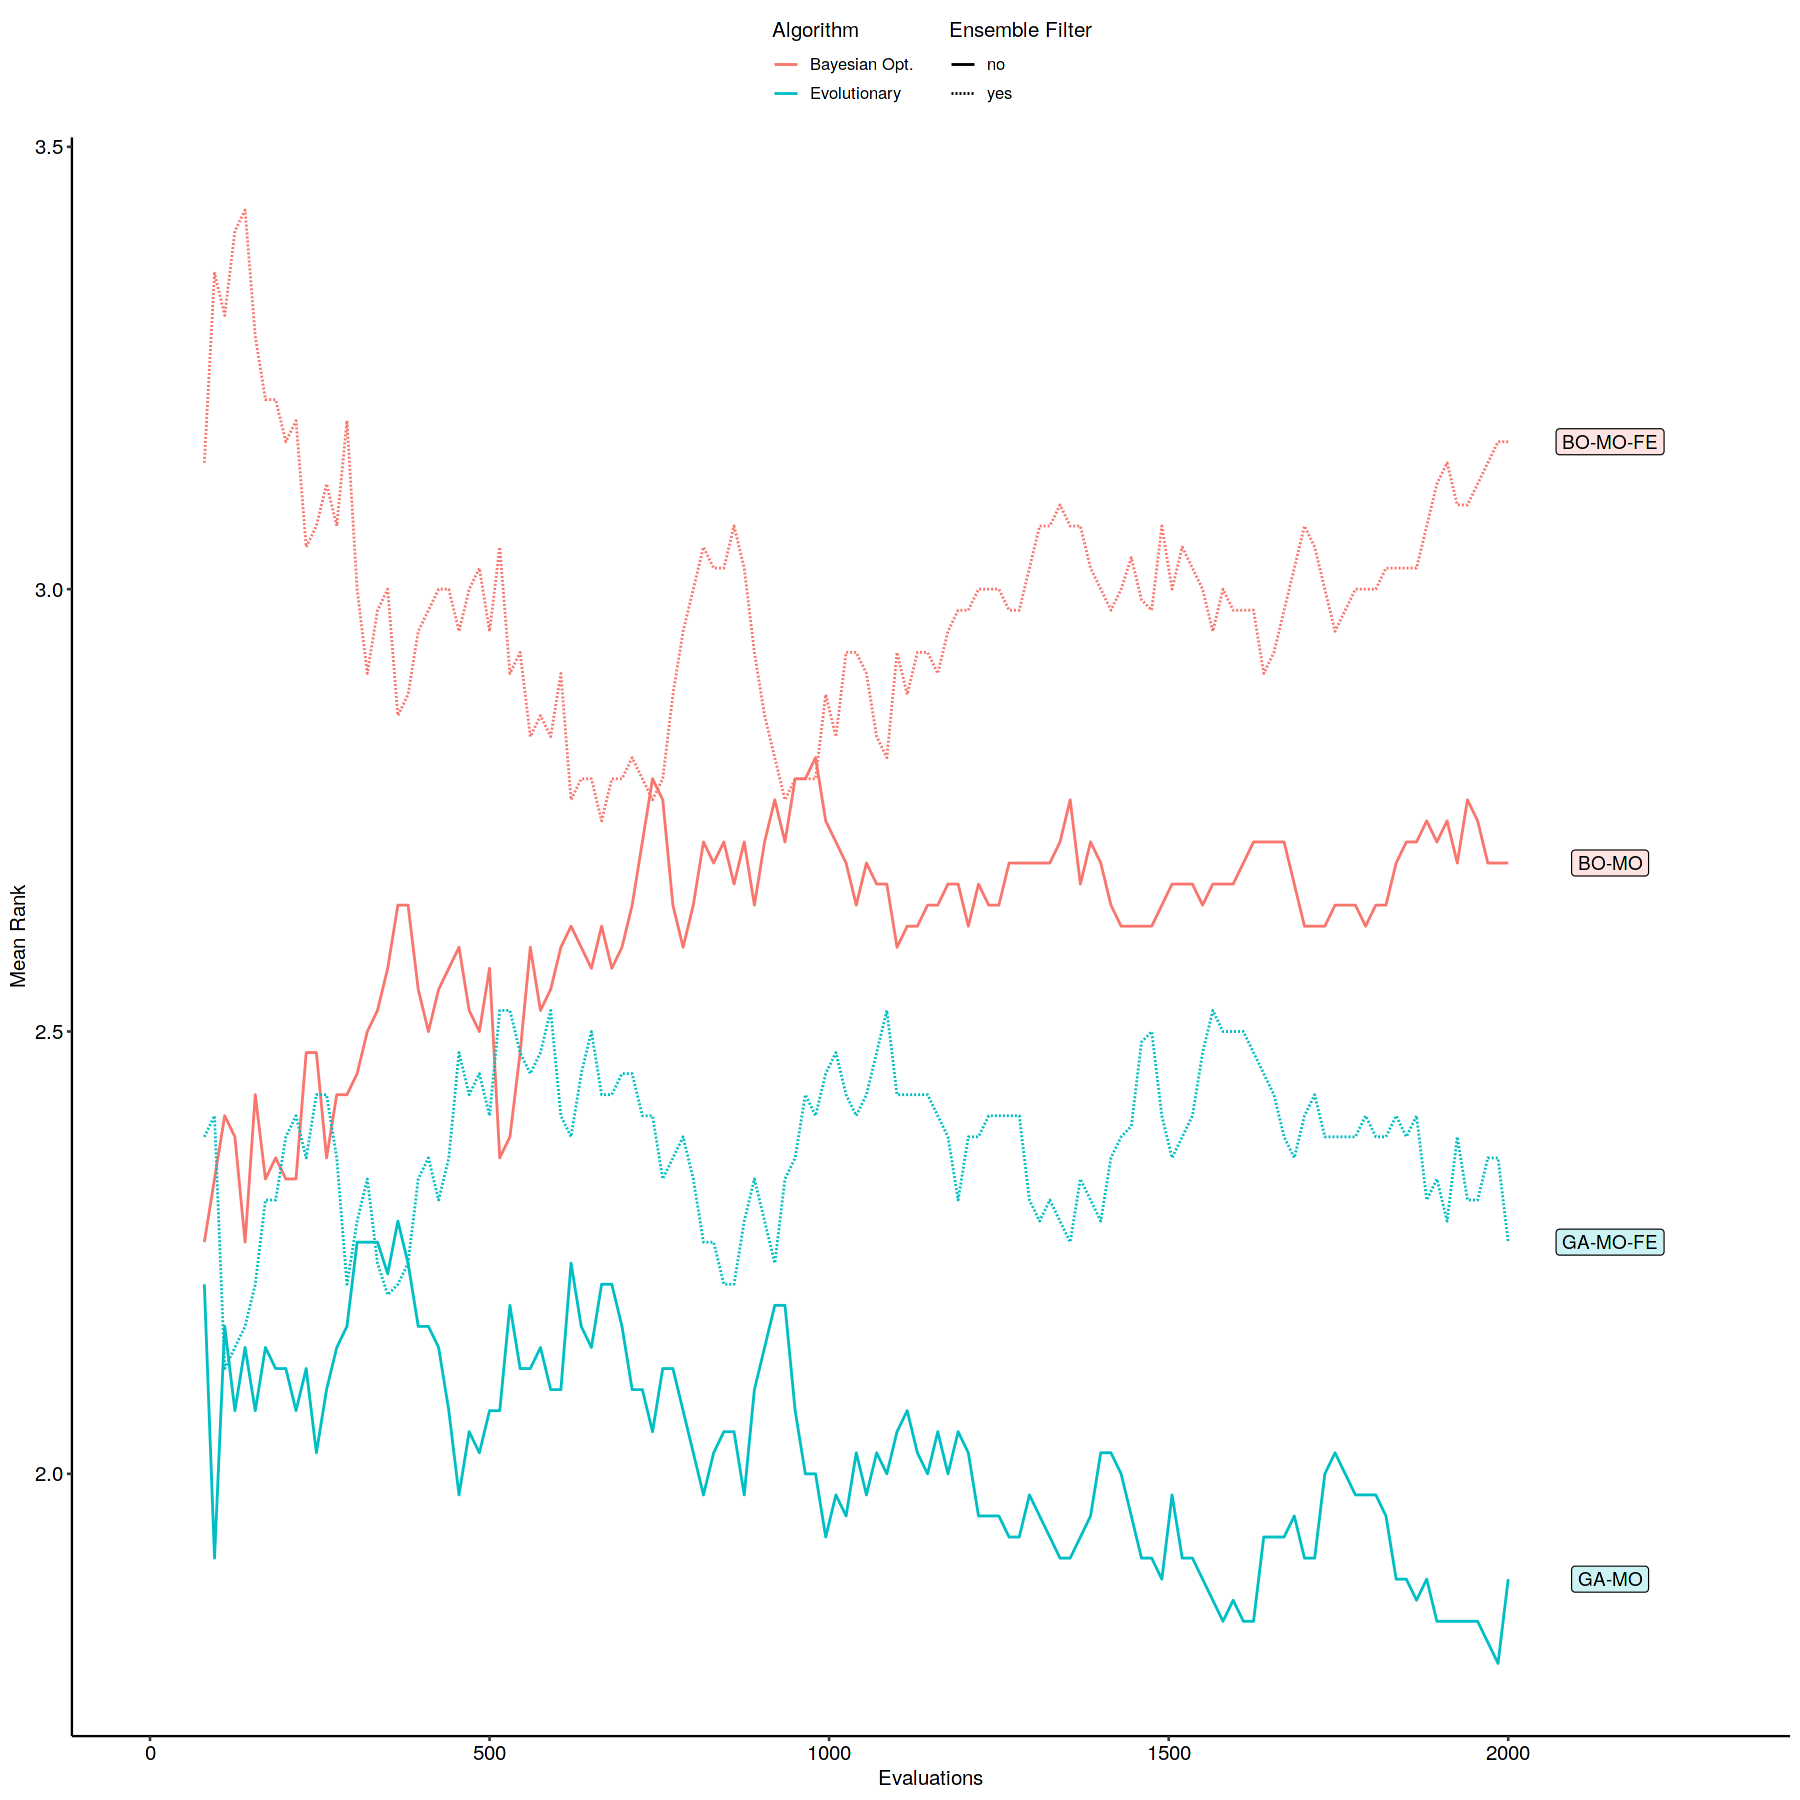

In [103]:
p1 = ggplot()
p1 = p1 + geom_line(data = res_ovr[evals <= 2000, ], aes(x = evals, y = mean.rank, colour = Variant, lty = ensemble), size = 0.6)
p1 = p1 + labs(colour = "Algorithm", lty = "Ensemble Filter") 
p1 = p1 + xlab("Evaluations") + ylab("Mean Rank") + theme(legend.direction = "vertical")
p1 = p1 + guides(shape = guide_legend(order = 2),col = guide_legend(order = 1), fill = FALSE)
p1 = p1 + geom_label(data = res_ovr[evals == 2000, ], aes(x = evals + 150, y = mean.rank, fill = Variant, label = variant), alpha = 0.2)
p1 = p1 + xlim(c(0, 2300)) 
p1

In [104]:
ggsave("viz/RQ1-ranks_naive_domHV.pdf", p1, width = 7, height = 4.5)

## Time

In [105]:
dfr = df[evals == 2000, ]
dfr = dfr[, .(meandomHV = mean(naive.hout.domHV), meanruntime = mean(runtime)), by = c("learner", "variant", "problem", "evals")]
dfr$runtime = as.numeric(dfr$meanruntime) / 3600
dfr$evals = NULL
dfr$meanruntime = NULL

In [106]:
dfr1 = dfr[variant == "GA-MO-FE", ]
dfr2 = dfr[variant == "BO-MO-FE", ]
names(dfr1)[5] = c("GAruntime")
names(dfr1)[4] = c("GAdomHV")
names(dfr2)[5] = c("BOruntime")
names(dfr2)[4] = c("BOdomHV")
dfr1$variant = NULL
dfr2$variant = NULL
dfr = ijoin(dfr1, dfr2, by = c("learner", "problem"))

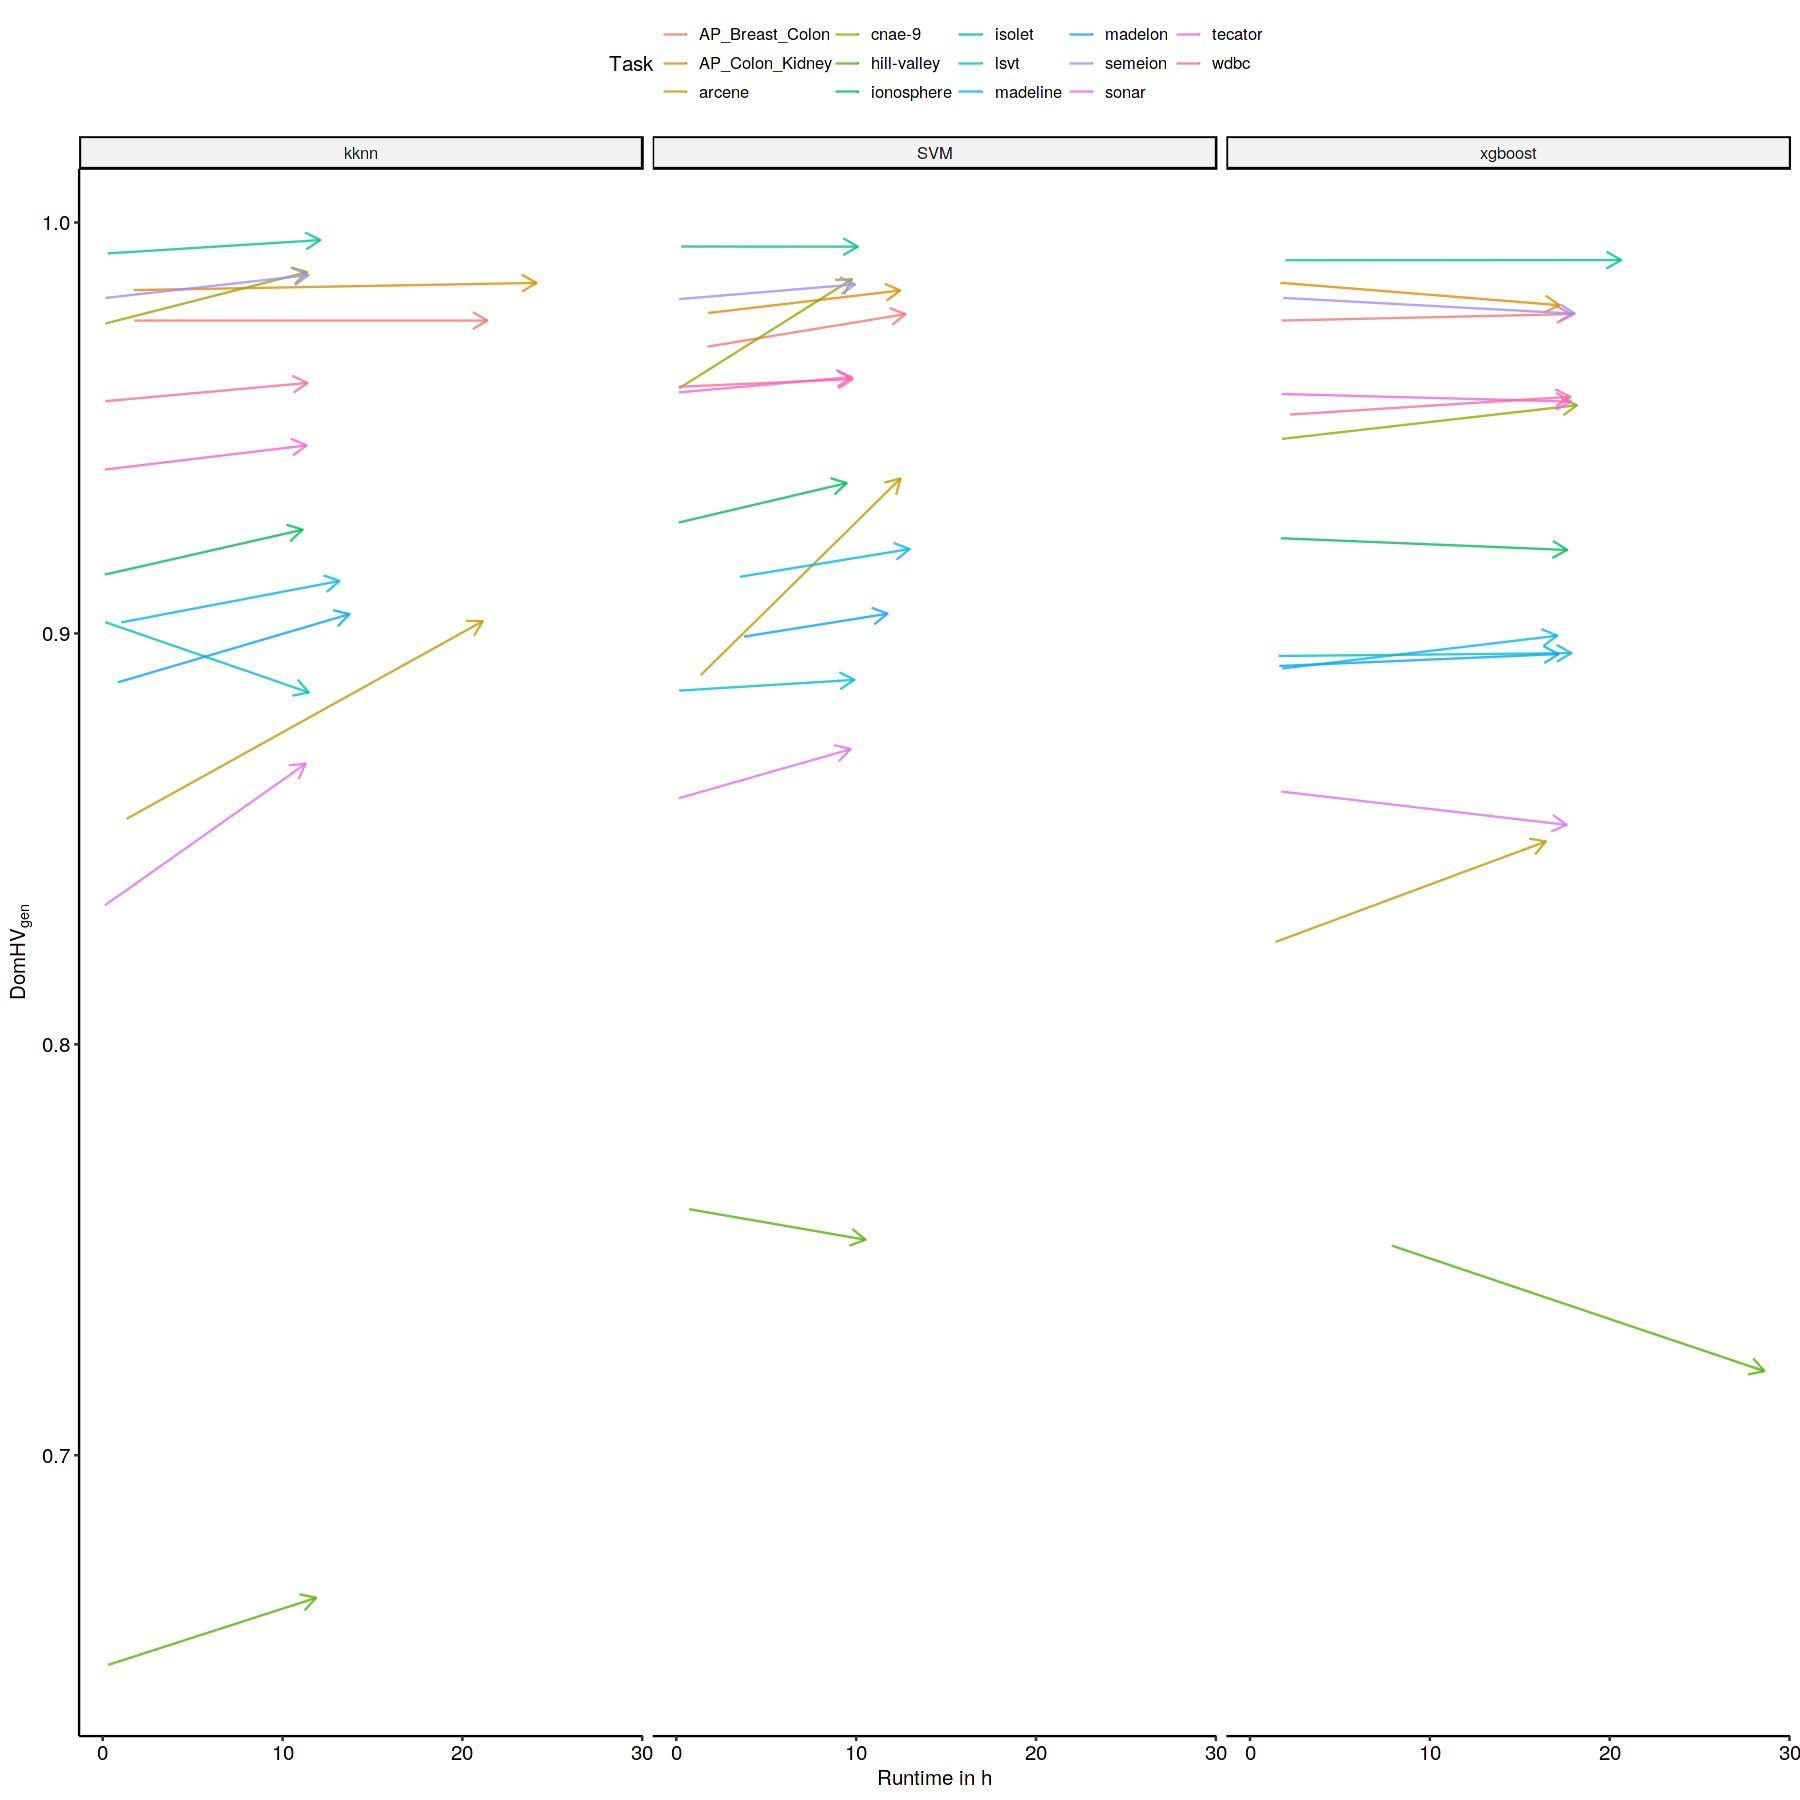

In [111]:
p = ggplot() + geom_segment(data = dfr, aes(x = GAruntime, y = GAdomHV, xend = BOruntime, yend = BOdomHV, colour = problem), 
                           arrow = arrow(length = unit(0.03, "npc")), alpha = 0.8)
# p = p + geom_point(data = dfp, aes(x = meanperfSO, y = maxfeatSO))
p = p  + xlab("Runtime in h") + ylab(expression(DomHV[gen]))# + scale_x_log10() + annotation_logticks()
p = p + theme(legend.direction = "horizontal", legend.position = "top") 
p = p + labs(lty = "Variant", colour = "Task") # + scale_linetype_manual(values = c(1, 6))
p = p + facet_grid(. ~ learner)
p

In [116]:
ggsave("viz/RQ1-runtime.pdf", p, width = 7, height = 4)
# ggsave("viz/RQ1-runtime.pdf", p, width = 13, height = 4)